<div style="border-top:3px solid SteelBlue;"></div>
<div style="border-top:3px solid Ivory;"></div>
<div style="background-color:SteelBlue; color:Ivory; text-align:center; font-family:Share Tech; font-size:40px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">
S3E01 [RMSE] CA Housing | P1 EDA FE
</div><div style="border-bottom:3px solid Ivory;"></div>
<div style="border-bottom:3px solid SteelBlue;"></div>
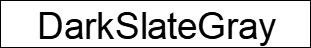
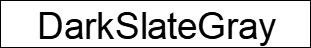
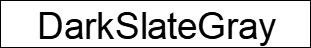
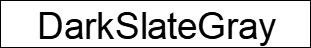
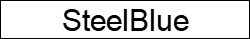
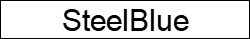
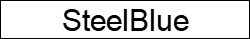
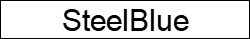
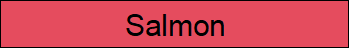
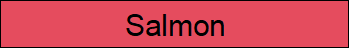
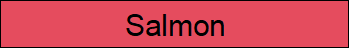
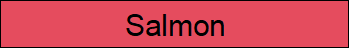



# <div style="border-radius:10px; border:3px solid Ivory; background-color:SteelBlue; color:Ivory; text-align:center; font-family:Share Tech; font-size:36px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">🥇 01 - Dataset Exploration</div>

## <div style="background-color:Ivory; color:SteelBlue; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid SteelBlue; border-top:3px solid SteelBlue;">🍓 Dataset Importing</div>

In [3]:
# Library Importing

import pandas   as pd
import numpy    as np
import seaborn  as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost  as xgb
import catboost as cat
import re, time, warnings, optuna

from itertools import combinations, product
from optuna.samplers   import TPESampler
from optuna.importance import get_param_importances
from sklearn.metrics   import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics   import roc_auc_score, accuracy_score, log_loss
from sklearn.metrics   import f1_score, classification_report, confusion_matrix
from sklearn.impute    import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection   import train_test_split, KFold, StratifiedKFold

warnings.filterwarnings('ignore')
seed = 0
color = 'CornflowerBlue'

In [4]:
# Dataset Importing

train = pd.read_csv('/kaggle/input/playground-series-s3e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e2/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s3e2/sample_submission.csv')
orgin = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

train = train.drop(['id'],axis =1)
test = test.drop(['id'],axis =1)
orgin = orgin.drop(['id'],axis =1)

print('train:',train.shape)
print('test :',test.shape)
print('orgin:',orgin.shape)

train: (15304, 11)
test : (10204, 10)
orgin: (5110, 11)


## <div style="background-color:Ivory; color:SteelBlue; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid SteelBlue; border-top:3px solid SteelBlue;">🍒 Feature Checking</div>

In [5]:
# Feature Checking

column_mapping = {}

train.rename(columns=column_mapping, inplace=True)
test.rename(columns=column_mapping, inplace=True)
orgin.rename(columns=column_mapping, inplace=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15304 non-null  object 
 1   age                15304 non-null  float64
 2   hypertension       15304 non-null  int64  
 3   heart_disease      15304 non-null  int64  
 4   ever_married       15304 non-null  object 
 5   work_type          15304 non-null  object 
 6   Residence_type     15304 non-null  object 
 7   avg_glucose_level  15304 non-null  float64
 8   bmi                15304 non-null  float64
 9   smoking_status     15304 non-null  object 
 10  stroke             15304 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.3+ MB


In [6]:
# Missing & Duplicates

target = 'stroke'

print('train null:', train.drop([target], axis=1).isnull().sum().sum())
print('test  null:', test.isnull().sum().sum())
print('orgin null:', orgin.drop([target], axis=1).isnull().sum().sum())
print('----- ----- ----- -----')
print('train duplicate:', train.duplicated().sum())
print('test  duplicate:', test.duplicated().sum())
print('orgin duplicate:', orgin.duplicated().sum())
print('----- ----- ----- -----')
print('train conflict: ', train.drop([target], axis=1).duplicated().sum())

train null: 0
test  null: 0
orgin null: 201
----- ----- ----- -----
train duplicate: 0
test  duplicate: 0
orgin duplicate: 0
----- ----- ----- -----
train conflict:  0


## <div style="background-color:Ivory; color:SteelBlue; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid SteelBlue; border-top:3px solid SteelBlue;">🍅 Dataset Checking</div>

In [7]:
# Train & Orgin Table

def table(df1, df2, n1, n2, target):
    df1 = df1.drop(columns=[target])
    df1_des = df1.select_dtypes(include='number').describe().transpose()
    df2_des = df2.select_dtypes(include='number').describe().transpose()
    table = pd.DataFrame()
    table['Type'] = df1.dtypes
    table[f'{n1}Nul'] = df1.isnull().sum()
    table[f'{n2}Nul'] = df2.isnull().sum()
    table[f'{n1}Uni']  = df1.nunique()
    table[f'{n2}Uni']  = df2.nunique()
    table[f'{n1}Avg'] = df1_des['mean'].round(1)
    table[f'{n2}Avg'] = df2_des['mean'].round(1)
    table[f'{n1}Min']  = df1_des['min'].round(1)
    table[f'{n2}Min']  = df2_des['min'].round(1)
    table[f'{n1}Max']  = df1_des['max'].round(1)
    table[f'{n2}Max']  = df2_des['max'].round(1)
    int_metric = [f'{n1}Nul', f'{n2}Nul', f'{n1}Uni', f'{n2}Uni']
    table[int_metric] = table[int_metric].fillna(0).astype(int)
    table = table.sort_values(by=f'{n1}Uni')
    return table
    
table(train, orgin, 'tr', 'or', target)

,Type,trNul,orNul,trUni,orUni,trAvg,orAvg,trMin,orMin,trMax,orMax
hypertension,int64,0,0,2,2,0.0,0.1,0.0,0.0,1.0,1.0
heart_disease,int64,0,0,2,2,0.0,0.1,0.0,0.0,1.0,1.0
ever_married,object,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,object,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN
gender,object,0,0,3,3,NaN,NaN,NaN,NaN,NaN,NaN
smoking_status,object,0,0,4,4,NaN,NaN,NaN,NaN,NaN,NaN
work_type,object,0,0,5,5,NaN,NaN,NaN,NaN,NaN,NaN
age,float64,0,0,106,104,41.4,43.2,0.1,0.1,82.0,82.0
bmi,float64,0,201,407,418,28.1,28.9,10.3,10.3,80.1,97.6
avg_glucose_level,float64,0,0,3740,3979,89.0,106.1,55.2,55.1,267.6,271.7


In [8]:
# Train & Test Table

train['extra'] = 0
orgin['extra'] = 1
test['extra'] = 0
print('raw train:',train.shape)
print('raw orgin:',orgin.shape)

raw = len(train) + len(orgin)
train = pd.concat([train, orgin],axis=0)
columns_to_check = train.drop(columns=['extra']).columns.tolist()
train.drop_duplicates(subset=columns_to_check, inplace=True)
new = len(train)

print('----- ----- ----- -----')
print('train_orgin duplicate:', raw-new)
print('----- ----- ----- -----')
print('new train:',train.shape)
print('new test :',test.shape)
print('----- ----- ----- -----')

table(train, test, 'tr', 'te', target)

raw train: (15304, 12)
raw orgin: (5110, 12)
----- ----- ----- -----
train_orgin duplicate: 115
----- ----- ----- -----
new train: (20299, 12)
new test : (10204, 11)
----- ----- ----- -----


,Type,trNul,teNul,trUni,teUni,trAvg,teAvg,trMin,teMin,trMax,teMax
hypertension,int64,0,0,2,2,0.1,0.1,0.0,0.0,1.0,1.0
heart_disease,int64,0,0,2,2,0.0,0.0,0.0,0.0,1.0,1.0
ever_married,object,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,object,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN
extra,int64,0,0,2,1,0.2,0.0,0.0,0.0,1.0,0.0
gender,object,0,0,3,3,NaN,NaN,NaN,NaN,NaN,NaN
smoking_status,object,0,0,4,4,NaN,NaN,NaN,NaN,NaN,NaN
work_type,object,0,0,5,5,NaN,NaN,NaN,NaN,NaN,NaN
age,float64,0,0,106,106,41.9,41.9,0.1,0.1,82.0,82.0
bmi,float64,201,0,440,400,28.3,28.2,10.3,11.5,97.6,97.6


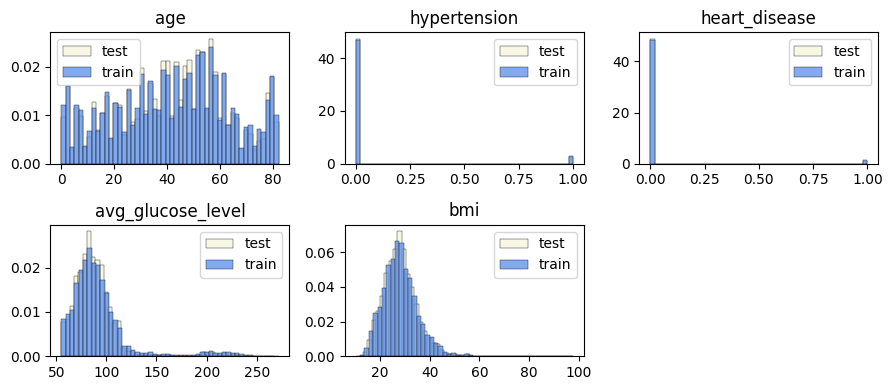

In [9]:
# Train & Test Plot

features = train.drop(columns=[target,'extra'])
features = features.select_dtypes(include='number').columns.tolist()
row = int(np.ceil(len(features) / 3))

fig, axes = plt.subplots(row, 3, figsize=(9, row * 2))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(test[feature], color="Beige", bins=50,
                 label='test', stat='density', ax=axes[i], alpha=0.8)
    sns.histplot(train[feature], color=color, bins=50,
                 label='train', stat='density', ax=axes[i], alpha=0.8)
    axes[i].set_xlabel(''); axes[i].set_ylabel('')
    axes[i].set_title(feature); axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# <div style="border-radius:10px; border:3px solid Ivory; background-color:SteelBlue; color:Ivory; text-align:center; font-family:Share Tech; font-size:36px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">🥈 02 - Feature Exploration</div>

## <div style="background-color:Ivory; color:SteelBlue; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid SteelBlue; border-top:3px solid SteelBlue;">🍐 Feature Target</div>

In [10]:
# Target Values

train[target].value_counts()

stroke
0    19420
1      879
Name: count, dtype: int64

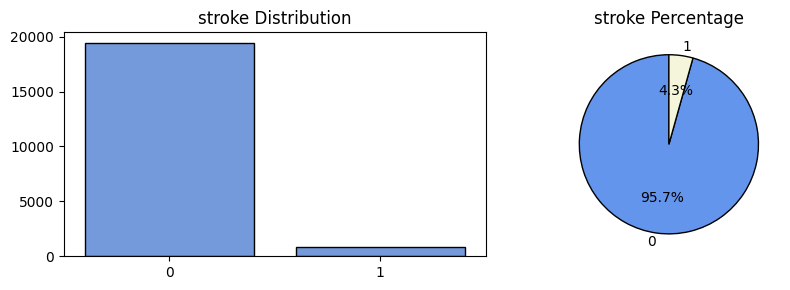

In [11]:
# Target Feature

count = train[target].value_counts().reset_index()
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

sns.barplot(data=count, x=target, y='count', ax=axes[0], 
            color=color, edgecolor='black')
axes[0].set_title(f'{target} Distribution')
axes[0].set_xlabel(''); axes[0].set_ylabel('')

axes[1].pie(count['count'], labels=count[target], colors=[color, 'Beige'], 
            wedgeprops={'edgecolor':'black'}, autopct='%1.1f%%',startangle=90)
axes[1].set_title(f'{target} Percentage')

plt.tight_layout()
plt.show()

## <div style="background-color:Ivory; color:SteelBlue; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid SteelBlue; border-top:3px solid SteelBlue;">🥝 Feature Category</div>

In [26]:
# Cat Features

df1 = pd.concat([train, test], axis=0)
cat_features = df1.columns[df1.nunique() <= 200].drop([target, 'extra']).tolist()

pd.DataFrame({
    'Feat': df1[cat_features].columns,
    'Uniq': df1[cat_features].nunique().values,
    'Type': df1[cat_features].dtypes.values,
    'Null': df1[cat_features].isnull().sum().values
}).sort_values(by='Uniq')

,Feat,Uniq,Type,Null
2,hypertension,2,int64,0
3,heart_disease,2,int64,0
4,ever_married,2,object,0
6,Residence_type,2,object,0
0,gender,3,object,0
7,smoking_status,4,object,0
5,work_type,5,object,0
1,age,109,float64,0


In [27]:
# Remove Rare

obj_features = df1.select_dtypes(include='object').columns.tolist()

for col in obj_features:
    count = df1[col].value_counts()
    valid = count[count >= 100].index
    mode  = df1[col].mode()[0]

    df1[col] = df1[col].where(df1[col].isin(valid), mode)
    #df1[col] = df1[col].fillna('Other') #mode

In [28]:
# Obj Encoder

obj_features = df1.select_dtypes(include='object').columns.tolist()

for col in obj_features:
    freq = df1[col].value_counts().sort_values(ascending=False).reset_index()
    freq.columns = ['value', 'rank']
    freq['rank'] = range(len(freq))
    df1[col] = df1[col].map(dict(zip(freq['value'], freq['rank'])))

In [29]:
# Cat Preprocess

def cat_preprocess(df):
    df['age']       = (np.round(df['age'],0)).astype(int)
    return df
df1 = cat_preprocess(df1)

pd.DataFrame({
    'Feat': df1[cat_features].columns,
    'Uniq': df1[cat_features].nunique().values,
    'Type': df1[cat_features].dtypes.values,
    'Null': df1[cat_features].isnull().sum().values
}).sort_values(by='Uniq')

,Feat,Uniq,Type,Null
0,gender,2,int64,0
2,hypertension,2,int64,0
3,heart_disease,2,int64,0
4,ever_married,2,int64,0
6,Residence_type,2,int64,0
5,work_type,4,int64,0
7,smoking_status,4,int64,0
1,age,83,int64,0


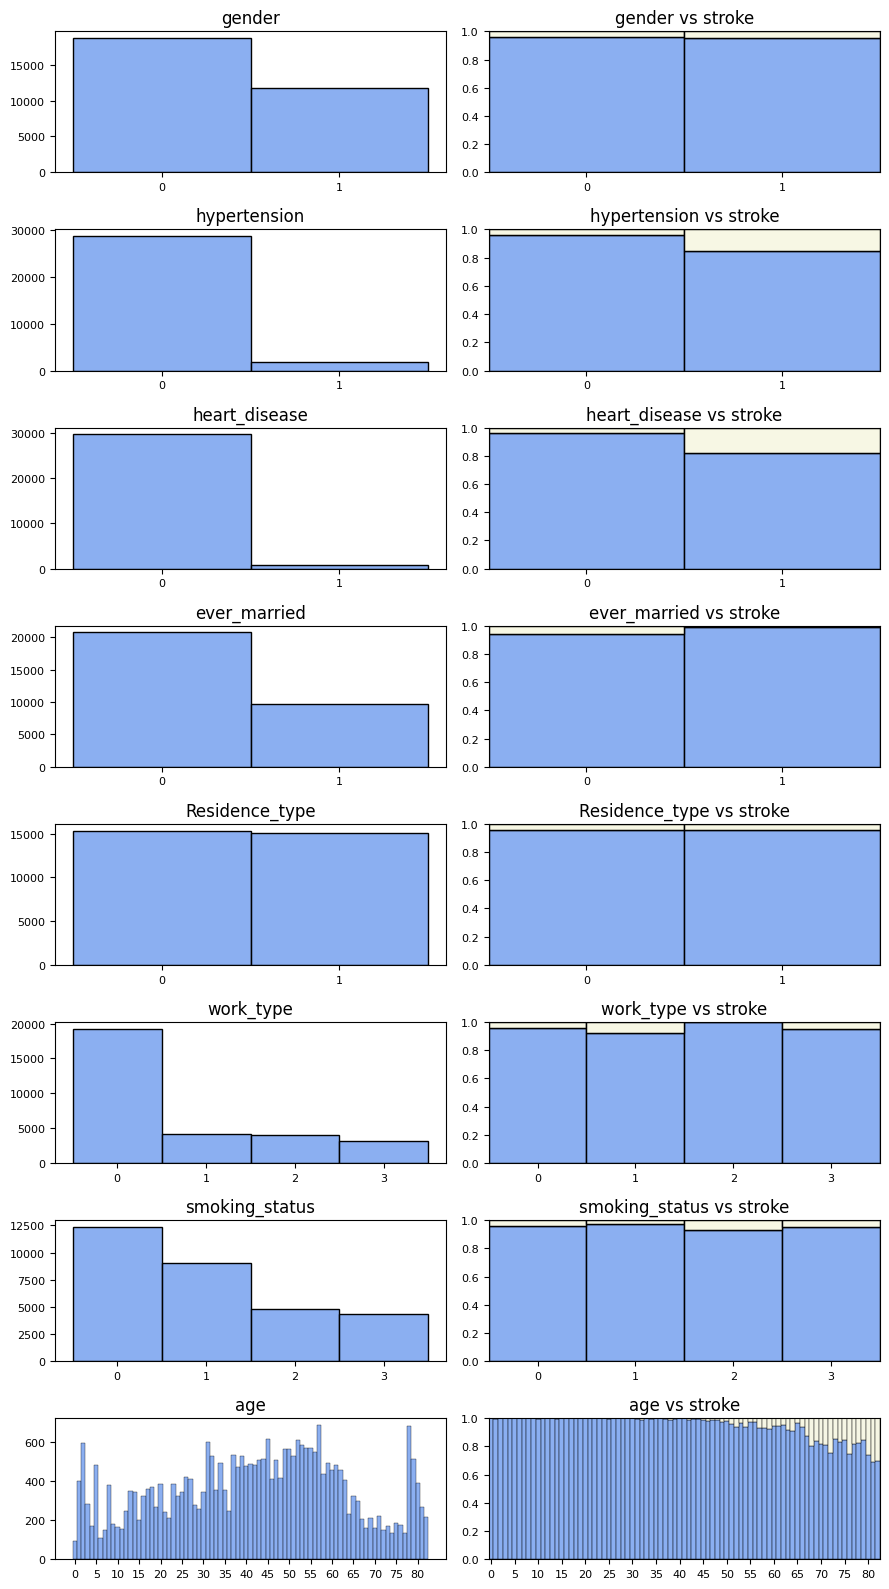

In [30]:
# Cat Plot

cat_features = df1[cat_features].nunique().sort_values().index.tolist()
def cat_plot(train, cat_features, target):
    num_rows = len(cat_features)
    fig, axes = plt.subplots(num_rows, 2, figsize=(9, 2 * num_rows))
    axes = axes.reshape(-1, 2)

    for i, feature in enumerate(cat_features):
        unique = train[feature].nunique()
        unique_vals = sorted(train[feature].unique())
        xticks = unique_vals[::max(1, len(unique_vals) // 15)]
        sns.histplot(data=train,x=feature,ax=axes[i][0],color=color,discrete=True)
        axes[i][0].set_xlabel(''); axes[i][0].set_ylabel('')
        axes[i][0].set_xticks(xticks)
        axes[i][0].set_xticklabels(xticks, ha='center')
        axes[i][0].set_title(f'{feature}')
        axes[i][0].tick_params(labelsize=8)

        sns.histplot(data=train, x=feature, ax=axes[i][1], multiple="fill", 
                     palette=['Beige', color], discrete=True, 
                     hue_order=[1, 0], hue=target, legend=False)
        axes[i][1].set_xlabel(''); axes[i][1].set_ylabel('')
        axes[i][1].set_xticks(xticks)
        axes[i][1].set_xticklabels(xticks, ha='center') 
        axes[i][1].set_title(f'{feature} vs {target}')
        axes[i][1].tick_params(labelsize=8)
        axes[i][1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

cat_plot(df1, cat_features, target)

## <div style="background-color:Ivory; color:SteelBlue; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid SteelBlue; border-top:3px solid SteelBlue;">🥑 Feature Numeric</div>

In [68]:
# Num Features

df2 = df1.copy()
num_features = df2.columns[df2.nunique() > 200].tolist()

pd.DataFrame({
    'Feat': df2[num_features].columns,
    'Uniq': df2[num_features].nunique().values,
    'Type': df2[num_features].dtypes.values,
    'Null': df2[num_features].isnull().sum().values
}).sort_values(by='Uniq')

,Feat,Uniq,Type,Null
1,bmi,457,float64,201
0,avg_glucose_level,4922,float64,0


In [69]:
# Fill Null

imput_features = df2.drop(columns=[target]).columns.tolist()
imputer = KNNImputer(n_neighbors=10, weights='uniform')

df2[imput_features] = imputer.fit_transform(df2[imput_features])
df2.drop([target], axis=1).isnull().sum().sum()

0

In [70]:
# Num Preprocess

def num_preprocess(df):
    df['bmi']               = round(df['bmi'], 1).clip(0,55)
    df['avg_glucose_level'] = round(df['avg_glucose_level'], 1).clip(0,250)
    return df
df2 = num_preprocess(df2)

pd.DataFrame({
    'Feat': df2[num_features].columns,
    'Uniq': df2[num_features].nunique().values,
    'Type': df2[num_features].dtypes.values,
    'Null': df2[num_features].isnull().sum().values
}).sort_values(by='Uniq')

,Feat,Uniq,Type,Null
1,bmi,407,float64,0
0,avg_glucose_level,1330,float64,0


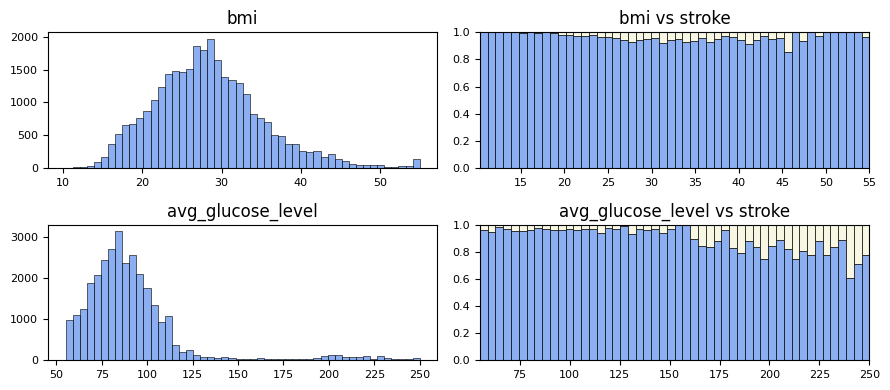

In [71]:
# Num Plot

num_features = df2[num_features].nunique().sort_values().index.tolist()
def num_plot(train, num_features, target):
    num_rows = len(num_features)
    fig, axes = plt.subplots(num_rows, 2, figsize=(9, 2 * num_rows))
    axes = axes.reshape(-1, 2)

    for i, feature in enumerate(num_features):
        sns.histplot(data=train, x=feature, ax=axes[i][0], color=color, bins=50)
        axes[i][0].set_xlabel(''); axes[i][0].set_ylabel('')
        axes[i][0].set_title(f'{feature}')
        axes[i][0].tick_params(labelsize=8)

        sns.histplot(data=train, x=feature, ax=axes[i][1], multiple="fill", 
                     palette=['Beige', color], bins=50, 
                     hue_order=[1, 0], hue=target, legend=False)
        axes[i][1].set_xlabel(''); axes[i][1].set_ylabel('')
        axes[i][1].set_title(f'{feature} vs {target}')
        axes[i][1].tick_params(labelsize=8)
        axes[i][1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

num_plot(df2, num_features, target)

# <div style="border-radius:10px; border:3px solid Ivory; background-color:SteelBlue; color:Ivory; text-align:center; font-family:Share Tech; font-size:36px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">🥉 03 - Feature Preprocessing</div>

## <div style="background-color:Ivory; color:SteelBlue; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid SteelBlue; border-top:3px solid SteelBlue;">🍑 Feature Correlation</div>
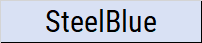
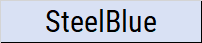
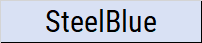
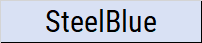

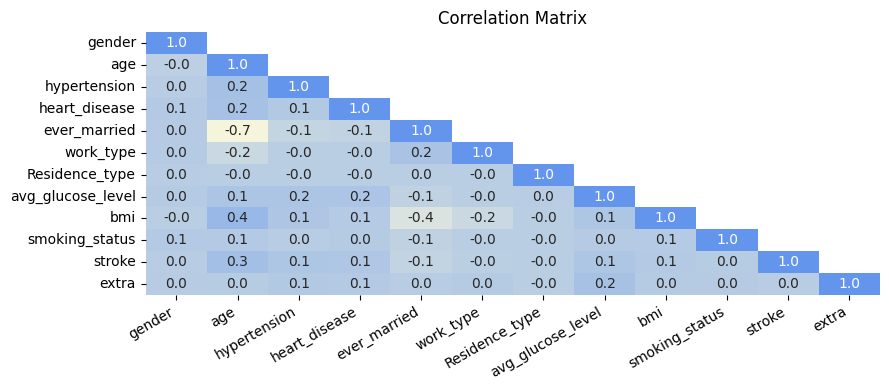

In [72]:
# Correlation

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(None,["Beige",color])

df3 = df2.copy()

correlation_matrix = df3.select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
plt.figure(figsize=(9, 4))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".1f", cmap=cmap, 
            cbar=False, annot_kws={"size": 10})
plt.xticks(rotation=30, ha='right')
plt.tick_params(labelsize=10)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [73]:
# New Features

def new_preprocess(df):
    return df
df3 = new_preprocess(df3)

#new_features = []
#num_plot(df3, new_features, target)

## <div style="background-color:Ivory; color:SteelBlue; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid SteelBlue; border-top:3px solid SteelBlue;">🥭 Feature Encoding</div>

In [74]:
# Category Features

cat_features = df3.columns[df3.nunique() <= 200].drop([target]).tolist()

df3[cat_features] = df3[cat_features].astype('int')

cat_features

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status',
 'extra']

In [75]:
# Numerical Features

num_features = df3.columns[df3.nunique() > 200].tolist()

df3[num_features] = MinMaxScaler().fit_transform(df3[num_features])

num_features

['avg_glucose_level', 'bmi']

In [76]:
# Train & Test Table

x_train_all = df3.iloc[:len(train)]
x_test = df3.iloc[len(train):].drop(columns=[target])

print('x_train_all', x_train_all.shape)
print('x_test_all', x_test.shape)

table(x_train_all, x_test, 'tr', 'te', target)

x_train_all (20299, 12)
x_test_all (10204, 11)


,Type,trNul,teNul,trUni,teUni,trAvg,teAvg,trMin,teMin,trMax,teMax
gender,int64,0,0,2,2,0.4,0.4,0.0,0.0,1.0,1.0
hypertension,int64,0,0,2,2,0.1,0.1,0.0,0.0,1.0,1.0
heart_disease,int64,0,0,2,2,0.0,0.0,0.0,0.0,1.0,1.0
ever_married,int64,0,0,2,2,0.3,0.3,0.0,0.0,1.0,1.0
Residence_type,int64,0,0,2,2,0.5,0.5,0.0,0.0,1.0,1.0
extra,int64,0,0,2,1,0.2,0.0,0.0,0.0,1.0,0.0
work_type,int64,0,0,4,4,0.7,0.7,0.0,0.0,3.0,3.0
smoking_status,int64,0,0,4,4,1.0,1.0,0.0,0.0,3.0,3.0
age,int64,0,0,83,83,41.9,41.9,0.0,0.0,82.0,82.0
bmi,float64,0,0,402,374,0.4,0.4,0.0,0.0,1.0,1.0


## <div style="background-color:Ivory; color:SteelBlue; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid SteelBlue; border-top:3px solid SteelBlue;">🍉 Feature Generation</div>

In [77]:
# Correlation & MutualInfo
#'''
X = x_train_all.drop(columns=[target])
Y = x_train_all[target]

corr = X.corrwith(Y).abs()

mi = mutual_info_regression(X, Y, random_state=seed)
mi_series = pd.Series(mi, index=X.columns)
combined = pd.DataFrame({'Correlation': corr, 'Mutual Info': mi_series})
combined['Average Score'] = combined.mean(axis=1)
combined = combined.sort_values(by='Average Score', ascending=False)

print(combined.round(4))
#'''

                   Correlation  Mutual Info  Average Score
age                     0.2573       0.0430         0.1501
avg_glucose_level       0.1384       0.0170         0.0777
hypertension            0.1383       0.0135         0.0759
heart_disease           0.1181       0.0008         0.0594
ever_married            0.1118       0.0048         0.0583
bmi                     0.0600       0.0121         0.0360
work_type               0.0233       0.0208         0.0220
smoking_status          0.0320       0.0000         0.0160
extra                   0.0173       0.0000         0.0086
gender                  0.0137       0.0030         0.0084
Residence_type          0.0035       0.0020         0.0027


# <div style="border-radius:10px; border:3px solid Ivory; background-color:SteelBlue; color:Ivory; text-align:center; font-family:Share Tech; font-size:36px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">🏆 04 - Model Development</div>

## <div style="background-color:Ivory; color:SteelBlue; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid SteelBlue; border-top:3px solid SteelBlue;">🍍 Cross Validation</div>

In [78]:
# StratifiedKFold

n = 5
x = x_train_all[x_train_all['extra'] == 0].drop(columns=[target])
y = x_train_all[x_train_all['extra'] == 0][target]
extra_x = x_train_all[x_train_all['extra'] == 1].drop(columns=[target])
extra_y = x_train_all[x_train_all['extra'] == 1][target]

kfold = StratifiedKFold(n_splits=n, shuffle=True, random_state=seed)
folds, valid_all = [], []
for train_idx, valid_idx in kfold.split(x, y):
    x_train, x_valid = x.iloc[train_idx], x.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    x_train = pd.concat([x_train, extra_x], axis=0).reset_index(drop=True)
    y_train = pd.concat([y_train, extra_y], axis=0).reset_index(drop=True)
    folds.append((x_train, x_valid, y_train, y_valid))
    valid_all.extend(y_valid)
oof_table = pd.DataFrame({'oof_target': valid_all})
pred_table = pd.DataFrame()

print('x_train', x_train.shape)
print('x_valid', x_valid.shape)
print('y_train', y_train.shape)
print('y_valid', y_valid.shape)

x_train (17239, 11)
x_valid (3060, 11)
y_train (17239,)
y_valid (3060,)


## <div style="background-color:Ivory; color:SteelBlue; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid SteelBlue; border-top:3px solid SteelBlue;">🍌 Model Training</div>

In [79]:
# LGB & XGB & CAT

def Model(model_name, best_param):
    oof, pred, n = [], 0, len(folds)
    for i, (x_train, x_valid, y_train, y_valid) in enumerate(folds):
        if model_name == 'lgb':
            lgb_tr=lgb.Dataset(x_train,y_train,categorical_feature=cat_features)
            lgb_va=lgb.Dataset(x_valid,y_valid,categorical_feature=cat_features)
            model=lgb.train(best_param, lgb_tr, 20000, valid_sets=[lgb_va], 
                            callbacks=[lgb.early_stopping(100, verbose=0)])
            oof_f=model.predict(x_valid)
            pred+=model.predict(x_test)/n
            
        elif model_name == 'xgb':
            xgb_tr=xgb.DMatrix(x_train, y_train)
            xgb_va=xgb.DMatrix(x_valid, y_valid)
            model=xgb.train(best_param, xgb_tr, 20000, evals=[(xgb_va,"")],
                            early_stopping_rounds=100, verbose_eval=0)
            oof_f=model.predict(xgb_va)
            pred+=model.predict(xgb.DMatrix(x_test))/n
            
        elif model_name == 'cat':
            cat_tr=cat.Pool(x_train, y_train, cat_features=cat_features)
            cat_va=cat.Pool(x_valid, y_valid, cat_features=cat_features)
            model=cat.train(cat_tr,best_param,eval_set=[cat_va],iterations=20000,
                             early_stopping_rounds=100, verbose=1000)
            oof_f=model.predict(x_valid, prediction_type='Probability')[:,1]
            pred+=model.predict(x_test,prediction_type='Probability')[:,1]/n
                
        metric_fold = roc_auc_score(y_valid, oof_f)
        print(f'Fold {i+1}: Metric: {metric_fold:.5f}')
        oof.extend(oof_f)
    metric_overall = roc_auc_score(valid_all, oof)
    print(f'Overall Metric: {metric_overall:.5f}')

    return oof, pred

In [80]:
name = 'lgb1'
model = 'lgb'

best_param = {'learning_rate': 0.01, 
              #'device':'gpu',
              'objective':'binary', 
              'eval_metric':'auc',
              'verbose':-1}
start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = pred
sub.to_csv(f'{name}.csv', index=False) 

Fold 1: Metric: 0.87216
Fold 2: Metric: 0.90328
Fold 3: Metric: 0.88304
Fold 4: Metric: 0.88564
Fold 5: Metric: 0.89986
Overall Metric: 0.88831
Time: 7.16 seconds


In [82]:
name = 'xgb1'
model = 'xgb'

best_param = {'learning_rate': 0.02, 
              #'device':'cuda', 
              'objective':'binary:logistic', 
              'eval_metric':'auc'}
start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = pred
sub.to_csv(f'{name}.csv', index=False) 

Fold 1: Metric: 0.86772
Fold 2: Metric: 0.90327
Fold 3: Metric: 0.87725
Fold 4: Metric: 0.87880
Fold 5: Metric: 0.89446
Overall Metric: 0.88216
Time: 2.37 seconds


In [83]:
name = 'cat1'
model = 'cat'

best_param = {'learning_rate': 0.02, 
              #'task_type':'GPU', 
              'objective':'Logloss', 
              'eval_metric':'AUC'}

start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = pred
sub.to_csv(f'{name}.csv', index=False) 

0:	test: 0.6866851	best: 0.6866851 (0)	total: 19.9ms	remaining: 6m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8716935724
bestIteration = 344

Shrink model to first 345 iterations.
Fold 1: Metric: 0.87169
0:	test: 0.6972215	best: 0.6972215 (0)	total: 18.6ms	remaining: 6m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8837781564
bestIteration = 549

Shrink model to first 550 iterations.
Fold 2: Metric: 0.88378
0:	test: 0.6316321	best: 0.6316321 (0)	total: 19.6ms	remaining: 6m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8746088487
bestIteration = 812

Shrink model to first 813 iterations.
Fold 3: Metric: 0.87461
0:	test: 0.7332617	best: 0.7332617 (0)	total: 17.6ms	remaining: 5m 51s
1000:	test: 0.8775180	best: 0.8775180 (1000)	total: 14.3s	remaining: 4m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8784009361
bestIteration = 1172

Shrink model to first 1173 iterations.
Fold 4: Me

## <div style="background-color:Ivory; color:SteelBlue; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid SteelBlue; border-top:3px solid SteelBlue;">🌽 Model Blending</div>

In [84]:
# Hill Climbers

!pip install -q hillclimbers
from hillclimbers import climb_hill, partial

hc_test, hc_oof = climb_hill(
    train            = oof_table,
    target           = 'oof_target',
    oof_pred_df      = oof_table.drop(columns=['oof_target']),
    test_pred_df     = pred_table,
    precision        = 0.001,
    objective        = 'maximize', 
    eval_metric      = partial(roc_auc_score),
    plot_hill        = False, 
    plot_hist        = False, 
    negative_weights = True,
    return_oof_preds = True)

sub[target] = hc_test
sub.to_csv("submission.csv",index=False)

  Preparing metadata (setup.py) ... done
   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (3 total): 

lgb1: 0.88831 (best solo model)
xgb1: 0.88216
cat1: 0.87690

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: cat1 | Best weight: 0.332 | Best roc_auc_score: 0.89053
Iteration: 2 | Model added: xgb1 | Best weight: 0.188 | Best roc_auc_score: 0.89112


# <div style="background-color:CornflowerBlue; border-bottom:10px solid Beige; color:Beige; padding:10px; text-align:center; font-family:Roboto Condensed; font-size:32px; margin:0; overflow:hidden;">🏅 Optuna Template</div>

In [305]:
#'''lgb
def objective(trial):
    param = {
    'learning_rate':   trial.suggest_float('learning_rate',0.01,0.01,step=0.005),
    #'max_depth':       trial.suggest_int('max_depth'      ,8  ,64  ),

    'reg_alpha':       trial.suggest_float('reg_alpha'       ,0.001,50,step=0.001),
    'reg_lambda':      trial.suggest_float('reg_lambda'      ,0.001,50,step=0.001),
    'min_split_gain':  trial.suggest_float('min_split_gain'  ,0.001,50,step=0.001),
    'min_child_weight':trial.suggest_float('min_child_weight',0.001,50,step=0.001),
        
    'min_child_samples':trial.suggest_int('min_child_samples',0 ,50 ,step=1),
    'cat_smooth':      trial.suggest_int('cat_smooth'        ,0 ,50 ,step=1),
    'cat_l2':          trial.suggest_int('cat_l2'            ,0 ,50 ,step=1),
        
    'subsample':       trial.suggest_float('subsample'       ,0.001, 1,step=0.001),
    'colsample_bytree':trial.suggest_float('colsample_bytree',0.001, 1,step=0.001),
    'colsample_bynode':trial.suggest_float('colsample_bynode',0.001, 1,step=0.001),
        
    'num_leaves':      trial.suggest_int('num_leaves'     ,16,4096,step=16),
    'max_bin':         trial.suggest_int('max_bin'        ,16,4096,step=16),
    
    #'device':       trial.suggest_categorical('device',        ['gpu']),
    'boosting_type':trial.suggest_categorical('boosting_type', ['gbdt']),
    'objective':    trial.suggest_categorical('objective',     ['binary']),
    'metric':       trial.suggest_categorical('metric',        ['auc']),
        
    'early_stopping_rounds':trial.suggest_int('early_stopping_rounds',100,100),
    'random_state':         trial.suggest_int('random_state'         ,0  , 0 ),
    'verbose':              trial.suggest_int('verbose'              ,-1 , -1),
    }

    oof, iter  = [], []
    for x_train, x_valid, y_train, y_valid in folds:
        lgb_train = lgb.Dataset(x_train,y_train,categorical_feature=cat_features)
        lgb_valid = lgb.Dataset(x_valid,y_valid,categorical_feature=cat_features)
        model = lgb.train(param, lgb_train, valid_sets=[lgb_valid], 
                          num_boost_round=20000)
        oof.extend(model.predict(x_valid))
        iter.append(model.best_iteration)
    metric = roc_auc_score(valid_all, oof)
    print(f'##### metric = {metric:.5f}, iter = {np.max(iter):.0f} #####')
    return metric

x=optuna.create_study(direction='maximize',
                      sampler=optuna.samplers.TPESampler(seed=seed))
x.optimize(objective, n_trials=500, n_jobs=-1)

print(f'best_metric: {x.best_trial.value:.5f}')
print(f'best_param = {x.best_trial.params}')
#'''

[I 2025-04-23 05:52:36,485] A new study created in memory with name: no-name-1526f415-6e67-4d2f-a1a8-979d85268bc0
[I 2025-04-23 05:52:48,258] Trial 3 finished with value: 0.8612257546450314 and parameters: {'learning_rate': 0.01, 'reg_alpha': 38.987, 'reg_lambda': 1.319, 'min_split_gain': 38.900999999999996, 'min_child_weight': 45.964999999999996, 'min_child_samples': 1, 'cat_smooth': 15, 'cat_l2': 5, 'subsample': 0.807, 'colsample_bytree': 0.23, 'colsample_bynode': 0.127, 'num_leaves': 3904, 'max_bin': 848, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 3 with value: 0.8612257546450314.


##### metric = 0.86123, iter = 57 #####


[I 2025-04-23 05:52:54,055] Trial 1 finished with value: 0.8529624691999227 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.534000000000001, 'reg_lambda': 0.363, 'min_split_gain': 35.498, 'min_child_weight': 11.272, 'min_child_samples': 24, 'cat_smooth': 45, 'cat_l2': 33, 'subsample': 0.016, 'colsample_bytree': 0.049, 'colsample_bynode': 0.131, 'num_leaves': 3728, 'max_bin': 2032, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 3 with value: 0.8612257546450314.
[I 2025-04-23 05:52:54,073] Trial 2 finished with value: 0.857091361915575 and parameters: {'learning_rate': 0.01, 'reg_alpha': 23.333000000000002, 'reg_lambda': 8.32, 'min_split_gain': 23.040000000000003, 'min_child_weight': 15.291, 'min_child_samples': 1, 'cat_smooth': 9, 'cat_l2': 6, 'subsample': 0.804, 'colsample_bytree': 0.556, 'colsample_bynode': 0.5660000000000001, 'num_leaves': 1296, 'max_bin': 3424, 'boosting_type': 'g

##### metric = 0.85296, iter = 679 #####
##### metric = 0.85709, iter = 305 #####


[I 2025-04-23 05:52:59,343] Trial 0 finished with value: 0.8490376701337604 and parameters: {'learning_rate': 0.01, 'reg_alpha': 36.565999999999995, 'reg_lambda': 6.226000000000001, 'min_split_gain': 32.794, 'min_child_weight': 27.152, 'min_child_samples': 40, 'cat_smooth': 6, 'cat_l2': 32, 'subsample': 0.099, 'colsample_bytree': 0.339, 'colsample_bynode': 0.918, 'num_leaves': 1216, 'max_bin': 1344, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 3 with value: 0.8612257546450314.


##### metric = 0.84904, iter = 551 #####


[I 2025-04-23 05:53:07,688] Trial 209 finished with value: 0.8713415202296977 and parameters: {'learning_rate': 0.01, 'max_depth': 15, 'reg_alpha': 13.104, 'reg_lambda': 23.306, 'min_split_gain': 4.1080000000000005, 'min_child_weight': 32.681, 'min_child_samples': 50, 'cat_smooth': 24, 'cat_l2': 46, 'subsample': 0.081, 'colsample_bytree': 0.265, 'colsample_bynode': 0.916, 'num_leaves': 1584, 'max_bin': 3664, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 183 with value: 0.8742060568308877.


##### metric = 0.87134, iter = 1342 #####


[I 2025-04-23 05:53:08,572] Trial 4 finished with value: 0.8476660637501209 and parameters: {'learning_rate': 0.01, 'reg_alpha': 17.786, 'reg_lambda': 29.423000000000002, 'min_split_gain': 26.303, 'min_child_weight': 6.341, 'min_child_samples': 38, 'cat_smooth': 23, 'cat_l2': 32, 'subsample': 0.115, 'colsample_bytree': 0.128, 'colsample_bynode': 0.084, 'num_leaves': 3344, 'max_bin': 224, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 3 with value: 0.8612257546450314.


##### metric = 0.84767, iter = 516 #####


[I 2025-04-23 05:53:12,385] Trial 211 finished with value: 0.8704579591886034 and parameters: {'learning_rate': 0.01, 'max_depth': 15, 'reg_alpha': 9.79, 'reg_lambda': 26.177000000000003, 'min_split_gain': 4.713, 'min_child_weight': 33.662, 'min_child_samples': 50, 'cat_smooth': 25, 'cat_l2': 48, 'subsample': 0.127, 'colsample_bytree': 0.265, 'colsample_bynode': 0.917, 'num_leaves': 1616, 'max_bin': 3648, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 183 with value: 0.8742060568308877.


##### metric = 0.87046, iter = 1172 #####


[I 2025-04-23 05:53:12,794] Trial 7 finished with value: 0.8500732364583191 and parameters: {'learning_rate': 0.01, 'reg_alpha': 17.501, 'reg_lambda': 49.202999999999996, 'min_split_gain': 38.22, 'min_child_weight': 11.100999999999999, 'min_child_samples': 34, 'cat_smooth': 19, 'cat_l2': 17, 'subsample': 0.669, 'colsample_bytree': 0.198, 'colsample_bynode': 0.881, 'num_leaves': 1888, 'max_bin': 912, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 3 with value: 0.8612257546450314.


##### metric = 0.85007, iter = 103 #####


[I 2025-04-23 05:53:14,486] Trial 208 finished with value: 0.8740323750224314 and parameters: {'learning_rate': 0.01, 'max_depth': 14, 'reg_alpha': 12.857, 'reg_lambda': 23.392000000000003, 'min_split_gain': 1.649, 'min_child_weight': 32.870999999999995, 'min_child_samples': 50, 'cat_smooth': 25, 'cat_l2': 48, 'subsample': 0.139, 'colsample_bytree': 0.256, 'colsample_bynode': 0.905, 'num_leaves': 1552, 'max_bin': 3648, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 183 with value: 0.8742060568308877.


##### metric = 0.87403, iter = 1890 #####


[I 2025-04-23 05:53:22,471] Trial 6 finished with value: 0.8630694994685477 and parameters: {'learning_rate': 0.01, 'reg_alpha': 32.193, 'reg_lambda': 19.01, 'min_split_gain': 25.16, 'min_child_weight': 20.235000000000003, 'min_child_samples': 33, 'cat_smooth': 45, 'cat_l2': 50, 'subsample': 0.34900000000000003, 'colsample_bytree': 0.656, 'colsample_bynode': 0.31, 'num_leaves': 1136, 'max_bin': 2240, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 6 with value: 0.8630694994685477.


##### metric = 0.86307, iter = 1158 #####


[I 2025-04-23 05:53:22,998] Trial 210 finished with value: 0.8720373798193062 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'reg_alpha': 8.325999999999999, 'reg_lambda': 25.150000000000002, 'min_split_gain': 1.8619999999999999, 'min_child_weight': 33.335, 'min_child_samples': 50, 'cat_smooth': 25, 'cat_l2': 48, 'subsample': 0.075, 'colsample_bytree': 0.259, 'colsample_bynode': 0.9460000000000001, 'num_leaves': 1584, 'max_bin': 3648, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 183 with value: 0.8742060568308877.
[I 2025-04-23 05:53:23,055] Trial 8 finished with value: 0.8592186270585149 and parameters: {'learning_rate': 0.01, 'reg_alpha': 42.464999999999996, 'reg_lambda': 20.739, 'min_split_gain': 27.039, 'min_child_weight': 31.203000000000003, 'min_child_samples': 39, 'cat_smooth': 27, 'cat_l2': 13, 'subsample': 0.28, 'colsample_bytree': 0.9460000000000001, 'colsample_bynode': 

##### metric = 0.87204, iter = 1923 #####
##### metric = 0.85922, iter = 269 #####


[I 2025-04-23 05:53:24,796] Trial 5 finished with value: 0.8589565675772676 and parameters: {'learning_rate': 0.01, 'reg_alpha': 20.882, 'reg_lambda': 42.53, 'min_split_gain': 13.863, 'min_child_weight': 3.162, 'min_child_samples': 31, 'cat_smooth': 22, 'cat_l2': 23, 'subsample': 0.584, 'colsample_bytree': 0.263, 'colsample_bynode': 0.534, 'num_leaves': 1280, 'max_bin': 976, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 6 with value: 0.8630694994685477.


##### metric = 0.85896, iter = 1723 #####


[I 2025-04-23 05:53:29,283] Trial 9 finished with value: 0.8737598547306158 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.052, 'reg_lambda': 3.787, 'min_split_gain': 16.188000000000002, 'min_child_weight': 33.9, 'min_child_samples': 5, 'cat_smooth': 41, 'cat_l2': 31, 'subsample': 0.434, 'colsample_bytree': 0.971, 'colsample_bynode': 0.924, 'num_leaves': 1888, 'max_bin': 3904, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.87376, iter = 316 #####


[I 2025-04-23 05:53:35,669] Trial 12 finished with value: 0.8595887456344988 and parameters: {'learning_rate': 0.01, 'reg_alpha': 17.687, 'reg_lambda': 35.501, 'min_split_gain': 28.060000000000002, 'min_child_weight': 22.804000000000002, 'min_child_samples': 35, 'cat_smooth': 39, 'cat_l2': 33, 'subsample': 0.23900000000000002, 'colsample_bytree': 0.34500000000000003, 'colsample_bynode': 0.893, 'num_leaves': 496, 'max_bin': 512, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.85959, iter = 553 #####


[I 2025-04-23 05:53:36,741] Trial 11 finished with value: 0.8552859554235743 and parameters: {'learning_rate': 0.01, 'reg_alpha': 37.504999999999995, 'reg_lambda': 44.25, 'min_split_gain': 16.679000000000002, 'min_child_weight': 8.138, 'min_child_samples': 9, 'cat_smooth': 49, 'cat_l2': 45, 'subsample': 0.8330000000000001, 'colsample_bytree': 0.936, 'colsample_bynode': 0.928, 'num_leaves': 2704, 'max_bin': 3440, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.85529, iter = 362 #####


[I 2025-04-23 05:53:43,541] Trial 10 finished with value: 0.8717041976105352 and parameters: {'learning_rate': 0.01, 'reg_alpha': 45.933, 'reg_lambda': 9.573, 'min_split_gain': 11.225999999999999, 'min_child_weight': 23.457, 'min_child_samples': 30, 'cat_smooth': 0, 'cat_l2': 41, 'subsample': 0.8320000000000001, 'colsample_bytree': 0.488, 'colsample_bynode': 0.186, 'num_leaves': 3568, 'max_bin': 1360, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.87170, iter = 1119 #####


[I 2025-04-23 05:53:54,352] Trial 14 finished with value: 0.8476435244778654 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.749, 'reg_lambda': 17.032, 'min_split_gain': 4.9190000000000005, 'min_child_weight': 37.669, 'min_child_samples': 15, 'cat_smooth': 50, 'cat_l2': 49, 'subsample': 0.405, 'colsample_bytree': 0.978, 'colsample_bynode': 0.332, 'num_leaves': 16, 'max_bin': 4032, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.84764, iter = 2325 #####


[I 2025-04-23 05:53:54,662] Trial 13 finished with value: 0.8642303798331101 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.28700000000000003, 'reg_lambda': 31.812, 'min_split_gain': 2.395, 'min_child_weight': 39.082, 'min_child_samples': 14, 'cat_smooth': 34, 'cat_l2': 47, 'subsample': 0.41300000000000003, 'colsample_bytree': 0.976, 'colsample_bynode': 0.708, 'num_leaves': 224, 'max_bin': 3888, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.86423, iter = 671 #####


[I 2025-04-23 05:53:56,005] Trial 15 finished with value: 0.8431918025206024 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.17300000000000001, 'reg_lambda': 17.854000000000003, 'min_split_gain': 3.939, 'min_child_weight': 39.817, 'min_child_samples': 50, 'cat_smooth': 35, 'cat_l2': 50, 'subsample': 0.423, 'colsample_bytree': 0.735, 'colsample_bynode': 0.311, 'num_leaves': 2048, 'max_bin': 4016, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.
[I 2025-04-23 05:53:56,196] Trial 16 finished with value: 0.841125037529506 and parameters: {'learning_rate': 0.01, 'reg_alpha': 48.461, 'reg_lambda': 13.112, 'min_split_gain': 2.78, 'min_child_weight': 37.449999999999996, 'min_child_samples': 49, 'cat_smooth': 34, 'cat_l2': 41, 'subsample': 0.454, 'colsample_bytree': 0.745, 'colsample_bynode': 0.34600000000000003, 'num_leaves': 2272, 'max_bin': 3888, 'boosting_t

##### metric = 0.84319, iter = 1483 #####
##### metric = 0.84113, iter = 603 #####


[I 2025-04-23 05:54:03,717] Trial 19 finished with value: 0.8448316693814447 and parameters: {'learning_rate': 0.01, 'reg_alpha': 47.507, 'reg_lambda': 10.927, 'min_split_gain': 45.829, 'min_child_weight': 29.57, 'min_child_samples': 24, 'cat_smooth': 1, 'cat_l2': 41, 'subsample': 0.997, 'colsample_bytree': 0.466, 'colsample_bynode': 0.647, 'num_leaves': 2672, 'max_bin': 1616, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.84483, iter = 237 #####


[I 2025-04-23 05:54:05,630] Trial 20 finished with value: 0.8459355005832171 and parameters: {'learning_rate': 0.01, 'reg_alpha': 10.423, 'reg_lambda': 9.772, 'min_split_gain': 49.082, 'min_child_weight': 30.399, 'min_child_samples': 24, 'cat_smooth': 2, 'cat_l2': 39, 'subsample': 0.992, 'colsample_bytree': 0.508, 'colsample_bynode': 0.658, 'num_leaves': 3216, 'max_bin': 1616, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.84594, iter = 329 #####


[I 2025-04-23 05:54:08,460] Trial 17 finished with value: 0.8564225710213547 and parameters: {'learning_rate': 0.01, 'reg_alpha': 46.114, 'reg_lambda': 11.860999999999999, 'min_split_gain': 5.857, 'min_child_weight': 35.971, 'min_child_samples': 48, 'cat_smooth': 0, 'cat_l2': 41, 'subsample': 0.988, 'colsample_bytree': 0.769, 'colsample_bynode': 0.758, 'num_leaves': 2240, 'max_bin': 1696, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.85642, iter = 672 #####


[I 2025-04-23 05:54:10,707] Trial 18 finished with value: 0.8575845837417003 and parameters: {'learning_rate': 0.01, 'reg_alpha': 49.849, 'reg_lambda': 11.965, 'min_split_gain': 11.823, 'min_child_weight': 32.22, 'min_child_samples': 24, 'cat_smooth': 1, 'cat_l2': 42, 'subsample': 0.648, 'colsample_bytree': 0.764, 'colsample_bynode': 0.3, 'num_leaves': 2224, 'max_bin': 1712, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.85758, iter = 1200 #####


[I 2025-04-23 05:54:15,869] Trial 22 finished with value: 0.8507417577440194 and parameters: {'learning_rate': 0.01, 'reg_alpha': 29.724, 'reg_lambda': 4.4510000000000005, 'min_split_gain': 10.927, 'min_child_weight': 49.856, 'min_child_samples': 17, 'cat_smooth': 11, 'cat_l2': 25, 'subsample': 0.592, 'colsample_bytree': 0.8160000000000001, 'colsample_bynode': 0.436, 'num_leaves': 1728, 'max_bin': 2784, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.85074, iter = 322 #####


[I 2025-04-23 05:54:19,720] Trial 23 finished with value: 0.860386786853112 and parameters: {'learning_rate': 0.01, 'reg_alpha': 28.743000000000002, 'reg_lambda': 4.014, 'min_split_gain': 14.128, 'min_child_weight': 49.571, 'min_child_samples': 18, 'cat_smooth': 28, 'cat_l2': 25, 'subsample': 0.586, 'colsample_bytree': 0.8270000000000001, 'colsample_bynode': 0.432, 'num_leaves': 1632, 'max_bin': 2976, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.86039, iter = 334 #####


[I 2025-04-23 05:54:20,842] Trial 21 finished with value: 0.8525427426562953 and parameters: {'learning_rate': 0.01, 'reg_alpha': 29.225, 'reg_lambda': 3.798, 'min_split_gain': 11.442, 'min_child_weight': 18.983, 'min_child_samples': 19, 'cat_smooth': 28, 'cat_l2': 25, 'subsample': 0.589, 'colsample_bytree': 0.483, 'colsample_bynode': 0.010000000000000002, 'num_leaves': 3232, 'max_bin': 2976, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.85254, iter = 676 #####


[I 2025-04-23 05:54:23,056] Trial 24 finished with value: 0.8580810408700633 and parameters: {'learning_rate': 0.01, 'reg_alpha': 11.586, 'reg_lambda': 25.763, 'min_split_gain': 9.935, 'min_child_weight': 45.419, 'min_child_samples': 15, 'cat_smooth': 29, 'cat_l2': 26, 'subsample': 0.547, 'colsample_bytree': 0.858, 'colsample_bynode': 0.729, 'num_leaves': 576, 'max_bin': 2848, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.85808, iter = 511 #####


[I 2025-04-23 05:54:27,031] Trial 25 finished with value: 0.8585002821183553 and parameters: {'learning_rate': 0.01, 'reg_alpha': 10.414, 'reg_lambda': 29.227, 'min_split_gain': 18.950000000000003, 'min_child_weight': 44.707, 'min_child_samples': 7, 'cat_smooth': 31, 'cat_l2': 36, 'subsample': 0.512, 'colsample_bytree': 0.856, 'colsample_bynode': 0.759, 'num_leaves': 720, 'max_bin': 2864, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.85850, iter = 422 #####


[I 2025-04-23 05:54:30,065] Trial 27 finished with value: 0.846208991465704 and parameters: {'learning_rate': 0.01, 'reg_alpha': 9.904, 'reg_lambda': 27.675, 'min_split_gain': 18.786, 'min_child_weight': 44.298, 'min_child_samples': 8, 'cat_smooth': 38, 'cat_l2': 36, 'subsample': 0.314, 'colsample_bytree': 0.617, 'colsample_bynode': 0.752, 'num_leaves': 672, 'max_bin': 3568, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.84621, iter = 571 #####


[I 2025-04-23 05:54:31,142] Trial 26 finished with value: 0.8512499158821419 and parameters: {'learning_rate': 0.01, 'reg_alpha': 9.735999999999999, 'reg_lambda': 27.441000000000003, 'min_split_gain': 20.380000000000003, 'min_child_weight': 41.653, 'min_child_samples': 7, 'cat_smooth': 32, 'cat_l2': 35, 'subsample': 0.508, 'colsample_bytree': 0.629, 'colsample_bynode': 0.999, 'num_leaves': 672, 'max_bin': 3520, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.85125, iter = 383 #####


[I 2025-04-23 05:54:35,664] Trial 28 finished with value: 0.8550300430165785 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.774, 'reg_lambda': 32.577, 'min_split_gain': 18.726000000000003, 'min_child_weight': 41.93, 'min_child_samples': 8, 'cat_smooth': 38, 'cat_l2': 37, 'subsample': 0.315, 'colsample_bytree': 0.624, 'colsample_bynode': 0.8240000000000001, 'num_leaves': 752, 'max_bin': 3552, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.85503, iter = 549 #####


[I 2025-04-23 05:54:48,065] Trial 30 finished with value: 0.8466225170133761 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.247000000000001, 'reg_lambda': 34.536, 'min_split_gain': 7.408, 'min_child_weight': 25.880000000000003, 'min_child_samples': 11, 'cat_smooth': 40, 'cat_l2': 46, 'subsample': 0.212, 'colsample_bytree': 0.40800000000000003, 'colsample_bynode': 0.997, 'num_leaves': 16, 'max_bin': 3712, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.84662, iter = 2101 #####


[I 2025-04-23 05:55:03,407] Trial 31 finished with value: 0.8654088386731636 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.187, 'reg_lambda': 37.748999999999995, 'min_split_gain': 0.36, 'min_child_weight': 24.279000000000003, 'min_child_samples': 9, 'cat_smooth': 40, 'cat_l2': 47, 'subsample': 0.722, 'colsample_bytree': 0.901, 'colsample_bynode': 0.62, 'num_leaves': 80, 'max_bin': 3680, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.86541, iter = 968 #####


[I 2025-04-23 05:55:03,921] Trial 32 finished with value: 0.8380639023956766 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.462000000000001, 'reg_lambda': 22.019000000000002, 'min_split_gain': 0.787, 'min_child_weight': 35.271, 'min_child_samples': 13, 'cat_smooth': 42, 'cat_l2': 45, 'subsample': 0.20800000000000002, 'colsample_bytree': 0.375, 'colsample_bynode': 0.987, 'num_leaves': 144, 'max_bin': 2512, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.83806, iter = 3402 #####


[I 2025-04-23 05:55:18,009] Trial 35 finished with value: 0.8657358198859793 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.5869999999999997, 'reg_lambda': 39.028999999999996, 'min_split_gain': 7.538, 'min_child_weight': 23.332, 'min_child_samples': 29, 'cat_smooth': 45, 'cat_l2': 30, 'subsample': 0.727, 'colsample_bytree': 0.991, 'colsample_bynode': 0.64, 'num_leaves': 368, 'max_bin': 3792, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.86574, iter = 351 #####


[I 2025-04-23 05:55:20,709] Trial 29 finished with value: 0.8600988449539638 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.609000000000001, 'reg_lambda': 35.768, 'min_split_gain': 0.28300000000000003, 'min_child_weight': 24.948, 'min_child_samples': 9, 'cat_smooth': 39, 'cat_l2': 46, 'subsample': 0.242, 'colsample_bytree': 0.607, 'colsample_bynode': 0.621, 'num_leaves': 3520, 'max_bin': 3584, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 9 with value: 0.8737598547306158.


##### metric = 0.86010, iter = 2275 #####


[I 2025-04-23 05:55:25,991] Trial 33 finished with value: 0.8752563437806276 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.355, 'reg_lambda': 21.472, 'min_split_gain': 0.728, 'min_child_weight': 34.686, 'min_child_samples': 29, 'cat_smooth': 43, 'cat_l2': 29, 'subsample': 0.687, 'colsample_bytree': 0.912, 'colsample_bynode': 0.626, 'num_leaves': 2976, 'max_bin': 1280, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.87526, iter = 959 #####


[I 2025-04-23 05:55:32,086] Trial 38 finished with value: 0.8603921251018041 and parameters: {'learning_rate': 0.01, 'reg_alpha': 13.118, 'reg_lambda': 15.605, 'min_split_gain': 8.309, 'min_child_weight': 18.329, 'min_child_samples': 28, 'cat_smooth': 46, 'cat_l2': 29, 'subsample': 0.89, 'colsample_bytree': 0.022000000000000002, 'colsample_bynode': 0.47000000000000003, 'num_leaves': 4080, 'max_bin': 1296, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86039, iter = 78 #####


[I 2025-04-23 05:55:33,599] Trial 37 finished with value: 0.8597351430607512 and parameters: {'learning_rate': 0.01, 'reg_alpha': 14.02, 'reg_lambda': 40.699, 'min_split_gain': 7.220000000000001, 'min_child_weight': 14.963, 'min_child_samples': 29, 'cat_smooth': 46, 'cat_l2': 29, 'subsample': 0.729, 'colsample_bytree': 0.9, 'colsample_bynode': 0.468, 'num_leaves': 1008, 'max_bin': 3216, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85974, iter = 426 #####


[I 2025-04-23 05:55:34,468] Trial 36 finished with value: 0.8642017474083072 and parameters: {'learning_rate': 0.01, 'reg_alpha': 13.767999999999999, 'reg_lambda': 39.262, 'min_split_gain': 8.639999999999999, 'min_child_weight': 22.761000000000003, 'min_child_samples': 30, 'cat_smooth': 44, 'cat_l2': 28, 'subsample': 0.73, 'colsample_bytree': 0.91, 'colsample_bynode': 0.611, 'num_leaves': 4096, 'max_bin': 3312, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86420, iter = 366 #####


[I 2025-04-23 05:55:37,321] Trial 34 finished with value: 0.8603686152388774 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.4819999999999998, 'reg_lambda': 39.472, 'min_split_gain': 0.681, 'min_child_weight': 34.024, 'min_child_samples': 12, 'cat_smooth': 43, 'cat_l2': 45, 'subsample': 0.897, 'colsample_bytree': 0.91, 'colsample_bynode': 0.613, 'num_leaves': 288, 'max_bin': 3152, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86037, iter = 1085 #####


[I 2025-04-23 05:55:44,237] Trial 39 finished with value: 0.8556353680652375 and parameters: {'learning_rate': 0.01, 'reg_alpha': 34.362, 'reg_lambda': 1.111, 'min_split_gain': 22.233, 'min_child_weight': 27.994000000000003, 'min_child_samples': 21, 'cat_smooth': 47, 'cat_l2': 21, 'subsample': 0.718, 'colsample_bytree': 0.901, 'colsample_bynode': 0.25, 'num_leaves': 3440, 'max_bin': 1248, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85564, iter = 593 #####


[I 2025-04-23 05:55:46,373] Trial 40 finished with value: 0.8534890685607995 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.75, 'reg_lambda': 6.957000000000001, 'min_split_gain': 15.65, 'min_child_weight': 33.440999999999995, 'min_child_samples': 44, 'cat_smooth': 14, 'cat_l2': 20, 'subsample': 0.87, 'colsample_bytree': 0.996, 'colsample_bynode': 0.551, 'num_leaves': 2960, 'max_bin': 1392, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85349, iter = 299 #####


[I 2025-04-23 05:55:46,626] Trial 42 finished with value: 0.8579804229704733 and parameters: {'learning_rate': 0.01, 'reg_alpha': 23.94, 'reg_lambda': 0.5690000000000001, 'min_split_gain': 15.782, 'min_child_weight': 28.331000000000003, 'min_child_samples': 27, 'cat_smooth': 17, 'cat_l2': 20, 'subsample': 0.803, 'colsample_bytree': 0.6930000000000001, 'colsample_bynode': 0.217, 'num_leaves': 2944, 'max_bin': 1232, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85798, iter = 454 #####


[I 2025-04-23 05:55:50,400] Trial 43 finished with value: 0.8565490174171417 and parameters: {'learning_rate': 0.01, 'reg_alpha': 22.090000000000003, 'reg_lambda': 7.263000000000001, 'min_split_gain': 15.122, 'min_child_weight': 14.95, 'min_child_samples': 43, 'cat_smooth': 19, 'cat_l2': 18, 'subsample': 0.801, 'colsample_bytree': 0.999, 'colsample_bynode': 0.193, 'num_leaves': 2912, 'max_bin': 624, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85655, iter = 60 #####


[I 2025-04-23 05:55:50,925] Trial 41 finished with value: 0.8632694950685366 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.9579999999999997, 'reg_lambda': 7.439, 'min_split_gain': 14.536, 'min_child_weight': 33.486, 'min_child_samples': 27, 'cat_smooth': 15, 'cat_l2': 19, 'subsample': 0.901, 'colsample_bytree': 0.992, 'colsample_bynode': 0.243, 'num_leaves': 3680, 'max_bin': 1232, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86327, iter = 807 #####


[I 2025-04-23 05:56:06,216] Trial 47 finished with value: 0.8621114186325801 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.720000000000001, 'reg_lambda': 46.074, 'min_split_gain': 32.137, 'min_child_weight': 21.911, 'min_child_samples': 4, 'cat_smooth': 24, 'cat_l2': 32, 'subsample': 0.684, 'colsample_bytree': 0.533, 'colsample_bynode': 0.517, 'num_leaves': 976, 'max_bin': 1936, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86211, iter = 549 #####


[I 2025-04-23 05:56:06,958] Trial 46 finished with value: 0.8591064699142774 and parameters: {'learning_rate': 0.01, 'reg_alpha': 7.988, 'reg_lambda': 46.589999999999996, 'min_split_gain': 31.054000000000002, 'min_child_weight': 24.069000000000003, 'min_child_samples': 4, 'cat_smooth': 6, 'cat_l2': 31, 'subsample': 0.662, 'colsample_bytree': 0.549, 'colsample_bynode': 0.525, 'num_leaves': 3680, 'max_bin': 2096, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85911, iter = 789 #####


[I 2025-04-23 05:56:07,558] Trial 44 finished with value: 0.8585098801816601 and parameters: {'learning_rate': 0.01, 'reg_alpha': 22.798000000000002, 'reg_lambda': 47.731, 'min_split_gain': 5.712000000000001, 'min_child_weight': 15.918, 'min_child_samples': 4, 'cat_smooth': 42, 'cat_l2': 31, 'subsample': 0.794, 'colsample_bytree': 0.545, 'colsample_bynode': 0.678, 'num_leaves': 3712, 'max_bin': 576, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85851, iter = 1047 #####


[I 2025-04-23 05:56:13,597] Trial 45 finished with value: 0.8674413094605414 and parameters: {'learning_rate': 0.01, 'reg_alpha': 7.745, 'reg_lambda': 45.929, 'min_split_gain': 6.172000000000001, 'min_child_weight': 22.668000000000003, 'min_child_samples': 4, 'cat_smooth': 6, 'cat_l2': 33, 'subsample': 0.645, 'colsample_bytree': 0.546, 'colsample_bynode': 0.393, 'num_leaves': 3680, 'max_bin': 1936, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86744, iter = 2246 #####


[I 2025-04-23 05:56:14,053] Trial 48 finished with value: 0.8514842596075535 and parameters: {'learning_rate': 0.01, 'reg_alpha': 39.994, 'reg_lambda': 22.207, 'min_split_gain': 5.019, 'min_child_weight': 25.488000000000003, 'min_child_samples': 0, 'cat_smooth': 5, 'cat_l2': 15, 'subsample': 0.769, 'colsample_bytree': 0.3, 'colsample_bynode': 0.378, 'num_leaves': 1456, 'max_bin': 3792, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85148, iter = 221 #####


[I 2025-04-23 05:56:20,121] Trial 50 finished with value: 0.8592894262558148 and parameters: {'learning_rate': 0.01, 'reg_alpha': 42.795, 'reg_lambda': 21.936, 'min_split_gain': 2.67, 'min_child_weight': 26.365000000000002, 'min_child_samples': 34, 'cat_smooth': 48, 'cat_l2': 13, 'subsample': 0.64, 'colsample_bytree': 0.937, 'colsample_bynode': 0.5680000000000001, 'num_leaves': 1520, 'max_bin': 928, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85929, iter = 271 #####


[I 2025-04-23 05:56:20,528] Trial 49 finished with value: 0.8562893844125725 and parameters: {'learning_rate': 0.01, 'reg_alpha': 40.482, 'reg_lambda': 22.698, 'min_split_gain': 5.12, 'min_child_weight': 26.641000000000002, 'min_child_samples': 33, 'cat_smooth': 42, 'cat_l2': 12, 'subsample': 0.763, 'colsample_bytree': 0.812, 'colsample_bynode': 0.8260000000000001, 'num_leaves': 1360, 'max_bin': 3776, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85629, iter = 335 #####


[I 2025-04-23 05:56:24,714] Trial 52 finished with value: 0.8358228085356763 and parameters: {'learning_rate': 0.01, 'reg_alpha': 19.002000000000002, 'reg_lambda': 49.661, 'min_split_gain': 12.701, 'min_child_weight': 20.470000000000002, 'min_child_samples': 36, 'cat_smooth': 11, 'cat_l2': 34, 'subsample': 0.639, 'colsample_bytree': 0.23, 'colsample_bynode': 0.157, 'num_leaves': 2544, 'max_bin': 1024, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.83582, iter = 402 #####


[I 2025-04-23 05:56:26,400] Trial 51 finished with value: 0.8497252797026628 and parameters: {'learning_rate': 0.01, 'reg_alpha': 40.217999999999996, 'reg_lambda': 22.089000000000002, 'min_split_gain': 4.047000000000001, 'min_child_weight': 0.338, 'min_child_samples': 0, 'cat_smooth': 8, 'cat_l2': 13, 'subsample': 0.632, 'colsample_bytree': 0.08800000000000001, 'colsample_bynode': 0.136, 'num_leaves': 1472, 'max_bin': 2416, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84973, iter = 606 #####


[I 2025-04-23 05:56:27,021] Trial 53 finished with value: 0.8403473247932857 and parameters: {'learning_rate': 0.01, 'reg_alpha': 15.907, 'reg_lambda': 42.547, 'min_split_gain': 12.763, 'min_child_weight': 20.887, 'min_child_samples': 32, 'cat_smooth': 4, 'cat_l2': 23, 'subsample': 0.002, 'colsample_bytree': 0.17200000000000001, 'colsample_bynode': 0.154, 'num_leaves': 2560, 'max_bin': 176, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84035, iter = 186 #####


[I 2025-04-23 05:56:30,362] Trial 55 finished with value: 0.8662307132849274 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.783, 'reg_lambda': 42.449, 'min_split_gain': 9.503, 'min_child_weight': 21.206000000000003, 'min_child_samples': 31, 'cat_smooth': 36, 'cat_l2': 1, 'subsample': 0.008, 'colsample_bytree': 0.15, 'colsample_bynode': 0.08800000000000001, 'num_leaves': 368, 'max_bin': 2416, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86623, iter = 44 #####


[I 2025-04-23 05:56:31,775] Trial 54 finished with value: 0.846126167728421 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.309, 'reg_lambda': 49.939, 'min_split_gain': 3.189, 'min_child_weight': 20.545, 'min_child_samples': 36, 'cat_smooth': 36, 'cat_l2': 38, 'subsample': 0.628, 'colsample_bytree': 0.093, 'colsample_bynode': 0.083, 'num_leaves': 2464, 'max_bin': 160, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84613, iter = 424 #####


[I 2025-04-23 05:56:44,103] Trial 57 finished with value: 0.8487733459409466 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.9619999999999997, 'reg_lambda': 14.732, 'min_split_gain': 9.346, 'min_child_weight': 17.642000000000003, 'min_child_samples': 22, 'cat_smooth': 36, 'cat_l2': 48, 'subsample': 0.847, 'colsample_bytree': 0.423, 'colsample_bynode': 0.065, 'num_leaves': 352, 'max_bin': 1440, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84877, iter = 1068 #####


[I 2025-04-23 05:56:47,770] Trial 59 finished with value: 0.8552890289607002 and parameters: {'learning_rate': 0.01, 'reg_alpha': 8.129, 'reg_lambda': 43.998, 'min_split_gain': 10.536, 'min_child_weight': 11.85, 'min_child_samples': 31, 'cat_smooth': 3, 'cat_l2': 4, 'subsample': 0.852, 'colsample_bytree': 0.426, 'colsample_bynode': 0.012, 'num_leaves': 3936, 'max_bin': 1824, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85529, iter = 1023 #####


[I 2025-04-23 05:56:54,887] Trial 58 finished with value: 0.8569447488025068 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.77, 'reg_lambda': 43.635999999999996, 'min_split_gain': 6.636, 'min_child_weight': 10.968, 'min_child_samples': 22, 'cat_smooth': 50, 'cat_l2': 1, 'subsample': 0.137, 'colsample_bytree': 0.426, 'colsample_bynode': 0.067, 'num_leaves': 3872, 'max_bin': 1888, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85694, iter = 1733 #####


[I 2025-04-23 05:57:02,353] Trial 62 finished with value: 0.8531044989681543 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.273, 'reg_lambda': 3.176, 'min_split_gain': 17.17, 'min_child_weight': 31.231, 'min_child_samples': 26, 'cat_smooth': 44, 'cat_l2': 27, 'subsample': 0.9480000000000001, 'colsample_bytree': 0.28400000000000003, 'colsample_bynode': 0.393, 'num_leaves': 1952, 'max_bin': 2176, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85310, iter = 170 #####


[I 2025-04-23 05:57:03,559] Trial 56 finished with value: 0.862186423722789 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.179, 'reg_lambda': 42.327999999999996, 'min_split_gain': 2.288, 'min_child_weight': 20.889000000000003, 'min_child_samples': 32, 'cat_smooth': 36, 'cat_l2': 39, 'subsample': 0.6970000000000001, 'colsample_bytree': 0.452, 'colsample_bynode': 0.578, 'num_leaves': 3856, 'max_bin': 128, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86219, iter = 1673 #####


[I 2025-04-23 05:57:04,268] Trial 61 finished with value: 0.8635711330804908 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.687, 'reg_lambda': 2.664, 'min_split_gain': 6.609000000000001, 'min_child_weight': 29.511000000000003, 'min_child_samples': 38, 'cat_smooth': 50, 'cat_l2': 27, 'subsample': 0.07100000000000001, 'colsample_bytree': 0.707, 'colsample_bynode': 0.9400000000000001, 'num_leaves': 3088, 'max_bin': 4064, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86357, iter = 373 #####


[I 2025-04-23 05:57:04,732] Trial 60 finished with value: 0.8425278645797386 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.867, 'reg_lambda': 44.076, 'min_split_gain': 6.836, 'min_child_weight': 29.637, 'min_child_samples': 26, 'cat_smooth': 21, 'cat_l2': 8, 'subsample': 0.084, 'colsample_bytree': 0.674, 'colsample_bynode': 0.41000000000000003, 'num_leaves': 3872, 'max_bin': 1936, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84253, iter = 1384 #####


[I 2025-04-23 05:57:16,555] Trial 63 finished with value: 0.8573793577364272 and parameters: {'learning_rate': 0.01, 'reg_alpha': 27.330000000000002, 'reg_lambda': 18.915000000000003, 'min_split_gain': 9.128, 'min_child_weight': 23.037000000000003, 'min_child_samples': 29, 'cat_smooth': 0, 'cat_l2': 33, 'subsample': 0.08800000000000001, 'colsample_bytree': 0.714, 'colsample_bynode': 0.6990000000000001, 'num_leaves': 3200, 'max_bin': 1568, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85738, iter = 618 #####


[I 2025-04-23 05:57:18,394] Trial 66 finished with value: 0.8647302879505266 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.531000000000001, 'reg_lambda': 34.412, 'min_split_gain': 9.177, 'min_child_weight': 23.8, 'min_child_samples': 6, 'cat_smooth': 41, 'cat_l2': 43, 'subsample': 0.555, 'colsample_bytree': 0.9540000000000001, 'colsample_bynode': 0.791, 'num_leaves': 512, 'max_bin': 2592, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86473, iter = 456 #####


[I 2025-04-23 05:57:18,841] Trial 64 finished with value: 0.8714669421131096 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.402, 'reg_lambda': 36.388999999999996, 'min_split_gain': 8.347999999999999, 'min_child_weight': 24.158, 'min_child_samples': 3, 'cat_smooth': 40, 'cat_l2': 43, 'subsample': 0.457, 'colsample_bytree': 0.9530000000000001, 'colsample_bynode': 0.9380000000000001, 'num_leaves': 400, 'max_bin': 3904, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.87147, iter = 360 #####


[I 2025-04-23 05:57:31,889] Trial 69 finished with value: 0.8651862498792154 and parameters: {'learning_rate': 0.01, 'reg_alpha': 7.453, 'reg_lambda': 36.367999999999995, 'min_split_gain': 12.406, 'min_child_weight': 17.506, 'min_child_samples': 4, 'cat_smooth': 34, 'cat_l2': 31, 'subsample': 0.47900000000000004, 'colsample_bytree': 0.865, 'colsample_bynode': 0.898, 'num_leaves': 432, 'max_bin': 752, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86519, iter = 369 #####


[I 2025-04-23 05:57:32,704] Trial 65 finished with value: 0.8655500596158359 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.277, 'reg_lambda': 37.376, 'min_split_gain': 1.6789999999999998, 'min_child_weight': 28.163, 'min_child_samples': 3, 'cat_smooth': 40, 'cat_l2': 43, 'subsample': 0.47800000000000004, 'colsample_bytree': 0.9510000000000001, 'colsample_bynode': 0.6950000000000001, 'num_leaves': 416, 'max_bin': 2672, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86555, iter = 796 #####


[I 2025-04-23 05:57:38,636] Trial 68 finished with value: 0.852398933471833 and parameters: {'learning_rate': 0.01, 'reg_alpha': 7.648000000000001, 'reg_lambda': 38.065999999999995, 'min_split_gain': 1.7089999999999999, 'min_child_weight': 17.074, 'min_child_samples': 3, 'cat_smooth': 40, 'cat_l2': 43, 'subsample': 0.759, 'colsample_bytree': 0.854, 'colsample_bynode': 0.49, 'num_leaves': 400, 'max_bin': 1056, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85240, iter = 1413 #####


[I 2025-04-23 05:57:42,796] Trial 70 finished with value: 0.8486976937902903 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.349, 'reg_lambda': 40.623, 'min_split_gain': 23.746000000000002, 'min_child_weight': 37.298, 'min_child_samples': 3, 'cat_smooth': 26, 'cat_l2': 43, 'subsample': 0.428, 'colsample_bytree': 0.784, 'colsample_bynode': 0.9480000000000001, 'num_leaves': 880, 'max_bin': 368, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84870, iter = 384 #####


[I 2025-04-23 05:57:45,531] Trial 71 finished with value: 0.8574422843649491 and parameters: {'learning_rate': 0.01, 'reg_alpha': 8.2, 'reg_lambda': 31.200000000000003, 'min_split_gain': 36.821, 'min_child_weight': 18.853, 'min_child_samples': 30, 'cat_smooth': 32, 'cat_l2': 23, 'subsample': 0.40900000000000003, 'colsample_bytree': 0.772, 'colsample_bynode': 0.927, 'num_leaves': 3536, 'max_bin': 1120, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85744, iter = 378 #####


[I 2025-04-23 05:57:51,718] Trial 72 finished with value: 0.8557531330666869 and parameters: {'learning_rate': 0.01, 'reg_alpha': 11.794, 'reg_lambda': 5.282, 'min_split_gain': 10.818, 'min_child_weight': 39.281, 'min_child_samples': 30, 'cat_smooth': 44, 'cat_l2': 35, 'subsample': 0.377, 'colsample_bytree': 0.803, 'colsample_bynode': 0.862, 'num_leaves': 3504, 'max_bin': 3888, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85575, iter = 350 #####


[I 2025-04-23 05:57:56,549] Trial 73 finished with value: 0.8674516085059978 and parameters: {'learning_rate': 0.01, 'reg_alpha': 9.147, 'reg_lambda': 5.192, 'min_split_gain': 37.094, 'min_child_weight': 19.372, 'min_child_samples': 40, 'cat_smooth': 38, 'cat_l2': 35, 'subsample': 0.375, 'colsample_bytree': 0.965, 'colsample_bynode': 0.857, 'num_leaves': 3552, 'max_bin': 3936, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86745, iter = 283 #####


[I 2025-04-23 05:57:59,501] Trial 67 finished with value: 0.8538592949801913 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.722, 'reg_lambda': 38.997, 'min_split_gain': 1.6239999999999999, 'min_child_weight': 24.542, 'min_child_samples': 2, 'cat_smooth': 40, 'cat_l2': 42, 'subsample': 0.551, 'colsample_bytree': 0.9540000000000001, 'colsample_bynode': 0.28900000000000003, 'num_leaves': 448, 'max_bin': 4096, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85386, iter = 3115 #####


[I 2025-04-23 05:58:07,925] Trial 76 finished with value: 0.8603378259459161 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.682, 'reg_lambda': 9.376999999999999, 'min_split_gain': 42.451, 'min_child_weight': 22.336000000000002, 'min_child_samples': 42, 'cat_smooth': 38, 'cat_l2': 40, 'subsample': 0.539, 'colsample_bytree': 0.9590000000000001, 'colsample_bynode': 0.968, 'num_leaves': 224, 'max_bin': 3936, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86034, iter = 248 #####


[I 2025-04-23 05:58:09,353] Trial 74 finished with value: 0.871995374811921 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.698, 'reg_lambda': 46.120999999999995, 'min_split_gain': 3.909, 'min_child_weight': 27.787000000000003, 'min_child_samples': 2, 'cat_smooth': 38, 'cat_l2': 40, 'subsample': 0.36, 'colsample_bytree': 0.9590000000000001, 'colsample_bynode': 0.839, 'num_leaves': 1184, 'max_bin': 3936, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.87200, iter = 549 #####


[I 2025-04-23 05:58:09,994] Trial 77 finished with value: 0.8534638871250502 and parameters: {'learning_rate': 0.01, 'reg_alpha': 9.837, 'reg_lambda': 5.657, 'min_split_gain': 40.632999999999996, 'min_child_weight': 12.607, 'min_child_samples': 42, 'cat_smooth': 45, 'cat_l2': 29, 'subsample': 0.323, 'colsample_bytree': 0.88, 'colsample_bynode': 0.965, 'num_leaves': 3280, 'max_bin': 3920, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85346, iter = 236 #####


[I 2025-04-23 05:58:10,432] Trial 75 finished with value: 0.8660762276030809 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.345000000000001, 'reg_lambda': 41.559, 'min_split_gain': 4.059, 'min_child_weight': 27.705000000000002, 'min_child_samples': 6, 'cat_smooth': 38, 'cat_l2': 40, 'subsample': 0.461, 'colsample_bytree': 0.9390000000000001, 'colsample_bynode': 0.71, 'num_leaves': 592, 'max_bin': 2272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86608, iter = 645 #####


[I 2025-04-23 05:58:20,898] Trial 78 finished with value: 0.8608583860759493 and parameters: {'learning_rate': 0.01, 'reg_alpha': 9.198, 'reg_lambda': 45.798, 'min_split_gain': 41.379, 'min_child_weight': 19.108, 'min_child_samples': 41, 'cat_smooth': 46, 'cat_l2': 29, 'subsample': 0.35100000000000003, 'colsample_bytree': 0.883, 'colsample_bynode': 0.862, 'num_leaves': 3248, 'max_bin': 3392, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86086, iter = 287 #####


[I 2025-04-23 05:58:24,667] Trial 80 finished with value: 0.8706182684144776 and parameters: {'learning_rate': 0.01, 'reg_alpha': 11.669, 'reg_lambda': 47.924, 'min_split_gain': 27.546000000000003, 'min_child_weight': 31.577, 'min_child_samples': 6, 'cat_smooth': 37, 'cat_l2': 37, 'subsample': 0.378, 'colsample_bytree': 0.92, 'colsample_bynode': 0.858, 'num_leaves': 1136, 'max_bin': 3504, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.87062, iter = 335 #####


[I 2025-04-23 05:58:25,007] Trial 81 finished with value: 0.8587485376433885 and parameters: {'learning_rate': 0.01, 'reg_alpha': 8.969, 'reg_lambda': 47.717, 'min_split_gain': 28.770000000000003, 'min_child_weight': 34.768, 'min_child_samples': 11, 'cat_smooth': 30, 'cat_l2': 37, 'subsample': 0.38, 'colsample_bytree': 0.595, 'colsample_bynode': 0.871, 'num_leaves': 1088, 'max_bin': 1504, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85875, iter = 473 #####


[I 2025-04-23 05:58:28,639] Trial 79 finished with value: 0.860220977613434 and parameters: {'learning_rate': 0.01, 'reg_alpha': 9.557, 'reg_lambda': 47.894999999999996, 'min_split_gain': 4.203, 'min_child_weight': 32.095, 'min_child_samples': 6, 'cat_smooth': 30, 'cat_l2': 36, 'subsample': 0.448, 'colsample_bytree': 0.86, 'colsample_bynode': 0.86, 'num_leaves': 1152, 'max_bin': 3344, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86022, iter = 650 #####


[I 2025-04-23 05:58:32,996] Trial 82 finished with value: 0.8582253353498612 and parameters: {'learning_rate': 0.01, 'reg_alpha': 11.703, 'reg_lambda': 47.993, 'min_split_gain': 26.525000000000002, 'min_child_weight': 32.015, 'min_child_samples': 47, 'cat_smooth': 30, 'cat_l2': 37, 'subsample': 0.445, 'colsample_bytree': 0.917, 'colsample_bynode': 0.791, 'num_leaves': 1152, 'max_bin': 1536, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85823, iter = 386 #####


[I 2025-04-23 05:58:36,684] Trial 84 finished with value: 0.8438134119238574 and parameters: {'learning_rate': 0.01, 'reg_alpha': 11.676, 'reg_lambda': 47.701, 'min_split_gain': 35.458, 'min_child_weight': 32.225, 'min_child_samples': 1, 'cat_smooth': 33, 'cat_l2': 34, 'subsample': 0.278, 'colsample_bytree': 0.838, 'colsample_bynode': 0.9, 'num_leaves': 1760, 'max_bin': 3648, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84381, iter = 329 #####


[I 2025-04-23 05:58:39,106] Trial 83 finished with value: 0.8570722197106689 and parameters: {'learning_rate': 0.01, 'reg_alpha': 11.658999999999999, 'reg_lambda': 47.884, 'min_split_gain': 26.860000000000003, 'min_child_weight': 31.884, 'min_child_samples': 1, 'cat_smooth': 31, 'cat_l2': 37, 'subsample': 0.373, 'colsample_bytree': 0.839, 'colsample_bynode': 0.798, 'num_leaves': 1680, 'max_bin': 3664, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85707, iter = 413 #####


[I 2025-04-23 05:58:40,300] Trial 85 finished with value: 0.8591597445577901 and parameters: {'learning_rate': 0.01, 'reg_alpha': 11.587, 'reg_lambda': 2.047, 'min_split_gain': 35.803999999999995, 'min_child_weight': 36.958, 'min_child_samples': 1, 'cat_smooth': 34, 'cat_l2': 38, 'subsample': 0.373, 'colsample_bytree': 0.977, 'colsample_bynode': 0.909, 'num_leaves': 784, 'max_bin': 3664, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85916, iter = 257 #####


[I 2025-04-23 05:58:45,555] Trial 86 finished with value: 0.8657897415899397 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.686000000000001, 'reg_lambda': 44.973, 'min_split_gain': 35.016, 'min_child_weight': 36.292, 'min_child_samples': 1, 'cat_smooth': 33, 'cat_l2': 33, 'subsample': 0.273, 'colsample_bytree': 0.969, 'colsample_bynode': 0.91, 'num_leaves': 1712, 'max_bin': 3648, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86579, iter = 272 #####


[I 2025-04-23 05:58:47,555] Trial 87 finished with value: 0.8567877827222783 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.472, 'reg_lambda': 45.345, 'min_split_gain': 20.958000000000002, 'min_child_weight': 35.547, 'min_child_samples': 5, 'cat_smooth': 37, 'cat_l2': 39, 'subsample': 0.379, 'colsample_bytree': 0.356, 'colsample_bynode': 0.8280000000000001, 'num_leaves': 2320, 'max_bin': 3472, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85679, iter = 310 #####


[I 2025-04-23 05:58:49,808] Trial 88 finished with value: 0.8527346500006903 and parameters: {'learning_rate': 0.01, 'reg_alpha': 33.936, 'reg_lambda': 45.546, 'min_split_gain': 46.494, 'min_child_weight': 36.678999999999995, 'min_child_samples': 5, 'cat_smooth': 37, 'cat_l2': 39, 'subsample': 0.293, 'colsample_bytree': 0.931, 'colsample_bynode': 0.834, 'num_leaves': 3600, 'max_bin': 3968, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85273, iter = 257 #####


[I 2025-04-23 05:58:51,471] Trial 89 finished with value: 0.8505331885931008 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.619000000000001, 'reg_lambda': 45.312, 'min_split_gain': 29.277, 'min_child_weight': 30.03, 'min_child_samples': 39, 'cat_smooth': 37, 'cat_l2': 33, 'subsample': 0.512, 'colsample_bytree': 0.921, 'colsample_bynode': 0.745, 'num_leaves': 3408, 'max_bin': 1744, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85053, iter = 357 #####


[I 2025-04-23 05:58:55,339] Trial 90 finished with value: 0.8458150934182737 and parameters: {'learning_rate': 0.01, 'reg_alpha': 15.389, 'reg_lambda': 24.614, 'min_split_gain': 29.767000000000003, 'min_child_weight': 29.458000000000002, 'min_child_samples': 38, 'cat_smooth': 37, 'cat_l2': 35, 'subsample': 0.041, 'colsample_bytree': 0.328, 'colsample_bynode': 0.848, 'num_leaves': 2176, 'max_bin': 3456, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84582, iter = 252 #####


[I 2025-04-23 05:58:55,978] Trial 91 finished with value: 0.8495150929006252 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.837, 'reg_lambda': 10.517, 'min_split_gain': 29.21, 'min_child_weight': 25.772000000000002, 'min_child_samples': 8, 'cat_smooth': 43, 'cat_l2': 35, 'subsample': 0.522, 'colsample_bytree': 0.17200000000000001, 'colsample_bynode': 0.751, 'num_leaves': 3376, 'max_bin': 3968, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84952, iter = 210 #####


[I 2025-04-23 05:58:59,515] Trial 92 finished with value: 0.8471568271779193 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.132, 'reg_lambda': 8.350999999999999, 'min_split_gain': 29.564000000000004, 'min_child_weight': 25.580000000000002, 'min_child_samples': 10, 'cat_smooth': 43, 'cat_l2': 41, 'subsample': 0.525, 'colsample_bytree': 0.914, 'colsample_bynode': 0.738, 'num_leaves': 2176, 'max_bin': 3152, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84716, iter = 177 #####


[I 2025-04-23 05:59:03,815] Trial 93 finished with value: 0.8455283377966125 and parameters: {'learning_rate': 0.01, 'reg_alpha': 15.959999999999999, 'reg_lambda': 25.119000000000003, 'min_split_gain': 13.871, 'min_child_weight': 21.766000000000002, 'min_child_samples': 8, 'cat_smooth': 42, 'cat_l2': 44, 'subsample': 0.333, 'colsample_bytree': 0.578, 'colsample_bynode': 0.114, 'num_leaves': 2128, 'max_bin': 3136, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84553, iter = 358 #####


[I 2025-04-23 05:59:11,717] Trial 94 finished with value: 0.8283627407927612 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.8679999999999999, 'reg_lambda': 42.283, 'min_split_gain': 8.044, 'min_child_weight': 27.03, 'min_child_samples': 8, 'cat_smooth': 39, 'cat_l2': 41, 'subsample': 0.47600000000000003, 'colsample_bytree': 0.883, 'colsample_bynode': 0.115, 'num_leaves': 608, 'max_bin': 2224, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.82836, iter = 837 #####


[I 2025-04-23 05:59:13,112] Trial 96 finished with value: 0.8612766567335699 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.3500000000000005, 'reg_lambda': 42.113, 'min_split_gain': 8.166, 'min_child_weight': 27.07, 'min_child_samples': 6, 'cat_smooth': 41, 'cat_l2': 40, 'subsample': 0.47300000000000003, 'colsample_bytree': 0.885, 'colsample_bynode': 0.77, 'num_leaves': 592, 'max_bin': 2320, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86128, iter = 329 #####


[I 2025-04-23 05:59:14,730] Trial 95 finished with value: 0.8307485605061912 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.434, 'reg_lambda': 41.748999999999995, 'min_split_gain': 7.83, 'min_child_weight': 27.096, 'min_child_samples': 7, 'cat_smooth': 39, 'cat_l2': 41, 'subsample': 0.463, 'colsample_bytree': 0.931, 'colsample_bynode': 0.106, 'num_leaves': 592, 'max_bin': 2368, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.83075, iter = 1366 #####


[I 2025-04-23 05:59:17,378] Trial 97 finished with value: 0.8588301211814806 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.255000000000001, 'reg_lambda': 41.629999999999995, 'min_split_gain': 8.105, 'min_child_weight': 27.218000000000004, 'min_child_samples': 6, 'cat_smooth': 39, 'cat_l2': 31, 'subsample': 0.47700000000000004, 'colsample_bytree': 0.89, 'colsample_bynode': 0.773, 'num_leaves': 256, 'max_bin': 2400, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85883, iter = 368 #####


[I 2025-04-23 05:59:27,404] Trial 99 finished with value: 0.8591932838576537 and parameters: {'learning_rate': 0.01, 'reg_alpha': 19.231, 'reg_lambda': 41.29, 'min_split_gain': 3.833, 'min_child_weight': 28.851000000000003, 'min_child_samples': 2, 'cat_smooth': 39, 'cat_l2': 46, 'subsample': 0.404, 'colsample_bytree': 0.9400000000000001, 'colsample_bynode': 0.722, 'num_leaves': 256, 'max_bin': 3776, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85919, iter = 382 #####


[I 2025-04-23 05:59:32,952] Trial 98 finished with value: 0.8547265716666897 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.423, 'reg_lambda': 40.74, 'min_split_gain': 4.1240000000000006, 'min_child_weight': 28.011000000000003, 'min_child_samples': 6, 'cat_smooth': 35, 'cat_l2': 40, 'subsample': 0.422, 'colsample_bytree': 0.648, 'colsample_bynode': 0.775, 'num_leaves': 832, 'max_bin': 3840, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85473, iter = 960 #####


[I 2025-04-23 05:59:36,112] Trial 101 finished with value: 0.8739278747601563 and parameters: {'learning_rate': 0.01, 'reg_alpha': 44.733, 'reg_lambda': 4.361000000000001, 'min_split_gain': 3.842, 'min_child_weight': 34.18, 'min_child_samples': 35, 'cat_smooth': 35, 'cat_l2': 46, 'subsample': 0.592, 'colsample_bytree': 0.996, 'colsample_bynode': 0.886, 'num_leaves': 1328, 'max_bin': 2080, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.87393, iter = 450 #####


[I 2025-04-23 05:59:36,748] Trial 100 finished with value: 0.8664898609941609 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.170000000000001, 'reg_lambda': 43.294, 'min_split_gain': 4.343000000000001, 'min_child_weight': 33.519999999999996, 'min_child_samples': 34, 'cat_smooth': 8, 'cat_l2': 31, 'subsample': 0.138, 'colsample_bytree': 0.972, 'colsample_bynode': 0.888, 'num_leaves': 128, 'max_bin': 3760, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86649, iter = 547 #####


[I 2025-04-23 05:59:43,977] Trial 103 finished with value: 0.8495833577778391 and parameters: {'learning_rate': 0.01, 'reg_alpha': 45.397999999999996, 'reg_lambda': 12.269, 'min_split_gain': 25.380000000000003, 'min_child_weight': 40.988, 'min_child_samples': 34, 'cat_smooth': 35, 'cat_l2': 32, 'subsample': 0.611, 'colsample_bytree': 0.974, 'colsample_bynode': 0.661, 'num_leaves': 1328, 'max_bin': 2096, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84958, iter = 316 #####


[I 2025-04-23 05:59:47,926] Trial 102 finished with value: 0.850651277124774 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.785, 'reg_lambda': 12.927999999999999, 'min_split_gain': 5.093000000000001, 'min_child_weight': 33.324, 'min_child_samples': 45, 'cat_smooth': 10, 'cat_l2': 32, 'subsample': 0.579, 'colsample_bytree': 0.501, 'colsample_bynode': 0.592, 'num_leaves': 1360, 'max_bin': 2080, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85065, iter = 955 #####


[I 2025-04-23 05:59:50,880] Trial 104 finished with value: 0.8621872864700524 and parameters: {'learning_rate': 0.01, 'reg_alpha': 44.948, 'reg_lambda': 5.625000000000001, 'min_split_gain': 5.381, 'min_child_weight': 33.981, 'min_child_samples': 35, 'cat_smooth': 2, 'cat_l2': 45, 'subsample': 0.5760000000000001, 'colsample_bytree': 0.983, 'colsample_bynode': 0.883, 'num_leaves': 1376, 'max_bin': 2112, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86219, iter = 374 #####


[I 2025-04-23 05:59:54,393] Trial 105 finished with value: 0.8660811344781414 and parameters: {'learning_rate': 0.01, 'reg_alpha': 43.817, 'reg_lambda': 12.817, 'min_split_gain': 5.7700000000000005, 'min_child_weight': 33.992999999999995, 'min_child_samples': 35, 'cat_smooth': 12, 'cat_l2': 48, 'subsample': 0.159, 'colsample_bytree': 0.981, 'colsample_bynode': 0.975, 'num_leaves': 1248, 'max_bin': 2064, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86608, iter = 413 #####


[I 2025-04-23 05:59:59,219] Trial 106 finished with value: 0.8566295225211545 and parameters: {'learning_rate': 0.01, 'reg_alpha': 45.567, 'reg_lambda': 3.959, 'min_split_gain': 5.979, 'min_child_weight': 34.591, 'min_child_samples': 35, 'cat_smooth': 10, 'cat_l2': 48, 'subsample': 0.153, 'colsample_bytree': 0.998, 'colsample_bynode': 0.884, 'num_leaves': 1248, 'max_bin': 4048, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85663, iter = 377 #####


[I 2025-04-23 06:00:01,455] Trial 107 finished with value: 0.8653916376496004 and parameters: {'learning_rate': 0.01, 'reg_alpha': 49.619, 'reg_lambda': 4.658, 'min_split_gain': 5.678000000000001, 'min_child_weight': 34.669, 'min_child_samples': 35, 'cat_smooth': 8, 'cat_l2': 49, 'subsample': 0.148, 'colsample_bytree': 0.979, 'colsample_bynode': 0.883, 'num_leaves': 160, 'max_bin': 4032, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86539, iter = 382 #####


[I 2025-04-23 06:00:04,495] Trial 109 finished with value: 0.83746882247077 and parameters: {'learning_rate': 0.01, 'reg_alpha': 47.446, 'reg_lambda': 4.642, 'min_split_gain': 3.038, 'min_child_weight': 30.826, 'min_child_samples': 33, 'cat_smooth': 8, 'cat_l2': 50, 'subsample': 0.05, 'colsample_bytree': 0.005, 'colsample_bynode': 0.9470000000000001, 'num_leaves': 112, 'max_bin': 4016, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.83747, iter = 384 #####


[I 2025-04-23 06:00:05,408] Trial 108 finished with value: 0.8459904467995527 and parameters: {'learning_rate': 0.01, 'reg_alpha': 47.887, 'reg_lambda': 46.83, 'min_split_gain': 6.327000000000001, 'min_child_weight': 30.525000000000002, 'min_child_samples': 32, 'cat_smooth': 6, 'cat_l2': 30, 'subsample': 0.122, 'colsample_bytree': 0.014000000000000002, 'colsample_bynode': 0.037000000000000005, 'num_leaves': 3776, 'max_bin': 4000, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84599, iter = 540 #####


[I 2025-04-23 06:00:12,500] Trial 110 finished with value: 0.8575258630060875 and parameters: {'learning_rate': 0.01, 'reg_alpha': 47.211999999999996, 'reg_lambda': 43.35, 'min_split_gain': 17.023000000000003, 'min_child_weight': 38.643, 'min_child_samples': 32, 'cat_smooth': 8, 'cat_l2': 30, 'subsample': 0.687, 'colsample_bytree': 0.964, 'colsample_bynode': 0.9430000000000001, 'num_leaves': 1856, 'max_bin': 3744, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85753, iter = 312 #####


[I 2025-04-23 06:00:15,687] Trial 111 finished with value: 0.8544233699253205 and parameters: {'learning_rate': 0.01, 'reg_alpha': 37.745999999999995, 'reg_lambda': 46.577999999999996, 'min_split_gain': 10.231, 'min_child_weight': 37.998999999999995, 'min_child_samples': 32, 'cat_smooth': 5, 'cat_l2': 30, 'subsample': 0.192, 'colsample_bytree': 0.9580000000000001, 'colsample_bynode': 0.9440000000000001, 'num_leaves': 928, 'max_bin': 3552, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85442, iter = 346 #####


[I 2025-04-23 06:00:17,127] Trial 113 finished with value: 0.8431956309615837 and parameters: {'learning_rate': 0.01, 'reg_alpha': 37.336, 'reg_lambda': 43.379999999999995, 'min_split_gain': 11.458, 'min_child_weight': 38.062999999999995, 'min_child_samples': 37, 'cat_smooth': 41, 'cat_l2': 26, 'subsample': 0.182, 'colsample_bytree': 0.9520000000000001, 'colsample_bynode': 0.354, 'num_leaves': 1568, 'max_bin': 3840, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84320, iter = 421 #####


[I 2025-04-23 06:00:27,136] Trial 112 finished with value: 0.8499401576929447 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.003, 'reg_lambda': 43.53, 'min_split_gain': 10.356, 'min_child_weight': 21.484, 'min_child_samples': 37, 'cat_smooth': 41, 'cat_l2': 28, 'subsample': 0.198, 'colsample_bytree': 0.748, 'colsample_bynode': 0.04, 'num_leaves': 1824, 'max_bin': 3840, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84994, iter = 835 #####


[I 2025-04-23 06:00:27,930] Trial 114 finished with value: 0.8519792608499096 and parameters: {'learning_rate': 0.01, 'reg_alpha': 43.686, 'reg_lambda': 49.107, 'min_split_gain': 10.084, 'min_child_weight': 19.808000000000003, 'min_child_samples': 37, 'cat_smooth': 14, 'cat_l2': 47, 'subsample': 0.20700000000000002, 'colsample_bytree': 1.0, 'colsample_bynode': 0.981, 'num_leaves': 1568, 'max_bin': 2000, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.
[I 2025-04-23 06:00:27,936] Trial 115 finished with value: 0.8550396410798835 and parameters: {'learning_rate': 0.01, 'reg_alpha': 42.308, 'reg_lambda': 48.975, 'min_split_gain': 11.897, 'min_child_weight': 21.436, 'min_child_samples': 36, 'cat_smooth': 41, 'cat_l2': 44, 'subsample': 0.613, 'colsample_bytree': 0.995, 'colsample_bynode': 0.923, 'num_leaves': 1568, 'max_bin': 2016, 'boosting_type': 'gbdt', 'objec

##### metric = 0.85198, iter = 383 #####
##### metric = 0.85504, iter = 358 #####


[I 2025-04-23 06:00:38,159] Trial 116 finished with value: 0.8618282757650844 and parameters: {'learning_rate': 0.01, 'reg_alpha': 43.421, 'reg_lambda': 8.741, 'min_split_gain': 1.198, 'min_child_weight': 19.684, 'min_child_samples': 27, 'cat_smooth': 13, 'cat_l2': 47, 'subsample': 0.661, 'colsample_bytree': 1.0, 'colsample_bynode': 0.985, 'num_leaves': 2736, 'max_bin': 1968, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86183, iter = 522 #####


[I 2025-04-23 06:00:39,460] Trial 118 finished with value: 0.8462068345975456 and parameters: {'learning_rate': 0.01, 'reg_alpha': 43.674, 'reg_lambda': 1.786, 'min_split_gain': 0.10200000000000001, 'min_child_weight': 32.945, 'min_child_samples': 28, 'cat_smooth': 12, 'cat_l2': 44, 'subsample': 0.34400000000000003, 'colsample_bytree': 0.227, 'colsample_bynode': 0.928, 'num_leaves': 1072, 'max_bin': 1808, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84621, iter = 722 #####


[I 2025-04-23 06:00:40,418] Trial 117 finished with value: 0.850167221988322 and parameters: {'learning_rate': 0.01, 'reg_alpha': 43.961999999999996, 'reg_lambda': 16.661, 'min_split_gain': 0.366, 'min_child_weight': 32.768, 'min_child_samples': 40, 'cat_smooth': 15, 'cat_l2': 47, 'subsample': 0.23800000000000002, 'colsample_bytree': 0.926, 'colsample_bynode': 0.963, 'num_leaves': 2768, 'max_bin': 1776, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85017, iter = 311 #####


[I 2025-04-23 06:00:48,898] Trial 119 finished with value: 0.8592006711310961 and parameters: {'learning_rate': 0.01, 'reg_alpha': 41.516999999999996, 'reg_lambda': 8.262, 'min_split_gain': 0.312, 'min_child_weight': 33.052, 'min_child_samples': 28, 'cat_smooth': 13, 'cat_l2': 8, 'subsample': 0.253, 'colsample_bytree': 0.915, 'colsample_bynode': 0.968, 'num_leaves': 3984, 'max_bin': 1696, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85920, iter = 586 #####


[I 2025-04-23 06:00:51,097] Trial 120 finished with value: 0.8482330504672639 and parameters: {'learning_rate': 0.01, 'reg_alpha': 31.092000000000002, 'reg_lambda': 6.53, 'min_split_gain': 2.258, 'min_child_weight': 32.943999999999996, 'min_child_samples': 31, 'cat_smooth': 3, 'cat_l2': 34, 'subsample': 0.34700000000000003, 'colsample_bytree': 0.916, 'colsample_bynode': 0.179, 'num_leaves': 4000, 'max_bin': 16, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84823, iter = 664 #####


[I 2025-04-23 06:00:55,833] Trial 122 finished with value: 0.8462927318719545 and parameters: {'learning_rate': 0.01, 'reg_alpha': 26.532, 'reg_lambda': 11.132, 'min_split_gain': 2.327, 'min_child_weight': 23.541, 'min_child_samples': 34, 'cat_smooth': 7, 'cat_l2': 34, 'subsample': 0.018000000000000002, 'colsample_bytree': 0.904, 'colsample_bynode': 0.186, 'num_leaves': 1200, 'max_bin': 1152, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84629, iter = 770 #####


[I 2025-04-23 06:00:56,093] Trial 121 finished with value: 0.8498620251439062 and parameters: {'learning_rate': 0.01, 'reg_alpha': 7.332000000000001, 'reg_lambda': 15.454, 'min_split_gain': 2.8729999999999998, 'min_child_weight': 24.695, 'min_child_samples': 31, 'cat_smooth': 2, 'cat_l2': 34, 'subsample': 0.242, 'colsample_bytree': 0.911, 'colsample_bynode': 0.185, 'num_leaves': 4032, 'max_bin': 1344, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.84986, iter = 738 #####


[I 2025-04-23 06:00:57,135] Trial 123 finished with value: 0.8500346285182834 and parameters: {'learning_rate': 0.01, 'reg_alpha': 25.672, 'reg_lambda': 10.448, 'min_split_gain': 2.43, 'min_child_weight': 23.705000000000002, 'min_child_samples': 31, 'cat_smooth': 4, 'cat_l2': 42, 'subsample': 0.9430000000000001, 'colsample_bytree': 0.066, 'colsample_bynode': 0.845, 'num_leaves': 3616, 'max_bin': 1360, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.85003, iter = 207 #####


[I 2025-04-23 06:01:08,976] Trial 124 finished with value: 0.863448622969093 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.19, 'reg_lambda': 20.567, 'min_split_gain': 3.697, 'min_child_weight': 23.225, 'min_child_samples': 3, 'cat_smooth': 17, 'cat_l2': 37, 'subsample': 0.441, 'colsample_bytree': 0.9430000000000001, 'colsample_bynode': 0.8150000000000001, 'num_leaves': 48, 'max_bin': 2528, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86345, iter = 645 #####


[I 2025-04-23 06:01:14,045] Trial 125 finished with value: 0.8631541565437655 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.677, 'reg_lambda': 13.751999999999999, 'min_split_gain': 3.391, 'min_child_weight': 24.94, 'min_child_samples': 3, 'cat_smooth': 38, 'cat_l2': 38, 'subsample': 0.93, 'colsample_bytree': 0.9420000000000001, 'colsample_bynode': 0.8140000000000001, 'num_leaves': 336, 'max_bin': 1344, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86315, iter = 540 #####


[I 2025-04-23 06:01:14,769] Trial 127 finished with value: 0.8624163997901799 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.819, 'reg_lambda': 20.389000000000003, 'min_split_gain': 3.555, 'min_child_weight': 35.97, 'min_child_samples': 2, 'cat_smooth': 38, 'cat_l2': 38, 'subsample': 0.494, 'colsample_bytree': 0.9410000000000001, 'colsample_bynode': 0.811, 'num_leaves': 3136, 'max_bin': 2480, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 33 with value: 0.8752563437806276.


##### metric = 0.86242, iter = 508 #####


[I 2025-04-23 06:01:17,163] Trial 126 finished with value: 0.8785154794113993 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.279000000000001, 'reg_lambda': 0.334, 'min_split_gain': 4.298, 'min_child_weight': 31.388, 'min_child_samples': 3, 'cat_smooth': 38, 'cat_l2': 39, 'subsample': 0.401, 'colsample_bytree': 0.937, 'colsample_bynode': 0.8150000000000001, 'num_leaves': 336, 'max_bin': 2272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.87852, iter = 511 #####


[I 2025-04-23 06:01:25,024] Trial 128 finished with value: 0.8688776758106374 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.053000000000001, 'reg_lambda': 0.5680000000000001, 'min_split_gain': 7.188000000000001, 'min_child_weight': 35.681, 'min_child_samples': 25, 'cat_smooth': 38, 'cat_l2': 38, 'subsample': 0.397, 'colsample_bytree': 0.97, 'colsample_bynode': 0.9, 'num_leaves': 704, 'max_bin': 2304, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.86888, iter = 368 #####


[I 2025-04-23 06:01:27,203] Trial 130 finished with value: 0.8476623431525476 and parameters: {'learning_rate': 0.01, 'reg_alpha': 8.642, 'reg_lambda': 0.295, 'min_split_gain': 7.033, 'min_child_weight': 31.278000000000002, 'min_child_samples': 5, 'cat_smooth': 36, 'cat_l2': 0, 'subsample': 0.106, 'colsample_bytree': 0.132, 'colsample_bynode': 0.903, 'num_leaves': 720, 'max_bin': 1632, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.84766, iter = 1439 #####


[I 2025-04-23 06:01:33,557] Trial 131 finished with value: 0.8680026343987686 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.274, 'reg_lambda': 0.154, 'min_split_gain': 9.184, 'min_child_weight': 30.935000000000002, 'min_child_samples': 5, 'cat_smooth': 35, 'cat_l2': 36, 'subsample': 0.4, 'colsample_bytree': 0.972, 'colsample_bynode': 0.911, 'num_leaves': 3792, 'max_bin': 2752, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.86800, iter = 350 #####


[I 2025-04-23 06:01:35,771] Trial 129 finished with value: 0.8742874786038678 and parameters: {'learning_rate': 0.01, 'reg_alpha': 8.653, 'reg_lambda': 44.754, 'min_split_gain': 7.184, 'min_child_weight': 35.544, 'min_child_samples': 25, 'cat_smooth': 36, 'cat_l2': 36, 'subsample': 0.303, 'colsample_bytree': 0.972, 'colsample_bynode': 0.259, 'num_leaves': 976, 'max_bin': 2192, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.87429, iter = 1315 #####


[I 2025-04-23 06:01:39,761] Trial 132 finished with value: 0.8589540332571814 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.1629999999999998, 'reg_lambda': 0.533, 'min_split_gain': 7.19, 'min_child_weight': 16.177000000000003, 'min_child_samples': 17, 'cat_smooth': 36, 'cat_l2': 36, 'subsample': 0.43, 'colsample_bytree': 0.967, 'colsample_bynode': 0.844, 'num_leaves': 704, 'max_bin': 2160, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.85895, iter = 390 #####


[I 2025-04-23 06:01:44,164] Trial 133 finished with value: 0.8713919909446046 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0979999999999999, 'reg_lambda': 3.09, 'min_split_gain': 8.772, 'min_child_weight': 16.754, 'min_child_samples': 17, 'cat_smooth': 34, 'cat_l2': 36, 'subsample': 0.31, 'colsample_bytree': 0.866, 'colsample_bynode': 0.844, 'num_leaves': 480, 'max_bin': 2624, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.87139, iter = 329 #####


[I 2025-04-23 06:01:47,584] Trial 134 finished with value: 0.8730308332930719 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.539, 'reg_lambda': 1.5819999999999999, 'min_split_gain': 33.687, 'min_child_weight': 35.369, 'min_child_samples': 17, 'cat_smooth': 34, 'cat_l2': 36, 'subsample': 0.4, 'colsample_bytree': 0.975, 'colsample_bynode': 0.853, 'num_leaves': 3760, 'max_bin': 2768, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.87303, iter = 294 #####


[I 2025-04-23 06:01:55,205] Trial 138 finished with value: 0.8413197488025068 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.688, 'reg_lambda': 2.048, 'min_split_gain': 33.120999999999995, 'min_child_weight': 35.589, 'min_child_samples': 23, 'cat_smooth': 33, 'cat_l2': 36, 'subsample': 0.311, 'colsample_bytree': 0.864, 'colsample_bynode': 0.267, 'num_leaves': 512, 'max_bin': 2832, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.84132, iter = 561 #####


[I 2025-04-23 06:01:55,529] Trial 136 finished with value: 0.8416778967602114 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.179, 'reg_lambda': 2.928, 'min_split_gain': 8.769, 'min_child_weight': 35.797, 'min_child_samples': 25, 'cat_smooth': 35, 'cat_l2': 36, 'subsample': 0.406, 'colsample_bytree': 0.47200000000000003, 'colsample_bynode': 0.219, 'num_leaves': 3824, 'max_bin': 2784, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.84168, iter = 1063 #####


[I 2025-04-23 06:01:59,249] Trial 137 finished with value: 0.8751667259086454 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.4659999999999997, 'reg_lambda': 2.893, 'min_split_gain': 8.817, 'min_child_weight': 35.902, 'min_child_samples': 23, 'cat_smooth': 34, 'cat_l2': 36, 'subsample': 0.303, 'colsample_bytree': 0.894, 'colsample_bynode': 0.851, 'num_leaves': 976, 'max_bin': 2592, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.87517, iter = 407 #####


[I 2025-04-23 06:02:03,220] Trial 135 finished with value: 0.8705500035372638 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.854, 'reg_lambda': 3.1189999999999998, 'min_split_gain': 4.688000000000001, 'min_child_weight': 35.141, 'min_child_samples': 0, 'cat_smooth': 36, 'cat_l2': 36, 'subsample': 0.392, 'colsample_bytree': 0.969, 'colsample_bynode': 0.23, 'num_leaves': 1024, 'max_bin': 2256, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.87055, iter = 1295 #####


[I 2025-04-23 06:02:06,051] Trial 140 finished with value: 0.8533947595005729 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.2389999999999999, 'reg_lambda': 1.391, 'min_split_gain': 38.666, 'min_child_weight': 14.202, 'min_child_samples': 19, 'cat_smooth': 34, 'cat_l2': 39, 'subsample': 0.397, 'colsample_bytree': 0.9590000000000001, 'colsample_bynode': 0.85, 'num_leaves': 944, 'max_bin': 2960, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.85339, iter = 289 #####


[I 2025-04-23 06:02:06,399] Trial 139 finished with value: 0.8609316656716315 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0, 'reg_lambda': 3.161, 'min_split_gain': 33.829, 'min_child_weight': 34.789, 'min_child_samples': 15, 'cat_smooth': 34, 'cat_l2': 39, 'subsample': 0.404, 'colsample_bytree': 0.483, 'colsample_bynode': 0.865, 'num_leaves': 3792, 'max_bin': 2688, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.86093, iter = 475 #####


[I 2025-04-23 06:02:11,971] Trial 142 finished with value: 0.8396620338576537 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.096, 'reg_lambda': 3.503, 'min_split_gain': 13.363999999999999, 'min_child_weight': 40.315999999999995, 'min_child_samples': 20, 'cat_smooth': 34, 'cat_l2': 39, 'subsample': 0.307, 'colsample_bytree': 0.521, 'colsample_bynode': 0.247, 'num_leaves': 1024, 'max_bin': 2992, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 126 with value: 0.8785154794113993.


##### metric = 0.83966, iter = 347 #####


[I 2025-04-23 06:02:16,265] Trial 141 finished with value: 0.8815627566673109 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.16, 'reg_lambda': 1.226, 'min_split_gain': 13.399, 'min_child_weight': 39.411, 'min_child_samples': 20, 'cat_smooth': 32, 'cat_l2': 39, 'subsample': 0.391, 'colsample_bytree': 0.899, 'colsample_bynode': 0.864, 'num_leaves': 1024, 'max_bin': 2640, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.88156, iter = 383 #####


[I 2025-04-23 06:02:19,514] Trial 144 finished with value: 0.8562334136838619 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.9269999999999998, 'reg_lambda': 0.008, 'min_split_gain': 13.056, 'min_child_weight': 40.079, 'min_child_samples': 21, 'cat_smooth': 32, 'cat_l2': 38, 'subsample': 0.296, 'colsample_bytree': 0.9, 'colsample_bynode': 0.232, 'num_leaves': 1024, 'max_bin': 2544, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85623, iter = 765 #####


[I 2025-04-23 06:02:21,404] Trial 143 finished with value: 0.8684404247132228 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.3089999999999997, 'reg_lambda': 3.149, 'min_split_gain': 22.291, 'min_child_weight': 36.971, 'min_child_samples': 14, 'cat_smooth': 33, 'cat_l2': 38, 'subsample': 0.301, 'colsample_bytree': 0.897, 'colsample_bynode': 0.213, 'num_leaves': 1040, 'max_bin': 2608, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86844, iter = 763 #####


[I 2025-04-23 06:02:24,154] Trial 145 finished with value: 0.85385573614773 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.9329999999999998, 'reg_lambda': 1.25, 'min_split_gain': 31.334000000000003, 'min_child_weight': 36.756, 'min_child_samples': 25, 'cat_smooth': 37, 'cat_l2': 42, 'subsample': 0.363, 'colsample_bytree': 0.899, 'colsample_bynode': 0.215, 'num_leaves': 848, 'max_bin': 2272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85386, iter = 681 #####


[I 2025-04-23 06:02:33,118] Trial 147 finished with value: 0.8578488000911061 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.3569999999999998, 'reg_lambda': 1.3699999999999999, 'min_split_gain': 11.202, 'min_child_weight': 43.116, 'min_child_samples': 24, 'cat_smooth': 32, 'cat_l2': 42, 'subsample': 0.36, 'colsample_bytree': 0.845, 'colsample_bynode': 0.8320000000000001, 'num_leaves': 832, 'max_bin': 2640, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85785, iter = 504 #####


[I 2025-04-23 06:02:33,767] Trial 146 finished with value: 0.867656780589567 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.289, 'reg_lambda': 1.319, 'min_split_gain': 4.884, 'min_child_weight': 8.139999999999999, 'min_child_samples': 24, 'cat_smooth': 31, 'cat_l2': 38, 'subsample': 0.36, 'colsample_bytree': 0.896, 'colsample_bynode': 0.873, 'num_leaves': 864, 'max_bin': 2560, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86766, iter = 434 #####


[I 2025-04-23 06:02:38,384] Trial 149 finished with value: 0.8615722015929765 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.543, 'reg_lambda': 2.344, 'min_split_gain': 11.309, 'min_child_weight': 8.336, 'min_child_samples': 23, 'cat_smooth': 32, 'cat_l2': 40, 'subsample': 0.332, 'colsample_bytree': 0.838, 'colsample_bynode': 0.8300000000000001, 'num_leaves': 896, 'max_bin': 2624, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86157, iter = 359 #####


[I 2025-04-23 06:02:38,698] Trial 148 finished with value: 0.8651824753599382 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.889, 'reg_lambda': 1.383, 'min_split_gain': 4.745, 'min_child_weight': 8.807, 'min_child_samples': 25, 'cat_smooth': 37, 'cat_l2': 42, 'subsample': 0.36, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.871, 'num_leaves': 816, 'max_bin': 2304, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86518, iter = 503 #####


[I 2025-04-23 06:02:40,665] Trial 150 finished with value: 0.8618093492469941 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.050000000000001, 'reg_lambda': 2.118, 'min_split_gain': 15.137, 'min_child_weight': 39.297, 'min_child_samples': 17, 'cat_smooth': 37, 'cat_l2': 40, 'subsample': 0.386, 'colsample_bytree': 0.874, 'colsample_bynode': 0.319, 'num_leaves': 1120, 'max_bin': 2208, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86181, iter = 210 #####


[I 2025-04-23 06:02:49,027] Trial 154 finished with value: 0.8544676935659761 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.375, 'reg_lambda': 3.7239999999999998, 'min_split_gain': 22.473000000000003, 'min_child_weight': 37.602, 'min_child_samples': 13, 'cat_smooth': 28, 'cat_l2': 37, 'subsample': 0.265, 'colsample_bytree': 0.926, 'colsample_bynode': 0.272, 'num_leaves': 1200, 'max_bin': 2320, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85447, iter = 340 #####


[I 2025-04-23 06:02:49,368] Trial 151 finished with value: 0.8658480309519208 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.306, 'reg_lambda': 4.246, 'min_split_gain': 6.8740000000000006, 'min_child_weight': 38.284, 'min_child_samples': 22, 'cat_smooth': 37, 'cat_l2': 40, 'subsample': 0.387, 'colsample_bytree': 0.876, 'colsample_bynode': 0.888, 'num_leaves': 1216, 'max_bin': 2352, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86585, iter = 407 #####


[I 2025-04-23 06:02:52,821] Trial 153 finished with value: 0.8641137471874439 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.849, 'reg_lambda': 3.871, 'min_split_gain': 16.099, 'min_child_weight': 37.777, 'min_child_samples': 18, 'cat_smooth': 28, 'cat_l2': 37, 'subsample': 0.385, 'colsample_bytree': 0.876, 'colsample_bynode': 0.8, 'num_leaves': 1216, 'max_bin': 2176, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86411, iter = 423 #####


[I 2025-04-23 06:02:54,321] Trial 152 finished with value: 0.8639684281952709 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.4739999999999998, 'reg_lambda': 28.471, 'min_split_gain': 7.423000000000001, 'min_child_weight': 47.446999999999996, 'min_child_samples': 22, 'cat_smooth': 28, 'cat_l2': 37, 'subsample': 0.426, 'colsample_bytree': 0.872, 'colsample_bynode': 0.789, 'num_leaves': 1136, 'max_bin': 2448, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86397, iter = 383 #####


[I 2025-04-23 06:03:00,316] Trial 155 finished with value: 0.8501722906284941 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.593, 'reg_lambda': 6.021000000000001, 'min_split_gain': 18.313000000000002, 'min_child_weight': 35.268, 'min_child_samples': 17, 'cat_smooth': 35, 'cat_l2': 37, 'subsample': 0.323, 'colsample_bytree': 0.936, 'colsample_bynode': 0.796, 'num_leaves': 1008, 'max_bin': 2480, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85017, iter = 326 #####


[I 2025-04-23 06:03:06,522] Trial 157 finished with value: 0.8574826717212153 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.6980000000000001, 'reg_lambda': 2.91, 'min_split_gain': 18.361, 'min_child_weight': 35.153, 'min_child_samples': 0, 'cat_smooth': 33, 'cat_l2': 38, 'subsample': 0.425, 'colsample_bytree': 0.935, 'colsample_bynode': 0.159, 'num_leaves': 1056, 'max_bin': 2464, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85748, iter = 1049 #####


[I 2025-04-23 06:03:07,322] Trial 158 finished with value: 0.8657720013493367 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.012, 'reg_lambda': 6.368, 'min_split_gain': 23.253, 'min_child_weight': 36.443, 'min_child_samples': 0, 'cat_smooth': 33, 'cat_l2': 35, 'subsample': 0.326, 'colsample_bytree': 0.9390000000000001, 'colsample_bynode': 0.151, 'num_leaves': 672, 'max_bin': 2688, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86577, iter = 779 #####


[I 2025-04-23 06:03:11,990] Trial 159 finished with value: 0.8568397632448961 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.058, 'reg_lambda': 2.726, 'min_split_gain': 24.773000000000003, 'min_child_weight': 36.924, 'min_child_samples': 0, 'cat_smooth': 39, 'cat_l2': 35, 'subsample': 0.29, 'colsample_bytree': 0.9520000000000001, 'colsample_bynode': 0.20500000000000002, 'num_leaves': 656, 'max_bin': 2672, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85684, iter = 733 #####


[I 2025-04-23 06:03:13,785] Trial 156 finished with value: 0.8372525425161852 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.10400000000000001, 'reg_lambda': 30.023000000000003, 'min_split_gain': 27.866000000000003, 'min_child_weight': 37.071999999999996, 'min_child_samples': 18, 'cat_smooth': 40, 'cat_l2': 37, 'subsample': 0.426, 'colsample_bytree': 0.935, 'colsample_bynode': 0.149, 'num_leaves': 1104, 'max_bin': 2448, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.83725, iter = 943 #####


[I 2025-04-23 06:03:17,686] Trial 160 finished with value: 0.8339494067749817 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.529000000000001, 'reg_lambda': 32.387, 'min_split_gain': 9.693999999999999, 'min_child_weight': 36.979, 'min_child_samples': 15, 'cat_smooth': 40, 'cat_l2': 35, 'subsample': 0.291, 'colsample_bytree': 0.9570000000000001, 'colsample_bynode': 0.20800000000000002, 'num_leaves': 1456, 'max_bin': 2752, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.83395, iter = 704 #####


[I 2025-04-23 06:03:18,350] Trial 161 finished with value: 0.8353207974718054 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.885000000000001, 'reg_lambda': 32.655, 'min_split_gain': 8.984, 'min_child_weight': 33.891999999999996, 'min_child_samples': 15, 'cat_smooth': 40, 'cat_l2': 35, 'subsample': 0.292, 'colsample_bytree': 0.987, 'colsample_bynode': 0.20900000000000002, 'num_leaves': 944, 'max_bin': 2928, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.83532, iter = 892 #####


[I 2025-04-23 06:03:25,040] Trial 162 finished with value: 0.8642910956717695 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.171, 'reg_lambda': 4.248, 'min_split_gain': 21.219, 'min_child_weight': 34.061, 'min_child_samples': 15, 'cat_smooth': 40, 'cat_l2': 41, 'subsample': 0.446, 'colsample_bytree': 0.986, 'colsample_bynode': 0.917, 'num_leaves': 960, 'max_bin': 2896, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86429, iter = 280 #####


[I 2025-04-23 06:03:27,413] Trial 163 finished with value: 0.8659558743598414 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.218000000000001, 'reg_lambda': 4.771000000000001, 'min_split_gain': 21.072000000000003, 'min_child_weight': 31.954, 'min_child_samples': 20, 'cat_smooth': 36, 'cat_l2': 41, 'subsample': 0.491, 'colsample_bytree': 0.976, 'colsample_bynode': 0.924, 'num_leaves': 944, 'max_bin': 3008, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86596, iter = 307 #####


[I 2025-04-23 06:03:32,485] Trial 165 finished with value: 0.874042404459368 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.7489999999999999, 'reg_lambda': 0.092, 'min_split_gain': 20.17, 'min_child_weight': 31.756, 'min_child_samples': 20, 'cat_smooth': 35, 'cat_l2': 41, 'subsample': 0.343, 'colsample_bytree': 0.98, 'colsample_bynode': 0.92, 'num_leaves': 496, 'max_bin': 2720, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87404, iter = 298 #####


[I 2025-04-23 06:03:33,949] Trial 164 finished with value: 0.8633191569578842 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.2289999999999999, 'reg_lambda': 0.015, 'min_split_gain': 8.863, 'min_child_weight': 34.171, 'min_child_samples': 26, 'cat_smooth': 35, 'cat_l2': 41, 'subsample': 0.34, 'colsample_bytree': 0.977, 'colsample_bynode': 0.915, 'num_leaves': 2416, 'max_bin': 2912, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86332, iter = 271 #####


[I 2025-04-23 06:03:41,119] Trial 166 finished with value: 0.8687086851904255 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.405, 'reg_lambda': 0.531, 'min_split_gain': 8.827, 'min_child_weight': 31.359, 'min_child_samples': 20, 'cat_smooth': 35, 'cat_l2': 36, 'subsample': 0.34400000000000003, 'colsample_bytree': 0.978, 'colsample_bynode': 0.912, 'num_leaves': 1328, 'max_bin': 3072, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86871, iter = 340 #####


[I 2025-04-23 06:03:43,308] Trial 167 finished with value: 0.8672182892929613 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.5479999999999998, 'reg_lambda': 0.10500000000000001, 'min_split_gain': 8.812999999999999, 'min_child_weight': 31.009, 'min_child_samples': 26, 'cat_smooth': 36, 'cat_l2': 33, 'subsample': 0.41000000000000003, 'colsample_bytree': 0.969, 'colsample_bynode': 0.903, 'num_leaves': 2336, 'max_bin': 2720, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86722, iter = 301 #####


[I 2025-04-23 06:03:44,588] Trial 168 finished with value: 0.8693892849378132 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.652, 'reg_lambda': 0.857, 'min_split_gain': 19.713, 'min_child_weight': 34.485, 'min_child_samples': 26, 'cat_smooth': 35, 'cat_l2': 39, 'subsample': 0.315, 'colsample_bytree': 0.919, 'colsample_bynode': 0.892, 'num_leaves': 464, 'max_bin': 2592, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86939, iter = 285 #####


[I 2025-04-23 06:03:45,863] Trial 169 finished with value: 0.8686667341047445 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.697, 'reg_lambda': 0.99, 'min_split_gain': 24.097, 'min_child_weight': 3.8729999999999998, 'min_child_samples': 20, 'cat_smooth': 35, 'cat_l2': 39, 'subsample': 0.34600000000000003, 'colsample_bytree': 0.919, 'colsample_bynode': 0.894, 'num_leaves': 768, 'max_bin': 3072, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86867, iter = 342 #####


[I 2025-04-23 06:03:55,555] Trial 170 finished with value: 0.8706364400287121 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.961, 'reg_lambda': 1.083, 'min_split_gain': 14.624, 'min_child_weight': 32.379999999999995, 'min_child_samples': 20, 'cat_smooth': 38, 'cat_l2': 33, 'subsample': 0.328, 'colsample_bytree': 0.9590000000000001, 'colsample_bynode': 0.893, 'num_leaves': 512, 'max_bin': 816, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87064, iter = 324 #####


[I 2025-04-23 06:03:57,261] Trial 172 finished with value: 0.8686008957042088 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.765, 'reg_lambda': 2.08, 'min_split_gain': 14.126, 'min_child_weight': 28.852, 'min_child_samples': 23, 'cat_smooth': 38, 'cat_l2': 44, 'subsample': 0.455, 'colsample_bytree': 0.914, 'colsample_bynode': 0.858, 'num_leaves': 416, 'max_bin': 864, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86860, iter = 399 #####


[I 2025-04-23 06:04:00,040] Trial 171 finished with value: 0.8757014135251163 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.993, 'reg_lambda': 2.156, 'min_split_gain': 6.047000000000001, 'min_child_weight': 29.205000000000002, 'min_child_samples': 20, 'cat_smooth': 38, 'cat_l2': 39, 'subsample': 0.34600000000000003, 'colsample_bytree': 0.998, 'colsample_bynode': 0.857, 'num_leaves': 464, 'max_bin': 3104, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87570, iter = 415 #####


[I 2025-04-23 06:04:00,376] Trial 173 finished with value: 0.8666145279737174 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.537, 'reg_lambda': 2.171, 'min_split_gain': 17.624000000000002, 'min_child_weight': 28.782000000000004, 'min_child_samples': 23, 'cat_smooth': 38, 'cat_l2': 44, 'subsample': 0.8230000000000001, 'colsample_bytree': 0.449, 'colsample_bynode': 0.854, 'num_leaves': 496, 'max_bin': 1872, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86661, iter = 836 #####


[I 2025-04-23 06:04:08,574] Trial 174 finished with value: 0.8713396868917632 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.562, 'reg_lambda': 2.211, 'min_split_gain': 15.046, 'min_child_weight': 29.236, 'min_child_samples': 27, 'cat_smooth': 38, 'cat_l2': 32, 'subsample': 0.317, 'colsample_bytree': 1.0, 'colsample_bynode': 0.855, 'num_leaves': 512, 'max_bin': 2384, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87134, iter = 291 #####


[I 2025-04-23 06:04:10,368] Trial 175 finished with value: 0.8760731497522192 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.21, 'reg_lambda': 2.286, 'min_split_gain': 17.551000000000002, 'min_child_weight': 32.458999999999996, 'min_child_samples': 2, 'cat_smooth': 38, 'cat_l2': 32, 'subsample': 0.318, 'colsample_bytree': 0.9560000000000001, 'colsample_bynode': 0.88, 'num_leaves': 512, 'max_bin': 672, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87607, iter = 310 #####


[I 2025-04-23 06:04:12,373] Trial 177 finished with value: 0.8684605914305039 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.646, 'reg_lambda': 5.042000000000001, 'min_split_gain': 16.273000000000003, 'min_child_weight': 30.134, 'min_child_samples': 21, 'cat_smooth': 42, 'cat_l2': 40, 'subsample': 0.315, 'colsample_bytree': 0.996, 'colsample_bynode': 0.834, 'num_leaves': 352, 'max_bin': 3296, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86846, iter = 254 #####


[I 2025-04-23 06:04:14,155] Trial 176 finished with value: 0.8787237250320942 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.776, 'reg_lambda': 2.577, 'min_split_gain': 17.359, 'min_child_weight': 29.538, 'min_child_samples': 21, 'cat_smooth': 22, 'cat_l2': 32, 'subsample': 0.266, 'colsample_bytree': 0.994, 'colsample_bynode': 0.844, 'num_leaves': 512, 'max_bin': 592, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87872, iter = 368 #####


[I 2025-04-23 06:04:20,751] Trial 178 finished with value: 0.8691953824903718 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.119000000000001, 'reg_lambda': 5.276000000000001, 'min_split_gain': 14.322, 'min_child_weight': 30.006, 'min_child_samples': 21, 'cat_smooth': 43, 'cat_l2': 32, 'subsample': 0.269, 'colsample_bytree': 0.999, 'colsample_bynode': 0.835, 'num_leaves': 352, 'max_bin': 512, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86920, iter = 340 #####


[I 2025-04-23 06:04:24,127] Trial 179 finished with value: 0.8775833888367406 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.305000000000001, 'reg_lambda': 5.392, 'min_split_gain': 14.635, 'min_child_weight': 29.628, 'min_child_samples': 19, 'cat_smooth': 43, 'cat_l2': 33, 'subsample': 0.318, 'colsample_bytree': 0.998, 'colsample_bynode': 0.8300000000000001, 'num_leaves': 304, 'max_bin': 688, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87758, iter = 316 #####


[I 2025-04-23 06:04:25,218] Trial 180 finished with value: 0.8789682599595544 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.9510000000000005, 'reg_lambda': 2.294, 'min_split_gain': 14.451, 'min_child_weight': 32.556999999999995, 'min_child_samples': 19, 'cat_smooth': 43, 'cat_l2': 32, 'subsample': 0.278, 'colsample_bytree': 0.999, 'colsample_bynode': 0.8200000000000001, 'num_leaves': 528, 'max_bin': 624, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87897, iter = 243 #####


[I 2025-04-23 06:04:28,006] Trial 181 finished with value: 0.8797997326346231 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.667000000000001, 'reg_lambda': 2.334, 'min_split_gain': 19.451, 'min_child_weight': 29.695, 'min_child_samples': 19, 'cat_smooth': 44, 'cat_l2': 32, 'subsample': 0.26, 'colsample_bytree': 0.9530000000000001, 'colsample_bynode': 0.873, 'num_leaves': 544, 'max_bin': 656, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87980, iter = 317 #####


[I 2025-04-23 06:04:34,234] Trial 182 finished with value: 0.870650351828334 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.311000000000001, 'reg_lambda': 2.171, 'min_split_gain': 15.241, 'min_child_weight': 32.07, 'min_child_samples': 19, 'cat_smooth': 26, 'cat_l2': 32, 'subsample': 0.226, 'colsample_bytree': 0.9550000000000001, 'colsample_bynode': 0.874, 'num_leaves': 1984, 'max_bin': 800, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87065, iter = 341 #####


[I 2025-04-23 06:04:37,752] Trial 184 finished with value: 0.8683716206189693 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.905, 'reg_lambda': 7.094, 'min_split_gain': 15.745, 'min_child_weight': 28.202, 'min_child_samples': 19, 'cat_smooth': 45, 'cat_l2': 32, 'subsample': 0.255, 'colsample_bytree': 0.998, 'colsample_bynode': 0.811, 'num_leaves': 272, 'max_bin': 656, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86837, iter = 328 #####


[I 2025-04-23 06:04:38,593] Trial 183 finished with value: 0.8734907315061496 and parameters: {'learning_rate': 0.01, 'reg_alpha': 7.4270000000000005, 'reg_lambda': 7.686000000000001, 'min_split_gain': 15.235, 'min_child_weight': 29.266000000000002, 'min_child_samples': 18, 'cat_smooth': 45, 'cat_l2': 32, 'subsample': 0.255, 'colsample_bytree': 0.997, 'colsample_bynode': 0.875, 'num_leaves': 240, 'max_bin': 688, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87349, iter = 327 #####


[I 2025-04-23 06:04:40,223] Trial 185 finished with value: 0.8719160559853955 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.673, 'reg_lambda': 3.653, 'min_split_gain': 17.103, 'min_child_weight': 26.358, 'min_child_samples': 19, 'cat_smooth': 45, 'cat_l2': 30, 'subsample': 0.222, 'colsample_bytree': 0.9460000000000001, 'colsample_bynode': 0.8220000000000001, 'num_leaves': 576, 'max_bin': 448, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87192, iter = 293 #####


[I 2025-04-23 06:04:43,200] Trial 186 finished with value: 0.8505664582844443 and parameters: {'learning_rate': 0.01, 'reg_alpha': 7.051, 'reg_lambda': 3.625, 'min_split_gain': 19.298000000000002, 'min_child_weight': 28.071, 'min_child_samples': 18, 'cat_smooth': 44, 'cat_l2': 30, 'subsample': 0.265, 'colsample_bytree': 0.9510000000000001, 'colsample_bynode': 0.8160000000000001, 'num_leaves': 208, 'max_bin': 704, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85057, iter = 217 #####


[I 2025-04-23 06:04:47,446] Trial 187 finished with value: 0.8532785582285384 and parameters: {'learning_rate': 0.01, 'reg_alpha': 7.474, 'reg_lambda': 3.788, 'min_split_gain': 17.167, 'min_child_weight': 30.204, 'min_child_samples': 18, 'cat_smooth': 44, 'cat_l2': 30, 'subsample': 0.224, 'colsample_bytree': 0.9540000000000001, 'colsample_bynode': 0.8200000000000001, 'num_leaves': 256, 'max_bin': 736, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85328, iter = 268 #####


[I 2025-04-23 06:04:49,332] Trial 188 finished with value: 0.8590794012188893 and parameters: {'learning_rate': 0.01, 'reg_alpha': 7.6850000000000005, 'reg_lambda': 7.719, 'min_split_gain': 16.971, 'min_child_weight': 29.527, 'min_child_samples': 19, 'cat_smooth': 44, 'cat_l2': 30, 'subsample': 0.28200000000000003, 'colsample_bytree': 0.9470000000000001, 'colsample_bynode': 0.542, 'num_leaves': 224, 'max_bin': 336, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85908, iter = 251 #####


[I 2025-04-23 06:04:52,605] Trial 189 finished with value: 0.8754139569213035 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.99, 'reg_lambda': 7.602, 'min_split_gain': 19.48, 'min_child_weight': 26.422, 'min_child_samples': 18, 'cat_smooth': 47, 'cat_l2': 30, 'subsample': 0.242, 'colsample_bytree': 0.983, 'colsample_bynode': 0.8200000000000001, 'num_leaves': 240, 'max_bin': 304, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87541, iter = 280 #####


[I 2025-04-23 06:04:55,724] Trial 190 finished with value: 0.8698063153962424 and parameters: {'learning_rate': 0.01, 'reg_alpha': 7.462000000000001, 'reg_lambda': 7.748, 'min_split_gain': 17.084000000000003, 'min_child_weight': 25.932000000000002, 'min_child_samples': 19, 'cat_smooth': 45, 'cat_l2': 29, 'subsample': 0.227, 'colsample_bytree': 0.98, 'colsample_bynode': 0.875, 'num_leaves': 592, 'max_bin': 336, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86981, iter = 264 #####


[I 2025-04-23 06:05:01,769] Trial 192 finished with value: 0.8764854890224038 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.748, 'reg_lambda': 5.516, 'min_split_gain': 19.803, 'min_child_weight': 26.708000000000002, 'min_child_samples': 16, 'cat_smooth': 47, 'cat_l2': 28, 'subsample': 0.242, 'colsample_bytree': 0.981, 'colsample_bynode': 0.779, 'num_leaves': 592, 'max_bin': 400, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87649, iter = 239 #####


[I 2025-04-23 06:05:02,138] Trial 191 finished with value: 0.8735505845975458 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.672000000000001, 'reg_lambda': 5.974, 'min_split_gain': 17.472, 'min_child_weight': 25.934, 'min_child_samples': 19, 'cat_smooth': 47, 'cat_l2': 31, 'subsample': 0.274, 'colsample_bytree': 0.982, 'colsample_bynode': 0.785, 'num_leaves': 624, 'max_bin': 464, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87355, iter = 290 #####


[I 2025-04-23 06:05:06,915] Trial 193 finished with value: 0.8730607598387696 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.035, 'reg_lambda': 5.767, 'min_split_gain': 18.203000000000003, 'min_child_weight': 27.026000000000003, 'min_child_samples': 16, 'cat_smooth': 48, 'cat_l2': 28, 'subsample': 0.23900000000000002, 'colsample_bytree': 0.984, 'colsample_bynode': 0.878, 'num_leaves': 592, 'max_bin': 432, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87306, iter = 313 #####


[I 2025-04-23 06:05:08,399] Trial 194 finished with value: 0.8761063116001547 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.349, 'reg_lambda': 6.238, 'min_split_gain': 18.349, 'min_child_weight': 27.151000000000003, 'min_child_samples': 22, 'cat_smooth': 48, 'cat_l2': 28, 'subsample': 0.244, 'colsample_bytree': 1.0, 'colsample_bynode': 0.776, 'num_leaves': 320, 'max_bin': 480, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87611, iter = 274 #####


[I 2025-04-23 06:05:13,138] Trial 196 finished with value: 0.8708486219337963 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.447, 'reg_lambda': 6.038, 'min_split_gain': 19.648000000000003, 'min_child_weight': 27.512, 'min_child_samples': 16, 'cat_smooth': 47, 'cat_l2': 28, 'subsample': 0.25, 'colsample_bytree': 0.983, 'colsample_bynode': 0.785, 'num_leaves': 320, 'max_bin': 592, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87085, iter = 240 #####


[I 2025-04-23 06:05:13,614] Trial 195 finished with value: 0.8724317631620724 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.679, 'reg_lambda': 5.751, 'min_split_gain': 19.528000000000002, 'min_child_weight': 27.806, 'min_child_samples': 21, 'cat_smooth': 47, 'cat_l2': 28, 'subsample': 0.245, 'colsample_bytree': 0.98, 'colsample_bynode': 0.786, 'num_leaves': 320, 'max_bin': 480, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87243, iter = 241 #####


[I 2025-04-23 06:05:18,315] Trial 197 finished with value: 0.8740265514784038 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.705, 'reg_lambda': 6.102, 'min_split_gain': 19.644000000000002, 'min_child_weight': 33.013999999999996, 'min_child_samples': 17, 'cat_smooth': 46, 'cat_l2': 28, 'subsample': 0.253, 'colsample_bytree': 0.984, 'colsample_bynode': 0.781, 'num_leaves': 320, 'max_bin': 592, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87403, iter = 219 #####


[I 2025-04-23 06:05:20,842] Trial 198 finished with value: 0.8743648562490509 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.769, 'reg_lambda': 6.307, 'min_split_gain': 19.813000000000002, 'min_child_weight': 27.187, 'min_child_samples': 16, 'cat_smooth': 47, 'cat_l2': 27, 'subsample': 0.177, 'colsample_bytree': 0.999, 'colsample_bynode': 0.795, 'num_leaves': 400, 'max_bin': 576, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87436, iter = 286 #####


[I 2025-04-23 06:05:24,829] Trial 200 finished with value: 0.8643168163245587 and parameters: {'learning_rate': 0.01, 'reg_alpha': 8.295, 'reg_lambda': 6.775, 'min_split_gain': 20.529, 'min_child_weight': 27.020000000000003, 'min_child_samples': 22, 'cat_smooth': 48, 'cat_l2': 25, 'subsample': 0.181, 'colsample_bytree': 0.99, 'colsample_bynode': 0.723, 'num_leaves': 432, 'max_bin': 272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86432, iter = 316 #####


[I 2025-04-23 06:05:25,087] Trial 199 finished with value: 0.8641829826553291 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.021000000000001, 'reg_lambda': 6.332000000000001, 'min_split_gain': 18.046000000000003, 'min_child_weight': 26.727, 'min_child_samples': 21, 'cat_smooth': 48, 'cat_l2': 27, 'subsample': 0.177, 'colsample_bytree': 0.999, 'colsample_bynode': 0.758, 'num_leaves': 416, 'max_bin': 448, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86418, iter = 273 #####


[I 2025-04-23 06:05:29,077] Trial 201 finished with value: 0.860320355313833 and parameters: {'learning_rate': 0.01, 'reg_alpha': 8.44, 'reg_lambda': 7.011, 'min_split_gain': 21.110000000000003, 'min_child_weight': 32.989, 'min_child_samples': 22, 'cat_smooth': 49, 'cat_l2': 27, 'subsample': 0.17200000000000001, 'colsample_bytree': 0.999, 'colsample_bynode': 0.765, 'num_leaves': 176, 'max_bin': 592, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86032, iter = 322 #####


[I 2025-04-23 06:05:31,992] Trial 202 finished with value: 0.8583604631399859 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.538, 'reg_lambda': 4.7940000000000005, 'min_split_gain': 20.123, 'min_child_weight': 32.872, 'min_child_samples': 22, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.275, 'colsample_bytree': 0.996, 'colsample_bynode': 0.721, 'num_leaves': 400, 'max_bin': 272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85836, iter = 256 #####


[I 2025-04-23 06:05:36,480] Trial 203 finished with value: 0.8617817413345665 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.604, 'reg_lambda': 5.141, 'min_split_gain': 18.67, 'min_child_weight': 32.821, 'min_child_samples': 21, 'cat_smooth': 23, 'cat_l2': 26, 'subsample': 0.274, 'colsample_bytree': 1.0, 'colsample_bynode': 0.764, 'num_leaves': 160, 'max_bin': 560, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86178, iter = 236 #####


[I 2025-04-23 06:05:38,266] Trial 204 finished with value: 0.8730688480943638 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.2700000000000005, 'reg_lambda': 9.471, 'min_split_gain': 18.847, 'min_child_weight': 32.794, 'min_child_samples': 16, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.272, 'colsample_bytree': 0.999, 'colsample_bynode': 0.775, 'num_leaves': 144, 'max_bin': 560, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87307, iter = 333 #####


[I 2025-04-23 06:05:40,561] Trial 205 finished with value: 0.8686080133691316 and parameters: {'learning_rate': 0.01, 'reg_alpha': 10.024, 'reg_lambda': 8.761, 'min_split_gain': 18.990000000000002, 'min_child_weight': 29.148000000000003, 'min_child_samples': 20, 'cat_smooth': 23, 'cat_l2': 31, 'subsample': 0.261, 'colsample_bytree': 0.966, 'colsample_bynode': 0.803, 'num_leaves': 96, 'max_bin': 672, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86861, iter = 241 #####


[I 2025-04-23 06:05:43,780] Trial 206 finished with value: 0.8751790739788524 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.931, 'reg_lambda': 9.972, 'min_split_gain': 19.148000000000003, 'min_child_weight': 30.817, 'min_child_samples': 16, 'cat_smooth': 46, 'cat_l2': 31, 'subsample': 0.269, 'colsample_bytree': 0.965, 'colsample_bynode': 0.802, 'num_leaves': 528, 'max_bin': 544, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87518, iter = 233 #####


[I 2025-04-23 06:05:48,692] Trial 207 finished with value: 0.8756684134422927 and parameters: {'learning_rate': 0.01, 'reg_alpha': 10.664, 'reg_lambda': 9.212, 'min_split_gain': 18.979000000000003, 'min_child_weight': 30.613000000000003, 'min_child_samples': 18, 'cat_smooth': 46, 'cat_l2': 31, 'subsample': 0.28400000000000003, 'colsample_bytree': 0.964, 'colsample_bynode': 0.798, 'num_leaves': 32, 'max_bin': 672, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87567, iter = 293 #####


[I 2025-04-23 06:05:50,690] Trial 208 finished with value: 0.8750661619307594 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.9819999999999998, 'reg_lambda': 4.561000000000001, 'min_split_gain': 16.324, 'min_child_weight': 30.561000000000003, 'min_child_samples': 18, 'cat_smooth': 46, 'cat_l2': 31, 'subsample': 0.20600000000000002, 'colsample_bytree': 0.965, 'colsample_bynode': 0.801, 'num_leaves': 288, 'max_bin': 672, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87507, iter = 303 #####


[I 2025-04-23 06:05:52,857] Trial 209 finished with value: 0.8642894780206507 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.993, 'reg_lambda': 26.466, 'min_split_gain': 16.253, 'min_child_weight': 31.148000000000003, 'min_child_samples': 18, 'cat_smooth': 46, 'cat_l2': 31, 'subsample': 0.20900000000000002, 'colsample_bytree': 0.968, 'colsample_bynode': 0.743, 'num_leaves': 528, 'max_bin': 896, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86429, iter = 273 #####


[I 2025-04-23 06:05:55,638] Trial 210 finished with value: 0.8757416391162708 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.146000000000001, 'reg_lambda': 4.573, 'min_split_gain': 20.253, 'min_child_weight': 30.713, 'min_child_samples': 13, 'cat_smooth': 46, 'cat_l2': 29, 'subsample': 0.20400000000000001, 'colsample_bytree': 0.965, 'colsample_bynode': 0.8, 'num_leaves': 656, 'max_bin': 528, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87574, iter = 300 #####


[I 2025-04-23 06:06:00,838] Trial 212 finished with value: 0.8579765945294922 and parameters: {'learning_rate': 0.01, 'reg_alpha': 35.189, 'reg_lambda': 9.334999999999999, 'min_split_gain': 20.310000000000002, 'min_child_weight': 30.634, 'min_child_samples': 18, 'cat_smooth': 47, 'cat_l2': 28, 'subsample': 0.20700000000000002, 'colsample_bytree': 0.966, 'colsample_bynode': 0.804, 'num_leaves': 48, 'max_bin': 880, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85798, iter = 296 #####


[I 2025-04-23 06:06:01,289] Trial 211 finished with value: 0.8772454075963172 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.408, 'reg_lambda': 8.889, 'min_split_gain': 22.152, 'min_child_weight': 31.279000000000003, 'min_child_samples': 16, 'cat_smooth': 46, 'cat_l2': 29, 'subsample': 0.20800000000000002, 'colsample_bytree': 0.963, 'colsample_bynode': 0.804, 'num_leaves': 32, 'max_bin': 960, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87725, iter = 286 #####


[I 2025-04-23 06:06:03,891] Trial 213 finished with value: 0.8621108254938367 and parameters: {'learning_rate': 0.01, 'reg_alpha': 9.456, 'reg_lambda': 9.027, 'min_split_gain': 22.033, 'min_child_weight': 30.755000000000003, 'min_child_samples': 17, 'cat_smooth': 48, 'cat_l2': 29, 'subsample': 0.211, 'colsample_bytree': 0.9410000000000001, 'colsample_bynode': 0.804, 'num_leaves': 304, 'max_bin': 784, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86211, iter = 317 #####


[I 2025-04-23 06:06:07,525] Trial 214 finished with value: 0.8718645607581132 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.2620000000000005, 'reg_lambda': 4.421, 'min_split_gain': 21.534000000000002, 'min_child_weight': 30.076, 'min_child_samples': 16, 'cat_smooth': 46, 'cat_l2': 29, 'subsample': 0.223, 'colsample_bytree': 0.9590000000000001, 'colsample_bynode': 0.807, 'num_leaves': 320, 'max_bin': 384, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87186, iter = 293 #####


[I 2025-04-23 06:06:11,280] Trial 215 finished with value: 0.8622013061130821 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.493, 'reg_lambda': 4.184, 'min_split_gain': 21.842000000000002, 'min_child_weight': 30.39, 'min_child_samples': 16, 'cat_smooth': 21, 'cat_l2': 29, 'subsample': 0.23700000000000002, 'colsample_bytree': 0.933, 'colsample_bynode': 0.8270000000000001, 'num_leaves': 448, 'max_bin': 368, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86220, iter = 265 #####


[I 2025-04-23 06:06:13,062] Trial 216 finished with value: 0.8656913344802121 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.389, 'reg_lambda': 11.594999999999999, 'min_split_gain': 21.502000000000002, 'min_child_weight': 30.722, 'min_child_samples': 16, 'cat_smooth': 46, 'cat_l2': 29, 'subsample': 0.227, 'colsample_bytree': 0.935, 'colsample_bynode': 0.801, 'num_leaves': 16, 'max_bin': 768, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86569, iter = 273 #####


[I 2025-04-23 06:06:14,649] Trial 217 finished with value: 0.8542530312625098 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.404000000000001, 'reg_lambda': 10.687, 'min_split_gain': 20.052000000000003, 'min_child_weight': 29.864, 'min_child_samples': 13, 'cat_smooth': 47, 'cat_l2': 29, 'subsample': 0.228, 'colsample_bytree': 0.93, 'colsample_bynode': 0.8260000000000001, 'num_leaves': 32, 'max_bin': 624, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85425, iter = 358 #####


[I 2025-04-23 06:06:17,890] Trial 218 finished with value: 0.8537360838866419 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.53, 'reg_lambda': 11.350999999999999, 'min_split_gain': 19.975, 'min_child_weight': 31.73, 'min_child_samples': 14, 'cat_smooth': 46, 'cat_l2': 29, 'subsample': 0.193, 'colsample_bytree': 0.936, 'colsample_bynode': 0.777, 'num_leaves': 448, 'max_bin': 624, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85374, iter = 349 #####


[I 2025-04-23 06:06:21,589] Trial 219 finished with value: 0.8587689200474856 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.381, 'reg_lambda': 10.850999999999999, 'min_split_gain': 20.144000000000002, 'min_child_weight': 32.126999999999995, 'min_child_samples': 13, 'cat_smooth': 46, 'cat_l2': 33, 'subsample': 0.297, 'colsample_bytree': 0.93, 'colsample_bynode': 0.777, 'num_leaves': 384, 'max_bin': 624, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85877, iter = 241 #####


[I 2025-04-23 06:06:26,506] Trial 220 finished with value: 0.8761394734480903 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.447, 'reg_lambda': 10.274, 'min_split_gain': 19.086000000000002, 'min_child_weight': 31.617, 'min_child_samples': 13, 'cat_smooth': 43, 'cat_l2': 27, 'subsample': 0.191, 'colsample_bytree': 0.965, 'colsample_bynode': 0.776, 'num_leaves': 496, 'max_bin': 544, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87614, iter = 290 #####


[I 2025-04-23 06:06:27,996] Trial 221 finished with value: 0.876378993657082 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.443, 'reg_lambda': 8.102, 'min_split_gain': 19.121000000000002, 'min_child_weight': 31.908, 'min_child_samples': 12, 'cat_smooth': 46, 'cat_l2': 27, 'subsample': 0.294, 'colsample_bytree': 0.963, 'colsample_bynode': 0.78, 'num_leaves': 544, 'max_bin': 528, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87638, iter = 317 #####


[I 2025-04-23 06:06:30,120] Trial 222 finished with value: 0.864830474476485 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.1, 'reg_lambda': 8.129, 'min_split_gain': 18.226000000000003, 'min_child_weight': 32.083999999999996, 'min_child_samples': 20, 'cat_smooth': 50, 'cat_l2': 27, 'subsample': 0.293, 'colsample_bytree': 0.968, 'colsample_bynode': 0.746, 'num_leaves': 544, 'max_bin': 544, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86483, iter = 294 #####


[I 2025-04-23 06:06:31,395] Trial 223 finished with value: 0.8543528403365405 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.389, 'reg_lambda': 7.010000000000001, 'min_split_gain': 18.129, 'min_child_weight': 28.823, 'min_child_samples': 17, 'cat_smooth': 50, 'cat_l2': 31, 'subsample': 0.28600000000000003, 'colsample_bytree': 0.9530000000000001, 'colsample_bynode': 0.743, 'num_leaves': 544, 'max_bin': 512, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85435, iter = 214 #####


[I 2025-04-23 06:06:39,439] Trial 224 finished with value: 0.8674057750576315 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.243, 'reg_lambda': 8.158999999999999, 'min_split_gain': 18.807000000000002, 'min_child_weight': 28.682000000000002, 'min_child_samples': 17, 'cat_smooth': 43, 'cat_l2': 24, 'subsample': 0.195, 'colsample_bytree': 0.966, 'colsample_bynode': 0.743, 'num_leaves': 544, 'max_bin': 992, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86741, iter = 249 #####


[I 2025-04-23 06:06:41,161] Trial 225 finished with value: 0.8679108057369243 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.239, 'reg_lambda': 7.824000000000001, 'min_split_gain': 18.078000000000003, 'min_child_weight': 28.701, 'min_child_samples': 10, 'cat_smooth': 42, 'cat_l2': 27, 'subsample': 0.166, 'colsample_bytree': 0.962, 'colsample_bynode': 0.751, 'num_leaves': 560, 'max_bin': 992, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86791, iter = 264 #####


[I 2025-04-23 06:06:42,094] Trial 226 finished with value: 0.8610671169919798 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.27, 'reg_lambda': 10.259, 'min_split_gain': 18.701, 'min_child_weight': 28.565, 'min_child_samples': 14, 'cat_smooth': 43, 'cat_l2': 24, 'subsample': 0.158, 'colsample_bytree': 0.9570000000000001, 'colsample_bynode': 0.451, 'num_leaves': 640, 'max_bin': 496, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86107, iter = 422 #####


[I 2025-04-23 06:06:44,238] Trial 227 finished with value: 0.8725762194069819 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.05, 'reg_lambda': 9.834, 'min_split_gain': 19.265, 'min_child_weight': 31.073, 'min_child_samples': 12, 'cat_smooth': 42, 'cat_l2': 27, 'subsample': 0.17, 'colsample_bytree': 0.968, 'colsample_bynode': 0.841, 'num_leaves': 736, 'max_bin': 720, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87258, iter = 277 #####


[I 2025-04-23 06:06:52,075] Trial 228 finished with value: 0.8663786744405947 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.026, 'reg_lambda': 10.189, 'min_split_gain': 19.110000000000003, 'min_child_weight': 29.908, 'min_child_samples': 11, 'cat_smooth': 43, 'cat_l2': 27, 'subsample': 0.301, 'colsample_bytree': 0.9560000000000001, 'colsample_bynode': 0.443, 'num_leaves': 656, 'max_bin': 688, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86638, iter = 440 #####


[I 2025-04-23 06:06:52,679] Trial 229 finished with value: 0.8505608504272325 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.288, 'reg_lambda': 10.186, 'min_split_gain': 22.984, 'min_child_weight': 31.789, 'min_child_samples': 12, 'cat_smooth': 43, 'cat_l2': 31, 'subsample': 0.303, 'colsample_bytree': 0.975, 'colsample_bynode': 0.45, 'num_leaves': 704, 'max_bin': 704, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85056, iter = 345 #####


[I 2025-04-23 06:06:54,192] Trial 231 finished with value: 0.8599123297799649 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.688000000000001, 'reg_lambda': 2.042, 'min_split_gain': 20.772000000000002, 'min_child_weight': 31.73, 'min_child_samples': 12, 'cat_smooth': 45, 'cat_l2': 33, 'subsample': 0.309, 'colsample_bytree': 0.91, 'colsample_bynode': 0.8260000000000001, 'num_leaves': 464, 'max_bin': 176, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85991, iter = 243 #####


[I 2025-04-23 06:06:54,865] Trial 230 finished with value: 0.8725435428543821 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.82, 'reg_lambda': 9.655999999999999, 'min_split_gain': 16.423000000000002, 'min_child_weight': 31.027, 'min_child_samples': 11, 'cat_smooth': 44, 'cat_l2': 31, 'subsample': 0.308, 'colsample_bytree': 0.975, 'colsample_bynode': 0.8150000000000001, 'num_leaves': 720, 'max_bin': 736, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87254, iter = 261 #####


[I 2025-04-23 06:07:03,071] Trial 233 finished with value: 0.8505750318353741 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.061000000000001, 'reg_lambda': 2.548, 'min_split_gain': 16.453000000000003, 'min_child_weight': 31.159000000000002, 'min_child_samples': 19, 'cat_smooth': 45, 'cat_l2': 30, 'subsample': 0.201, 'colsample_bytree': 0.915, 'colsample_bynode': 0.6890000000000001, 'num_leaves': 480, 'max_bin': 192, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85058, iter = 411 #####


[I 2025-04-23 06:07:04,091] Trial 232 finished with value: 0.8690310830584044 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.79, 'reg_lambda': 2.418, 'min_split_gain': 16.335, 'min_child_weight': 31.485000000000003, 'min_child_samples': 14, 'cat_smooth': 45, 'cat_l2': 30, 'subsample': 0.25, 'colsample_bytree': 0.911, 'colsample_bynode': 0.8200000000000001, 'num_leaves': 400, 'max_bin': 528, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86903, iter = 330 #####


[I 2025-04-23 06:07:06,674] Trial 234 finished with value: 0.8774769473931229 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.181, 'reg_lambda': 2.769, 'min_split_gain': 16.501, 'min_child_weight': 33.446999999999996, 'min_child_samples': 19, 'cat_smooth': 47, 'cat_l2': 30, 'subsample': 0.242, 'colsample_bytree': 0.982, 'colsample_bynode': 0.79, 'num_leaves': 368, 'max_bin': 528, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87748, iter = 328 #####


[I 2025-04-23 06:07:07,790] Trial 235 finished with value: 0.8757011978383006 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.057, 'reg_lambda': 3.166, 'min_split_gain': 20.386000000000003, 'min_child_weight': 33.492, 'min_child_samples': 19, 'cat_smooth': 47, 'cat_l2': 30, 'subsample': 0.256, 'colsample_bytree': 0.986, 'colsample_bynode': 0.779, 'num_leaves': 352, 'max_bin': 528, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87570, iter = 300 #####


[I 2025-04-23 06:07:15,170] Trial 236 finished with value: 0.8743997435915133 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.308000000000001, 'reg_lambda': 5.293, 'min_split_gain': 20.327, 'min_child_weight': 30.112000000000002, 'min_child_samples': 15, 'cat_smooth': 47, 'cat_l2': 28, 'subsample': 0.27, 'colsample_bytree': 0.983, 'colsample_bynode': 0.798, 'num_leaves': 368, 'max_bin': 560, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87440, iter = 266 #####


[I 2025-04-23 06:07:16,084] Trial 237 finished with value: 0.8707123617878884 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.550000000000001, 'reg_lambda': 6.386, 'min_split_gain': 20.48, 'min_child_weight': 29.734, 'min_child_samples': 18, 'cat_smooth': 46, 'cat_l2': 28, 'subsample': 0.251, 'colsample_bytree': 0.983, 'colsample_bynode': 0.791, 'num_leaves': 272, 'max_bin': 416, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87071, iter = 271 #####


[I 2025-04-23 06:07:17,472] Trial 238 finished with value: 0.8556275494181632 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.806, 'reg_lambda': 3.445, 'min_split_gain': 17.681, 'min_child_weight': 30.006, 'min_child_samples': 20, 'cat_smooth': 47, 'cat_l2': 32, 'subsample': 0.277, 'colsample_bytree': 0.9460000000000001, 'colsample_bynode': 0.796, 'num_leaves': 224, 'max_bin': 384, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.
[I 2025-04-23 06:07:17,633] Trial 239 finished with value: 0.8593238283029416 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.8340000000000005, 'reg_lambda': 3.109, 'min_split_gain': 17.666, 'min_child_weight': 33.607, 'min_child_samples': 18, 'cat_smooth': 47, 'cat_l2': 30, 'subsample': 0.247, 'colsample_bytree': 0.9450000000000001, 'colsample_bynode': 0.793, 'num_leaves': 176, 'max_bin': 400, 'boosting_type': 'gbdt'

##### metric = 0.85563, iter = 330 #####
##### metric = 0.85932, iter = 255 #####


[I 2025-04-23 06:07:25,631] Trial 241 finished with value: 0.8593567744640613 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.703, 'reg_lambda': 3.118, 'min_split_gain': 17.415000000000003, 'min_child_weight': 33.589999999999996, 'min_child_samples': 15, 'cat_smooth': 48, 'cat_l2': 30, 'subsample': 0.23700000000000002, 'colsample_bytree': 0.9440000000000001, 'colsample_bynode': 0.767, 'num_leaves': 208, 'max_bin': 288, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85936, iter = 221 #####


[I 2025-04-23 06:07:26,928] Trial 242 finished with value: 0.8568290867475118 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.010000000000001, 'reg_lambda': 4.796, 'min_split_gain': 17.283, 'min_child_weight': 33.714999999999996, 'min_child_samples': 15, 'cat_smooth': 49, 'cat_l2': 30, 'subsample': 0.23, 'colsample_bytree': 0.9500000000000001, 'colsample_bynode': 0.773, 'num_leaves': 384, 'max_bin': 528, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85683, iter = 237 #####


[I 2025-04-23 06:07:27,166] Trial 240 finished with value: 0.8616829567729112 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.8420000000000005, 'reg_lambda': 3.3369999999999997, 'min_split_gain': 17.286, 'min_child_weight': 29.6, 'min_child_samples': 15, 'cat_smooth': 48, 'cat_l2': 28, 'subsample': 0.244, 'colsample_bytree': 0.9480000000000001, 'colsample_bynode': 0.797, 'num_leaves': 208, 'max_bin': 384, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86168, iter = 371 #####


[I 2025-04-23 06:07:28,804] Trial 243 finished with value: 0.8513179650725398 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.859, 'reg_lambda': 4.9030000000000005, 'min_split_gain': 13.520999999999999, 'min_child_weight': 27.921000000000003, 'min_child_samples': 15, 'cat_smooth': 48, 'cat_l2': 25, 'subsample': 0.20800000000000002, 'colsample_bytree': 0.978, 'colsample_bynode': 0.77, 'num_leaves': 368, 'max_bin': 496, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85132, iter = 328 #####


[I 2025-04-23 06:07:36,877] Trial 244 finished with value: 0.8735843395842249 and parameters: {'learning_rate': 0.01, 'reg_alpha': 7.211, 'reg_lambda': 4.998, 'min_split_gain': 19.284000000000002, 'min_child_weight': 29.746000000000002, 'min_child_samples': 19, 'cat_smooth': 48, 'cat_l2': 28, 'subsample': 0.267, 'colsample_bytree': 0.979, 'colsample_bynode': 0.851, 'num_leaves': 352, 'max_bin': 576, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87358, iter = 205 #####


[I 2025-04-23 06:07:39,095] Trial 246 finished with value: 0.8649320629667463 and parameters: {'learning_rate': 0.01, 'reg_alpha': 7.266000000000001, 'reg_lambda': 23.468, 'min_split_gain': 19.221, 'min_child_weight': 32.464, 'min_child_samples': 19, 'cat_smooth': 47, 'cat_l2': 31, 'subsample': 0.28500000000000003, 'colsample_bytree': 0.981, 'colsample_bynode': 0.846, 'num_leaves': 336, 'max_bin': 608, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86493, iter = 278 #####


[I 2025-04-23 06:07:39,660] Trial 245 finished with value: 0.8651763822073907 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.954000000000001, 'reg_lambda': 4.658, 'min_split_gain': 13.391, 'min_child_weight': 27.501, 'min_child_samples': 16, 'cat_smooth': 47, 'cat_l2': 28, 'subsample': 0.266, 'colsample_bytree': 0.98, 'colsample_bynode': 0.847, 'num_leaves': 352, 'max_bin': 624, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86518, iter = 324 #####


[I 2025-04-23 06:07:41,721] Trial 247 finished with value: 0.8725102731630384 and parameters: {'learning_rate': 0.01, 'reg_alpha': 6.793, 'reg_lambda': 5.466, 'min_split_gain': 19.396, 'min_child_weight': 42.933, 'min_child_samples': 19, 'cat_smooth': 47, 'cat_l2': 32, 'subsample': 0.266, 'colsample_bytree': 0.976, 'colsample_bynode': 0.8330000000000001, 'num_leaves': 304, 'max_bin': 624, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87251, iter = 293 #####


[I 2025-04-23 06:07:50,112] Trial 248 finished with value: 0.8657922219883218 and parameters: {'learning_rate': 0.01, 'reg_alpha': 8.504, 'reg_lambda': 23.999000000000002, 'min_split_gain': 21.089000000000002, 'min_child_weight': 32.291, 'min_child_samples': 19, 'cat_smooth': 46, 'cat_l2': 34, 'subsample': 0.28, 'colsample_bytree': 0.982, 'colsample_bynode': 0.84, 'num_leaves': 464, 'max_bin': 624, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.
[I 2025-04-23 06:07:50,301] Trial 250 finished with value: 0.8560865848839777 and parameters: {'learning_rate': 0.01, 'reg_alpha': 21.057000000000002, 'reg_lambda': 6.83, 'min_split_gain': 21.621000000000002, 'min_child_weight': 42.439, 'min_child_samples': 21, 'cat_smooth': 45, 'cat_l2': 34, 'subsample': 0.186, 'colsample_bytree': 1.0, 'colsample_bynode': 0.812, 'num_leaves': 112, 'max_bin': 480, 'boosting_type': 

##### metric = 0.86579, iter = 345 #####
##### metric = 0.85609, iter = 305 #####


[I 2025-04-23 06:07:51,633] Trial 249 finished with value: 0.8707874207998012 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.710000000000001, 'reg_lambda': 7.054, 'min_split_gain': 21.125, 'min_child_weight': 30.712000000000003, 'min_child_samples': 21, 'cat_smooth': 44, 'cat_l2': 32, 'subsample': 0.214, 'colsample_bytree': 0.997, 'colsample_bynode': 0.8160000000000001, 'num_leaves': 480, 'max_bin': 672, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87079, iter = 303 #####


[I 2025-04-23 06:07:52,877] Trial 251 finished with value: 0.8678022074251481 and parameters: {'learning_rate': 0.01, 'reg_alpha': 8.462, 'reg_lambda': 6.909000000000001, 'min_split_gain': 21.132, 'min_child_weight': 30.539, 'min_child_samples': 18, 'cat_smooth': 45, 'cat_l2': 33, 'subsample': 0.193, 'colsample_bytree': 0.9600000000000001, 'colsample_bynode': 0.81, 'num_leaves': 464, 'max_bin': 480, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86780, iter = 251 #####


[I 2025-04-23 06:08:00,570] Trial 253 finished with value: 0.8593452352194139 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.7860000000000005, 'reg_lambda': 1.66, 'min_split_gain': 20.265, 'min_child_weight': 25.318, 'min_child_samples': 17, 'cat_smooth': 44, 'cat_l2': 29, 'subsample': 0.328, 'colsample_bytree': 0.961, 'colsample_bynode': 0.809, 'num_leaves': 624, 'max_bin': 816, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85935, iter = 286 #####


[I 2025-04-23 06:08:01,990] Trial 252 finished with value: 0.8741368752847067 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.748, 'reg_lambda': 17.947000000000003, 'min_split_gain': 20.535, 'min_child_weight': 30.627000000000002, 'min_child_samples': 21, 'cat_smooth': 44, 'cat_l2': 29, 'subsample': 0.184, 'colsample_bytree': 0.999, 'colsample_bynode': 0.799, 'num_leaves': 592, 'max_bin': 480, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87414, iter = 321 #####


[I 2025-04-23 06:08:03,888] Trial 254 finished with value: 0.8627249397802411 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.898000000000001, 'reg_lambda': 8.687999999999999, 'min_split_gain': 15.605, 'min_child_weight': 25.55, 'min_child_samples': 23, 'cat_smooth': 45, 'cat_l2': 29, 'subsample': 0.328, 'colsample_bytree': 0.9580000000000001, 'colsample_bynode': 0.798, 'num_leaves': 608, 'max_bin': 800, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86272, iter = 318 #####


[I 2025-04-23 06:08:04,798] Trial 255 finished with value: 0.8656689030513646 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.933000000000001, 'reg_lambda': 1.6889999999999998, 'min_split_gain': 15.142999999999999, 'min_child_weight': 25.973000000000003, 'min_child_samples': 17, 'cat_smooth': 46, 'cat_l2': 29, 'subsample': 0.327, 'colsample_bytree': 0.93, 'colsample_bynode': 0.762, 'num_leaves': 640, 'max_bin': 800, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86567, iter = 249 #####


[I 2025-04-23 06:08:12,074] Trial 257 finished with value: 0.8524579238159656 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.3609999999999998, 'reg_lambda': 3.9819999999999998, 'min_split_gain': 15.024, 'min_child_weight': 28.885, 'min_child_samples': 14, 'cat_smooth': 46, 'cat_l2': 31, 'subsample': 0.129, 'colsample_bytree': 0.925, 'colsample_bynode': 0.759, 'num_leaves': 416, 'max_bin': 528, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85246, iter = 354 #####


[I 2025-04-23 06:08:13,213] Trial 256 finished with value: 0.8612496419598856 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.135, 'reg_lambda': 8.59, 'min_split_gain': 18.434, 'min_child_weight': 29.193, 'min_child_samples': 14, 'cat_smooth': 19, 'cat_l2': 26, 'subsample': 0.28900000000000003, 'colsample_bytree': 0.925, 'colsample_bynode': 0.763, 'num_leaves': 560, 'max_bin': 544, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86125, iter = 406 #####


[I 2025-04-23 06:08:17,040] Trial 258 finished with value: 0.8631858625056942 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.203, 'reg_lambda': 3.86, 'min_split_gain': 18.271, 'min_child_weight': 28.842000000000002, 'min_child_samples': 13, 'cat_smooth': 46, 'cat_l2': 31, 'subsample': 0.29, 'colsample_bytree': 0.926, 'colsample_bynode': 0.759, 'num_leaves': 400, 'max_bin': 544, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86319, iter = 317 #####


[I 2025-04-23 06:08:17,903] Trial 259 finished with value: 0.8690423526945323 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.621, 'reg_lambda': 3.864, 'min_split_gain': 19.0, 'min_child_weight': 28.958000000000002, 'min_child_samples': 14, 'cat_smooth': 19, 'cat_l2': 27, 'subsample': 0.29, 'colsample_bytree': 0.968, 'colsample_bynode': 0.787, 'num_leaves': 272, 'max_bin': 560, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86904, iter = 350 #####


[I 2025-04-23 06:08:24,728] Trial 261 finished with value: 0.8726588813791533 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.132000000000001, 'reg_lambda': 2.532, 'min_split_gain': 22.854000000000003, 'min_child_weight': 34.543, 'min_child_samples': 20, 'cat_smooth': 49, 'cat_l2': 31, 'subsample': 0.222, 'colsample_bytree': 0.966, 'colsample_bynode': 0.8300000000000001, 'num_leaves': 272, 'max_bin': 688, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87266, iter = 272 #####


[I 2025-04-23 06:08:25,105] Trial 260 finished with value: 0.8666293025206024 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.993, 'reg_lambda': 2.604, 'min_split_gain': 18.465, 'min_child_weight': 33.138999999999996, 'min_child_samples': 20, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.254, 'colsample_bytree': 0.967, 'colsample_bynode': 0.788, 'num_leaves': 96, 'max_bin': 560, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86663, iter = 305 #####


[I 2025-04-23 06:08:29,020] Trial 262 finished with value: 0.8767345533729967 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.430000000000001, 'reg_lambda': 2.536, 'min_split_gain': 22.601000000000003, 'min_child_weight': 34.190999999999995, 'min_child_samples': 20, 'cat_smooth': 49, 'cat_l2': 27, 'subsample': 0.255, 'colsample_bytree': 0.968, 'colsample_bynode': 0.8280000000000001, 'num_leaves': 288, 'max_bin': 720, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87673, iter = 296 #####


[I 2025-04-23 06:08:29,822] Trial 263 finished with value: 0.8782202041605124 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.7090000000000005, 'reg_lambda': 1.5439999999999998, 'min_split_gain': 22.773000000000003, 'min_child_weight': 34.178, 'min_child_samples': 16, 'cat_smooth': 49, 'cat_l2': 30, 'subsample': 0.256, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8310000000000001, 'num_leaves': 80, 'max_bin': 688, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87822, iter = 312 #####


[I 2025-04-23 06:08:38,033] Trial 264 finished with value: 0.8781753413028174 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.78, 'reg_lambda': 1.2959999999999998, 'min_split_gain': 16.496000000000002, 'min_child_weight': 32.827, 'min_child_samples': 16, 'cat_smooth': 47, 'cat_l2': 30, 'subsample': 0.258, 'colsample_bytree': 0.979, 'colsample_bynode': 0.861, 'num_leaves': 80, 'max_bin': 288, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87818, iter = 317 #####


[I 2025-04-23 06:08:38,935] Trial 265 finished with value: 0.8762537874604862 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.813000000000001, 'reg_lambda': 5.643000000000001, 'min_split_gain': 12.176, 'min_child_weight': 31.695, 'min_child_samples': 16, 'cat_smooth': 42, 'cat_l2': 33, 'subsample': 0.234, 'colsample_bytree': 0.896, 'colsample_bynode': 0.853, 'num_leaves': 512, 'max_bin': 416, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87625, iter = 361 #####


[I 2025-04-23 06:08:39,513] Trial 266 finished with value: 0.8643430761943874 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.953, 'reg_lambda': 1.581, 'min_split_gain': 21.888, 'min_child_weight': 32.461999999999996, 'min_child_samples': 16, 'cat_smooth': 47, 'cat_l2': 27, 'subsample': 0.243, 'colsample_bytree': 0.999, 'colsample_bynode': 0.631, 'num_leaves': 144, 'max_bin': 80, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86434, iter = 277 #####


[I 2025-04-23 06:08:40,771] Trial 267 finished with value: 0.8695714863754952 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.556, 'reg_lambda': 1.0559999999999998, 'min_split_gain': 23.488000000000003, 'min_child_weight': 32.283, 'min_child_samples': 18, 'cat_smooth': 48, 'cat_l2': 30, 'subsample': 0.24000000000000002, 'colsample_bytree': 0.891, 'colsample_bynode': 0.861, 'num_leaves': 96, 'max_bin': 736, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86957, iter = 261 #####


[I 2025-04-23 06:08:50,540] Trial 268 finished with value: 0.8770285884246926 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.199, 'reg_lambda': 1.21, 'min_split_gain': 23.577, 'min_child_weight': 33.978, 'min_child_samples': 18, 'cat_smooth': 50, 'cat_l2': 30, 'subsample': 0.247, 'colsample_bytree': 0.9500000000000001, 'colsample_bynode': 0.865, 'num_leaves': 16, 'max_bin': 304, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87703, iter = 305 #####


[I 2025-04-23 06:08:51,134] Trial 270 finished with value: 0.8690783723927777 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.583, 'reg_lambda': 0.963, 'min_split_gain': 23.976000000000003, 'min_child_weight': 33.25, 'min_child_samples': 18, 'cat_smooth': 41, 'cat_l2': 30, 'subsample': 0.233, 'colsample_bytree': 0.906, 'colsample_bynode': 0.861, 'num_leaves': 32, 'max_bin': 320, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86908, iter = 302 #####


[I 2025-04-23 06:08:52,444] Trial 269 finished with value: 0.8704167090850738 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.564, 'reg_lambda': 1.3139999999999998, 'min_split_gain': 12.777, 'min_child_weight': 34.346, 'min_child_samples': 16, 'cat_smooth': 42, 'cat_l2': 33, 'subsample': 0.261, 'colsample_bytree': 1.0, 'colsample_bynode': 0.862, 'num_leaves': 96, 'max_bin': 272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87042, iter = 337 #####


[I 2025-04-23 06:08:52,684] Trial 271 finished with value: 0.867459211466256 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.674, 'reg_lambda': 0.841, 'min_split_gain': 25.037000000000003, 'min_child_weight': 33.797, 'min_child_samples': 22, 'cat_smooth': 25, 'cat_l2': 33, 'subsample': 0.264, 'colsample_bytree': 0.898, 'colsample_bynode': 0.875, 'num_leaves': 32, 'max_bin': 368, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86746, iter = 350 #####


[I 2025-04-23 06:09:01,346] Trial 272 finished with value: 0.8668839747284073 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.857, 'reg_lambda': 1.377, 'min_split_gain': 24.525000000000002, 'min_child_weight': 33.851, 'min_child_samples': 17, 'cat_smooth': 50, 'cat_l2': 33, 'subsample': 0.264, 'colsample_bytree': 0.9420000000000001, 'colsample_bynode': 0.862, 'num_leaves': 48, 'max_bin': 288, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86688, iter = 316 #####


[I 2025-04-23 06:09:02,489] Trial 273 finished with value: 0.8738790216963681 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.539, 'reg_lambda': 1.006, 'min_split_gain': 26.054000000000002, 'min_child_weight': 34.289, 'min_child_samples': 17, 'cat_smooth': 50, 'cat_l2': 33, 'subsample': 0.261, 'colsample_bytree': 0.9460000000000001, 'colsample_bynode': 0.869, 'num_leaves': 32, 'max_bin': 224, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87388, iter = 310 #####


[I 2025-04-23 06:09:04,287] Trial 275 finished with value: 0.874932166496418 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.632, 'reg_lambda': 2.014, 'min_split_gain': 22.754, 'min_child_weight': 31.983, 'min_child_samples': 20, 'cat_smooth': 50, 'cat_l2': 32, 'subsample': 0.22, 'colsample_bytree': 0.9430000000000001, 'colsample_bynode': 0.835, 'num_leaves': 16, 'max_bin': 272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87493, iter = 302 #####


[I 2025-04-23 06:09:05,026] Trial 274 finished with value: 0.8749307106104109 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.962, 'reg_lambda': 1.75, 'min_split_gain': 24.659000000000002, 'min_child_weight': 33.722, 'min_child_samples': 17, 'cat_smooth': 49, 'cat_l2': 32, 'subsample': 0.251, 'colsample_bytree': 0.9450000000000001, 'colsample_bynode': 0.8320000000000001, 'num_leaves': 16, 'max_bin': 208, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87493, iter = 349 #####


[I 2025-04-23 06:09:13,249] Trial 277 finished with value: 0.8746888717681487 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.655, 'reg_lambda': 2.538, 'min_split_gain': 23.162000000000003, 'min_child_weight': 33.213, 'min_child_samples': 20, 'cat_smooth': 49, 'cat_l2': 30, 'subsample': 0.224, 'colsample_bytree': 0.9530000000000001, 'colsample_bynode': 0.8330000000000001, 'num_leaves': 176, 'max_bin': 416, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87469, iter = 231 #####


[I 2025-04-23 06:09:13,589] Trial 276 finished with value: 0.8764889939331613 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.651, 'reg_lambda': 2.573, 'min_split_gain': 22.923000000000002, 'min_child_weight': 31.634, 'min_child_samples': 19, 'cat_smooth': 50, 'cat_l2': 30, 'subsample': 0.229, 'colsample_bytree': 0.9470000000000001, 'colsample_bynode': 0.834, 'num_leaves': 192, 'max_bin': 224, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87649, iter = 359 #####


[I 2025-04-23 06:09:16,862] Trial 279 finished with value: 0.877477971905498 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.79, 'reg_lambda': 2.792, 'min_split_gain': 22.310000000000002, 'min_child_weight': 31.569000000000003, 'min_child_samples': 19, 'cat_smooth': 43, 'cat_l2': 29, 'subsample': 0.225, 'colsample_bytree': 0.98, 'colsample_bynode': 0.838, 'num_leaves': 192, 'max_bin': 432, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87748, iter = 291 #####


[I 2025-04-23 06:09:18,585] Trial 278 finished with value: 0.8782089884460886 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.907, 'reg_lambda': 3.081, 'min_split_gain': 14.065999999999999, 'min_child_weight': 31.603, 'min_child_samples': 19, 'cat_smooth': 49, 'cat_l2': 30, 'subsample': 0.23800000000000002, 'colsample_bytree': 0.976, 'colsample_bynode': 0.8310000000000001, 'num_leaves': 160, 'max_bin': 432, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87821, iter = 324 #####


[I 2025-04-23 06:09:24,719] Trial 281 finished with value: 0.8636601578137295 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.742, 'reg_lambda': 2.77, 'min_split_gain': 22.385, 'min_child_weight': 31.724, 'min_child_samples': 19, 'cat_smooth': 49, 'cat_l2': 29, 'subsample': 0.23800000000000002, 'colsample_bytree': 0.976, 'colsample_bynode': 0.844, 'num_leaves': 144, 'max_bin': 96, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86366, iter = 306 #####


[I 2025-04-23 06:09:26,319] Trial 280 finished with value: 0.8741862675655343 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.769, 'reg_lambda': 0.039, 'min_split_gain': 14.605, 'min_child_weight': 31.489, 'min_child_samples': 19, 'cat_smooth': 43, 'cat_l2': 29, 'subsample': 0.24000000000000002, 'colsample_bytree': 0.973, 'colsample_bynode': 0.8240000000000001, 'num_leaves': 192, 'max_bin': 432, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87419, iter = 244 #####


[I 2025-04-23 06:09:29,467] Trial 282 finished with value: 0.8727935777956461 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.776, 'reg_lambda': 2.9459999999999997, 'min_split_gain': 22.677000000000003, 'min_child_weight': 31.659000000000002, 'min_child_samples': 19, 'cat_smooth': 50, 'cat_l2': 29, 'subsample': 0.211, 'colsample_bytree': 0.976, 'colsample_bynode': 0.846, 'num_leaves': 144, 'max_bin': 80, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87279, iter = 297 #####


[I 2025-04-23 06:09:30,150] Trial 283 finished with value: 0.8731724316876717 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.776, 'reg_lambda': 2.983, 'min_split_gain': 22.519000000000002, 'min_child_weight': 31.364, 'min_child_samples': 19, 'cat_smooth': 50, 'cat_l2': 29, 'subsample': 0.20900000000000002, 'colsample_bytree': 0.981, 'colsample_bynode': 0.847, 'num_leaves': 128, 'max_bin': 416, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87317, iter = 319 #####


[I 2025-04-23 06:09:36,019] Trial 284 finished with value: 0.8594161422601218 and parameters: {'learning_rate': 0.01, 'reg_alpha': 13.418, 'reg_lambda': 3.152, 'min_split_gain': 23.64, 'min_child_weight': 31.303, 'min_child_samples': 19, 'cat_smooth': 50, 'cat_l2': 28, 'subsample': 0.20400000000000001, 'colsample_bytree': 0.984, 'colsample_bynode': 0.887, 'num_leaves': 160, 'max_bin': 432, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85942, iter = 290 #####


[I 2025-04-23 06:09:39,115] Trial 285 finished with value: 0.8702737626478747 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.731, 'reg_lambda': 3.401, 'min_split_gain': 12.549999999999999, 'min_child_weight': 32.589, 'min_child_samples': 21, 'cat_smooth': 50, 'cat_l2': 28, 'subsample': 0.214, 'colsample_bytree': 0.985, 'colsample_bynode': 0.883, 'num_leaves': 112, 'max_bin': 416, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87027, iter = 309 #####


[I 2025-04-23 06:09:44,013] Trial 286 finished with value: 0.8715273344215451 and parameters: {'learning_rate': 0.01, 'reg_alpha': 13.427999999999999, 'reg_lambda': 3.527, 'min_split_gain': 13.907, 'min_child_weight': 32.678, 'min_child_samples': 20, 'cat_smooth': 48, 'cat_l2': 28, 'subsample': 0.215, 'colsample_bytree': 1.0, 'colsample_bynode': 0.884, 'num_leaves': 144, 'max_bin': 432, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87153, iter = 307 #####


[I 2025-04-23 06:09:45,627] Trial 287 finished with value: 0.8794278885641125 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.258, 'reg_lambda': 1.952, 'min_split_gain': 11.83, 'min_child_weight': 32.553, 'min_child_samples': 21, 'cat_smooth': 48, 'cat_l2': 28, 'subsample': 0.221, 'colsample_bytree': 0.932, 'colsample_bynode': 0.878, 'num_leaves': 224, 'max_bin': 336, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87943, iter = 358 #####


[I 2025-04-23 06:09:51,117] Trial 288 finished with value: 0.8779068112170947 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.828, 'reg_lambda': 1.89, 'min_split_gain': 11.916, 'min_child_weight': 32.771, 'min_child_samples': 21, 'cat_smooth': 48, 'cat_l2': 25, 'subsample': 0.226, 'colsample_bytree': 0.93, 'colsample_bynode': 0.874, 'num_leaves': 240, 'max_bin': 352, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87791, iter = 344 #####


[I 2025-04-23 06:09:54,996] Trial 289 finished with value: 0.880993990533937 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.1199999999999999, 'reg_lambda': 1.827, 'min_split_gain': 13.690999999999999, 'min_child_weight': 32.653999999999996, 'min_child_samples': 20, 'cat_smooth': 48, 'cat_l2': 25, 'subsample': 0.23800000000000002, 'colsample_bytree': 0.9530000000000001, 'colsample_bynode': 0.864, 'num_leaves': 256, 'max_bin': 912, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.88099, iter = 323 #####


[I 2025-04-23 06:09:58,609] Trial 290 finished with value: 0.8757017370553399 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.006, 'reg_lambda': 1.9589999999999999, 'min_split_gain': 14.37, 'min_child_weight': 32.300999999999995, 'min_child_samples': 18, 'cat_smooth': 48, 'cat_l2': 31, 'subsample': 0.233, 'colsample_bytree': 0.9530000000000001, 'colsample_bynode': 0.862, 'num_leaves': 256, 'max_bin': 352, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87570, iter = 337 #####


[I 2025-04-23 06:09:59,896] Trial 291 finished with value: 0.8742856991876372 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.933, 'reg_lambda': 2.09, 'min_split_gain': 12.745, 'min_child_weight': 32.332, 'min_child_samples': 22, 'cat_smooth': 48, 'cat_l2': 26, 'subsample': 0.227, 'colsample_bytree': 0.931, 'colsample_bynode': 0.864, 'num_leaves': 256, 'max_bin': 336, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87429, iter = 353 #####


[I 2025-04-23 06:10:06,190] Trial 292 finished with value: 0.8797066637735875 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.973, 'reg_lambda': 1.9749999999999999, 'min_split_gain': 12.669, 'min_child_weight': 32.196999999999996, 'min_child_samples': 21, 'cat_smooth': 48, 'cat_l2': 24, 'subsample': 0.23, 'colsample_bytree': 0.924, 'colsample_bynode': 0.865, 'num_leaves': 272, 'max_bin': 224, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87971, iter = 352 #####


[I 2025-04-23 06:10:10,707] Trial 293 finished with value: 0.8797591835132449 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.7010000000000001, 'reg_lambda': 0.74, 'min_split_gain': 12.145, 'min_child_weight': 32.955, 'min_child_samples': 22, 'cat_smooth': 48, 'cat_l2': 24, 'subsample': 0.228, 'colsample_bytree': 0.922, 'colsample_bynode': 0.868, 'num_leaves': 224, 'max_bin': 192, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87976, iter = 345 #####


[I 2025-04-23 06:10:11,906] Trial 294 finished with value: 0.8767428573154067 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.652, 'reg_lambda': 0.664, 'min_split_gain': 13.15, 'min_child_weight': 34.863, 'min_child_samples': 22, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.192, 'colsample_bytree': 0.92, 'colsample_bynode': 0.871, 'num_leaves': 256, 'max_bin': 208, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87674, iter = 296 #####


[I 2025-04-23 06:10:14,230] Trial 295 finished with value: 0.8707588422967022 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.226, 'reg_lambda': 0.368, 'min_split_gain': 11.573, 'min_child_weight': 35.028, 'min_child_samples': 21, 'cat_smooth': 49, 'cat_l2': 22, 'subsample': 0.189, 'colsample_bytree': 0.908, 'colsample_bynode': 0.893, 'num_leaves': 224, 'max_bin': 208, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87076, iter = 320 #####


[I 2025-04-23 06:10:20,818] Trial 296 finished with value: 0.8745928911350993 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.599, 'reg_lambda': 0.736, 'min_split_gain': 11.91, 'min_child_weight': 34.683, 'min_child_samples': 21, 'cat_smooth': 49, 'cat_l2': 25, 'subsample': 0.24000000000000002, 'colsample_bytree': 0.913, 'colsample_bynode': 0.902, 'num_leaves': 208, 'max_bin': 144, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87459, iter = 352 #####


[I 2025-04-23 06:10:25,126] Trial 298 finished with value: 0.8678995361007966 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.245, 'reg_lambda': 0.256, 'min_split_gain': 11.802999999999999, 'min_child_weight': 34.71, 'min_child_samples': 21, 'cat_smooth': 49, 'cat_l2': 23, 'subsample': 0.185, 'colsample_bytree': 0.909, 'colsample_bynode': 0.898, 'num_leaves': 224, 'max_bin': 144, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86790, iter = 319 #####


[I 2025-04-23 06:10:25,639] Trial 297 finished with value: 0.8704975916410144 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.194, 'reg_lambda': 0.152, 'min_split_gain': 11.968, 'min_child_weight': 46.753, 'min_child_samples': 22, 'cat_smooth': 49, 'cat_l2': 21, 'subsample': 0.194, 'colsample_bytree': 0.884, 'colsample_bynode': 0.872, 'num_leaves': 224, 'max_bin': 112, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87050, iter = 348 #####


[I 2025-04-23 06:10:28,730] Trial 299 finished with value: 0.8709571124021643 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.341, 'reg_lambda': 0.018000000000000002, 'min_split_gain': 12.333, 'min_child_weight': 35.216, 'min_child_samples': 23, 'cat_smooth': 49, 'cat_l2': 24, 'subsample': 0.198, 'colsample_bytree': 0.917, 'colsample_bynode': 0.9, 'num_leaves': 208, 'max_bin': 144, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87096, iter = 352 #####


[I 2025-04-23 06:10:32,284] Trial 300 finished with value: 0.8639507957980758 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.164, 'reg_lambda': 0.107, 'min_split_gain': 12.927, 'min_child_weight': 33.421, 'min_child_samples': 23, 'cat_smooth': 49, 'cat_l2': 23, 'subsample': 0.154, 'colsample_bytree': 0.891, 'colsample_bynode': 0.873, 'num_leaves': 224, 'max_bin': 224, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86395, iter = 340 #####


[I 2025-04-23 06:10:38,059] Trial 302 finished with value: 0.8666833320679708 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.432, 'reg_lambda': 1.25, 'min_split_gain': 13.313, 'min_child_weight': 33.055, 'min_child_samples': 23, 'cat_smooth': 48, 'cat_l2': 24, 'subsample': 0.151, 'colsample_bytree': 0.928, 'colsample_bynode': 0.847, 'num_leaves': 112, 'max_bin': 224, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86668, iter = 358 #####


[I 2025-04-23 06:10:39,211] Trial 301 finished with value: 0.8716148493470728 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.44, 'reg_lambda': 1.3499999999999999, 'min_split_gain': 13.029, 'min_child_weight': 33.306999999999995, 'min_child_samples': 23, 'cat_smooth': 48, 'cat_l2': 24, 'subsample': 0.148, 'colsample_bytree': 0.927, 'colsample_bynode': 0.869, 'num_leaves': 272, 'max_bin': 224, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87161, iter = 337 #####


[I 2025-04-23 06:10:42,268] Trial 303 finished with value: 0.8683237920675565 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.357, 'reg_lambda': 1.64, 'min_split_gain': 13.328999999999999, 'min_child_weight': 33.241, 'min_child_samples': 24, 'cat_smooth': 48, 'cat_l2': 24, 'subsample': 0.22, 'colsample_bytree': 0.929, 'colsample_bynode': 0.843, 'num_leaves': 304, 'max_bin': 272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86832, iter = 384 #####


[I 2025-04-23 06:10:45,598] Trial 304 finished with value: 0.8756677124601411 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.813, 'reg_lambda': 1.3659999999999999, 'min_split_gain': 14.198, 'min_child_weight': 32.995999999999995, 'min_child_samples': 21, 'cat_smooth': 48, 'cat_l2': 24, 'subsample': 0.219, 'colsample_bytree': 0.928, 'colsample_bynode': 0.845, 'num_leaves': 304, 'max_bin': 16, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87567, iter = 330 #####


[I 2025-04-23 06:10:51,990] Trial 306 finished with value: 0.860052310523446 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.853, 'reg_lambda': 1.621, 'min_split_gain': 10.338, 'min_child_weight': 31.749000000000002, 'min_child_samples': 20, 'cat_smooth': 42, 'cat_l2': 25, 'subsample': 0.22, 'colsample_bytree': 0.933, 'colsample_bynode': 0.8300000000000001, 'num_leaves': 304, 'max_bin': 32, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.
[I 2025-04-23 06:10:52,059] Trial 305 finished with value: 0.8740409485733611 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.778, 'reg_lambda': 1.777, 'min_split_gain': 10.423, 'min_child_weight': 33.088, 'min_child_samples': 20, 'cat_smooth': 42, 'cat_l2': 25, 'subsample': 0.222, 'colsample_bytree': 0.929, 'colsample_bynode': 0.841, 'num_leaves': 288, 'max_bin': 48, 'boosting_type': 'gbdt', 'objective': 'bi

##### metric = 0.86005, iter = 310 #####
##### metric = 0.87404, iter = 379 #####


[I 2025-04-23 06:10:53,305] Trial 307 finished with value: 0.8511434744385241 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.171, 'reg_lambda': 1.4369999999999998, 'min_split_gain': 13.935, 'min_child_weight': 31.872000000000003, 'min_child_samples': 20, 'cat_smooth': 50, 'cat_l2': 25, 'subsample': 0.23500000000000001, 'colsample_bytree': 0.9380000000000001, 'colsample_bynode': 0.8270000000000001, 'num_leaves': 112, 'max_bin': 1072, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.85114, iter = 327 #####


[I 2025-04-23 06:10:58,044] Trial 308 finished with value: 0.8649240825545601 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.877, 'reg_lambda': 2.4699999999999998, 'min_split_gain': 13.895999999999999, 'min_child_weight': 44.445, 'min_child_samples': 20, 'cat_smooth': 21, 'cat_l2': 25, 'subsample': 0.232, 'colsample_bytree': 0.9400000000000001, 'colsample_bynode': 0.8250000000000001, 'num_leaves': 128, 'max_bin': 304, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86492, iter = 407 #####


[I 2025-04-23 06:11:06,281] Trial 310 finished with value: 0.8790452601528098 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.4859999999999998, 'reg_lambda': 2.477, 'min_split_gain': 14.063, 'min_child_weight': 34.181999999999995, 'min_child_samples': 21, 'cat_smooth': 50, 'cat_l2': 22, 'subsample': 0.252, 'colsample_bytree': 0.882, 'colsample_bynode': 0.861, 'num_leaves': 112, 'max_bin': 304, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87905, iter = 316 #####


[I 2025-04-23 06:11:07,161] Trial 309 finished with value: 0.8760597232479329 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.189, 'reg_lambda': 2.553, 'min_split_gain': 14.126, 'min_child_weight': 34.04, 'min_child_samples': 20, 'cat_smooth': 50, 'cat_l2': 22, 'subsample': 0.251, 'colsample_bytree': 0.86, 'colsample_bynode': 0.861, 'num_leaves': 128, 'max_bin': 928, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87606, iter = 379 #####


[I 2025-04-23 06:11:08,605] Trial 311 finished with value: 0.877084936605331 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.5909999999999997, 'reg_lambda': 2.593, 'min_split_gain': 11.216, 'min_child_weight': 36.049, 'min_child_samples': 21, 'cat_smooth': 44, 'cat_l2': 22, 'subsample': 0.252, 'colsample_bytree': 0.899, 'colsample_bynode': 0.864, 'num_leaves': 112, 'max_bin': 896, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87708, iter = 361 #####


[I 2025-04-23 06:11:13,938] Trial 312 finished with value: 0.8812439715534972 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.542, 'reg_lambda': 2.756, 'min_split_gain': 11.35, 'min_child_weight': 34.476, 'min_child_samples': 21, 'cat_smooth': 50, 'cat_l2': 26, 'subsample': 0.256, 'colsample_bytree': 0.897, 'colsample_bynode': 0.857, 'num_leaves': 176, 'max_bin': 320, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.88124, iter = 367 #####


[I 2025-04-23 06:11:19,255] Trial 314 finished with value: 0.8712242405235839 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.664, 'reg_lambda': 3.713, 'min_split_gain': 15.674, 'min_child_weight': 34.653, 'min_child_samples': 22, 'cat_smooth': 49, 'cat_l2': 19, 'subsample': 0.257, 'colsample_bytree': 0.889, 'colsample_bynode': 0.882, 'num_leaves': 64, 'max_bin': 336, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87122, iter = 311 #####


[I 2025-04-23 06:11:21,235] Trial 313 finished with value: 0.8701925565617106 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.584, 'reg_lambda': 2.8449999999999998, 'min_split_gain': 11.054, 'min_child_weight': 35.830999999999996, 'min_child_samples': 20, 'cat_smooth': 50, 'cat_l2': 21, 'subsample': 0.256, 'colsample_bytree': 0.881, 'colsample_bynode': 0.879, 'num_leaves': 80, 'max_bin': 288, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87019, iter = 364 #####


[I 2025-04-23 06:11:22,167] Trial 315 finished with value: 0.8636348146128681 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.798, 'reg_lambda': 2.484, 'min_split_gain': 11.275, 'min_child_weight': 36.5, 'min_child_samples': 22, 'cat_smooth': 50, 'cat_l2': 21, 'subsample': 0.261, 'colsample_bytree': 0.874, 'colsample_bynode': 0.879, 'num_leaves': 96, 'max_bin': 944, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86363, iter = 351 #####


[I 2025-04-23 06:11:29,359] Trial 316 finished with value: 0.869277774854023 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.748, 'reg_lambda': 2.537, 'min_split_gain': 11.378, 'min_child_weight': 35.931, 'min_child_samples': 22, 'cat_smooth': 50, 'cat_l2': 22, 'subsample': 0.26, 'colsample_bytree': 0.879, 'colsample_bynode': 0.877, 'num_leaves': 80, 'max_bin': 960, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86928, iter = 326 #####


[I 2025-04-23 06:11:34,715] Trial 317 finished with value: 0.8772911871229794 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.089, 'reg_lambda': 2.161, 'min_split_gain': 10.967, 'min_child_weight': 35.592999999999996, 'min_child_samples': 22, 'cat_smooth': 50, 'cat_l2': 21, 'subsample': 0.277, 'colsample_bytree': 0.876, 'colsample_bynode': 0.923, 'num_leaves': 192, 'max_bin': 912, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.87729, iter = 358 #####


[I 2025-04-23 06:11:36,484] Trial 319 finished with value: 0.8633711374805019 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0619999999999998, 'reg_lambda': 0.9410000000000001, 'min_split_gain': 14.895, 'min_child_weight': 36.187, 'min_child_samples': 21, 'cat_smooth': 49, 'cat_l2': 22, 'subsample': 0.275, 'colsample_bytree': 0.906, 'colsample_bynode': 0.91, 'num_leaves': 160, 'max_bin': 880, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 141 with value: 0.8815627566673109.


##### metric = 0.86337, iter = 331 #####


[I 2025-04-23 06:11:37,771] Trial 318 finished with value: 0.8817260855086066 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0419999999999998, 'reg_lambda': 0.878, 'min_split_gain': 11.519, 'min_child_weight': 35.995999999999995, 'min_child_samples': 22, 'cat_smooth': 50, 'cat_l2': 23, 'subsample': 0.272, 'colsample_bytree': 0.877, 'colsample_bynode': 0.918, 'num_leaves': 192, 'max_bin': 240, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.88173, iter = 346 #####


[I 2025-04-23 06:11:42,920] Trial 320 finished with value: 0.8599769819030132 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0359999999999998, 'reg_lambda': 0.928, 'min_split_gain': 14.799, 'min_child_weight': 35.336999999999996, 'min_child_samples': 21, 'cat_smooth': 48, 'cat_l2': 23, 'subsample': 0.276, 'colsample_bytree': 0.794, 'colsample_bynode': 0.904, 'num_leaves': 176, 'max_bin': 864, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85998, iter = 373 #####


[I 2025-04-23 06:11:47,693] Trial 321 finished with value: 0.8641610904435212 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.993, 'reg_lambda': 0.782, 'min_split_gain': 10.671999999999999, 'min_child_weight': 35.788, 'min_child_samples': 21, 'cat_smooth': 49, 'cat_l2': 22, 'subsample': 0.273, 'colsample_bytree': 0.859, 'colsample_bynode': 0.923, 'num_leaves': 176, 'max_bin': 1120, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86416, iter = 372 #####


[I 2025-04-23 06:11:49,854] Trial 323 finished with value: 0.8636189616319038 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.004, 'reg_lambda': 0.9460000000000001, 'min_split_gain': 10.573, 'min_child_weight': 38.888, 'min_child_samples': 24, 'cat_smooth': 17, 'cat_l2': 23, 'subsample': 0.279, 'colsample_bytree': 0.873, 'colsample_bynode': 0.9430000000000001, 'num_leaves': 192, 'max_bin': 1120, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86362, iter = 287 #####


[I 2025-04-23 06:11:50,361] Trial 322 finished with value: 0.8727240187975374 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0379999999999998, 'reg_lambda': 0.973, 'min_split_gain': 10.132, 'min_child_weight': 34.835, 'min_child_samples': 21, 'cat_smooth': 50, 'cat_l2': 22, 'subsample': 0.281, 'colsample_bytree': 0.862, 'colsample_bynode': 0.9410000000000001, 'num_leaves': 208, 'max_bin': 832, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87272, iter = 355 #####


[I 2025-04-23 06:11:56,057] Trial 324 finished with value: 0.8698338154652623 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.378, 'reg_lambda': 1.024, 'min_split_gain': 10.399, 'min_child_weight': 38.75, 'min_child_samples': 24, 'cat_smooth': 49, 'cat_l2': 23, 'subsample': 0.279, 'colsample_bytree': 0.879, 'colsample_bynode': 0.9490000000000001, 'num_leaves': 256, 'max_bin': 160, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86983, iter = 334 #####


[I 2025-04-23 06:12:02,041] Trial 325 finished with value: 0.8666723320403629 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.327, 'reg_lambda': 0.017, 'min_split_gain': 12.212, 'min_child_weight': 38.303, 'min_child_samples': 22, 'cat_smooth': 49, 'cat_l2': 19, 'subsample': 0.28, 'colsample_bytree': 0.8330000000000001, 'colsample_bynode': 0.92, 'num_leaves': 16, 'max_bin': 832, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86667, iter = 382 #####


[I 2025-04-23 06:12:03,431] Trial 326 finished with value: 0.851984005959858 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.091, 'reg_lambda': 0.004, 'min_split_gain': 12.389, 'min_child_weight': 37.452, 'min_child_samples': 24, 'cat_smooth': 50, 'cat_l2': 20, 'subsample': 0.252, 'colsample_bytree': 0.883, 'colsample_bynode': 0.924, 'num_leaves': 256, 'max_bin': 144, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85198, iter = 322 #####


[I 2025-04-23 06:12:04,752] Trial 327 finished with value: 0.8663528459443977 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.09, 'reg_lambda': 1.9389999999999998, 'min_split_gain': 12.472999999999999, 'min_child_weight': 34.393, 'min_child_samples': 22, 'cat_smooth': 48, 'cat_l2': 26, 'subsample': 0.25, 'colsample_bytree': 0.844, 'colsample_bynode': 0.927, 'num_leaves': 16, 'max_bin': 176, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86635, iter = 394 #####


[I 2025-04-23 06:12:10,810] Trial 328 finished with value: 0.8698238938717336 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.294, 'reg_lambda': 2.197, 'min_split_gain': 12.666, 'min_child_weight': 37.253, 'min_child_samples': 22, 'cat_smooth': 48, 'cat_l2': 20, 'subsample': 0.245, 'colsample_bytree': 0.851, 'colsample_bynode': 0.926, 'num_leaves': 16, 'max_bin': 320, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86982, iter = 388 #####


[I 2025-04-23 06:12:14,044] Trial 330 finished with value: 0.8632322351711001 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.21, 'reg_lambda': 1.998, 'min_split_gain': 13.421, 'min_child_weight': 41.120999999999995, 'min_child_samples': 22, 'cat_smooth': 48, 'cat_l2': 21, 'subsample': 0.246, 'colsample_bytree': 0.899, 'colsample_bynode': 0.895, 'num_leaves': 96, 'max_bin': 336, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86323, iter = 175 #####


[I 2025-04-23 06:12:16,025] Trial 329 finished with value: 0.8776594723610287 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.172, 'reg_lambda': 1.936, 'min_split_gain': 12.92, 'min_child_weight': 34.207, 'min_child_samples': 23, 'cat_smooth': 48, 'cat_l2': 26, 'subsample': 0.241, 'colsample_bytree': 0.9, 'colsample_bynode': 0.899, 'num_leaves': 96, 'max_bin': 320, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87766, iter = 358 #####


[I 2025-04-23 06:12:17,580] Trial 331 finished with value: 0.8725900233631959 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.557, 'reg_lambda': 3.817, 'min_split_gain': 13.674, 'min_child_weight': 34.382999999999996, 'min_child_samples': 22, 'cat_smooth': 47, 'cat_l2': 20, 'subsample': 0.247, 'colsample_bytree': 0.907, 'colsample_bynode': 0.893, 'num_leaves': 112, 'max_bin': 336, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87259, iter = 330 #####


[I 2025-04-23 06:12:22,170] Trial 332 finished with value: 0.8720454141531964 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.733, 'reg_lambda': 3.896, 'min_split_gain': 13.321, 'min_child_weight': 34.289, 'min_child_samples': 21, 'cat_smooth': 47, 'cat_l2': 21, 'subsample': 0.20800000000000002, 'colsample_bytree': 0.905, 'colsample_bynode': 0.893, 'num_leaves': 128, 'max_bin': 1024, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87205, iter = 327 #####


[I 2025-04-23 06:12:27,097] Trial 333 finished with value: 0.8666231554463509 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.877, 'reg_lambda': 3.598, 'min_split_gain': 13.792, 'min_child_weight': 34.555, 'min_child_samples': 23, 'cat_smooth': 47, 'cat_l2': 24, 'subsample': 0.20400000000000001, 'colsample_bytree': 0.8210000000000001, 'colsample_bynode': 0.854, 'num_leaves': 368, 'max_bin': 736, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86662, iter = 332 #####


[I 2025-04-23 06:12:28,366] Trial 334 finished with value: 0.8684009001042199 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.5579999999999998, 'reg_lambda': 4.035, 'min_split_gain': 13.589, 'min_child_weight': 35.293, 'min_child_samples': 23, 'cat_smooth': 47, 'cat_l2': 25, 'subsample': 0.201, 'colsample_bytree': 0.903, 'colsample_bynode': 0.899, 'num_leaves': 128, 'max_bin': 256, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86840, iter = 323 #####


[I 2025-04-23 06:12:30,402] Trial 335 finished with value: 0.8698853106925445 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.147, 'reg_lambda': 3.828, 'min_split_gain': 11.834999999999999, 'min_child_weight': 36.112, 'min_child_samples': 23, 'cat_smooth': 24, 'cat_l2': 25, 'subsample': 0.199, 'colsample_bytree': 0.899, 'colsample_bynode': 0.86, 'num_leaves': 160, 'max_bin': 256, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86989, iter = 407 #####


[I 2025-04-23 06:12:34,934] Trial 336 finished with value: 0.8671845882279862 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.486, 'reg_lambda': 3.306, 'min_split_gain': 11.684, 'min_child_weight': 35.412, 'min_child_samples': 23, 'cat_smooth': 24, 'cat_l2': 17, 'subsample': 0.199, 'colsample_bytree': 0.8220000000000001, 'colsample_bynode': 0.862, 'num_leaves': 160, 'max_bin': 240, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86718, iter = 322 #####


[I 2025-04-23 06:12:40,588] Trial 337 finished with value: 0.8588720722671619 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.444, 'reg_lambda': 1.599, 'min_split_gain': 11.256, 'min_child_weight': 36.358, 'min_child_samples': 23, 'cat_smooth': 44, 'cat_l2': 25, 'subsample': 0.224, 'colsample_bytree': 0.901, 'colsample_bynode': 0.87, 'num_leaves': 176, 'max_bin': 208, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85887, iter = 347 #####


[I 2025-04-23 06:12:41,873] Trial 339 finished with value: 0.8554111616201704 and parameters: {'learning_rate': 0.01, 'reg_alpha': 17.651000000000003, 'reg_lambda': 1.641, 'min_split_gain': 11.036999999999999, 'min_child_weight': 33.699, 'min_child_samples': 24, 'cat_smooth': 50, 'cat_l2': 26, 'subsample': 0.227, 'colsample_bytree': 0.728, 'colsample_bynode': 0.87, 'num_leaves': 224, 'max_bin': 208, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85541, iter = 368 #####


[I 2025-04-23 06:12:43,056] Trial 338 finished with value: 0.8697232759721437 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.1929999999999998, 'reg_lambda': 1.599, 'min_split_gain': 15.17, 'min_child_weight': 36.668, 'min_child_samples': 24, 'cat_smooth': 50, 'cat_l2': 24, 'subsample': 0.3, 'colsample_bytree': 0.889, 'colsample_bynode': 0.859, 'num_leaves': 160, 'max_bin': 1200, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86972, iter = 340 #####


[I 2025-04-23 06:12:44,892] Trial 340 finished with value: 0.8485608944273428 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.092, 'reg_lambda': 1.5859999999999999, 'min_split_gain': 14.724, 'min_child_weight': 33.494, 'min_child_samples': 21, 'cat_smooth': 44, 'cat_l2': 23, 'subsample': 0.3, 'colsample_bytree': 0.387, 'colsample_bynode': 0.874, 'num_leaves': 240, 'max_bin': 1200, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.84856, iter = 215 #####


[I 2025-04-23 06:12:52,063] Trial 341 finished with value: 0.8578703148509863 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.092, 'reg_lambda': 1.3679999999999999, 'min_split_gain': 15.472999999999999, 'min_child_weight': 33.649, 'min_child_samples': 21, 'cat_smooth': 50, 'cat_l2': 23, 'subsample': 0.292, 'colsample_bytree': 0.86, 'colsample_bynode': 0.906, 'num_leaves': 336, 'max_bin': 368, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85787, iter = 400 #####


[I 2025-04-23 06:12:54,402] Trial 342 finished with value: 0.8721580026710655 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.202, 'reg_lambda': 0.9550000000000001, 'min_split_gain': 15.501, 'min_child_weight': 32.983, 'min_child_samples': 21, 'cat_smooth': 48, 'cat_l2': 23, 'subsample': 0.299, 'colsample_bytree': 0.918, 'colsample_bynode': 0.908, 'num_leaves': 336, 'max_bin': 384, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87216, iter = 342 #####


[I 2025-04-23 06:12:56,118] Trial 343 finished with value: 0.87115079916279 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.061, 'reg_lambda': 2.662, 'min_split_gain': 14.968, 'min_child_weight': 33.177, 'min_child_samples': 21, 'cat_smooth': 22, 'cat_l2': 22, 'subsample': 0.262, 'colsample_bytree': 0.911, 'colsample_bynode': 0.91, 'num_leaves': 336, 'max_bin': 336, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87115, iter = 386 #####


[I 2025-04-23 06:12:58,097] Trial 344 finished with value: 0.8739066835304998 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.306, 'reg_lambda': 0.023, 'min_split_gain': 15.847999999999999, 'min_child_weight': 32.969, 'min_child_samples': 21, 'cat_smooth': 48, 'cat_l2': 26, 'subsample': 0.167, 'colsample_bytree': 0.918, 'colsample_bynode': 0.911, 'num_leaves': 336, 'max_bin': 336, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87391, iter = 333 #####


[I 2025-04-23 06:13:08,015] Trial 346 finished with value: 0.8666770771503113 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.058, 'reg_lambda': 2.802, 'min_split_gain': 9.687999999999999, 'min_child_weight': 32.671, 'min_child_samples': 19, 'cat_smooth': 22, 'cat_l2': 26, 'subsample': 0.179, 'colsample_bytree': 0.917, 'colsample_bynode': 0.494, 'num_leaves': 16, 'max_bin': 320, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86668, iter = 446 #####


[I 2025-04-23 06:13:09,549] Trial 345 finished with value: 0.8701853310533798 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.076, 'reg_lambda': 0.032, 'min_split_gain': 16.158, 'min_child_weight': 40.042, 'min_child_samples': 19, 'cat_smooth': 48, 'cat_l2': 26, 'subsample': 0.17200000000000001, 'colsample_bytree': 0.646, 'colsample_bynode': 0.887, 'num_leaves': 16, 'max_bin': 368, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87019, iter = 459 #####


[I 2025-04-23 06:13:10,952] Trial 347 finished with value: 0.8613802942485815 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.635, 'reg_lambda': 0.031, 'min_split_gain': 9.619, 'min_child_weight': 34.91, 'min_child_samples': 19, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.179, 'colsample_bytree': 0.921, 'colsample_bynode': 0.887, 'num_leaves': 240, 'max_bin': 112, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86138, iter = 386 #####


[I 2025-04-23 06:13:12,198] Trial 348 finished with value: 0.8647182634105435 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.386, 'reg_lambda': 2.6919999999999997, 'min_split_gain': 12.544, 'min_child_weight': 34.766, 'min_child_samples': 19, 'cat_smooth': 49, 'cat_l2': 24, 'subsample': 0.23600000000000002, 'colsample_bytree': 0.873, 'colsample_bynode': 0.886, 'num_leaves': 16, 'max_bin': 128, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86472, iter = 356 #####


[I 2025-04-23 06:13:20,846] Trial 350 finished with value: 0.8518035300167028 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.228, 'reg_lambda': 2.3129999999999997, 'min_split_gain': 14.139, 'min_child_weight': 35.275999999999996, 'min_child_samples': 20, 'cat_smooth': 45, 'cat_l2': 24, 'subsample': 0.234, 'colsample_bytree': 0.871, 'colsample_bynode': 0.846, 'num_leaves': 96, 'max_bin': 128, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85180, iter = 341 #####


[I 2025-04-23 06:13:22,281] Trial 352 finished with value: 0.8546464440146045 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.052000000000000005, 'reg_lambda': 2.157, 'min_split_gain': 25.675, 'min_child_weight': 35.535, 'min_child_samples': 20, 'cat_smooth': 45, 'cat_l2': 24, 'subsample': 0.267, 'colsample_bytree': 0.588, 'colsample_bynode': 0.848, 'num_leaves': 96, 'max_bin': 448, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85465, iter = 530 #####


[I 2025-04-23 06:13:23,808] Trial 349 finished with value: 0.880009326297917 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.897, 'reg_lambda': 2.319, 'min_split_gain': 12.112, 'min_child_weight': 34.634, 'min_child_samples': 20, 'cat_smooth': 45, 'cat_l2': 24, 'subsample': 0.233, 'colsample_bytree': 0.863, 'colsample_bynode': 0.845, 'num_leaves': 96, 'max_bin': 112, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.88001, iter = 392 #####


[I 2025-04-23 06:13:24,523] Trial 351 finished with value: 0.8709447643319576 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.0200000000000005, 'reg_lambda': 2.534, 'min_split_gain': 12.7, 'min_child_weight': 35.327999999999996, 'min_child_samples': 20, 'cat_smooth': 45, 'cat_l2': 24, 'subsample': 0.23700000000000002, 'colsample_bytree': 0.875, 'colsample_bynode': 0.846, 'num_leaves': 80, 'max_bin': 464, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87094, iter = 375 #####


[I 2025-04-23 06:13:35,044] Trial 353 finished with value: 0.8737110016668278 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.136, 'reg_lambda': 3.254, 'min_split_gain': 12.11, 'min_child_weight': 33.908, 'min_child_samples': 18, 'cat_smooth': 45, 'cat_l2': 22, 'subsample': 0.261, 'colsample_bytree': 0.9400000000000001, 'colsample_bynode': 0.9530000000000001, 'num_leaves': 272, 'max_bin': 928, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87371, iter = 327 #####


[I 2025-04-23 06:13:36,789] Trial 355 finished with value: 0.8661191492794336 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.956, 'reg_lambda': 4.2940000000000005, 'min_split_gain': 11.949, 'min_child_weight': 32.408, 'min_child_samples': 18, 'cat_smooth': 44, 'cat_l2': 22, 'subsample': 0.266, 'colsample_bytree': 0.855, 'colsample_bynode': 0.8200000000000001, 'num_leaves': 96, 'max_bin': 960, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86612, iter = 266 #####


[I 2025-04-23 06:13:37,645] Trial 354 finished with value: 0.8673787602839473 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.777, 'reg_lambda': 3.27, 'min_split_gain': 12.904, 'min_child_weight': 33.768, 'min_child_samples': 22, 'cat_smooth': 47, 'cat_l2': 22, 'subsample': 0.22, 'colsample_bytree': 0.677, 'colsample_bynode': 0.861, 'num_leaves': 256, 'max_bin': 944, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86738, iter = 460 #####


[I 2025-04-23 06:13:39,158] Trial 356 finished with value: 0.87668122480778 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.545, 'reg_lambda': 4.293, 'min_split_gain': 11.078999999999999, 'min_child_weight': 33.756, 'min_child_samples': 18, 'cat_smooth': 46, 'cat_l2': 23, 'subsample': 0.266, 'colsample_bytree': 0.841, 'colsample_bynode': 0.8200000000000001, 'num_leaves': 192, 'max_bin': 1008, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87668, iter = 352 #####


[I 2025-04-23 06:13:50,417] Trial 358 finished with value: 0.8613545735957926 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.514, 'reg_lambda': 3.339, 'min_split_gain': 11.161, 'min_child_weight': 32.512, 'min_child_samples': 18, 'cat_smooth': 47, 'cat_l2': 23, 'subsample': 0.216, 'colsample_bytree': 0.888, 'colsample_bynode': 0.8190000000000001, 'num_leaves': 192, 'max_bin': 784, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86135, iter = 370 #####


[I 2025-04-23 06:13:50,926] Trial 357 finished with value: 0.8768683331205225 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.423, 'reg_lambda': 4.460000000000001, 'min_split_gain': 11.397, 'min_child_weight': 32.672, 'min_child_samples': 18, 'cat_smooth': 44, 'cat_l2': 23, 'subsample': 0.274, 'colsample_bytree': 0.858, 'colsample_bynode': 0.8330000000000001, 'num_leaves': 176, 'max_bin': 1056, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87687, iter = 350 #####


[I 2025-04-23 06:13:52,689] Trial 360 finished with value: 0.8710021909466753 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.289, 'reg_lambda': 1.765, 'min_split_gain': 14.363, 'min_child_weight': 31.006, 'min_child_samples': 20, 'cat_smooth': 43, 'cat_l2': 25, 'subsample': 0.244, 'colsample_bytree': 0.888, 'colsample_bynode': 0.839, 'num_leaves': 416, 'max_bin': 784, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87100, iter = 368 #####


[I 2025-04-23 06:13:53,763] Trial 359 finished with value: 0.878065718478666 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.4459999999999997, 'reg_lambda': 1.6809999999999998, 'min_split_gain': 11.333, 'min_child_weight': 30.879, 'min_child_samples': 18, 'cat_smooth': 46, 'cat_l2': 20, 'subsample': 0.25, 'colsample_bytree': 0.846, 'colsample_bynode': 0.8210000000000001, 'num_leaves': 176, 'max_bin': 768, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87807, iter = 433 #####


[I 2025-04-23 06:14:00,935] Trial 362 finished with value: 0.8547550962480848 and parameters: {'learning_rate': 0.01, 'reg_alpha': 32.284, 'reg_lambda': 2.231, 'min_split_gain': 14.248, 'min_child_weight': 31.129, 'min_child_samples': 20, 'cat_smooth': 43, 'cat_l2': 21, 'subsample': 0.243, 'colsample_bytree': 0.9510000000000001, 'colsample_bynode': 0.848, 'num_leaves': 80, 'max_bin': 256, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85476, iter = 320 #####


[I 2025-04-23 06:14:03,243] Trial 361 finished with value: 0.870794430621316 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.849, 'reg_lambda': 1.728, 'min_split_gain': 14.343, 'min_child_weight': 31.009, 'min_child_samples': 20, 'cat_smooth': 46, 'cat_l2': 25, 'subsample': 0.243, 'colsample_bytree': 0.9500000000000001, 'colsample_bynode': 0.838, 'num_leaves': 416, 'max_bin': 272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87079, iter = 345 #####


[I 2025-04-23 06:14:04,939] Trial 364 finished with value: 0.8534335292057204 and parameters: {'learning_rate': 0.01, 'reg_alpha': 29.599, 'reg_lambda': 1.75, 'min_split_gain': 10.145, 'min_child_weight': 30.552000000000003, 'min_child_samples': 20, 'cat_smooth': 46, 'cat_l2': 19, 'subsample': 0.28300000000000003, 'colsample_bytree': 0.842, 'colsample_bynode': 0.847, 'num_leaves': 400, 'max_bin': 848, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85343, iter = 414 #####


[I 2025-04-23 06:14:06,857] Trial 363 finished with value: 0.8739535954129454 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.276, 'reg_lambda': 0.998, 'min_split_gain': 13.767, 'min_child_weight': 37.422, 'min_child_samples': 50, 'cat_smooth': 46, 'cat_l2': 30, 'subsample': 0.241, 'colsample_bytree': 0.9470000000000001, 'colsample_bynode': 0.858, 'num_leaves': 80, 'max_bin': 80, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87395, iter = 341 #####


[I 2025-04-23 06:14:15,578] Trial 365 finished with value: 0.8687170430545396 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.472, 'reg_lambda': 0.9460000000000001, 'min_split_gain': 9.837, 'min_child_weight': 30.948, 'min_child_samples': 22, 'cat_smooth': 46, 'cat_l2': 21, 'subsample': 0.314, 'colsample_bytree': 0.849, 'colsample_bynode': 0.8190000000000001, 'num_leaves': 400, 'max_bin': 848, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86872, iter = 441 #####


[I 2025-04-23 06:14:16,626] Trial 367 finished with value: 0.8481538394841461 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.559, 'reg_lambda': 0.864, 'min_split_gain': 9.639999999999999, 'min_child_weight': 29.973000000000003, 'min_child_samples': 22, 'cat_smooth': 47, 'cat_l2': 27, 'subsample': 0.314, 'colsample_bytree': 0.305, 'colsample_bynode': 0.593, 'num_leaves': 304, 'max_bin': 640, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.84815, iter = 631 #####


[I 2025-04-23 06:14:20,081] Trial 368 finished with value: 0.8606901503595931 and parameters: {'learning_rate': 0.01, 'reg_alpha': 4.578, 'reg_lambda': 3.323, 'min_split_gain': 12.532, 'min_child_weight': 32.153, 'min_child_samples': 22, 'cat_smooth': 27, 'cat_l2': 18, 'subsample': 0.22, 'colsample_bytree': 0.893, 'colsample_bynode': 0.8160000000000001, 'num_leaves': 272, 'max_bin': 720, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86069, iter = 428 #####


[I 2025-04-23 06:14:24,119] Trial 366 finished with value: 0.8451113612598871 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.566, 'reg_lambda': 0.903, 'min_split_gain': 9.81, 'min_child_weight': 30.252000000000002, 'min_child_samples': 22, 'cat_smooth': 46, 'cat_l2': 15, 'subsample': 0.28900000000000003, 'colsample_bytree': 0.275, 'colsample_bynode': 0.933, 'num_leaves': 304, 'max_bin': 880, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.84511, iter = 656 #####


[I 2025-04-23 06:14:28,425] Trial 369 finished with value: 0.8641304629156716 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.436, 'reg_lambda': 3.151, 'min_split_gain': 12.719, 'min_child_weight': 29.692, 'min_child_samples': 21, 'cat_smooth': 41, 'cat_l2': 20, 'subsample': 0.217, 'colsample_bytree': 0.8170000000000001, 'colsample_bynode': 0.883, 'num_leaves': 288, 'max_bin': 656, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86413, iter = 319 #####


[I 2025-04-23 06:14:29,249] Trial 370 finished with value: 0.858088266378394 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.278, 'reg_lambda': 3.2359999999999998, 'min_split_gain': 12.631, 'min_child_weight': 32.299, 'min_child_samples': 25, 'cat_smooth': 20, 'cat_l2': 19, 'subsample': 0.212, 'colsample_bytree': 0.808, 'colsample_bynode': 0.931, 'num_leaves': 192, 'max_bin': 688, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85809, iter = 333 #####


[I 2025-04-23 06:14:30,923] Trial 371 finished with value: 0.8712171767803651 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.116, 'reg_lambda': 2.884, 'min_split_gain': 47.821999999999996, 'min_child_weight': 32.089999999999996, 'min_child_samples': 19, 'cat_smooth': 45, 'cat_l2': 21, 'subsample': 0.28500000000000003, 'colsample_bytree': 0.871, 'colsample_bynode': 0.966, 'num_leaves': 176, 'max_bin': 752, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87122, iter = 241 #####


[I 2025-04-23 06:14:37,810] Trial 372 finished with value: 0.8718512420972351 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0999999999999999, 'reg_lambda': 2.842, 'min_split_gain': 11.885, 'min_child_weight': 36.728, 'min_child_samples': 25, 'cat_smooth': 44, 'cat_l2': 20, 'subsample': 0.262, 'colsample_bytree': 0.883, 'colsample_bynode': 0.97, 'num_leaves': 176, 'max_bin': 640, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87185, iter = 307 #####


[I 2025-04-23 06:14:40,043] Trial 373 finished with value: 0.8640393352359786 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.88, 'reg_lambda': 2.456, 'min_split_gain': 16.51, 'min_child_weight': 36.382999999999996, 'min_child_samples': 19, 'cat_smooth': 44, 'cat_l2': 20, 'subsample': 0.257, 'colsample_bytree': 0.869, 'colsample_bynode': 0.87, 'num_leaves': 192, 'max_bin': 784, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86404, iter = 299 #####


[I 2025-04-23 06:14:41,661] Trial 374 finished with value: 0.8653501718592548 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.757, 'reg_lambda': 2.394, 'min_split_gain': 16.512, 'min_child_weight': 36.922, 'min_child_samples': 19, 'cat_smooth': 44, 'cat_l2': 21, 'subsample': 0.257, 'colsample_bytree': 0.868, 'colsample_bynode': 0.973, 'num_leaves': 128, 'max_bin': 16, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86535, iter = 311 #####


[I 2025-04-23 06:14:44,205] Trial 375 finished with value: 0.8747979553752606 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.2149999999999999, 'reg_lambda': 4.606000000000001, 'min_split_gain': 16.630000000000003, 'min_child_weight': 36.394, 'min_child_samples': 19, 'cat_smooth': 48, 'cat_l2': 32, 'subsample': 0.23, 'colsample_bytree': 0.913, 'colsample_bynode': 0.88, 'num_leaves': 144, 'max_bin': 416, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87480, iter = 336 #####


[I 2025-04-23 06:14:49,970] Trial 376 finished with value: 0.8669937593176705 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.216, 'reg_lambda': 4.498, 'min_split_gain': 15.897, 'min_child_weight': 33.772999999999996, 'min_child_samples': 19, 'cat_smooth': 48, 'cat_l2': 10, 'subsample': 0.264, 'colsample_bytree': 0.901, 'colsample_bynode': 0.872, 'num_leaves': 112, 'max_bin': 480, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86699, iter = 320 #####


[I 2025-04-23 06:14:53,295] Trial 377 finished with value: 0.8695419912034288 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.131, 'reg_lambda': 4.449000000000001, 'min_split_gain': 10.638, 'min_child_weight': 34.113, 'min_child_samples': 21, 'cat_smooth': 48, 'cat_l2': 34, 'subsample': 0.229, 'colsample_bytree': 0.775, 'colsample_bynode': 0.892, 'num_leaves': 112, 'max_bin': 448, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86954, iter = 418 #####


[I 2025-04-23 06:14:55,777] Trial 378 finished with value: 0.8731163531155528 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.005000000000001, 'reg_lambda': 4.051, 'min_split_gain': 11.437999999999999, 'min_child_weight': 33.876, 'min_child_samples': 21, 'cat_smooth': 48, 'cat_l2': 32, 'subsample': 0.226, 'colsample_bytree': 0.902, 'colsample_bynode': 0.891, 'num_leaves': 96, 'max_bin': 448, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87312, iter = 374 #####


[I 2025-04-23 06:14:56,462] Trial 379 finished with value: 0.8563238403814033 and parameters: {'learning_rate': 0.01, 'reg_alpha': 5.140000000000001, 'reg_lambda': 4.181, 'min_split_gain': 10.756, 'min_child_weight': 33.838, 'min_child_samples': 17, 'cat_smooth': 47, 'cat_l2': 25, 'subsample': 0.275, 'colsample_bytree': 0.898, 'colsample_bynode': 0.8300000000000001, 'num_leaves': 352, 'max_bin': 448, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85632, iter = 392 #####


[I 2025-04-23 06:15:02,096] Trial 380 finished with value: 0.8613513382935548 and parameters: {'learning_rate': 0.01, 'reg_alpha': 19.862000000000002, 'reg_lambda': 1.5479999999999998, 'min_split_gain': 11.497, 'min_child_weight': 31.576, 'min_child_samples': 17, 'cat_smooth': 47, 'cat_l2': 25, 'subsample': 0.229, 'colsample_bytree': 0.929, 'colsample_bynode': 0.8280000000000001, 'num_leaves': 336, 'max_bin': 192, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86135, iter = 394 #####


[I 2025-04-23 06:15:06,396] Trial 381 finished with value: 0.8686515821059316 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.1069999999999998, 'reg_lambda': 1.849, 'min_split_gain': 13.488, 'min_child_weight': 31.584000000000003, 'min_child_samples': 17, 'cat_smooth': 47, 'cat_l2': 25, 'subsample': 0.279, 'colsample_bytree': 0.93, 'colsample_bynode': 0.8310000000000001, 'num_leaves': 368, 'max_bin': 208, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86865, iter = 405 #####


[I 2025-04-23 06:15:07,260] Trial 382 finished with value: 0.860068648799746 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.001, 'reg_lambda': 1.631, 'min_split_gain': 13.315999999999999, 'min_child_weight': 31.336000000000002, 'min_child_samples': 17, 'cat_smooth': 47, 'cat_l2': 25, 'subsample': 0.28200000000000003, 'colsample_bytree': 0.931, 'colsample_bynode': 0.8320000000000001, 'num_leaves': 368, 'max_bin': 608, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86007, iter = 223 #####


[I 2025-04-23 06:15:08,976] Trial 383 finished with value: 0.8605459637232031 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.21, 'reg_lambda': 1.764, 'min_split_gain': 13.205, 'min_child_weight': 31.436000000000003, 'min_child_samples': 23, 'cat_smooth': 30, 'cat_l2': 23, 'subsample': 0.20600000000000002, 'colsample_bytree': 0.923, 'colsample_bynode': 0.851, 'num_leaves': 240, 'max_bin': 176, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86055, iter = 376 #####


[I 2025-04-23 06:15:17,205] Trial 384 finished with value: 0.8786197639868588 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.001, 'reg_lambda': 1.867, 'min_split_gain': 13.096, 'min_child_weight': 32.683, 'min_child_samples': 23, 'cat_smooth': 49, 'cat_l2': 23, 'subsample': 0.20600000000000002, 'colsample_bytree': 0.929, 'colsample_bynode': 0.853, 'num_leaves': 240, 'max_bin': 576, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87862, iter = 362 #####


[I 2025-04-23 06:15:18,871] Trial 385 finished with value: 0.8625282334041936 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.251, 'reg_lambda': 0.838, 'min_split_gain': 14.812, 'min_child_weight': 32.614999999999995, 'min_child_samples': 23, 'cat_smooth': 29, 'cat_l2': 24, 'subsample': 0.25, 'colsample_bytree': 0.9490000000000001, 'colsample_bynode': 0.855, 'num_leaves': 224, 'max_bin': 576, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86253, iter = 338 #####


[I 2025-04-23 06:15:20,371] Trial 387 finished with value: 0.8621763403641483 and parameters: {'learning_rate': 0.01, 'reg_alpha': 15.833, 'reg_lambda': 0.735, 'min_split_gain': 14.423, 'min_child_weight': 32.69, 'min_child_samples': 20, 'cat_smooth': 49, 'cat_l2': 18, 'subsample': 0.25, 'colsample_bytree': 0.9590000000000001, 'colsample_bynode': 0.809, 'num_leaves': 256, 'max_bin': 304, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86218, iter = 242 #####


[I 2025-04-23 06:15:21,510] Trial 386 finished with value: 0.8780950518856204 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.045, 'reg_lambda': 0.679, 'min_split_gain': 15.16, 'min_child_weight': 29.988000000000003, 'min_child_samples': 23, 'cat_smooth': 49, 'cat_l2': 23, 'subsample': 0.244, 'colsample_bytree': 0.9570000000000001, 'colsample_bynode': 0.856, 'num_leaves': 256, 'max_bin': 352, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87810, iter = 295 #####


[I 2025-04-23 06:15:30,200] Trial 388 finished with value: 0.8709072348260011 and parameters: {'learning_rate': 0.01, 'reg_alpha': 15.179, 'reg_lambda': 0.9, 'min_split_gain': 14.737, 'min_child_weight': 32.652, 'min_child_samples': 23, 'cat_smooth': 49, 'cat_l2': 27, 'subsample': 0.202, 'colsample_bytree': 0.964, 'colsample_bynode': 0.81, 'num_leaves': 240, 'max_bin': 640, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87091, iter = 314 #####


[I 2025-04-23 06:15:31,853] Trial 389 finished with value: 0.8766558816069185 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.202, 'reg_lambda': 0.875, 'min_split_gain': 14.45, 'min_child_weight': 32.312, 'min_child_samples': 24, 'cat_smooth': 49, 'cat_l2': 27, 'subsample': 0.19, 'colsample_bytree': 0.966, 'colsample_bynode': 0.911, 'num_leaves': 272, 'max_bin': 608, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87666, iter = 282 #####


[I 2025-04-23 06:15:33,477] Trial 390 finished with value: 0.8750390393136673 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.053000000000000005, 'reg_lambda': 0.17600000000000002, 'min_split_gain': 14.873, 'min_child_weight': 30.113000000000003, 'min_child_samples': 23, 'cat_smooth': 49, 'cat_l2': 27, 'subsample': 0.196, 'colsample_bytree': 0.977, 'colsample_bynode': 0.902, 'num_leaves': 432, 'max_bin': 608, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87504, iter = 294 #####


[I 2025-04-23 06:15:33,878] Trial 391 finished with value: 0.8620164625119058 and parameters: {'learning_rate': 0.01, 'reg_alpha': 27.794, 'reg_lambda': 0.255, 'min_split_gain': 15.607, 'min_child_weight': 30.086000000000002, 'min_child_samples': 25, 'cat_smooth': 49, 'cat_l2': 23, 'subsample': 0.306, 'colsample_bytree': 0.981, 'colsample_bynode': 0.858, 'num_leaves': 416, 'max_bin': 384, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86202, iter = 322 #####


[I 2025-04-23 06:15:44,727] Trial 394 finished with value: 0.8623502917811244 and parameters: {'learning_rate': 0.01, 'reg_alpha': 24.991000000000003, 'reg_lambda': 2.088, 'min_split_gain': 13.499, 'min_child_weight': 29.757, 'min_child_samples': 25, 'cat_smooth': 49, 'cat_l2': 23, 'subsample': 0.297, 'colsample_bytree': 0.9390000000000001, 'colsample_bynode': 0.861, 'num_leaves': 304, 'max_bin': 352, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86235, iter = 304 #####


[I 2025-04-23 06:15:45,406] Trial 392 finished with value: 0.8787969507060724 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.27, 'reg_lambda': 0.171, 'min_split_gain': 15.043, 'min_child_weight': 29.513, 'min_child_samples': 23, 'cat_smooth': 50, 'cat_l2': 23, 'subsample': 0.298, 'colsample_bytree': 0.982, 'colsample_bynode': 0.902, 'num_leaves': 2592, 'max_bin': 384, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87880, iter = 290 #####


[I 2025-04-23 06:15:45,666] Trial 393 finished with value: 0.8691771030327291 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.07300000000000001, 'reg_lambda': 2.148, 'min_split_gain': 15.87, 'min_child_weight': 29.869000000000003, 'min_child_samples': 24, 'cat_smooth': 50, 'cat_l2': 23, 'subsample': 0.302, 'colsample_bytree': 0.9420000000000001, 'colsample_bynode': 0.858, 'num_leaves': 448, 'max_bin': 384, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86918, iter = 324 #####


[I 2025-04-23 06:15:46,842] Trial 395 finished with value: 0.8744482731250777 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.379, 'reg_lambda': 2.302, 'min_split_gain': 12.256, 'min_child_weight': 41.546, 'min_child_samples': 24, 'cat_smooth': 48, 'cat_l2': 22, 'subsample': 0.23, 'colsample_bytree': 1.0, 'colsample_bynode': 0.873, 'num_leaves': 304, 'max_bin': 512, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87445, iter = 303 #####


[I 2025-04-23 06:15:58,923] Trial 397 finished with value: 0.8729741615822094 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0259999999999998, 'reg_lambda': 0.975, 'min_split_gain': 15.92, 'min_child_weight': 29.32, 'min_child_samples': 21, 'cat_smooth': 50, 'cat_l2': 24, 'subsample': 0.339, 'colsample_bytree': 0.994, 'colsample_bynode': 0.877, 'num_leaves': 3024, 'max_bin': 496, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87297, iter = 269 #####


[I 2025-04-23 06:16:00,454] Trial 396 finished with value: 0.8790213189162515 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.042, 'reg_lambda': 0.001, 'min_split_gain': 12.471, 'min_child_weight': 33.155, 'min_child_samples': 22, 'cat_smooth': 50, 'cat_l2': 24, 'subsample': 0.225, 'colsample_bytree': 0.9400000000000001, 'colsample_bynode': 0.877, 'num_leaves': 304, 'max_bin': 496, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87902, iter = 362 #####


[I 2025-04-23 06:16:01,091] Trial 398 finished with value: 0.87477412198211 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0579999999999998, 'reg_lambda': 0.217, 'min_split_gain': 15.772, 'min_child_weight': 0.385, 'min_child_samples': 24, 'cat_smooth': 50, 'cat_l2': 24, 'subsample': 0.233, 'colsample_bytree': 1.0, 'colsample_bynode': 0.883, 'num_leaves': 320, 'max_bin': 496, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87477, iter = 283 #####


[I 2025-04-23 06:16:01,793] Trial 399 finished with value: 0.8775308690970833 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0279999999999998, 'reg_lambda': 0.917, 'min_split_gain': 15.756, 'min_child_weight': 30.505000000000003, 'min_child_samples': 21, 'cat_smooth': 50, 'cat_l2': 24, 'subsample': 0.342, 'colsample_bytree': 0.982, 'colsample_bynode': 0.89, 'num_leaves': 3024, 'max_bin': 320, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87753, iter = 273 #####


[I 2025-04-23 06:16:11,550] Trial 400 finished with value: 0.8796249723920875 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.117, 'reg_lambda': 0.317, 'min_split_gain': 17.071, 'min_child_weight': 28.586000000000002, 'min_child_samples': 20, 'cat_smooth': 48, 'cat_l2': 24, 'subsample': 0.23900000000000002, 'colsample_bytree': 0.979, 'colsample_bynode': 0.841, 'num_leaves': 352, 'max_bin': 256, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87962, iter = 239 #####


[I 2025-04-23 06:16:14,808] Trial 403 finished with value: 0.8688151266340434 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.08, 'reg_lambda': 0.066, 'min_split_gain': 13.557, 'min_child_weight': 28.735000000000003, 'min_child_samples': 26, 'cat_smooth': 50, 'cat_l2': 24, 'subsample': 0.357, 'colsample_bytree': 0.917, 'colsample_bynode': 0.903, 'num_leaves': 2800, 'max_bin': 96, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86882, iter = 338 #####


[I 2025-04-23 06:16:15,078] Trial 402 finished with value: 0.8658636143243653 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.547, 'reg_lambda': 0.014000000000000002, 'min_split_gain': 13.483, 'min_child_weight': 28.355, 'min_child_samples': 22, 'cat_smooth': 50, 'cat_l2': 24, 'subsample': 0.215, 'colsample_bytree': 0.9470000000000001, 'colsample_bynode': 0.898, 'num_leaves': 2656, 'max_bin': 272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86586, iter = 330 #####


[I 2025-04-23 06:16:15,411] Trial 401 finished with value: 0.8685894643029692 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.099, 'reg_lambda': 0.156, 'min_split_gain': 13.616999999999999, 'min_child_weight': 28.249000000000002, 'min_child_samples': 23, 'cat_smooth': 50, 'cat_l2': 24, 'subsample': 0.212, 'colsample_bytree': 0.917, 'colsample_bynode': 0.904, 'num_leaves': 2272, 'max_bin': 272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86859, iter = 339 #####


[I 2025-04-23 06:16:26,920] Trial 406 finished with value: 0.8681761005204092 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.024, 'reg_lambda': 0.074, 'min_split_gain': 12.413, 'min_child_weight': 27.864, 'min_child_samples': 23, 'cat_smooth': 48, 'cat_l2': 23, 'subsample': 0.266, 'colsample_bytree': 0.925, 'colsample_bynode': 0.842, 'num_leaves': 432, 'max_bin': 256, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86818, iter = 257 #####


[I 2025-04-23 06:16:27,950] Trial 404 finished with value: 0.8547653952935411 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.17600000000000002, 'reg_lambda': 0.323, 'min_split_gain': 13.696, 'min_child_weight': 28.172, 'min_child_samples': 23, 'cat_smooth': 48, 'cat_l2': 24, 'subsample': 0.268, 'colsample_bytree': 0.561, 'colsample_bynode': 0.908, 'num_leaves': 2224, 'max_bin': 240, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85477, iter = 568 #####


[I 2025-04-23 06:16:30,388] Trial 407 finished with value: 0.8700300365459741 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.583, 'reg_lambda': 1.2089999999999999, 'min_split_gain': 12.427, 'min_child_weight': 27.937, 'min_child_samples': 22, 'cat_smooth': 48, 'cat_l2': 23, 'subsample': 0.261, 'colsample_bytree': 0.9520000000000001, 'colsample_bynode': 0.844, 'num_leaves': 480, 'max_bin': 208, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.
[I 2025-04-23 06:16:30,541] Trial 405 finished with value: 0.8705531309960934 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.194, 'reg_lambda': 0.076, 'min_split_gain': 12.583, 'min_child_weight': 28.748, 'min_child_samples': 23, 'cat_smooth': 48, 'cat_l2': 23, 'subsample': 0.262, 'colsample_bytree': 0.9450000000000001, 'colsample_bynode': 0.846, 'num_leaves': 2304, 'max_bin': 304, 'boosting_type': 'gbdt

##### metric = 0.87003, iter = 383 #####
##### metric = 0.87055, iter = 360 #####


[I 2025-04-23 06:16:40,826] Trial 408 finished with value: 0.8686826949291166 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.524, 'reg_lambda': 1.1969999999999998, 'min_split_gain': 14.689, 'min_child_weight': 29.533, 'min_child_samples': 22, 'cat_smooth': 48, 'cat_l2': 25, 'subsample': 0.318, 'colsample_bytree': 0.9540000000000001, 'colsample_bynode': 0.872, 'num_leaves': 2640, 'max_bin': 112, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86868, iter = 314 #####


[I 2025-04-23 06:16:41,657] Trial 409 finished with value: 0.8715548344905649 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.661, 'reg_lambda': 1.5459999999999998, 'min_split_gain': 14.837, 'min_child_weight': 29.236, 'min_child_samples': 22, 'cat_smooth': 49, 'cat_l2': 22, 'subsample': 0.248, 'colsample_bytree': 0.9500000000000001, 'colsample_bynode': 0.872, 'num_leaves': 1904, 'max_bin': 160, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87155, iter = 334 #####


[I 2025-04-23 06:16:41,943] Trial 410 finished with value: 0.8675985451492897 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.4769999999999999, 'reg_lambda': 1.4129999999999998, 'min_split_gain': 14.594, 'min_child_weight': 29.373, 'min_child_samples': 21, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.312, 'colsample_bytree': 0.9590000000000001, 'colsample_bynode': 0.878, 'num_leaves': 224, 'max_bin': 112, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86760, iter = 294 #####


[I 2025-04-23 06:16:44,455] Trial 411 finished with value: 0.8771929417783636 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.5719999999999998, 'reg_lambda': 1.428, 'min_split_gain': 17.103, 'min_child_weight': 30.724, 'min_child_samples': 20, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.318, 'colsample_bytree': 0.963, 'colsample_bynode': 0.874, 'num_leaves': 2112, 'max_bin': 128, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87719, iter = 280 #####


[I 2025-04-23 06:16:55,091] Trial 412 finished with value: 0.878649097393813 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.658, 'reg_lambda': 1.605, 'min_split_gain': 17.332, 'min_child_weight': 30.306, 'min_child_samples': 21, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.23700000000000002, 'colsample_bytree': 0.967, 'colsample_bynode': 0.873, 'num_leaves': 240, 'max_bin': 384, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.
[I 2025-04-23 06:16:55,233] Trial 413 finished with value: 0.8677446729670223 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.1989999999999998, 'reg_lambda': 1.478, 'min_split_gain': 17.05, 'min_child_weight': 32.78, 'min_child_samples': 20, 'cat_smooth': 49, 'cat_l2': 22, 'subsample': 0.293, 'colsample_bytree': 0.97, 'colsample_bynode': 0.886, 'num_leaves': 240, 'max_bin': 368, 'boosting_type': 'gbdt', 'objective': '

##### metric = 0.87865, iter = 286 #####
##### metric = 0.86774, iter = 285 #####


[I 2025-04-23 06:16:56,015] Trial 414 finished with value: 0.860684704267493 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.578, 'reg_lambda': 1.6119999999999999, 'min_split_gain': 17.271, 'min_child_weight': 30.556, 'min_child_samples': 20, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.241, 'colsample_bytree': 0.931, 'colsample_bynode': 0.522, 'num_leaves': 1664, 'max_bin': 384, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86068, iter = 535 #####


[I 2025-04-23 06:16:58,585] Trial 415 finished with value: 0.8736571878062753 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.6959999999999997, 'reg_lambda': 2.0749999999999997, 'min_split_gain': 12.017999999999999, 'min_child_weight': 33.009, 'min_child_samples': 20, 'cat_smooth': 49, 'cat_l2': 25, 'subsample': 0.28700000000000003, 'colsample_bytree': 0.931, 'colsample_bynode': 0.857, 'num_leaves': 352, 'max_bin': 384, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87366, iter = 341 #####


[I 2025-04-23 06:17:08,421] Trial 416 finished with value: 0.8718846735536905 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.302, 'reg_lambda': 1.924, 'min_split_gain': 17.055000000000003, 'min_child_weight': 33.082, 'min_child_samples': 24, 'cat_smooth': 49, 'cat_l2': 22, 'subsample': 0.23500000000000001, 'colsample_bytree': 0.93, 'colsample_bynode': 0.924, 'num_leaves': 240, 'max_bin': 384, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87188, iter = 295 #####


[I 2025-04-23 06:17:09,159] Trial 418 finished with value: 0.8672890345685573 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.537, 'reg_lambda': 14.096, 'min_split_gain': 11.891, 'min_child_weight': 31.986, 'min_child_samples': 21, 'cat_smooth': 50, 'cat_l2': 25, 'subsample': 0.531, 'colsample_bytree': 0.911, 'colsample_bynode': 0.93, 'num_leaves': 352, 'max_bin': 384, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86729, iter = 357 #####


[I 2025-04-23 06:17:09,879] Trial 417 finished with value: 0.8775232661368249 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.679, 'reg_lambda': 2.038, 'min_split_gain': 11.838, 'min_child_weight': 31.039, 'min_child_samples': 26, 'cat_smooth': 50, 'cat_l2': 26, 'subsample': 0.232, 'colsample_bytree': 0.93, 'colsample_bynode': 0.925, 'num_leaves': 368, 'max_bin': 336, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87752, iter = 347 #####


[I 2025-04-23 06:17:14,071] Trial 419 finished with value: 0.8753338831909225 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.879, 'reg_lambda': 19.380000000000003, 'min_split_gain': 12.966, 'min_child_weight': 31.680000000000003, 'min_child_samples': 24, 'cat_smooth': 50, 'cat_l2': 25, 'subsample': 0.216, 'colsample_bytree': 0.903, 'colsample_bynode': 0.928, 'num_leaves': 2496, 'max_bin': 336, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87533, iter = 366 #####


[I 2025-04-23 06:17:21,409] Trial 420 finished with value: 0.8483315114986955 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.012, 'reg_lambda': 0.010000000000000002, 'min_split_gain': 12.967, 'min_child_weight': 31.677000000000003, 'min_child_samples': 21, 'cat_smooth': 47, 'cat_l2': 26, 'subsample': 0.213, 'colsample_bytree': 0.907, 'colsample_bynode': 0.40900000000000003, 'num_leaves': 2464, 'max_bin': 288, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.84833, iter = 429 #####


[I 2025-04-23 06:17:23,195] Trial 422 finished with value: 0.8734653883052883 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.791, 'reg_lambda': 0.861, 'min_split_gain': 12.898, 'min_child_weight': 34.873999999999995, 'min_child_samples': 22, 'cat_smooth': 48, 'cat_l2': 25, 'subsample': 0.508, 'colsample_bytree': 0.917, 'colsample_bynode': 0.894, 'num_leaves': 160, 'max_bin': 480, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87347, iter = 346 #####


[I 2025-04-23 06:17:23,465] Trial 421 finished with value: 0.877284878283616 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.147, 'reg_lambda': 2.938, 'min_split_gain': 13.072, 'min_child_weight': 31.182000000000002, 'min_child_samples': 22, 'cat_smooth': 47, 'cat_l2': 26, 'subsample': 0.185, 'colsample_bytree': 0.898, 'colsample_bynode': 0.895, 'num_leaves': 144, 'max_bin': 288, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87728, iter = 335 #####


[I 2025-04-23 06:17:29,481] Trial 423 finished with value: 0.8486343897098408 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0359999999999998, 'reg_lambda': 1.035, 'min_split_gain': 13.833, 'min_child_weight': 34.571, 'min_child_samples': 21, 'cat_smooth': 47, 'cat_l2': 24, 'subsample': 0.179, 'colsample_bytree': 0.891, 'colsample_bynode': 0.362, 'num_leaves': 1776, 'max_bin': 16, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.84863, iter = 699 #####


[I 2025-04-23 06:17:34,081] Trial 424 finished with value: 0.8692897993940063 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.141, 'reg_lambda': 3.323, 'min_split_gain': 15.331, 'min_child_weight': 34.708, 'min_child_samples': 22, 'cat_smooth': 48, 'cat_l2': 24, 'subsample': 0.184, 'colsample_bytree': 0.89, 'colsample_bynode': 0.888, 'num_leaves': 160, 'max_bin': 16, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86929, iter = 291 #####


[I 2025-04-23 06:17:35,968] Trial 425 finished with value: 0.8680250119059123 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.639, 'reg_lambda': 3.432, 'min_split_gain': 15.677, 'min_child_weight': 34.522, 'min_child_samples': 22, 'cat_smooth': 47, 'cat_l2': 24, 'subsample': 0.182, 'colsample_bytree': 0.967, 'colsample_bynode': 0.849, 'num_leaves': 96, 'max_bin': 208, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86803, iter = 285 #####


[I 2025-04-23 06:17:36,672] Trial 426 finished with value: 0.872077174036829 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.791, 'reg_lambda': 3.4939999999999998, 'min_split_gain': 15.350999999999999, 'min_child_weight': 33.484, 'min_child_samples': 21, 'cat_smooth': 48, 'cat_l2': 24, 'subsample': 0.252, 'colsample_bytree': 0.969, 'colsample_bynode': 0.86, 'num_leaves': 80, 'max_bin': 16, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87208, iter = 248 #####


[I 2025-04-23 06:17:43,201] Trial 427 finished with value: 0.8699769775892772 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.025, 'reg_lambda': 3.166, 'min_split_gain': 15.719, 'min_child_weight': 33.388999999999996, 'min_child_samples': 25, 'cat_smooth': 48, 'cat_l2': 23, 'subsample': 0.251, 'colsample_bytree': 0.968, 'colsample_bynode': 0.856, 'num_leaves': 2000, 'max_bin': 176, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86998, iter = 303 #####


[I 2025-04-23 06:17:46,134] Trial 428 finished with value: 0.8468647872292699 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.044000000000000004, 'reg_lambda': 2.646, 'min_split_gain': 10.668, 'min_child_weight': 33.373999999999995, 'min_child_samples': 24, 'cat_smooth': 48, 'cat_l2': 23, 'subsample': 0.251, 'colsample_bytree': 0.23800000000000002, 'colsample_bynode': 0.656, 'num_leaves': 16, 'max_bin': 464, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.84686, iter = 477 #####


[I 2025-04-23 06:17:49,273] Trial 429 finished with value: 0.868105517009925 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.014000000000000002, 'reg_lambda': 0.003, 'min_split_gain': 10.779, 'min_child_weight': 33.021, 'min_child_samples': 9, 'cat_smooth': 48, 'cat_l2': 22, 'subsample': 0.244, 'colsample_bytree': 0.9470000000000001, 'colsample_bynode': 0.857, 'num_leaves': 16, 'max_bin': 448, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86811, iter = 324 #####


[I 2025-04-23 06:17:50,563] Trial 430 finished with value: 0.8659474086523198 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.176, 'reg_lambda': 0.9500000000000001, 'min_split_gain': 10.91, 'min_child_weight': 32.501999999999995, 'min_child_samples': 25, 'cat_smooth': 49, 'cat_l2': 23, 'subsample': 0.24000000000000002, 'colsample_bytree': 0.9380000000000001, 'colsample_bynode': 0.661, 'num_leaves': 272, 'max_bin': 448, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86595, iter = 421 #####


[I 2025-04-23 06:17:54,635] Trial 431 finished with value: 0.8618107512112971 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.304, 'reg_lambda': 0.9590000000000001, 'min_split_gain': 14.142, 'min_child_weight': 30.173000000000002, 'min_child_samples': 23, 'cat_smooth': 26, 'cat_l2': 3, 'subsample': 0.212, 'colsample_bytree': 0.9420000000000001, 'colsample_bynode': 0.8200000000000001, 'num_leaves': 288, 'max_bin': 1680, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86181, iter = 229 #####


[I 2025-04-23 06:17:58,551] Trial 432 finished with value: 0.8647468958353464 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.433, 'reg_lambda': 1.023, 'min_split_gain': 8.363, 'min_child_weight': 30.462000000000003, 'min_child_samples': 23, 'cat_smooth': 18, 'cat_l2': 22, 'subsample': 0.562, 'colsample_bytree': 0.9420000000000001, 'colsample_bynode': 0.8270000000000001, 'num_leaves': 256, 'max_bin': 448, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86475, iter = 293 #####


[I 2025-04-23 06:18:02,341] Trial 433 finished with value: 0.8659984725059701 and parameters: {'learning_rate': 0.01, 'reg_alpha': 22.302000000000003, 'reg_lambda': 1.268, 'min_split_gain': 16.773000000000003, 'min_child_weight': 43.689, 'min_child_samples': 23, 'cat_smooth': 49, 'cat_l2': 25, 'subsample': 0.21, 'colsample_bytree': 0.929, 'colsample_bynode': 0.997, 'num_leaves': 272, 'max_bin': 544, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86600, iter = 313 #####


[I 2025-04-23 06:18:05,211] Trial 434 finished with value: 0.8585414783001809 and parameters: {'learning_rate': 0.01, 'reg_alpha': 3.024, 'reg_lambda': 1.597, 'min_split_gain': 8.311, 'min_child_weight': 30.245, 'min_child_samples': 23, 'cat_smooth': 26, 'cat_l2': 25, 'subsample': 0.213, 'colsample_bytree': 0.848, 'colsample_bynode': 0.8210000000000001, 'num_leaves': 208, 'max_bin': 1504, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85854, iter = 372 #####


[I 2025-04-23 06:18:07,203] Trial 435 finished with value: 0.859513902309402 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.004, 'reg_lambda': 2.097, 'min_split_gain': 16.490000000000002, 'min_child_weight': 30.755000000000003, 'min_child_samples': 21, 'cat_smooth': 50, 'cat_l2': 27, 'subsample': 0.20800000000000002, 'colsample_bytree': 0.838, 'colsample_bynode': 0.84, 'num_leaves': 208, 'max_bin': 560, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85951, iter = 361 #####


[I 2025-04-23 06:18:12,244] Trial 436 finished with value: 0.87718172606394 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.0949999999999998, 'reg_lambda': 2.078, 'min_split_gain': 16.577, 'min_child_weight': 32.033, 'min_child_samples': 20, 'cat_smooth': 50, 'cat_l2': 25, 'subsample': 0.223, 'colsample_bytree': 0.977, 'colsample_bynode': 0.874, 'num_leaves': 464, 'max_bin': 560, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87718, iter = 280 #####


[I 2025-04-23 06:18:16,777] Trial 437 finished with value: 0.8787113769618873 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.187, 'reg_lambda': 2.1029999999999998, 'min_split_gain': 11.770999999999999, 'min_child_weight': 32.132, 'min_child_samples': 47, 'cat_smooth': 50, 'cat_l2': 26, 'subsample': 0.273, 'colsample_bytree': 0.971, 'colsample_bynode': 0.875, 'num_leaves': 464, 'max_bin': 256, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87871, iter = 308 #####


[I 2025-04-23 06:18:17,762] Trial 438 finished with value: 0.8735324129833111 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.0749999999999997, 'reg_lambda': 2.166, 'min_split_gain': 14.078, 'min_child_weight': 31.876, 'min_child_samples': 20, 'cat_smooth': 50, 'cat_l2': 27, 'subsample': 0.276, 'colsample_bytree': 1.0, 'colsample_bynode': 0.91, 'num_leaves': 464, 'max_bin': 240, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87353, iter = 285 #####


[I 2025-04-23 06:18:21,586] Trial 439 finished with value: 0.8799409535772953 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.937, 'reg_lambda': 2.46, 'min_split_gain': 14.049999999999999, 'min_child_weight': 32.041, 'min_child_samples': 20, 'cat_smooth': 46, 'cat_l2': 27, 'subsample': 0.265, 'colsample_bytree': 0.983, 'colsample_bynode': 0.9490000000000001, 'num_leaves': 480, 'max_bin': 240, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87994, iter = 295 #####


[I 2025-04-23 06:18:26,875] Trial 440 finished with value: 0.8803750232941762 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.857, 'reg_lambda': 2.496, 'min_split_gain': 11.805, 'min_child_weight': 32.024, 'min_child_samples': 20, 'cat_smooth': 47, 'cat_l2': 27, 'subsample': 0.272, 'colsample_bytree': 0.984, 'colsample_bynode': 0.901, 'num_leaves': 400, 'max_bin': 224, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.88038, iter = 320 #####


[I 2025-04-23 06:18:31,139] Trial 441 finished with value: 0.8795220358592273 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.9560000000000001, 'reg_lambda': 2.809, 'min_split_gain': 11.654, 'min_child_weight': 31.765, 'min_child_samples': 47, 'cat_smooth': 50, 'cat_l2': 27, 'subsample': 0.277, 'colsample_bytree': 0.984, 'colsample_bynode': 0.867, 'num_leaves': 480, 'max_bin': 192, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87952, iter = 317 #####


[I 2025-04-23 06:18:32,358] Trial 442 finished with value: 0.8783575427404994 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.916, 'reg_lambda': 3.454, 'min_split_gain': 9.304, 'min_child_weight': 39.693, 'min_child_samples': 41, 'cat_smooth': 50, 'cat_l2': 21, 'subsample': 0.273, 'colsample_bytree': 0.982, 'colsample_bynode': 0.861, 'num_leaves': 2864, 'max_bin': 160, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87836, iter = 259 #####


[I 2025-04-23 06:18:35,977] Trial 443 finished with value: 0.8767483573292105 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.88, 'reg_lambda': 3.807, 'min_split_gain': 17.599, 'min_child_weight': 31.188000000000002, 'min_child_samples': 39, 'cat_smooth': 46, 'cat_l2': 28, 'subsample': 0.28, 'colsample_bytree': 0.983, 'colsample_bynode': 0.9420000000000001, 'num_leaves': 528, 'max_bin': 144, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87675, iter = 305 #####


[I 2025-04-23 06:18:43,511] Trial 444 finished with value: 0.8707824600030367 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.053000000000000005, 'reg_lambda': 34.671, 'min_split_gain': 14.315999999999999, 'min_child_weight': 32.141, 'min_child_samples': 28, 'cat_smooth': 50, 'cat_l2': 28, 'subsample': 0.274, 'colsample_bytree': 0.984, 'colsample_bynode': 0.9550000000000001, 'num_leaves': 528, 'max_bin': 112, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87078, iter = 365 #####


[I 2025-04-23 06:18:46,141] Trial 445 finished with value: 0.8736421975725743 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.1969999999999998, 'reg_lambda': 33.735, 'min_split_gain': 10.186, 'min_child_weight': 32.082, 'min_child_samples': 48, 'cat_smooth': 50, 'cat_l2': 27, 'subsample': 0.293, 'colsample_bytree': 0.987, 'colsample_bynode': 0.9480000000000001, 'num_leaves': 560, 'max_bin': 192, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87364, iter = 360 #####


[I 2025-04-23 06:18:49,065] Trial 446 finished with value: 0.8767706269929463 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.9440000000000001, 'reg_lambda': 3.686, 'min_split_gain': 11.753, 'min_child_weight': 39.315, 'min_child_samples': 47, 'cat_smooth': 50, 'cat_l2': 28, 'subsample': 0.292, 'colsample_bytree': 0.987, 'colsample_bynode': 0.9550000000000001, 'num_leaves': 3104, 'max_bin': 128, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87677, iter = 313 #####


[I 2025-04-23 06:18:50,452] Trial 447 finished with value: 0.8768198035869581 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.012, 'reg_lambda': 4.393000000000001, 'min_split_gain': 10.062999999999999, 'min_child_weight': 41.239, 'min_child_samples': 48, 'cat_smooth': 50, 'cat_l2': 27, 'subsample': 0.295, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9470000000000001, 'num_leaves': 576, 'max_bin': 80, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87682, iter = 308 #####


[I 2025-04-23 06:19:00,232] Trial 449 finished with value: 0.8588562192861974 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.996, 'reg_lambda': 4.937, 'min_split_gain': 11.956, 'min_child_weight': 39.72, 'min_child_samples': 20, 'cat_smooth': 50, 'cat_l2': 27, 'subsample': 0.28800000000000003, 'colsample_bytree': 0.999, 'colsample_bynode': 0.921, 'num_leaves': 2560, 'max_bin': 80, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85886, iter = 307 #####


[I 2025-04-23 06:19:01,214] Trial 448 finished with value: 0.8811647605703794 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0839999999999999, 'reg_lambda': 3.959, 'min_split_gain': 9.921999999999999, 'min_child_weight': 39.248999999999995, 'min_child_samples': 45, 'cat_smooth': 50, 'cat_l2': 27, 'subsample': 0.303, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9480000000000001, 'num_leaves': 3216, 'max_bin': 144, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.88116, iter = 337 #####


[I 2025-04-23 06:19:05,256] Trial 450 finished with value: 0.8741818459858095 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.899, 'reg_lambda': 4.993, 'min_split_gain': 9.958, 'min_child_weight': 31.443, 'min_child_samples': 47, 'cat_smooth': 50, 'cat_l2': 27, 'subsample': 0.302, 'colsample_bytree': 0.971, 'colsample_bynode': 0.916, 'num_leaves': 2752, 'max_bin': 80, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87418, iter = 315 #####


[I 2025-04-23 06:19:05,766] Trial 451 finished with value: 0.8738054185704623 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0419999999999998, 'reg_lambda': 5.149, 'min_split_gain': 11.780999999999999, 'min_child_weight': 40.269, 'min_child_samples': 47, 'cat_smooth': 50, 'cat_l2': 27, 'subsample': 0.276, 'colsample_bytree': 0.965, 'colsample_bynode': 0.912, 'num_leaves': 2800, 'max_bin': 208, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87381, iter = 318 #####


[I 2025-04-23 06:19:16,389] Trial 452 finished with value: 0.879919546660823 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.3279999999999998, 'reg_lambda': 3.299, 'min_split_gain': 9.73, 'min_child_weight': 38.216, 'min_child_samples': 46, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.274, 'colsample_bytree': 0.967, 'colsample_bynode': 0.91, 'num_leaves': 656, 'max_bin': 208, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87992, iter = 329 #####


[I 2025-04-23 06:19:20,282] Trial 453 finished with value: 0.8757218498509172 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.295, 'reg_lambda': 4.014, 'min_split_gain': 9.097, 'min_child_weight': 39.463, 'min_child_samples': 44, 'cat_smooth': 50, 'cat_l2': 26, 'subsample': 0.326, 'colsample_bytree': 0.968, 'colsample_bynode': 0.991, 'num_leaves': 3344, 'max_bin': 224, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87572, iter = 341 #####


[I 2025-04-23 06:19:21,591] Trial 455 finished with value: 0.8701647868841711 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.3239999999999998, 'reg_lambda': 3.181, 'min_split_gain': 9.084, 'min_child_weight': 38.184, 'min_child_samples': 44, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.313, 'colsample_bytree': 0.982, 'colsample_bynode': 0.962, 'num_leaves': 3200, 'max_bin': 192, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87016, iter = 338 #####


[I 2025-04-23 06:19:22,909] Trial 454 finished with value: 0.8743642091886035 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.4749999999999999, 'reg_lambda': 3.235, 'min_split_gain': 9.211, 'min_child_weight': 40.010999999999996, 'min_child_samples': 47, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.274, 'colsample_bytree': 0.982, 'colsample_bynode': 0.977, 'num_leaves': 2848, 'max_bin': 160, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87436, iter = 337 #####


[I 2025-04-23 06:19:34,310] Trial 456 finished with value: 0.874804318136328 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.611, 'reg_lambda': 3.775, 'min_split_gain': 9.121, 'min_child_weight': 38.333999999999996, 'min_child_samples': 45, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.318, 'colsample_bytree': 0.962, 'colsample_bynode': 0.973, 'num_leaves': 3392, 'max_bin': 192, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87480, iter = 332 #####


[I 2025-04-23 06:19:37,159] Trial 458 finished with value: 0.8734376186277486 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.10400000000000001, 'reg_lambda': 3.0989999999999998, 'min_split_gain': 9.263, 'min_child_weight': 40.577999999999996, 'min_child_samples': 46, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.307, 'colsample_bytree': 0.961, 'colsample_bynode': 0.974, 'num_leaves': 768, 'max_bin': 176, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87344, iter = 327 #####


[I 2025-04-23 06:19:38,471] Trial 459 finished with value: 0.8765779108229919 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.764, 'reg_lambda': 3.938, 'min_split_gain': 10.571, 'min_child_weight': 38.414, 'min_child_samples': 46, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.308, 'colsample_bytree': 0.9560000000000001, 'colsample_bynode': 0.937, 'num_leaves': 736, 'max_bin': 80, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87658, iter = 312 #####


[I 2025-04-23 06:19:39,059] Trial 457 finished with value: 0.8729454213139987 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.009000000000000001, 'reg_lambda': 3.035, 'min_split_gain': 7.904000000000001, 'min_child_weight': 38.254, 'min_child_samples': 46, 'cat_smooth': 49, 'cat_l2': 26, 'subsample': 0.321, 'colsample_bytree': 0.9580000000000001, 'colsample_bynode': 0.981, 'num_leaves': 2960, 'max_bin': 160, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87295, iter = 339 #####


[I 2025-04-23 06:19:51,252] Trial 460 finished with value: 0.8713139662389741 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 2.775, 'min_split_gain': 7.49, 'min_child_weight': 38.702, 'min_child_samples': 43, 'cat_smooth': 50, 'cat_l2': 25, 'subsample': 0.335, 'colsample_bytree': 0.961, 'colsample_bynode': 0.9420000000000001, 'num_leaves': 720, 'max_bin': 112, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87131, iter = 365 #####


[I 2025-04-23 06:19:53,375] Trial 461 finished with value: 0.8676275550260204 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.85, 'reg_lambda': 2.671, 'min_split_gain': 8.171, 'min_child_weight': 38.954, 'min_child_samples': 49, 'cat_smooth': 50, 'cat_l2': 26, 'subsample': 0.341, 'colsample_bytree': 0.9530000000000001, 'colsample_bynode': 0.932, 'num_leaves': 656, 'max_bin': 80, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86763, iter = 383 #####


[I 2025-04-23 06:19:54,141] Trial 463 finished with value: 0.878305184765954 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.916, 'reg_lambda': 2.564, 'min_split_gain': 11.477, 'min_child_weight': 38.666, 'min_child_samples': 49, 'cat_smooth': 47, 'cat_l2': 25, 'subsample': 0.335, 'colsample_bytree': 0.983, 'colsample_bynode': 0.907, 'num_leaves': 2880, 'max_bin': 272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87831, iter = 316 #####


[I 2025-04-23 06:19:56,608] Trial 462 finished with value: 0.8812646774878181 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.91, 'reg_lambda': 2.749, 'min_split_gain': 8.077, 'min_child_weight': 41.68, 'min_child_samples': 47, 'cat_smooth': 50, 'cat_l2': 25, 'subsample': 0.378, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9380000000000001, 'num_leaves': 2944, 'max_bin': 240, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.88126, iter = 340 #####


[I 2025-04-23 06:20:06,022] Trial 464 finished with value: 0.8800287381113426 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.084, 'reg_lambda': 2.4339999999999997, 'min_split_gain': 10.796999999999999, 'min_child_weight': 41.693, 'min_child_samples': 46, 'cat_smooth': 47, 'cat_l2': 28, 'subsample': 0.276, 'colsample_bytree': 1.0, 'colsample_bynode': 0.913, 'num_leaves': 3232, 'max_bin': 272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.88003, iter = 274 #####


[I 2025-04-23 06:20:07,608] Trial 465 finished with value: 0.8788528135913752 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.04, 'reg_lambda': 2.468, 'min_split_gain': 10.876, 'min_child_weight': 41.744, 'min_child_samples': 49, 'cat_smooth': 47, 'cat_l2': 25, 'subsample': 0.367, 'colsample_bytree': 0.983, 'colsample_bynode': 0.908, 'num_leaves': 480, 'max_bin': 272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87885, iter = 323 #####


[I 2025-04-23 06:20:10,023] Trial 466 finished with value: 0.8772995989087973 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.2319999999999998, 'reg_lambda': 4.321000000000001, 'min_split_gain': 10.735999999999999, 'min_child_weight': 41.979, 'min_child_samples': 45, 'cat_smooth': 48, 'cat_l2': 28, 'subsample': 0.277, 'colsample_bytree': 0.999, 'colsample_bynode': 0.893, 'num_leaves': 3296, 'max_bin': 272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87730, iter = 326 #####


[I 2025-04-23 06:20:10,987] Trial 467 finished with value: 0.8635828340902503 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.183, 'reg_lambda': 2.362, 'min_split_gain': 10.325, 'min_child_weight': 42.165, 'min_child_samples': 21, 'cat_smooth': 21, 'cat_l2': 24, 'subsample': 0.383, 'colsample_bytree': 0.997, 'colsample_bynode': 0.9550000000000001, 'num_leaves': 480, 'max_bin': 272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86358, iter = 358 #####


[I 2025-04-23 06:20:21,471] Trial 471 finished with value: 0.8654586084059193 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.69, 'reg_lambda': 4.674, 'min_split_gain': 42.995999999999995, 'min_child_weight': 43.368, 'min_child_samples': 50, 'cat_smooth': 45, 'cat_l2': 28, 'subsample': 0.364, 'colsample_bytree': 0.998, 'colsample_bynode': 0.9430000000000001, 'num_leaves': 544, 'max_bin': 240, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86546, iter = 222 #####


[I 2025-04-23 06:20:22,634] Trial 468 finished with value: 0.868566547578786 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.214, 'reg_lambda': 15.761, 'min_split_gain': 10.395999999999999, 'min_child_weight': 41.471, 'min_child_samples': 46, 'cat_smooth': 21, 'cat_l2': 28, 'subsample': 0.28800000000000003, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9400000000000001, 'num_leaves': 3248, 'max_bin': 288, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86857, iter = 402 #####


[I 2025-04-23 06:20:24,694] Trial 469 finished with value: 0.8713396868917632 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.578, 'reg_lambda': 16.757, 'min_split_gain': 10.068999999999999, 'min_child_weight': 44.513999999999996, 'min_child_samples': 45, 'cat_smooth': 47, 'cat_l2': 28, 'subsample': 0.292, 'colsample_bytree': 0.994, 'colsample_bynode': 0.9400000000000001, 'num_leaves': 3344, 'max_bin': 272, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87134, iter = 347 #####


[I 2025-04-23 06:20:26,838] Trial 470 finished with value: 0.8790695788412958 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.671, 'reg_lambda': 4.918, 'min_split_gain': 10.234, 'min_child_weight': 40.8, 'min_child_samples': 50, 'cat_smooth': 46, 'cat_l2': 28, 'subsample': 0.359, 'colsample_bytree': 0.995, 'colsample_bynode': 0.93, 'num_leaves': 3056, 'max_bin': 256, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87907, iter = 329 #####


[I 2025-04-23 06:20:38,065] Trial 473 finished with value: 0.8683406156391922 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.4649999999999999, 'reg_lambda': 4.111000000000001, 'min_split_gain': 11.064, 'min_child_weight': 42.363, 'min_child_samples': 48, 'cat_smooth': 46, 'cat_l2': 27, 'subsample': 0.379, 'colsample_bytree': 0.983, 'colsample_bynode': 0.924, 'num_leaves': 3216, 'max_bin': 240, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86834, iter = 307 #####


[I 2025-04-23 06:20:38,384] Trial 472 finished with value: 0.8707294549680438 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.646, 'reg_lambda': 5.268000000000001, 'min_split_gain': 9.665, 'min_child_weight': 42.016, 'min_child_samples': 48, 'cat_smooth': 47, 'cat_l2': 27, 'subsample': 0.395, 'colsample_bytree': 1.0, 'colsample_bynode': 0.921, 'num_leaves': 3216, 'max_bin': 256, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87073, iter = 333 #####


[I 2025-04-23 06:20:41,301] Trial 475 finished with value: 0.8549973664639786 and parameters: {'learning_rate': 0.01, 'reg_alpha': 39.294, 'reg_lambda': 5.1690000000000005, 'min_split_gain': 9.619, 'min_child_weight': 42.888, 'min_child_samples': 49, 'cat_smooth': 46, 'cat_l2': 27, 'subsample': 0.383, 'colsample_bytree': 0.977, 'colsample_bynode': 0.934, 'num_leaves': 3168, 'max_bin': 208, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.85500, iter = 337 #####


[I 2025-04-23 06:20:43,995] Trial 474 finished with value: 0.8797844727924022 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.039, 'reg_lambda': 3.825, 'min_split_gain': 6.7250000000000005, 'min_child_weight': 42.451, 'min_child_samples': 48, 'cat_smooth': 46, 'cat_l2': 27, 'subsample': 0.376, 'colsample_bytree': 0.981, 'colsample_bynode': 0.92, 'num_leaves': 3104, 'max_bin': 208, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.87978, iter = 346 #####


[I 2025-04-23 06:20:49,827] Trial 478 finished with value: 0.8491608273056057 and parameters: {'learning_rate': 0.01, 'reg_alpha': 2.816, 'reg_lambda': 3.979, 'min_split_gain': 6.382000000000001, 'min_child_weight': 40.409, 'min_child_samples': 49, 'cat_smooth': 45, 'cat_l2': 25, 'subsample': 0.377, 'colsample_bytree': 0.106, 'colsample_bynode': 0.916, 'num_leaves': 3104, 'max_bin': 144, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.84916, iter = 315 #####


[I 2025-04-23 06:20:54,516] Trial 477 finished with value: 0.8655474174523418 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.054, 'reg_lambda': 3.65, 'min_split_gain': 8.945, 'min_child_weight': 40.021, 'min_child_samples': 50, 'cat_smooth': 45, 'cat_l2': 25, 'subsample': 0.41400000000000003, 'colsample_bytree': 0.979, 'colsample_bynode': 0.917, 'num_leaves': 3152, 'max_bin': 16, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 318 with value: 0.8817260855086066.


##### metric = 0.86555, iter = 324 #####


[I 2025-04-23 06:20:58,294] Trial 476 finished with value: 0.8818165661278523 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.009000000000000001, 'reg_lambda': 5.569000000000001, 'min_split_gain': 6.6160000000000005, 'min_child_weight': 40.854, 'min_child_samples': 49, 'cat_smooth': 45, 'cat_l2': 27, 'subsample': 0.365, 'colsample_bytree': 0.98, 'colsample_bynode': 0.918, 'num_leaves': 3072, 'max_bin': 176, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 476 with value: 0.8818165661278523.


##### metric = 0.88182, iter = 369 #####


[I 2025-04-23 06:20:59,855] Trial 479 finished with value: 0.8545712232375798 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.20800000000000002, 'reg_lambda': 5.923, 'min_split_gain': 8.613999999999999, 'min_child_weight': 41.549, 'min_child_samples': 49, 'cat_smooth': 45, 'cat_l2': 28, 'subsample': 0.361, 'colsample_bytree': 0.747, 'colsample_bynode': 0.9540000000000001, 'num_leaves': 3120, 'max_bin': 32, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 476 with value: 0.8818165661278523.


##### metric = 0.85457, iter = 361 #####


[I 2025-04-23 06:21:06,762] Trial 480 finished with value: 0.8772843929882805 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.129, 'reg_lambda': 5.285, 'min_split_gain': 9.190999999999999, 'min_child_weight': 45.803, 'min_child_samples': 50, 'cat_smooth': 45, 'cat_l2': 28, 'subsample': 0.364, 'colsample_bytree': 0.981, 'colsample_bynode': 0.963, 'num_leaves': 3072, 'max_bin': 96, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 476 with value: 0.8818165661278523.


##### metric = 0.87728, iter = 335 #####


[I 2025-04-23 06:21:12,529] Trial 481 finished with value: 0.8674955007730216 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.019000000000000003, 'reg_lambda': 5.736000000000001, 'min_split_gain': 7.065, 'min_child_weight': 42.503, 'min_child_samples': 48, 'cat_smooth': 46, 'cat_l2': 28, 'subsample': 0.429, 'colsample_bytree': 0.981, 'colsample_bynode': 0.9590000000000001, 'num_leaves': 3024, 'max_bin': 80, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 476 with value: 0.8818165661278523.


##### metric = 0.86750, iter = 350 #####


[I 2025-04-23 06:21:17,253] Trial 482 finished with value: 0.8811849272876606 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.6960000000000001, 'reg_lambda': 5.769, 'min_split_gain': 7.174, 'min_child_weight': 43.580999999999996, 'min_child_samples': 49, 'cat_smooth': 46, 'cat_l2': 28, 'subsample': 0.372, 'colsample_bytree': 0.978, 'colsample_bynode': 0.9450000000000001, 'num_leaves': 2992, 'max_bin': 144, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 476 with value: 0.8818165661278523.


##### metric = 0.88118, iter = 370 #####


[I 2025-04-23 06:21:20,004] Trial 483 finished with value: 0.8797446785748795 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.037000000000000005, 'reg_lambda': 5.7330000000000005, 'min_split_gain': 6.966, 'min_child_weight': 41.046, 'min_child_samples': 48, 'cat_smooth': 46, 'cat_l2': 27, 'subsample': 0.368, 'colsample_bytree': 0.98, 'colsample_bynode': 0.91, 'num_leaves': 2992, 'max_bin': 144, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 476 with value: 0.8818165661278523.


##### metric = 0.87974, iter = 364 #####


[I 2025-04-23 06:21:26,737] Trial 484 finished with value: 0.8688338374653175 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.866, 'reg_lambda': 5.2, 'min_split_gain': 6.236000000000001, 'min_child_weight': 41.137, 'min_child_samples': 48, 'cat_smooth': 46, 'cat_l2': 27, 'subsample': 0.393, 'colsample_bytree': 0.7010000000000001, 'colsample_bynode': 0.914, 'num_leaves': 3008, 'max_bin': 192, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 476 with value: 0.8818165661278523.


##### metric = 0.86883, iter = 545 #####


[I 2025-04-23 06:21:29,836] Trial 485 finished with value: 0.876965284344243 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.962, 'reg_lambda': 4.3790000000000004, 'min_split_gain': 8.009, 'min_child_weight': 40.873, 'min_child_samples': 48, 'cat_smooth': 46, 'cat_l2': 27, 'subsample': 0.367, 'colsample_bytree': 0.9570000000000001, 'colsample_bynode': 0.918, 'num_leaves': 2944, 'max_bin': 160, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 476 with value: 0.8818165661278523.


##### metric = 0.87697, iter = 354 #####


[I 2025-04-23 06:21:37,706] Trial 487 finished with value: 0.8772485350551468 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.016, 'reg_lambda': 6.799, 'min_split_gain': 6.901000000000001, 'min_child_weight': 43.327999999999996, 'min_child_samples': 47, 'cat_smooth': 45, 'cat_l2': 27, 'subsample': 0.403, 'colsample_bytree': 0.972, 'colsample_bynode': 0.995, 'num_leaves': 3504, 'max_bin': 160, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 476 with value: 0.8818165661278523.


##### metric = 0.87725, iter = 368 #####


[I 2025-04-23 06:21:41,155] Trial 486 finished with value: 0.8829346326594703 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.992, 'reg_lambda': 6.172000000000001, 'min_split_gain': 5.647, 'min_child_weight': 40.945, 'min_child_samples': 48, 'cat_smooth': 46, 'cat_l2': 27, 'subsample': 0.356, 'colsample_bytree': 0.999, 'colsample_bynode': 0.935, 'num_leaves': 3120, 'max_bin': 208, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 486 with value: 0.8829346326594703.


##### metric = 0.88293, iter = 386 #####


[I 2025-04-23 06:21:44,445] Trial 488 finished with value: 0.8776491193938682 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.27, 'reg_lambda': 5.898000000000001, 'min_split_gain': 7.66, 'min_child_weight': 43.846, 'min_child_samples': 47, 'cat_smooth': 45, 'cat_l2': 29, 'subsample': 0.353, 'colsample_bytree': 1.0, 'colsample_bynode': 0.999, 'num_leaves': 3056, 'max_bin': 144, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 486 with value: 0.8829346326594703.


##### metric = 0.87765, iter = 355 #####


[I 2025-04-23 06:21:49,794] Trial 489 finished with value: 0.8813322953045843 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.864, 'reg_lambda': 6.789000000000001, 'min_split_gain': 4.996, 'min_child_weight': 43.838, 'min_child_samples': 47, 'cat_smooth': 45, 'cat_l2': 27, 'subsample': 0.41700000000000004, 'colsample_bytree': 0.9520000000000001, 'colsample_bynode': 0.9450000000000001, 'num_leaves': 3040, 'max_bin': 128, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 486 with value: 0.8829346326594703.


##### metric = 0.88133, iter = 411 #####


[I 2025-04-23 06:21:58,074] Trial 491 finished with value: 0.8589390969451844 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.034, 'reg_lambda': 6.45, 'min_split_gain': 6.720000000000001, 'min_child_weight': 40.885, 'min_child_samples': 46, 'cat_smooth': 46, 'cat_l2': 28, 'subsample': 0.364, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9530000000000001, 'num_leaves': 2928, 'max_bin': 16, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 486 with value: 0.8829346326594703.


##### metric = 0.85894, iter = 355 #####


[I 2025-04-23 06:21:59,303] Trial 490 finished with value: 0.8800360714630814 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.927, 'reg_lambda': 5.915, 'min_split_gain': 5.667000000000001, 'min_child_weight': 44.405, 'min_child_samples': 46, 'cat_smooth': 45, 'cat_l2': 29, 'subsample': 0.41200000000000003, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9400000000000001, 'num_leaves': 2928, 'max_bin': 80, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 486 with value: 0.8829346326594703.


##### metric = 0.88004, iter = 373 #####


[I 2025-04-23 06:22:01,951] Trial 492 finished with value: 0.8595975348722443 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.126, 'reg_lambda': 6.518000000000001, 'min_split_gain': 6.5360000000000005, 'min_child_weight': 42.443999999999996, 'min_child_samples': 46, 'cat_smooth': 46, 'cat_l2': 28, 'subsample': 0.354, 'colsample_bytree': 0.9510000000000001, 'colsample_bynode': 0.961, 'num_leaves': 2912, 'max_bin': 16, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 486 with value: 0.8829346326594703.


##### metric = 0.85960, iter = 360 #####


[I 2025-04-23 06:22:09,727] Trial 496 finished with value: 0.8493205433927364 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.224, 'reg_lambda': 6.033, 'min_split_gain': 6.300000000000001, 'min_child_weight': 45.125, 'min_child_samples': 45, 'cat_smooth': 44, 'cat_l2': 29, 'subsample': 0.433, 'colsample_bytree': 0.186, 'colsample_bynode': 0.9400000000000001, 'num_leaves': 3120, 'max_bin': 80, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 486 with value: 0.8829346326594703.


##### metric = 0.84932, iter = 46 #####


[I 2025-04-23 06:22:10,552] Trial 493 finished with value: 0.8687706951499801 and parameters: {'learning_rate': 0.01, 'reg_alpha': 0.925, 'reg_lambda': 6.556, 'min_split_gain': 4.939, 'min_child_weight': 44.321, 'min_child_samples': 46, 'cat_smooth': 46, 'cat_l2': 28, 'subsample': 0.406, 'colsample_bytree': 0.9570000000000001, 'colsample_bynode': 0.962, 'num_leaves': 2976, 'max_bin': 32, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 486 with value: 0.8829346326594703.


##### metric = 0.86877, iter = 371 #####


[I 2025-04-23 06:22:18,400] Trial 494 finished with value: 0.8671824313598276 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0579999999999998, 'reg_lambda': 7.1690000000000005, 'min_split_gain': 5.112, 'min_child_weight': 44.143, 'min_child_samples': 50, 'cat_smooth': 45, 'cat_l2': 28, 'subsample': 0.4, 'colsample_bytree': 0.9490000000000001, 'colsample_bynode': 0.9400000000000001, 'num_leaves': 3136, 'max_bin': 80, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 486 with value: 0.8829346326594703.


##### metric = 0.86718, iter = 412 #####


[I 2025-04-23 06:22:24,592] Trial 495 finished with value: 0.8775426779502505 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.125, 'reg_lambda': 6.984000000000001, 'min_split_gain': 5.284000000000001, 'min_child_weight': 45.503, 'min_child_samples': 45, 'cat_smooth': 44, 'cat_l2': 29, 'subsample': 0.441, 'colsample_bytree': 0.962, 'colsample_bynode': 0.9410000000000001, 'num_leaves': 2960, 'max_bin': 3216, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 486 with value: 0.8829346326594703.


##### metric = 0.87754, iter = 393 #####


[I 2025-04-23 06:22:27,640] Trial 497 finished with value: 0.862296477920572 and parameters: {'learning_rate': 0.01, 'reg_alpha': 23.840000000000003, 'reg_lambda': 7.739000000000001, 'min_split_gain': 4.7940000000000005, 'min_child_weight': 44.522999999999996, 'min_child_samples': 49, 'cat_smooth': 45, 'cat_l2': 29, 'subsample': 0.40700000000000003, 'colsample_bytree': 0.966, 'colsample_bynode': 0.969, 'num_leaves': 3024, 'max_bin': 96, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 486 with value: 0.8829346326594703.


##### metric = 0.86230, iter = 380 #####


[I 2025-04-23 06:22:33,059] Trial 498 finished with value: 0.8832782756788096 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.0379999999999998, 'reg_lambda': 7.4, 'min_split_gain': 5.269, 'min_child_weight': 40.854, 'min_child_samples': 48, 'cat_smooth': 45, 'cat_l2': 29, 'subsample': 0.388, 'colsample_bytree': 0.973, 'colsample_bynode': 0.936, 'num_leaves': 3072, 'max_bin': 3232, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 498 with value: 0.8832782756788096.


##### metric = 0.88328, iter = 403 #####


[I 2025-04-23 06:22:34,467] Trial 499 finished with value: 0.876963936301644 and parameters: {'learning_rate': 0.01, 'reg_alpha': 1.609, 'reg_lambda': 5.664000000000001, 'min_split_gain': 4.873, 'min_child_weight': 47.275, 'min_child_samples': 47, 'cat_smooth': 45, 'cat_l2': 27, 'subsample': 0.442, 'colsample_bytree': 0.971, 'colsample_bynode': 0.978, 'num_leaves': 3280, 'max_bin': 128, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}. Best is trial 498 with value: 0.8832782756788096.


##### metric = 0.87696, iter = 399 #####
best_metric: 0.88328
best_param = {'learning_rate': 0.01, 'reg_alpha': 1.0379999999999998, 'reg_lambda': 7.4, 'min_split_gain': 5.269, 'min_child_weight': 40.854, 'min_child_samples': 48, 'cat_smooth': 45, 'cat_l2': 29, 'subsample': 0.388, 'colsample_bytree': 0.973, 'colsample_bynode': 0.936, 'num_leaves': 3072, 'max_bin': 3232, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': -1}


In [306]:
#'''xgb
def objective(trial):
    param = {
    'learning_rate':   trial.suggest_float('learning_rate',0.01,0.01,step=0.005),
    'max_depth':       trial.suggest_int('max_depth'      ,8  ,64  ),
    
    'reg_alpha'       :trial.suggest_float('reg_alpha'       ,0.001 ,50,step=0.001),
    'reg_lambda'      :trial.suggest_float('reg_lambda'      ,0.001 ,50,step=0.001),
    'gamma'           :trial.suggest_float('gamma'           ,0.001 ,50,step=0.001),
    'min_child_weight':trial.suggest_float('min_child_weight',0.001 ,50,step=0.001),
    
    'subsample'        :trial.suggest_float('subsample'       ,0.001,1,step=0.001),
    'colsample_bytree' :trial.suggest_float('colsample_bytree',0.001,1,step=0.001),
    'colsample_bylevel':trial.suggest_float('colsample_bylevel',0.001,1,step=0.001),
    'colsample_bynode' :trial.suggest_float('colsample_bynode',0.001,1,step=0.001),
    'max_bin':         trial.suggest_int('max_bin'           ,16,4096,step=16),
    
    #'device':       trial.suggest_categorical('device',     ['cuda']),
    'tree_method':  trial.suggest_categorical('tree_method',['hist']),
    'objective':    trial.suggest_categorical('objective', ['binary:logistic']),
    'eval_metric':  trial.suggest_categorical('eval_metric',['auc']),
        
    'early_stopping_rounds':trial.suggest_int('early_stopping_rounds',100,100),
    'random_state':         trial.suggest_int('random_state'         ,0  ,0  ),
    'verbosity':            trial.suggest_int('verbosity'            ,0  ,0 ),
    }

    oof, iter  = [], []
    for x_train, x_valid, y_train, y_valid in folds:
        xgb_train = xgb.DMatrix(x_train, label = y_train)
        xgb_valid = xgb.DMatrix(x_valid, label = y_valid)
        model = xgb.train(param, xgb_train, evals=[(xgb_valid,"v")], 
                          num_boost_round=20000, early_stopping_rounds=100,
                          verbose_eval=0)
        oof.extend(model.predict(xgb_valid))
        iter.append(model.best_iteration)
    metric = roc_auc_score(valid_all, oof)
    print(f'##### metric = {metric:.5f}, iter = {np.max(iter):.0f} #####')
    return metric

x=optuna.create_study(direction='maximize',
                      sampler=optuna.samplers.TPESampler(seed=seed))
x.optimize(objective, n_trials=500, n_jobs=-1)

print(f'best_metric: {x.best_trial.value:.5f}')
print(f'best_param = {x.best_trial.params}')
#'''

[I 2025-04-23 06:22:34,484] A new study created in memory with name: no-name-c99e9b84-9d4a-4520-b834-9e384d7288cb
[I 2025-04-23 06:22:45,846] Trial 0 finished with value: 0.8513428229780655 and parameters: {'learning_rate': 0.01, 'max_depth': 41, 'reg_alpha': 14.212, 'reg_lambda': 40.559999999999995, 'gamma': 42.303, 'min_child_weight': 5.3100000000000005, 'subsample': 0.775, 'colsample_bytree': 0.534, 'colsample_bylevel': 0.9420000000000001, 'colsample_bynode': 0.162, 'max_bin': 1648, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 0 with value: 0.8513428229780655.


##### metric = 0.85134, iter = 349 #####


[I 2025-04-23 06:22:46,860] Trial 2 finished with value: 0.8442632806999986 and parameters: {'learning_rate': 0.01, 'max_depth': 32, 'reg_alpha': 1.406, 'reg_lambda': 25.375, 'gamma': 29.117, 'min_child_weight': 4.274, 'subsample': 0.406, 'colsample_bytree': 0.28400000000000003, 'colsample_bylevel': 0.232, 'colsample_bynode': 0.29, 'max_bin': 2240, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 0 with value: 0.8513428229780655.


##### metric = 0.84426, iter = 908 #####


[I 2025-04-23 06:22:47,283] Trial 3 finished with value: 0.8622099335857156 and parameters: {'learning_rate': 0.01, 'max_depth': 37, 'reg_alpha': 23.78, 'reg_lambda': 35.354, 'gamma': 26.071, 'min_child_weight': 4.391, 'subsample': 0.666, 'colsample_bytree': 0.245, 'colsample_bylevel': 0.742, 'colsample_bynode': 0.8130000000000001, 'max_bin': 1568, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 3 with value: 0.8622099335857156.


##### metric = 0.86221, iter = 444 #####


[I 2025-04-23 06:22:48,026] Trial 1 finished with value: 0.8463827811175684 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 5.836, 'reg_lambda': 21.788, 'gamma': 22.698, 'min_child_weight': 4.9990000000000006, 'subsample': 0.255, 'colsample_bytree': 0.686, 'colsample_bylevel': 0.7040000000000001, 'colsample_bynode': 0.314, 'max_bin': 1968, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 3 with value: 0.8622099335857156.


##### metric = 0.84638, iter = 609 #####


[I 2025-04-23 06:22:55,705] Trial 6 finished with value: 0.8148798344042903 and parameters: {'learning_rate': 0.01, 'max_depth': 44, 'reg_alpha': 10.376999999999999, 'reg_lambda': 0.47100000000000003, 'gamma': 16.309, 'min_child_weight': 44.845, 'subsample': 0.846, 'colsample_bytree': 0.812, 'colsample_bylevel': 0.389, 'colsample_bynode': 0.439, 'max_bin': 1680, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 3 with value: 0.8622099335857156.


##### metric = 0.81488, iter = 372 #####


[I 2025-04-23 06:22:58,014] Trial 4 finished with value: 0.8512653914111784 and parameters: {'learning_rate': 0.01, 'max_depth': 36, 'reg_alpha': 17.740000000000002, 'reg_lambda': 11.591, 'gamma': 30.808000000000003, 'min_child_weight': 8.06, 'subsample': 0.846, 'colsample_bytree': 0.594, 'colsample_bylevel': 0.966, 'colsample_bynode': 0.356, 'max_bin': 3296, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 3 with value: 0.8622099335857156.


##### metric = 0.85127, iter = 554 #####


[I 2025-04-23 06:22:59,202] Trial 8 finished with value: 0.4990507623234819 and parameters: {'learning_rate': 0.01, 'max_depth': 11, 'reg_alpha': 16.592000000000002, 'reg_lambda': 5.98, 'gamma': 20.898000000000003, 'min_child_weight': 24.382, 'subsample': 0.014000000000000002, 'colsample_bytree': 0.186, 'colsample_bylevel': 0.973, 'colsample_bynode': 0.646, 'max_bin': 3280, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 3 with value: 0.8622099335857156.


##### metric = 0.49905, iter = 0 #####
##### metric = 0.81839, iter = 451 #####


[I 2025-04-23 06:22:59,398] Trial 7 finished with value: 0.8183945049901301 and parameters: {'learning_rate': 0.01, 'max_depth': 39, 'reg_alpha': 31.98, 'reg_lambda': 22.96, 'gamma': 46.679, 'min_child_weight': 27.786, 'subsample': 0.341, 'colsample_bytree': 0.496, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.735, 'max_bin': 3968, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 3 with value: 0.8622099335857156.
[I 2025-04-23 06:22:59,832] Trial 5 finished with value: 0.7958589533322751 and parameters: {'learning_rate': 0.01, 'max_depth': 44, 'reg_alpha': 18.352, 'reg_lambda': 17.997, 'gamma': 32.411, 'min_child_weight': 16.172, 'subsample': 0.322, 'colsample_bytree': 0.465, 'colsample_bylevel': 0.733, 'colsample_bynode': 0.215, 'max_bin': 1152, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbos

##### metric = 0.79586, iter = 600 #####


[I 2025-04-23 06:23:03,328] Trial 12 finished with value: 0.4992157627376006 and parameters: {'learning_rate': 0.01, 'max_depth': 30, 'reg_alpha': 13.668, 'reg_lambda': 19.258000000000003, 'gamma': 32.031, 'min_child_weight': 37.638999999999996, 'subsample': 0.04, 'colsample_bytree': 0.264, 'colsample_bylevel': 0.253, 'colsample_bynode': 0.849, 'max_bin': 640, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 3 with value: 0.8622099335857156.


##### metric = 0.49922, iter = 0 #####


[I 2025-04-23 06:23:10,378] Trial 9 finished with value: 0.8470595524239748 and parameters: {'learning_rate': 0.01, 'max_depth': 12, 'reg_alpha': 23.681, 'reg_lambda': 24.745, 'gamma': 40.957, 'min_child_weight': 49.345, 'subsample': 0.34700000000000003, 'colsample_bytree': 0.989, 'colsample_bylevel': 0.612, 'colsample_bynode': 0.591, 'max_bin': 480, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 3 with value: 0.8622099335857156.


##### metric = 0.84706, iter = 435 #####


[I 2025-04-23 06:23:10,875] Trial 11 finished with value: 0.6986385524653866 and parameters: {'learning_rate': 0.01, 'max_depth': 47, 'reg_alpha': 26.988000000000003, 'reg_lambda': 19.819000000000003, 'gamma': 1.4769999999999999, 'min_child_weight': 10.421999999999999, 'subsample': 0.057, 'colsample_bytree': 0.149, 'colsample_bylevel': 0.509, 'colsample_bynode': 0.778, 'max_bin': 2832, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 3 with value: 0.8622099335857156.


##### metric = 0.69864, iter = 488 #####


[I 2025-04-23 06:23:13,385] Trial 10 finished with value: 0.858433850579076 and parameters: {'learning_rate': 0.01, 'max_depth': 29, 'reg_alpha': 36.237, 'reg_lambda': 46.759, 'gamma': 21.126, 'min_child_weight': 22.42, 'subsample': 0.935, 'colsample_bytree': 0.5650000000000001, 'colsample_bylevel': 0.853, 'colsample_bynode': 0.596, 'max_bin': 2768, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 3 with value: 0.8622099335857156.


##### metric = 0.85843, iter = 636 #####


[I 2025-04-23 06:23:17,448] Trial 13 finished with value: 0.8559269766402551 and parameters: {'learning_rate': 0.01, 'max_depth': 19, 'reg_alpha': 43.574999999999996, 'reg_lambda': 49.99, 'gamma': 0.7010000000000001, 'min_child_weight': 18.637, 'subsample': 0.638, 'colsample_bytree': 0.021, 'colsample_bylevel': 0.057, 'colsample_bynode': 0.967, 'max_bin': 464, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 3 with value: 0.8622099335857156.


##### metric = 0.85593, iter = 502 #####


[I 2025-04-23 06:23:25,035] Trial 14 finished with value: 0.8724554347901108 and parameters: {'learning_rate': 0.01, 'max_depth': 55, 'reg_alpha': 49.174, 'reg_lambda': 42.068, 'gamma': 0.254, 'min_child_weight': 0.047, 'subsample': 0.666, 'colsample_bytree': 0.004, 'colsample_bylevel': 0.852, 'colsample_bynode': 0.002, 'max_bin': 2528, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 14 with value: 0.8724554347901108.


##### metric = 0.87246, iter = 406 #####


[I 2025-04-23 06:23:26,256] Trial 15 finished with value: 0.8688081168125286 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 45.461999999999996, 'reg_lambda': 39.619, 'gamma': 9.440999999999999, 'min_child_weight': 0.037000000000000005, 'subsample': 0.654, 'colsample_bytree': 0.029, 'colsample_bylevel': 0.8290000000000001, 'colsample_bynode': 0.124, 'max_bin': 1376, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 14 with value: 0.8724554347901108.


##### metric = 0.86881, iter = 488 #####


[I 2025-04-23 06:23:27,076] Trial 16 finished with value: 0.8749513626230278 and parameters: {'learning_rate': 0.01, 'max_depth': 24, 'reg_alpha': 45.967999999999996, 'reg_lambda': 48.150999999999996, 'gamma': 9.738999999999999, 'min_child_weight': 19.261000000000003, 'subsample': 0.63, 'colsample_bytree': 0.363, 'colsample_bylevel': 0.805, 'colsample_bynode': 0.987, 'max_bin': 2400, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 16 with value: 0.8749513626230278.


##### metric = 0.87495, iter = 496 #####


[I 2025-04-23 06:23:27,849] Trial 17 finished with value: 0.8362436674350868 and parameters: {'learning_rate': 0.01, 'max_depth': 24, 'reg_alpha': 39.208, 'reg_lambda': 36.222, 'gamma': 12.09, 'min_child_weight': 33.346, 'subsample': 0.986, 'colsample_bytree': 0.386, 'colsample_bylevel': 0.8210000000000001, 'colsample_bynode': 0.543, 'max_bin': 2464, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 16 with value: 0.8749513626230278.


##### metric = 0.83624, iter = 310 #####


[I 2025-04-23 06:23:37,845] Trial 20 finished with value: 0.786917440694753 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 49.698, 'reg_lambda': 31.748, 'gamma': 9.314, 'min_child_weight': 31.767000000000003, 'subsample': 0.521, 'colsample_bytree': 0.382, 'colsample_bylevel': 0.851, 'colsample_bynode': 0.009000000000000001, 'max_bin': 2336, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 16 with value: 0.8749513626230278.


##### metric = 0.78692, iter = 455 #####


[I 2025-04-23 06:23:38,103] Trial 18 finished with value: 0.8753057899831592 and parameters: {'learning_rate': 0.01, 'max_depth': 58, 'reg_alpha': 48.137, 'reg_lambda': 34.734, 'gamma': 10.359, 'min_child_weight': 0.019000000000000003, 'subsample': 0.606, 'colsample_bytree': 0.035, 'colsample_bylevel': 0.787, 'colsample_bynode': 0.025, 'max_bin': 1120, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.87531, iter = 393 #####


[I 2025-04-23 06:23:39,894] Trial 19 finished with value: 0.8626254542364342 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 46.809999999999995, 'reg_lambda': 31.804000000000002, 'gamma': 8.881, 'min_child_weight': 0.334, 'subsample': 0.5640000000000001, 'colsample_bytree': 0.065, 'colsample_bylevel': 0.8320000000000001, 'colsample_bynode': 0.02, 'max_bin': 1120, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86263, iter = 506 #####


[I 2025-04-23 06:23:42,685] Trial 21 finished with value: 0.8671150292298773 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 49.592, 'reg_lambda': 30.786, 'gamma': 7.348000000000001, 'min_child_weight': 13.687, 'subsample': 0.52, 'colsample_bytree': 0.34600000000000003, 'colsample_bylevel': 0.607, 'colsample_bynode': 0.04, 'max_bin': 3536, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86712, iter = 674 #####


[I 2025-04-23 06:23:51,309] Trial 22 finished with value: 0.8684471649262179 and parameters: {'learning_rate': 0.01, 'max_depth': 54, 'reg_alpha': 49.806, 'reg_lambda': 44.497, 'gamma': 3.372, 'min_child_weight': 11.881, 'subsample': 0.489, 'colsample_bytree': 0.113, 'colsample_bylevel': 0.61, 'colsample_bynode': 0.998, 'max_bin': 4096, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86845, iter = 442 #####


[I 2025-04-23 06:23:51,613] Trial 23 finished with value: 0.8673986034710048 and parameters: {'learning_rate': 0.01, 'max_depth': 52, 'reg_alpha': 40.532, 'reg_lambda': 31.009, 'gamma': 6.602, 'min_child_weight': 15.589, 'subsample': 0.495, 'colsample_bytree': 0.125, 'colsample_bylevel': 0.614, 'colsample_bynode': 0.997, 'max_bin': 896, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86740, iter = 456 #####


[I 2025-04-23 06:23:54,048] Trial 24 finished with value: 0.8658604329438317 and parameters: {'learning_rate': 0.01, 'max_depth': 50, 'reg_alpha': 40.724, 'reg_lambda': 43.684999999999995, 'gamma': 4.711, 'min_child_weight': 13.325, 'subsample': 0.722, 'colsample_bytree': 0.111, 'colsample_bylevel': 0.628, 'colsample_bynode': 0.093, 'max_bin': 2960, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86586, iter = 618 #####


[I 2025-04-23 06:23:58,193] Trial 25 finished with value: 0.8636699715638502 and parameters: {'learning_rate': 0.01, 'max_depth': 54, 'reg_alpha': 39.711, 'reg_lambda': 43.824, 'gamma': 14.963, 'min_child_weight': 11.462, 'subsample': 0.741, 'colsample_bytree': 0.152, 'colsample_bylevel': 0.682, 'colsample_bynode': 0.445, 'max_bin': 2736, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86367, iter = 591 #####


[I 2025-04-23 06:24:06,282] Trial 27 finished with value: 0.860687400352691 and parameters: {'learning_rate': 0.01, 'max_depth': 54, 'reg_alpha': 32.931999999999995, 'reg_lambda': 42.592, 'gamma': 14.772, 'min_child_weight': 7.848000000000001, 'subsample': 0.725, 'colsample_bytree': 0.015, 'colsample_bylevel': 0.733, 'colsample_bynode': 0.445, 'max_bin': 96, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86069, iter = 692 #####


[I 2025-04-23 06:24:06,861] Trial 26 finished with value: 0.8696405600782684 and parameters: {'learning_rate': 0.01, 'max_depth': 53, 'reg_alpha': 40.650999999999996, 'reg_lambda': 42.669, 'gamma': 14.735, 'min_child_weight': 18.136000000000003, 'subsample': 0.767, 'colsample_bytree': 0.002, 'colsample_bylevel': 0.713, 'colsample_bynode': 0.114, 'max_bin': 2832, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86964, iter = 582 #####


[I 2025-04-23 06:24:07,690] Trial 28 finished with value: 0.8674079319257898 and parameters: {'learning_rate': 0.01, 'max_depth': 58, 'reg_alpha': 34.044, 'reg_lambda': 49.795, 'gamma': 14.299999999999999, 'min_child_weight': 8.2, 'subsample': 0.597, 'colsample_bytree': 0.011, 'colsample_bylevel': 0.902, 'colsample_bynode': 0.21, 'max_bin': 1952, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86741, iter = 349 #####


[I 2025-04-23 06:24:11,389] Trial 29 finished with value: 0.8641526247359994 and parameters: {'learning_rate': 0.01, 'max_depth': 18, 'reg_alpha': 35.167, 'reg_lambda': 49.044, 'gamma': 15.836, 'min_child_weight': 20.267000000000003, 'subsample': 0.578, 'colsample_bytree': 0.013000000000000001, 'colsample_bylevel': 0.466, 'colsample_bynode': 0.217, 'max_bin': 224, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86415, iter = 453 #####


[I 2025-04-23 06:24:22,820] Trial 30 finished with value: 0.8514651713243515 and parameters: {'learning_rate': 0.01, 'max_depth': 17, 'reg_alpha': 43.937, 'reg_lambda': 49.589999999999996, 'gamma': 17.790000000000003, 'min_child_weight': 18.344, 'subsample': 0.631, 'colsample_bytree': 0.7020000000000001, 'colsample_bylevel': 0.485, 'colsample_bynode': 0.227, 'max_bin': 1936, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.85147, iter = 895 #####


[I 2025-04-23 06:24:24,740] Trial 32 finished with value: 0.8620749675607029 and parameters: {'learning_rate': 0.01, 'max_depth': 43, 'reg_alpha': 44.921, 'reg_lambda': 37.225, 'gamma': 18.496000000000002, 'min_child_weight': 3.364, 'subsample': 0.841, 'colsample_bytree': 0.221, 'colsample_bylevel': 0.514, 'colsample_bynode': 0.20600000000000002, 'max_bin': 1904, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86207, iter = 1028 #####


[I 2025-04-23 06:24:25,595] Trial 33 finished with value: 0.8464739627189652 and parameters: {'learning_rate': 0.01, 'max_depth': 19, 'reg_alpha': 44.461, 'reg_lambda': 38.202999999999996, 'gamma': 4.539000000000001, 'min_child_weight': 1.6669999999999998, 'subsample': 0.838, 'colsample_bytree': 0.662, 'colsample_bylevel': 0.902, 'colsample_bynode': 0.152, 'max_bin': 1776, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.84647, iter = 537 #####


[I 2025-04-23 06:24:27,133] Trial 31 finished with value: 0.8590279599133112 and parameters: {'learning_rate': 0.01, 'max_depth': 20, 'reg_alpha': 44.958, 'reg_lambda': 49.492, 'gamma': 0.253, 'min_child_weight': 2.715, 'subsample': 0.593, 'colsample_bytree': 0.20800000000000002, 'colsample_bylevel': 0.499, 'colsample_bynode': 0.272, 'max_bin': 1952, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.85903, iter = 804 #####


[I 2025-04-23 06:24:37,946] Trial 34 finished with value: 0.8552965779992546 and parameters: {'learning_rate': 0.01, 'max_depth': 57, 'reg_alpha': 46.243, 'reg_lambda': 39.035, 'gamma': 11.221, 'min_child_weight': 28.087000000000003, 'subsample': 0.7030000000000001, 'colsample_bytree': 0.213, 'colsample_bylevel': 0.914, 'colsample_bynode': 0.133, 'max_bin': 2528, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.85530, iter = 949 #####


[I 2025-04-23 06:24:41,141] Trial 36 finished with value: 0.8698134330611653 and parameters: {'learning_rate': 0.01, 'max_depth': 58, 'reg_alpha': 47.126, 'reg_lambda': 40.346, 'gamma': 10.491, 'min_child_weight': 27.538, 'subsample': 0.778, 'colsample_bytree': 0.094, 'colsample_bylevel': 0.774, 'colsample_bynode': 0.065, 'max_bin': 2464, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.
[I 2025-04-23 06:24:41,270] Trial 35 finished with value: 0.8672708629543228 and parameters: {'learning_rate': 0.01, 'max_depth': 57, 'reg_alpha': 47.041, 'reg_lambda': 40.149, 'gamma': 11.708, 'min_child_weight': 26.540000000000003, 'subsample': 0.775, 'colsample_bytree': 0.085, 'colsample_bylevel': 0.911, 'colsample_bynode': 0.07100000000000001, 'max_bin': 3104, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds'

##### metric = 0.86981, iter = 568 #####
##### metric = 0.86727, iter = 574 #####


[I 2025-04-23 06:24:43,624] Trial 37 finished with value: 0.8651735782787848 and parameters: {'learning_rate': 0.01, 'max_depth': 56, 'reg_alpha': 29.063000000000002, 'reg_lambda': 40.568999999999996, 'gamma': 11.863, 'min_child_weight': 29.667, 'subsample': 0.8, 'colsample_bytree': 0.089, 'colsample_bylevel': 0.788, 'colsample_bynode': 0.113, 'max_bin': 2592, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86517, iter = 746 #####


[I 2025-04-23 06:24:50,203] Trial 38 finished with value: 0.8488633412648565 and parameters: {'learning_rate': 0.01, 'max_depth': 48, 'reg_alpha': 41.449, 'reg_lambda': 41.224, 'gamma': 25.123, 'min_child_weight': 6.4030000000000005, 'subsample': 0.768, 'colsample_bytree': 0.319, 'colsample_bylevel': 0.792, 'colsample_bynode': 0.065, 'max_bin': 2192, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.84886, iter = 502 #####


[I 2025-04-23 06:24:52,553] Trial 39 finished with value: 0.7791688918356501 and parameters: {'learning_rate': 0.01, 'max_depth': 48, 'reg_alpha': 47.583999999999996, 'reg_lambda': 34.958999999999996, 'gamma': 26.474, 'min_child_weight': 31.613000000000003, 'subsample': 0.428, 'colsample_bytree': 0.319, 'colsample_bylevel': 0.766, 'colsample_bynode': 0.068, 'max_bin': 2240, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.77917, iter = 576 #####


[I 2025-04-23 06:24:54,512] Trial 41 finished with value: 0.8214202135644576 and parameters: {'learning_rate': 0.01, 'max_depth': 49, 'reg_alpha': 1.0319999999999998, 'reg_lambda': 34.376, 'gamma': 25.288, 'min_child_weight': 36.817, 'subsample': 0.429, 'colsample_bytree': 0.302, 'colsample_bylevel': 0.769, 'colsample_bynode': 0.336, 'max_bin': 2160, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.82142, iter = 452 #####


[I 2025-04-23 06:24:57,570] Trial 40 finished with value: 0.8407338355672735 and parameters: {'learning_rate': 0.01, 'max_depth': 48, 'reg_alpha': 37.524, 'reg_lambda': 46.112, 'gamma': 25.701, 'min_child_weight': 34.541, 'subsample': 0.443, 'colsample_bytree': 0.331, 'colsample_bylevel': 0.778, 'colsample_bynode': 0.064, 'max_bin': 2176, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.84073, iter = 806 #####


[I 2025-04-23 06:25:04,913] Trial 42 finished with value: 0.8503047223334206 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 0.759, 'reg_lambda': 34.911, 'gamma': 28.552000000000003, 'min_child_weight': 37.519999999999996, 'subsample': 0.403, 'colsample_bytree': 0.418, 'colsample_bylevel': 0.665, 'colsample_bynode': 0.34900000000000003, 'max_bin': 1296, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.85030, iter = 645 #####


[I 2025-04-23 06:25:08,527] Trial 43 finished with value: 0.8438990935114503 and parameters: {'learning_rate': 0.01, 'max_depth': 40, 'reg_alpha': 37.416, 'reg_lambda': 28.255000000000003, 'gamma': 6.235, 'min_child_weight': 35.478, 'subsample': 0.422, 'colsample_bytree': 0.465, 'colsample_bylevel': 0.997, 'colsample_bynode': 0.34400000000000003, 'max_bin': 3632, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.84390, iter = 995 #####


[I 2025-04-23 06:25:12,042] Trial 44 finished with value: 0.8714712019277224 and parameters: {'learning_rate': 0.01, 'max_depth': 34, 'reg_alpha': 42.189, 'reg_lambda': 46.263999999999996, 'gamma': 6.634, 'min_child_weight': 23.734, 'subsample': 0.905, 'colsample_bytree': 0.059000000000000004, 'colsample_bylevel': 0.6900000000000001, 'colsample_bynode': 0.005, 'max_bin': 3536, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.87147, iter = 886 #####


[I 2025-04-23 06:25:13,702] Trial 45 finished with value: 0.8657719474276329 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 42.23, 'reg_lambda': 28.546000000000003, 'gamma': 37.894, 'min_child_weight': 21.715000000000003, 'subsample': 0.909, 'colsample_bytree': 0.17200000000000001, 'colsample_bylevel': 0.685, 'colsample_bynode': 0.007, 'max_bin': 3488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86577, iter = 762 #####


[I 2025-04-23 06:25:16,109] Trial 46 finished with value: 0.7940658409887773 and parameters: {'learning_rate': 0.01, 'max_depth': 35, 'reg_alpha': 42.431999999999995, 'reg_lambda': 46.193, 'gamma': 34.992999999999995, 'min_child_weight': 24.102, 'subsample': 0.685, 'colsample_bytree': 0.062, 'colsample_bylevel': 0.98, 'colsample_bynode': 0.16, 'max_bin': 3344, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.79407, iter = 401 #####


[I 2025-04-23 06:25:24,035] Trial 47 finished with value: 0.8520764816821501 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 42.446999999999996, 'reg_lambda': 46.229, 'gamma': 36.614, 'min_child_weight': 22.448, 'subsample': 0.921, 'colsample_bytree': 0.065, 'colsample_bylevel': 0.6880000000000001, 'colsample_bynode': 0.004, 'max_bin': 3088, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.85208, iter = 786 #####


[I 2025-04-23 06:25:26,027] Trial 48 finished with value: 0.8649242982413761 and parameters: {'learning_rate': 0.01, 'max_depth': 33, 'reg_alpha': 42.592, 'reg_lambda': 47.104, 'gamma': 2.487, 'min_child_weight': 23.932000000000002, 'subsample': 0.903, 'colsample_bytree': 0.17, 'colsample_bylevel': 0.553, 'colsample_bynode': 0.6920000000000001, 'max_bin': 3792, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86492, iter = 619 #####


[I 2025-04-23 06:25:28,988] Trial 49 finished with value: 0.8577226233038389 and parameters: {'learning_rate': 0.01, 'max_depth': 32, 'reg_alpha': 47.705, 'reg_lambda': 46.303, 'gamma': 2.1919999999999997, 'min_child_weight': 25.274, 'subsample': 0.687, 'colsample_bytree': 0.07, 'colsample_bylevel': 0.879, 'colsample_bynode': 0.676, 'max_bin': 3184, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.85772, iter = 588 #####


[I 2025-04-23 06:25:29,870] Trial 50 finished with value: 0.8736911045580664 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'reg_alpha': 48.604, 'reg_lambda': 14.536999999999999, 'gamma': 4.4990000000000006, 'min_child_weight': 40.821999999999996, 'subsample': 0.891, 'colsample_bytree': 0.9580000000000001, 'colsample_bylevel': 0.56, 'colsample_bynode': 0.864, 'max_bin': 3824, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.87369, iter = 302 #####


[I 2025-04-23 06:25:35,686] Trial 53 finished with value: 0.8405366438958907 and parameters: {'learning_rate': 0.01, 'max_depth': 24, 'reg_alpha': 4.434, 'reg_lambda': 5.361000000000001, 'gamma': 22.082, 'min_child_weight': 41.357, 'subsample': 0.976, 'colsample_bytree': 0.258, 'colsample_bylevel': 0.404, 'colsample_bynode': 0.872, 'max_bin': 1648, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.84054, iter = 178 #####


[I 2025-04-23 06:25:42,891] Trial 52 finished with value: 0.8553444604723714 and parameters: {'learning_rate': 0.01, 'max_depth': 23, 'reg_alpha': 21.352, 'reg_lambda': 13.802, 'gamma': 7.971, 'min_child_weight': 40.931, 'subsample': 0.973, 'colsample_bytree': 0.911, 'colsample_bylevel': 0.87, 'colsample_bynode': 0.905, 'max_bin': 2432, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.85534, iter = 455 #####


[I 2025-04-23 06:25:44,020] Trial 51 finished with value: 0.7361502642594868 and parameters: {'learning_rate': 0.01, 'max_depth': 27, 'reg_alpha': 48.243, 'reg_lambda': 15.243, 'gamma': 1.9609999999999999, 'min_child_weight': 40.271, 'subsample': 0.194, 'colsample_bytree': 0.155, 'colsample_bylevel': 0.545, 'colsample_bynode': 0.889, 'max_bin': 3808, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.73615, iter = 1305 #####


[I 2025-04-23 06:25:47,361] Trial 54 finished with value: 0.8672761472813107 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'reg_alpha': 47.92, 'reg_lambda': 14.403, 'gamma': 8.193, 'min_child_weight': 40.9, 'subsample': 0.9590000000000001, 'colsample_bytree': 0.978, 'colsample_bylevel': 0.433, 'colsample_bynode': 0.924, 'max_bin': 3840, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86728, iter = 764 #####


[I 2025-04-23 06:25:51,309] Trial 55 finished with value: 0.8701706104281988 and parameters: {'learning_rate': 0.01, 'max_depth': 15, 'reg_alpha': 48.371, 'reg_lambda': 15.862, 'gamma': 7.628, 'min_child_weight': 41.448, 'subsample': 0.873, 'colsample_bytree': 0.9570000000000001, 'colsample_bylevel': 0.735, 'colsample_bynode': 0.913, 'max_bin': 2432, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.87017, iter = 463 #####


[I 2025-04-23 06:25:59,845] Trial 57 finished with value: 0.8724638465759287 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'reg_alpha': 49.482, 'reg_lambda': 24.397000000000002, 'gamma': 4.956, 'min_child_weight': 48.937, 'subsample': 0.865, 'colsample_bytree': 0.8310000000000001, 'colsample_bylevel': 0.726, 'colsample_bynode': 0.788, 'max_bin': 2624, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.87246, iter = 611 #####


[I 2025-04-23 06:26:00,781] Trial 56 finished with value: 0.8686185281014038 and parameters: {'learning_rate': 0.01, 'max_depth': 28, 'reg_alpha': 48.717999999999996, 'reg_lambda': 16.806, 'gamma': 4.422000000000001, 'min_child_weight': 49.076, 'subsample': 0.8140000000000001, 'colsample_bytree': 0.799, 'colsample_bylevel': 0.651, 'colsample_bynode': 0.867, 'max_bin': 3760, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86862, iter = 531 #####


[I 2025-04-23 06:26:02,142] Trial 58 finished with value: 0.8701555123510899 and parameters: {'learning_rate': 0.01, 'max_depth': 14, 'reg_alpha': 49.861, 'reg_lambda': 7.492000000000001, 'gamma': 4.409000000000001, 'min_child_weight': 46.815, 'subsample': 0.878, 'colsample_bytree': 0.778, 'colsample_bylevel': 0.9440000000000001, 'colsample_bynode': 0.8, 'max_bin': 2624, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.87016, iter = 435 #####


[I 2025-04-23 06:26:08,494] Trial 59 finished with value: 0.870057374849882 and parameters: {'learning_rate': 0.01, 'max_depth': 13, 'reg_alpha': 49.513, 'reg_lambda': 10.201, 'gamma': 5.894, 'min_child_weight': 47.027, 'subsample': 0.873, 'colsample_bytree': 0.837, 'colsample_bylevel': 0.648, 'colsample_bynode': 0.803, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.87006, iter = 668 #####


[I 2025-04-23 06:26:09,332] Trial 62 finished with value: 0.8304677362719655 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'reg_alpha': 10.288, 'reg_lambda': 10.395999999999999, 'gamma': 0.123, 'min_child_weight': 44.510999999999996, 'subsample': 0.654, 'colsample_bytree': 0.536, 'colsample_bylevel': 0.296, 'colsample_bynode': 0.741, 'max_bin': 2976, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.83047, iter = 106 #####


[I 2025-04-23 06:26:17,480] Trial 61 finished with value: 0.8699916442927543 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'reg_alpha': 49.792, 'reg_lambda': 5.422000000000001, 'gamma': 5.785, 'min_child_weight': 46.08, 'subsample': 0.885, 'colsample_bytree': 0.878, 'colsample_bylevel': 0.5720000000000001, 'colsample_bynode': 0.803, 'max_bin': 1456, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 18 with value: 0.8753057899831592.


##### metric = 0.86999, iter = 470 #####


[I 2025-04-23 06:26:19,822] Trial 60 finished with value: 0.8753078390079096 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'reg_alpha': 49.592, 'reg_lambda': 24.705000000000002, 'gamma': 4.83, 'min_child_weight': 45.995, 'subsample': 0.871, 'colsample_bytree': 0.838, 'colsample_bylevel': 0.9460000000000001, 'colsample_bynode': 0.802, 'max_bin': 1472, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87531, iter = 579 #####


[I 2025-04-23 06:26:26,193] Trial 63 finished with value: 0.870837999358116 and parameters: {'learning_rate': 0.01, 'max_depth': 9, 'reg_alpha': 30.46, 'reg_lambda': 33.405, 'gamma': 12.997, 'min_child_weight': 43.388, 'subsample': 0.63, 'colsample_bytree': 0.894, 'colsample_bylevel': 0.8190000000000001, 'colsample_bynode': 0.961, 'max_bin': 2944, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87084, iter = 509 #####


[I 2025-04-23 06:26:27,329] Trial 64 finished with value: 0.8691613578951727 and parameters: {'learning_rate': 0.01, 'max_depth': 10, 'reg_alpha': 45.583999999999996, 'reg_lambda': 22.569000000000003, 'gamma': 9.834999999999999, 'min_child_weight': 44.413, 'subsample': 0.866, 'colsample_bytree': 0.922, 'colsample_bylevel': 0.743, 'colsample_bynode': 0.9530000000000001, 'max_bin': 2704, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86916, iter = 561 #####


[I 2025-04-23 06:26:32,964] Trial 65 finished with value: 0.8696673052434328 and parameters: {'learning_rate': 0.01, 'max_depth': 11, 'reg_alpha': 46.135999999999996, 'reg_lambda': 22.395000000000003, 'gamma': 13.234, 'min_child_weight': 43.054, 'subsample': 0.624, 'colsample_bytree': 0.933, 'colsample_bylevel': 0.8160000000000001, 'colsample_bynode': 0.9480000000000001, 'max_bin': 2736, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86967, iter = 622 #####


[I 2025-04-23 06:26:39,485] Trial 66 finished with value: 0.8703658069965352 and parameters: {'learning_rate': 0.01, 'max_depth': 11, 'reg_alpha': 45.26, 'reg_lambda': 23.605, 'gamma': 3.583, 'min_child_weight': 44.129999999999995, 'subsample': 0.614, 'colsample_bytree': 0.751, 'colsample_bylevel': 0.8140000000000001, 'colsample_bynode': 0.9520000000000001, 'max_bin': 4032, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87037, iter = 825 #####


[I 2025-04-23 06:26:41,942] Trial 69 finished with value: 0.8236032876709966 and parameters: {'learning_rate': 0.01, 'max_depth': 37, 'reg_alpha': 38.928, 'reg_lambda': 26.315, 'gamma': 3.299, 'min_child_weight': 49.848, 'subsample': 0.9390000000000001, 'colsample_bytree': 0.726, 'colsample_bylevel': 0.015, 'colsample_bynode': 0.8310000000000001, 'max_bin': 1056, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.82360, iter = 254 #####


[I 2025-04-23 06:26:42,821] Trial 68 finished with value: 0.8703610079648827 and parameters: {'learning_rate': 0.01, 'max_depth': 37, 'reg_alpha': 45.599, 'reg_lambda': 20.627000000000002, 'gamma': 3.539, 'min_child_weight': 48.327, 'subsample': 0.8150000000000001, 'colsample_bytree': 0.729, 'colsample_bylevel': 0.8260000000000001, 'colsample_bynode': 0.743, 'max_bin': 1120, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87036, iter = 503 #####


[I 2025-04-23 06:26:46,815] Trial 67 finished with value: 0.8722461107353368 and parameters: {'learning_rate': 0.01, 'max_depth': 10, 'reg_alpha': 45.692, 'reg_lambda': 22.397000000000002, 'gamma': 3.223, 'min_child_weight': 49.201, 'subsample': 0.551, 'colsample_bytree': 0.739, 'colsample_bylevel': 0.715, 'colsample_bynode': 0.846, 'max_bin': 1056, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87225, iter = 675 #####


[I 2025-04-23 06:26:56,095] Trial 70 finished with value: 0.8452490772918018 and parameters: {'learning_rate': 0.01, 'max_depth': 38, 'reg_alpha': 43.71, 'reg_lambda': 20.792, 'gamma': 1.535, 'min_child_weight': 48.373999999999995, 'subsample': 0.546, 'colsample_bytree': 0.607, 'colsample_bylevel': 0.043000000000000003, 'colsample_bynode': 0.842, 'max_bin': 992, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.84525, iter = 968 #####


[I 2025-04-23 06:26:56,879] Trial 72 finished with value: 0.8635796527097166 and parameters: {'learning_rate': 0.01, 'max_depth': 21, 'reg_alpha': 43.876999999999995, 'reg_lambda': 26.845000000000002, 'gamma': 44.683, 'min_child_weight': 4.890000000000001, 'subsample': 0.741, 'colsample_bytree': 0.655, 'colsample_bylevel': 0.9410000000000001, 'colsample_bynode': 0.399, 'max_bin': 784, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86358, iter = 611 #####


[I 2025-04-23 06:26:58,002] Trial 71 finished with value: 0.863925830049142 and parameters: {'learning_rate': 0.01, 'max_depth': 16, 'reg_alpha': 43.771, 'reg_lambda': 19.229000000000003, 'gamma': 1.7409999999999999, 'min_child_weight': 4.742, 'subsample': 0.547, 'colsample_bytree': 0.63, 'colsample_bylevel': 0.863, 'colsample_bynode': 0.561, 'max_bin': 784, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86393, iter = 646 #####


[I 2025-04-23 06:27:07,369] Trial 73 finished with value: 0.8643020956993774 and parameters: {'learning_rate': 0.01, 'max_depth': 17, 'reg_alpha': 46.929, 'reg_lambda': 25.165000000000003, 'gamma': 1.031, 'min_child_weight': 5.3260000000000005, 'subsample': 0.551, 'colsample_bytree': 0.623, 'colsample_bylevel': 0.9580000000000001, 'colsample_bynode': 0.6, 'max_bin': 832, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86430, iter = 1531 #####


[I 2025-04-23 06:27:11,990] Trial 75 finished with value: 0.8706187537098133 and parameters: {'learning_rate': 0.01, 'max_depth': 16, 'reg_alpha': 46.549, 'reg_lambda': 18.240000000000002, 'gamma': 5.8260000000000005, 'min_child_weight': 16.453000000000003, 'subsample': 0.547, 'colsample_bytree': 0.8330000000000001, 'colsample_bylevel': 0.71, 'colsample_bynode': 0.593, 'max_bin': 448, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87062, iter = 606 #####


[I 2025-04-23 06:27:13,391] Trial 74 finished with value: 0.8689430828375413 and parameters: {'learning_rate': 0.01, 'max_depth': 16, 'reg_alpha': 46.701, 'reg_lambda': 18.253, 'gamma': 5.74, 'min_child_weight': 5.324000000000001, 'subsample': 0.556, 'colsample_bytree': 0.851, 'colsample_bylevel': 0.9480000000000001, 'colsample_bynode': 0.764, 'max_bin': 816, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86894, iter = 664 #####


[I 2025-04-23 06:27:14,825] Trial 76 finished with value: 0.8569366066252088 and parameters: {'learning_rate': 0.01, 'max_depth': 13, 'reg_alpha': 46.707, 'reg_lambda': 24.228, 'gamma': 6.617000000000001, 'min_child_weight': 46.048, 'subsample': 0.47500000000000003, 'colsample_bytree': 0.834, 'colsample_bylevel': 0.715, 'colsample_bynode': 0.636, 'max_bin': 1280, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.85694, iter = 657 #####


[I 2025-04-23 06:27:23,929] Trial 78 finished with value: 0.8469908561731292 and parameters: {'learning_rate': 0.01, 'max_depth': 45, 'reg_alpha': 48.589999999999996, 'reg_lambda': 28.795, 'gamma': 49.751999999999995, 'min_child_weight': 0.903, 'subsample': 0.935, 'colsample_bytree': 0.04, 'colsample_bylevel': 0.14, 'colsample_bynode': 0.761, 'max_bin': 1264, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.84699, iter = 361 #####


[I 2025-04-23 06:27:25,039] Trial 77 finished with value: 0.8646387828189059 and parameters: {'learning_rate': 0.01, 'max_depth': 43, 'reg_alpha': 46.638999999999996, 'reg_lambda': 47.667, 'gamma': 5.6000000000000005, 'min_child_weight': 1.645, 'subsample': 0.519, 'colsample_bytree': 0.836, 'colsample_bylevel': 0.71, 'colsample_bynode': 0.489, 'max_bin': 576, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86464, iter = 807 #####


[I 2025-04-23 06:27:27,701] Trial 79 finished with value: 0.8703689883770688 and parameters: {'learning_rate': 0.01, 'max_depth': 13, 'reg_alpha': 48.134, 'reg_lambda': 29.402, 'gamma': 9.134, 'min_child_weight': 1.976, 'subsample': 0.835, 'colsample_bytree': 0.046, 'colsample_bylevel': 0.746, 'colsample_bynode': 0.032, 'max_bin': 1760, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87037, iter = 601 #####


[I 2025-04-23 06:27:35,194] Trial 80 finished with value: 0.8654331034399458 and parameters: {'learning_rate': 0.01, 'max_depth': 45, 'reg_alpha': 39.725, 'reg_lambda': 29.753, 'gamma': 7.633000000000001, 'min_child_weight': 39.609, 'subsample': 0.9410000000000001, 'colsample_bytree': 0.996, 'colsample_bylevel': 0.752, 'colsample_bynode': 0.04, 'max_bin': 1728, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86543, iter = 1379 #####


[I 2025-04-23 06:27:42,643] Trial 82 finished with value: 0.8712295248505723 and parameters: {'learning_rate': 0.01, 'max_depth': 12, 'reg_alpha': 39.799, 'reg_lambda': 44.814, 'gamma': 9.481, 'min_child_weight': 38.845, 'subsample': 0.845, 'colsample_bytree': 0.999, 'colsample_bylevel': 0.844, 'colsample_bynode': 0.717, 'max_bin': 1792, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87123, iter = 692 #####


[I 2025-04-23 06:27:45,923] Trial 81 finished with value: 0.8611565191771461 and parameters: {'learning_rate': 0.01, 'max_depth': 12, 'reg_alpha': 39.146, 'reg_lambda': 47.728, 'gamma': 10.387, 'min_child_weight': 47.806, 'subsample': 0.997, 'colsample_bytree': 0.997, 'colsample_bylevel': 0.746, 'colsample_bynode': 0.035, 'max_bin': 544, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86116, iter = 1241 #####


[I 2025-04-23 06:27:47,714] Trial 83 finished with value: 0.8674782997494581 and parameters: {'learning_rate': 0.01, 'max_depth': 10, 'reg_alpha': 39.836999999999996, 'reg_lambda': 32.817, 'gamma': 10.227, 'min_child_weight': 47.824, 'subsample': 0.599, 'colsample_bytree': 0.995, 'colsample_bylevel': 0.58, 'colsample_bynode': 0.705, 'max_bin': 3376, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86748, iter = 794 #####


[I 2025-04-23 06:27:49,508] Trial 84 finished with value: 0.861447965987052 and parameters: {'learning_rate': 0.01, 'max_depth': 10, 'reg_alpha': 20.972, 'reg_lambda': 32.662, 'gamma': 12.756, 'min_child_weight': 42.973, 'subsample': 0.588, 'colsample_bytree': 0.908, 'colsample_bylevel': 0.847, 'colsample_bynode': 0.992, 'max_bin': 2320, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86145, iter = 322 #####


[I 2025-04-23 06:27:58,161] Trial 86 finished with value: 0.8695859913138604 and parameters: {'learning_rate': 0.01, 'max_depth': 10, 'reg_alpha': 44.669, 'reg_lambda': 44.717999999999996, 'gamma': 17.502000000000002, 'min_child_weight': 9.807, 'subsample': 0.598, 'colsample_bytree': 0.869, 'colsample_bylevel': 0.849, 'colsample_bynode': 0.861, 'max_bin': 1424, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86959, iter = 396 #####


[I 2025-04-23 06:28:00,045] Trial 85 finished with value: 0.8735924817615228 and parameters: {'learning_rate': 0.01, 'max_depth': 11, 'reg_alpha': 41.296, 'reg_lambda': 44.397999999999996, 'gamma': 10.148, 'min_child_weight': 39.303, 'subsample': 0.994, 'colsample_bytree': 0.966, 'colsample_bylevel': 0.885, 'colsample_bynode': 0.713, 'max_bin': 1600, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87359, iter = 750 #####


[I 2025-04-23 06:28:04,595] Trial 88 finished with value: 0.8725100574762226 and parameters: {'learning_rate': 0.01, 'max_depth': 9, 'reg_alpha': 41.102, 'reg_lambda': 45.044, 'gamma': 17.453000000000003, 'min_child_weight': 9.748999999999999, 'subsample': 0.787, 'colsample_bytree': 0.9540000000000001, 'colsample_bylevel': 0.898, 'colsample_bynode': 0.85, 'max_bin': 1600, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87251, iter = 537 #####


[I 2025-04-23 06:28:07,959] Trial 87 finished with value: 0.8737601782608395 and parameters: {'learning_rate': 0.01, 'max_depth': 10, 'reg_alpha': 41.613, 'reg_lambda': 45.067, 'gamma': 2.884, 'min_child_weight': 29.998, 'subsample': 0.797, 'colsample_bytree': 0.9530000000000001, 'colsample_bylevel': 0.848, 'colsample_bynode': 0.8240000000000001, 'max_bin': 2336, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87376, iter = 482 #####


[I 2025-04-23 06:28:17,467] Trial 89 finished with value: 0.8728533230436343 and parameters: {'learning_rate': 0.01, 'max_depth': 30, 'reg_alpha': 41.065999999999995, 'reg_lambda': 42.693, 'gamma': 3.0909999999999997, 'min_child_weight': 39.187, 'subsample': 0.789, 'colsample_bytree': 0.968, 'colsample_bylevel': 0.792, 'colsample_bynode': 0.777, 'max_bin': 2080, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87285, iter = 828 #####


[I 2025-04-23 06:28:19,203] Trial 90 finished with value: 0.8655206183654736 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'reg_alpha': 41.827, 'reg_lambda': 42.015, 'gamma': 3.128, 'min_child_weight': 33.083999999999996, 'subsample': 0.679, 'colsample_bytree': 0.9510000000000001, 'colsample_bylevel': 0.886, 'colsample_bynode': 0.8240000000000001, 'max_bin': 2048, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86552, iter = 563 #####


[I 2025-04-23 06:28:21,496] Trial 91 finished with value: 0.8720497818112172 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'reg_alpha': 41.298, 'reg_lambda': 42.058, 'gamma': 20.547, 'min_child_weight': 14.051, 'subsample': 0.7040000000000001, 'colsample_bytree': 0.963, 'colsample_bylevel': 0.879, 'colsample_bynode': 0.785, 'max_bin': 2080, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87205, iter = 473 #####


[I 2025-04-23 06:28:27,012] Trial 92 finished with value: 0.8711904855369049 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'reg_alpha': 36.876, 'reg_lambda': 42.028, 'gamma': 0.126, 'min_child_weight': 14.258, 'subsample': 0.797, 'colsample_bytree': 0.937, 'colsample_bylevel': 0.891, 'colsample_bynode': 0.8180000000000001, 'max_bin': 2064, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87119, iter = 643 #####


[I 2025-04-23 06:28:30,374] Trial 93 finished with value: 0.8722819686684703 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'reg_alpha': 36.498, 'reg_lambda': 42.298, 'gamma': 19.96, 'min_child_weight': 31.512, 'subsample': 0.744, 'colsample_bytree': 0.9570000000000001, 'colsample_bylevel': 0.895, 'colsample_bynode': 0.783, 'max_bin': 2016, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87228, iter = 335 #####


[I 2025-04-23 06:28:37,117] Trial 94 finished with value: 0.8660212274650414 and parameters: {'learning_rate': 0.01, 'max_depth': 31, 'reg_alpha': 37.104, 'reg_lambda': 43.152, 'gamma': 4.710000000000001, 'min_child_weight': 35.781, 'subsample': 0.731, 'colsample_bytree': 0.9600000000000001, 'colsample_bylevel': 0.917, 'colsample_bynode': 0.774, 'max_bin': 2096, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86602, iter = 659 #####


[I 2025-04-23 06:28:38,784] Trial 95 finished with value: 0.8727370678498957 and parameters: {'learning_rate': 0.01, 'max_depth': 29, 'reg_alpha': 37.565999999999995, 'reg_lambda': 43.454, 'gamma': 4.415, 'min_child_weight': 36.204, 'subsample': 0.794, 'colsample_bytree': 0.9450000000000001, 'colsample_bylevel': 0.923, 'colsample_bynode': 0.885, 'max_bin': 1584, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87274, iter = 380 #####


[I 2025-04-23 06:28:41,761] Trial 96 finished with value: 0.872600807703988 and parameters: {'learning_rate': 0.01, 'max_depth': 31, 'reg_alpha': 38.286, 'reg_lambda': 43.454, 'gamma': 8.626999999999999, 'min_child_weight': 36.292, 'subsample': 0.749, 'colsample_bytree': 0.894, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.661, 'max_bin': 1584, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87260, iter = 427 #####


[I 2025-04-23 06:28:47,104] Trial 97 finished with value: 0.8696986876751377 and parameters: {'learning_rate': 0.01, 'max_depth': 30, 'reg_alpha': 35.245999999999995, 'reg_lambda': 37.065999999999995, 'gamma': 16.0, 'min_child_weight': 36.849, 'subsample': 0.788, 'colsample_bytree': 0.893, 'colsample_bylevel': 0.923, 'colsample_bynode': 0.888, 'max_bin': 1632, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86970, iter = 496 #####


[I 2025-04-23 06:28:54,256] Trial 99 finished with value: 0.8687767883025275 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 38.190999999999995, 'reg_lambda': 37.266, 'gamma': 16.272000000000002, 'min_child_weight': 39.03, 'subsample': 0.784, 'colsample_bytree': 0.885, 'colsample_bylevel': 0.928, 'colsample_bynode': 0.885, 'max_bin': 1552, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86878, iter = 460 #####


[I 2025-04-23 06:28:56,265] Trial 100 finished with value: 0.8645629689031377 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 38.061, 'reg_lambda': 48.381, 'gamma': 15.846, 'min_child_weight': 38.373, 'subsample': 0.759, 'colsample_bytree': 0.891, 'colsample_bylevel': 0.924, 'colsample_bynode': 0.655, 'max_bin': 1584, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86456, iter = 493 #####


[I 2025-04-23 06:28:56,665] Trial 98 finished with value: 0.8717308349322916 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 43.012, 'reg_lambda': 37.75, 'gamma': 16.038, 'min_child_weight': 38.507, 'subsample': 0.8, 'colsample_bytree': 0.885, 'colsample_bylevel': 0.798, 'colsample_bynode': 0.884, 'max_bin': 1616, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87173, iter = 558 #####


[I 2025-04-23 06:29:00,446] Trial 101 finished with value: 0.8723328168353051 and parameters: {'learning_rate': 0.01, 'max_depth': 29, 'reg_alpha': 38.522, 'reg_lambda': 48.333999999999996, 'gamma': 14.138, 'min_child_weight': 38.998999999999995, 'subsample': 0.8220000000000001, 'colsample_bytree': 0.871, 'colsample_bylevel': 0.798, 'colsample_bynode': 0.931, 'max_bin': 1840, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87233, iter = 236 #####


[I 2025-04-23 06:29:09,577] Trial 102 finished with value: 0.8660381588800851 and parameters: {'learning_rate': 0.01, 'max_depth': 30, 'reg_alpha': 35.649, 'reg_lambda': 38.911, 'gamma': 8.488, 'min_child_weight': 34.580999999999996, 'subsample': 0.8200000000000001, 'colsample_bytree': 0.862, 'colsample_bylevel': 0.992, 'colsample_bynode': 0.927, 'max_bin': 1856, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86604, iter = 719 #####


[I 2025-04-23 06:29:13,374] Trial 103 finished with value: 0.8613863874011293 and parameters: {'learning_rate': 0.01, 'max_depth': 33, 'reg_alpha': 32.948, 'reg_lambda': 39.077, 'gamma': 8.631, 'min_child_weight': 29.125000000000004, 'subsample': 0.8140000000000001, 'colsample_bytree': 0.974, 'colsample_bylevel': 0.979, 'colsample_bynode': 0.917, 'max_bin': 1344, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86139, iter = 523 #####


[I 2025-04-23 06:29:13,642] Trial 104 finished with value: 0.8723575129757188 and parameters: {'learning_rate': 0.01, 'max_depth': 28, 'reg_alpha': 33.791, 'reg_lambda': 45.056, 'gamma': 8.497, 'min_child_weight': 41.994, 'subsample': 0.856, 'colsample_bytree': 0.93, 'colsample_bylevel': 0.972, 'colsample_bynode': 0.73, 'max_bin': 1904, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87236, iter = 713 #####


[I 2025-04-23 06:29:15,921] Trial 105 finished with value: 0.8638395553228054 and parameters: {'learning_rate': 0.01, 'max_depth': 21, 'reg_alpha': 33.211, 'reg_lambda': 45.315999999999995, 'gamma': 8.839, 'min_child_weight': 30.047, 'subsample': 0.708, 'colsample_bytree': 0.804, 'colsample_bylevel': 0.977, 'colsample_bynode': 0.718, 'max_bin': 2288, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86384, iter = 468 #####


[I 2025-04-23 06:29:24,797] Trial 106 finished with value: 0.8704338022652292 and parameters: {'learning_rate': 0.01, 'max_depth': 33, 'reg_alpha': 44.501999999999995, 'reg_lambda': 44.99, 'gamma': 10.953, 'min_child_weight': 36.001999999999995, 'subsample': 0.896, 'colsample_bytree': 0.924, 'colsample_bylevel': 0.968, 'colsample_bynode': 0.727, 'max_bin': 2320, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87043, iter = 412 #####


[I 2025-04-23 06:29:28,337] Trial 107 finished with value: 0.8694035202676585 and parameters: {'learning_rate': 0.01, 'max_depth': 35, 'reg_alpha': 40.766, 'reg_lambda': 45.161, 'gamma': 11.634, 'min_child_weight': 42.403999999999996, 'subsample': 0.858, 'colsample_bytree': 0.923, 'colsample_bylevel': 0.862, 'colsample_bynode': 0.723, 'max_bin': 2288, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86940, iter = 370 #####


[I 2025-04-23 06:29:28,791] Trial 108 finished with value: 0.8711080392515496 and parameters: {'learning_rate': 0.01, 'max_depth': 22, 'reg_alpha': 40.287, 'reg_lambda': 43.964999999999996, 'gamma': 6.988, 'min_child_weight': 32.969, 'subsample': 0.755, 'colsample_bytree': 0.806, 'colsample_bylevel': 0.802, 'colsample_bynode': 0.847, 'max_bin': 2256, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87111, iter = 344 #####


[I 2025-04-23 06:29:31,166] Trial 109 finished with value: 0.8725938518041771 and parameters: {'learning_rate': 0.01, 'max_depth': 35, 'reg_alpha': 43.193999999999996, 'reg_lambda': 43.689, 'gamma': 11.481, 'min_child_weight': 33.589, 'subsample': 0.897, 'colsample_bytree': 0.909, 'colsample_bylevel': 0.866, 'colsample_bynode': 0.684, 'max_bin': 1472, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87259, iter = 351 #####


[I 2025-04-23 06:29:41,931] Trial 112 finished with value: 0.8376323669988819 and parameters: {'learning_rate': 0.01, 'max_depth': 14, 'reg_alpha': 48.760999999999996, 'reg_lambda': 40.689, 'gamma': 4.646000000000001, 'min_child_weight': 40.074, 'subsample': 0.961, 'colsample_bytree': 0.435, 'colsample_bylevel': 0.774, 'colsample_bynode': 0.664, 'max_bin': 1536, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.83763, iter = 810 #####


[I 2025-04-23 06:29:42,398] Trial 110 finished with value: 0.870956357498309 and parameters: {'learning_rate': 0.01, 'max_depth': 14, 'reg_alpha': 41.442, 'reg_lambda': 43.763999999999996, 'gamma': 7.192, 'min_child_weight': 33.406, 'subsample': 0.757, 'colsample_bytree': 0.9420000000000001, 'colsample_bylevel': 0.863, 'colsample_bynode': 0.751, 'max_bin': 1216, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87096, iter = 558 #####


[I 2025-04-23 06:29:45,421] Trial 113 finished with value: 0.8690615488211422 and parameters: {'learning_rate': 0.01, 'max_depth': 31, 'reg_alpha': 41.333, 'reg_lambda': 43.243, 'gamma': 24.064, 'min_child_weight': 19.691000000000003, 'subsample': 0.911, 'colsample_bytree': 0.976, 'colsample_bylevel': 0.8280000000000001, 'colsample_bynode': 0.671, 'max_bin': 1504, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86906, iter = 575 #####


[I 2025-04-23 06:29:46,014] Trial 111 finished with value: 0.8733618047119804 and parameters: {'learning_rate': 0.01, 'max_depth': 11, 'reg_alpha': 42.909, 'reg_lambda': 43.21, 'gamma': 7.191000000000001, 'min_child_weight': 37.385999999999996, 'subsample': 0.961, 'colsample_bytree': 0.785, 'colsample_bylevel': 0.78, 'colsample_bynode': 0.687, 'max_bin': 1200, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87336, iter = 683 #####


[I 2025-04-23 06:29:58,295] Trial 114 finished with value: 0.8711648727275236 and parameters: {'learning_rate': 0.01, 'max_depth': 31, 'reg_alpha': 42.658, 'reg_lambda': 47.263, 'gamma': 2.307, 'min_child_weight': 34.926, 'subsample': 0.92, 'colsample_bytree': 0.976, 'colsample_bylevel': 0.838, 'colsample_bynode': 0.618, 'max_bin': 1696, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87116, iter = 735 #####


[I 2025-04-23 06:29:59,801] Trial 115 finished with value: 0.874946994965007 and parameters: {'learning_rate': 0.01, 'max_depth': 35, 'reg_alpha': 47.589999999999996, 'reg_lambda': 0.259, 'gamma': 5.189, 'min_child_weight': 34.413, 'subsample': 0.896, 'colsample_bytree': 0.908, 'colsample_bylevel': 0.8310000000000001, 'colsample_bynode': 0.6940000000000001, 'max_bin': 1696, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87495, iter = 451 #####


[I 2025-04-23 06:30:05,082] Trial 117 finished with value: 0.8653784268321302 and parameters: {'learning_rate': 0.01, 'max_depth': 12, 'reg_alpha': 43.403999999999996, 'reg_lambda': 3.442, 'gamma': 2.7199999999999998, 'min_child_weight': 37.178, 'subsample': 0.9560000000000001, 'colsample_bytree': 0.906, 'colsample_bylevel': 0.763, 'colsample_bynode': 0.625, 'max_bin': 1696, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86538, iter = 869 #####


[I 2025-04-23 06:30:06,713] Trial 116 finished with value: 0.8749990833310327 and parameters: {'learning_rate': 0.01, 'max_depth': 11, 'reg_alpha': 43.406, 'reg_lambda': 46.683, 'gamma': 5.212000000000001, 'min_child_weight': 37.204, 'subsample': 0.89, 'colsample_bytree': 0.907, 'colsample_bylevel': 0.905, 'colsample_bynode': 0.796, 'max_bin': 1360, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87500, iter = 493 #####


[I 2025-04-23 06:30:16,090] Trial 118 finished with value: 0.8725954694552959 and parameters: {'learning_rate': 0.01, 'max_depth': 40, 'reg_alpha': 43.128, 'reg_lambda': 40.763, 'gamma': 12.211, 'min_child_weight': 37.647999999999996, 'subsample': 0.999, 'colsample_bytree': 0.904, 'colsample_bylevel': 0.903, 'colsample_bynode': 0.681, 'max_bin': 1424, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87260, iter = 750 #####


[I 2025-04-23 06:30:16,333] Trial 120 finished with value: 0.8485397571193904 and parameters: {'learning_rate': 0.01, 'max_depth': 35, 'reg_alpha': 44.903999999999996, 'reg_lambda': 2.069, 'gamma': 4.018000000000001, 'min_child_weight': 37.841, 'subsample': 0.99, 'colsample_bytree': 0.362, 'colsample_bylevel': 0.786, 'colsample_bynode': 0.6990000000000001, 'max_bin': 1408, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.84854, iter = 388 #####


[I 2025-04-23 06:30:17,274] Trial 119 finished with value: 0.8746809991993706 and parameters: {'learning_rate': 0.01, 'max_depth': 38, 'reg_alpha': 43.663, 'reg_lambda': 2.783, 'gamma': 7.1930000000000005, 'min_child_weight': 37.492, 'subsample': 0.9560000000000001, 'colsample_bytree': 0.908, 'colsample_bylevel': 0.335, 'colsample_bynode': 0.6920000000000001, 'max_bin': 1424, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87468, iter = 651 #####


[I 2025-04-23 06:30:21,442] Trial 121 finished with value: 0.861570314333338 and parameters: {'learning_rate': 0.01, 'max_depth': 11, 'reg_alpha': 44.391999999999996, 'reg_lambda': 0.08600000000000001, 'gamma': 4.2410000000000005, 'min_child_weight': 37.812, 'subsample': 0.986, 'colsample_bytree': 0.776, 'colsample_bylevel': 0.792, 'colsample_bynode': 0.7030000000000001, 'max_bin': 1376, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86157, iter = 756 #####


[I 2025-04-23 06:30:30,869] Trial 122 finished with value: 0.8663322478534847 and parameters: {'learning_rate': 0.01, 'max_depth': 11, 'reg_alpha': 44.861, 'reg_lambda': 3.025, 'gamma': 5.220000000000001, 'min_child_weight': 35.824999999999996, 'subsample': 0.974, 'colsample_bytree': 0.491, 'colsample_bylevel': 0.783, 'colsample_bynode': 0.7020000000000001, 'max_bin': 1216, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86633, iter = 616 #####


[I 2025-04-23 06:30:31,223] Trial 125 finished with value: 0.8368114629777893 and parameters: {'learning_rate': 0.01, 'max_depth': 9, 'reg_alpha': 47.683, 'reg_lambda': 1.6789999999999998, 'gamma': 6.723000000000001, 'min_child_weight': 36.385999999999996, 'subsample': 0.9420000000000001, 'colsample_bytree': 0.9430000000000001, 'colsample_bylevel': 0.20500000000000002, 'colsample_bynode': 0.8130000000000001, 'max_bin': 1200, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.83681, iter = 524 #####


[I 2025-04-23 06:30:31,716] Trial 124 finished with value: 0.8622441199460266 and parameters: {'learning_rate': 0.01, 'max_depth': 11, 'reg_alpha': 47.867, 'reg_lambda': 3.678, 'gamma': 5.477, 'min_child_weight': 36.061, 'subsample': 0.974, 'colsample_bytree': 0.768, 'colsample_bylevel': 0.355, 'colsample_bynode': 0.808, 'max_bin': 1344, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86224, iter = 513 #####


[I 2025-04-23 06:30:41,074] Trial 127 finished with value: 0.8419544072581202 and parameters: {'learning_rate': 0.01, 'max_depth': 32, 'reg_alpha': 25.936000000000003, 'reg_lambda': 8.229, 'gamma': 7.657000000000001, 'min_child_weight': 40.226, 'subsample': 0.887, 'colsample_bytree': 0.5700000000000001, 'colsample_bylevel': 0.281, 'colsample_bynode': 0.757, 'max_bin': 1104, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.84195, iter = 521 #####


[I 2025-04-23 06:30:41,628] Trial 123 finished with value: 0.8645053266016041 and parameters: {'learning_rate': 0.01, 'max_depth': 11, 'reg_alpha': 47.734, 'reg_lambda': 48.824, 'gamma': 1.2, 'min_child_weight': 36.198, 'subsample': 0.925, 'colsample_bytree': 0.581, 'colsample_bylevel': 0.311, 'colsample_bynode': 0.807, 'max_bin': 1344, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86451, iter = 1816 #####


[I 2025-04-23 06:30:42,675] Trial 128 finished with value: 0.8368561640703727 and parameters: {'learning_rate': 0.01, 'max_depth': 28, 'reg_alpha': 45.458, 'reg_lambda': 7.069000000000001, 'gamma': 7.572, 'min_child_weight': 31.071, 'subsample': 0.92, 'colsample_bytree': 0.858, 'colsample_bylevel': 0.28800000000000003, 'colsample_bynode': 0.759, 'max_bin': 976, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.83686, iter = 440 #####


[I 2025-04-23 06:30:47,949] Trial 126 finished with value: 0.8744817045815332 and parameters: {'learning_rate': 0.01, 'max_depth': 28, 'reg_alpha': 47.451, 'reg_lambda': 48.971, 'gamma': 6.852, 'min_child_weight': 36.495, 'subsample': 0.9440000000000001, 'colsample_bytree': 0.857, 'colsample_bylevel': 0.432, 'colsample_bynode': 0.806, 'max_bin': 976, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87448, iter = 549 #####


[I 2025-04-23 06:30:53,458] Trial 131 finished with value: 0.8518982165288571 and parameters: {'learning_rate': 0.01, 'max_depth': 52, 'reg_alpha': 14.949, 'reg_lambda': 12.152, 'gamma': 6.391000000000001, 'min_child_weight': 34.6, 'subsample': 0.839, 'colsample_bytree': 0.92, 'colsample_bylevel': 0.455, 'colsample_bynode': 0.8280000000000001, 'max_bin': 1152, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.85190, iter = 803 #####


[I 2025-04-23 06:30:56,905] Trial 130 finished with value: 0.8528332727972336 and parameters: {'learning_rate': 0.01, 'max_depth': 28, 'reg_alpha': 45.644999999999996, 'reg_lambda': 12.552999999999999, 'gamma': 6.6000000000000005, 'min_child_weight': 31.264000000000003, 'subsample': 0.839, 'colsample_bytree': 0.28700000000000003, 'colsample_bylevel': 0.8200000000000001, 'colsample_bynode': 0.5630000000000001, 'max_bin': 1008, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.85283, iter = 578 #####


[I 2025-04-23 06:30:57,940] Trial 129 finished with value: 0.8667288419861132 and parameters: {'learning_rate': 0.01, 'max_depth': 51, 'reg_alpha': 49.016, 'reg_lambda': 49.217, 'gamma': 1.503, 'min_child_weight': 34.105, 'subsample': 0.93, 'colsample_bytree': 0.859, 'colsample_bylevel': 0.8250000000000001, 'colsample_bynode': 0.537, 'max_bin': 960, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86673, iter = 1120 #####


[I 2025-04-23 06:31:02,760] Trial 132 finished with value: 0.8439369465476305 and parameters: {'learning_rate': 0.01, 'max_depth': 52, 'reg_alpha': 46.202, 'reg_lambda': 49.449999999999996, 'gamma': 6.285, 'min_child_weight': 25.767000000000003, 'subsample': 0.9560000000000001, 'colsample_bytree': 0.8190000000000001, 'colsample_bylevel': 0.447, 'colsample_bynode': 0.28, 'max_bin': 928, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.84394, iter = 704 #####


[I 2025-04-23 06:31:14,222] Trial 133 finished with value: 0.8729448820969589 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 46.400999999999996, 'reg_lambda': 46.626, 'gamma': 3.6229999999999998, 'min_child_weight': 25.605, 'subsample': 0.9490000000000001, 'colsample_bytree': 0.851, 'colsample_bylevel': 0.42, 'colsample_bynode': 0.791, 'max_bin': 976, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87294, iter = 1258 #####


[I 2025-04-23 06:31:16,658] Trial 135 finished with value: 0.8717311584625155 and parameters: {'learning_rate': 0.01, 'max_depth': 24, 'reg_alpha': 46.037, 'reg_lambda': 46.762, 'gamma': 9.718, 'min_child_weight': 39.599, 'subsample': 0.9450000000000001, 'colsample_bytree': 0.847, 'colsample_bylevel': 0.395, 'colsample_bynode': 0.869, 'max_bin': 720, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87173, iter = 822 #####


[I 2025-04-23 06:31:17,747] Trial 136 finished with value: 0.8726886461597395 and parameters: {'learning_rate': 0.01, 'max_depth': 29, 'reg_alpha': 49.741, 'reg_lambda': 46.696999999999996, 'gamma': 9.48, 'min_child_weight': 39.376, 'subsample': 0.898, 'colsample_bytree': 0.976, 'colsample_bylevel': 0.405, 'colsample_bynode': 0.864, 'max_bin': 1296, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87269, iter = 629 #####


[I 2025-04-23 06:31:19,267] Trial 134 finished with value: 0.8635930252922988 and parameters: {'learning_rate': 0.01, 'max_depth': 29, 'reg_alpha': 49.922, 'reg_lambda': 46.510999999999996, 'gamma': 9.735999999999999, 'min_child_weight': 40.955, 'subsample': 0.9490000000000001, 'colsample_bytree': 0.853, 'colsample_bylevel': 0.434, 'colsample_bynode': 0.498, 'max_bin': 896, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86359, iter = 1111 #####


[I 2025-04-23 06:31:23,125] Trial 137 finished with value: 0.6820425843421724 and parameters: {'learning_rate': 0.01, 'max_depth': 19, 'reg_alpha': 49.768, 'reg_lambda': 46.635999999999996, 'gamma': 3.477, 'min_child_weight': 26.996000000000002, 'subsample': 0.186, 'colsample_bytree': 0.6980000000000001, 'colsample_bylevel': 0.377, 'colsample_bynode': 0.784, 'max_bin': 1072, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.68204, iter = 220 #####


[I 2025-04-23 06:31:30,168] Trial 140 finished with value: 0.7961285079303728 and parameters: {'learning_rate': 0.01, 'max_depth': 18, 'reg_alpha': 43.827999999999996, 'reg_lambda': 48.015, 'gamma': 3.703, 'min_child_weight': 27.657, 'subsample': 0.164, 'colsample_bytree': 0.9410000000000001, 'colsample_bylevel': 0.354, 'colsample_bynode': 0.785, 'max_bin': 1104, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.79613, iter = 448 #####


[I 2025-04-23 06:31:34,096] Trial 138 finished with value: 0.8738216490033544 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 47.143, 'reg_lambda': 47.326, 'gamma': 3.439, 'min_child_weight': 22.769000000000002, 'subsample': 0.881, 'colsample_bytree': 0.977, 'colsample_bylevel': 0.518, 'colsample_bynode': 0.784, 'max_bin': 864, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87382, iter = 652 #####


[I 2025-04-23 06:31:37,682] Trial 141 finished with value: 0.8700238894717226 and parameters: {'learning_rate': 0.01, 'max_depth': 27, 'reg_alpha': 47.565999999999995, 'reg_lambda': 47.791, 'gamma': 2.679, 'min_child_weight': 35.009, 'subsample': 0.882, 'colsample_bytree': 0.932, 'colsample_bylevel': 0.502, 'colsample_bynode': 0.977, 'max_bin': 672, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87002, iter = 377 #####


[I 2025-04-23 06:31:38,201] Trial 139 finished with value: 0.8323799616595116 and parameters: {'learning_rate': 0.01, 'max_depth': 13, 'reg_alpha': 47.152, 'reg_lambda': 1.063, 'gamma': 3.757, 'min_child_weight': 27.964000000000002, 'subsample': 0.149, 'colsample_bytree': 0.876, 'colsample_bylevel': 0.47900000000000004, 'colsample_bynode': 0.842, 'max_bin': 1104, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.83238, iter = 1017 #####


[I 2025-04-23 06:31:48,977] Trial 143 finished with value: 0.8527759001042199 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 47.214999999999996, 'reg_lambda': 49.724, 'gamma': 2.527, 'min_child_weight': 23.505000000000003, 'subsample': 0.884, 'colsample_bytree': 0.241, 'colsample_bylevel': 0.341, 'colsample_bynode': 0.746, 'max_bin': 656, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.85278, iter = 616 #####


[I 2025-04-23 06:31:51,728] Trial 142 finished with value: 0.8624521498799055 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 47.417, 'reg_lambda': 49.87, 'gamma': 2.398, 'min_child_weight': 32.656, 'subsample': 0.881, 'colsample_bytree': 0.532, 'colsample_bylevel': 0.324, 'colsample_bynode': 0.837, 'max_bin': 2160, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86245, iter = 963 #####


[I 2025-04-23 06:31:52,551] Trial 145 finished with value: 0.8720052964054499 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 48.859, 'reg_lambda': 45.724, 'gamma': 4.996, 'min_child_weight': 22.769000000000002, 'subsample': 0.869, 'colsample_bytree': 0.984, 'colsample_bylevel': 0.41700000000000004, 'colsample_bynode': 0.771, 'max_bin': 2400, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.87201, iter = 293 #####


[I 2025-04-23 06:31:56,401] Trial 144 finished with value: 0.8676019422166392 and parameters: {'learning_rate': 0.01, 'max_depth': 24, 'reg_alpha': 48.809999999999995, 'reg_lambda': 45.616, 'gamma': 4.248, 'min_child_weight': 21.994000000000003, 'subsample': 0.87, 'colsample_bytree': 0.876, 'colsample_bylevel': 0.492, 'colsample_bynode': 0.743, 'max_bin': 848, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.86760, iter = 1231 #####


[I 2025-04-23 06:32:05,778] Trial 146 finished with value: 0.8581470949574148 and parameters: {'learning_rate': 0.01, 'max_depth': 24, 'reg_alpha': 48.73, 'reg_lambda': 45.973, 'gamma': 5.16, 'min_child_weight': 25.621000000000002, 'subsample': 0.376, 'colsample_bytree': 0.9570000000000001, 'colsample_bylevel': 0.537, 'colsample_bynode': 0.772, 'max_bin': 880, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 60 with value: 0.8753078390079096.


##### metric = 0.85815, iter = 765 #####


[I 2025-04-23 06:32:08,553] Trial 148 finished with value: 0.8760569193193269 and parameters: {'learning_rate': 0.01, 'max_depth': 27, 'reg_alpha': 42.601, 'reg_lambda': 46.013999999999996, 'gamma': 5.632000000000001, 'min_child_weight': 19.511000000000003, 'subsample': 0.964, 'colsample_bytree': 0.9540000000000001, 'colsample_bylevel': 0.511, 'colsample_bynode': 0.792, 'max_bin': 896, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87606, iter = 540 #####


[I 2025-04-23 06:32:09,249] Trial 147 finished with value: 0.8744795477133747 and parameters: {'learning_rate': 0.01, 'max_depth': 23, 'reg_alpha': 48.595, 'reg_lambda': 45.239, 'gamma': 5.444000000000001, 'min_child_weight': 22.086000000000002, 'subsample': 0.913, 'colsample_bytree': 0.962, 'colsample_bylevel': 0.522, 'colsample_bynode': 0.902, 'max_bin': 1248, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87448, iter = 654 #####


[I 2025-04-23 06:32:17,144] Trial 149 finished with value: 0.8734851236489379 and parameters: {'learning_rate': 0.01, 'max_depth': 27, 'reg_alpha': 42.323, 'reg_lambda': 44.387, 'gamma': 5.598000000000001, 'min_child_weight': 17.278000000000002, 'subsample': 0.963, 'colsample_bytree': 0.9600000000000001, 'colsample_bylevel': 0.538, 'colsample_bynode': 0.798, 'max_bin': 1184, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87349, iter = 828 #####


[I 2025-04-23 06:32:23,287] Trial 150 finished with value: 0.8682446350061428 and parameters: {'learning_rate': 0.01, 'max_depth': 22, 'reg_alpha': 42.409, 'reg_lambda': 41.321999999999996, 'gamma': 5.724, 'min_child_weight': 38.01, 'subsample': 0.917, 'colsample_bytree': 0.916, 'colsample_bylevel': 0.511, 'colsample_bynode': 0.793, 'max_bin': 1200, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86824, iter = 978 #####


[I 2025-04-23 06:32:24,564] Trial 151 finished with value: 0.8692737846479301 and parameters: {'learning_rate': 0.01, 'max_depth': 22, 'reg_alpha': 42.419, 'reg_lambda': 47.682, 'gamma': 0.888, 'min_child_weight': 16.436, 'subsample': 0.97, 'colsample_bytree': 0.913, 'colsample_bylevel': 0.526, 'colsample_bynode': 0.8140000000000001, 'max_bin': 416, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86927, iter = 538 #####


[I 2025-04-23 06:32:26,522] Trial 152 finished with value: 0.8641980807324378 and parameters: {'learning_rate': 0.01, 'max_depth': 22, 'reg_alpha': 46.156, 'reg_lambda': 48.443999999999996, 'gamma': 7.756, 'min_child_weight': 21.258000000000003, 'subsample': 0.913, 'colsample_bytree': 0.911, 'colsample_bylevel': 0.523, 'colsample_bynode': 0.183, 'max_bin': 352, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86420, iter = 653 #####


[I 2025-04-23 06:32:34,326] Trial 153 finished with value: 0.8740161985112432 and parameters: {'learning_rate': 0.01, 'max_depth': 23, 'reg_alpha': 44.251, 'reg_lambda': 35.934999999999995, 'gamma': 7.713, 'min_child_weight': 20.53, 'subsample': 0.972, 'colsample_bytree': 0.985, 'colsample_bylevel': 0.53, 'colsample_bynode': 0.8280000000000001, 'max_bin': 1216, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87402, iter = 661 #####


[I 2025-04-23 06:32:41,239] Trial 155 finished with value: 0.8729285977423629 and parameters: {'learning_rate': 0.01, 'max_depth': 27, 'reg_alpha': 46.149, 'reg_lambda': 44.271, 'gamma': 7.518000000000001, 'min_child_weight': 20.602, 'subsample': 0.963, 'colsample_bytree': 0.991, 'colsample_bylevel': 0.5750000000000001, 'colsample_bynode': 0.8310000000000001, 'max_bin': 752, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87293, iter = 580 #####


[I 2025-04-23 06:32:41,697] Trial 154 finished with value: 0.8726054449705285 and parameters: {'learning_rate': 0.01, 'max_depth': 27, 'reg_alpha': 46.118, 'reg_lambda': 47.89, 'gamma': 7.208, 'min_child_weight': 20.675, 'subsample': 0.9580000000000001, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.537, 'colsample_bynode': 0.8180000000000001, 'max_bin': 752, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87261, iter = 808 #####


[I 2025-04-23 06:32:43,968] Trial 156 finished with value: 0.8733758243550102 and parameters: {'learning_rate': 0.01, 'max_depth': 27, 'reg_alpha': 45.158, 'reg_lambda': 44.236, 'gamma': 7.103000000000001, 'min_child_weight': 19.534000000000002, 'subsample': 0.961, 'colsample_bytree': 0.999, 'colsample_bylevel': 0.586, 'colsample_bynode': 0.8260000000000001, 'max_bin': 1024, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87338, iter = 546 #####


[I 2025-04-23 06:32:50,362] Trial 157 finished with value: 0.8708703523804922 and parameters: {'learning_rate': 0.01, 'max_depth': 23, 'reg_alpha': 43.976, 'reg_lambda': 35.838, 'gamma': 7.3580000000000005, 'min_child_weight': 18.152, 'subsample': 0.982, 'colsample_bytree': 0.998, 'colsample_bylevel': 0.5760000000000001, 'colsample_bynode': 0.9, 'max_bin': 1280, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87087, iter = 452 #####


[I 2025-04-23 06:32:56,181] Trial 159 finished with value: 0.8707420187250666 and parameters: {'learning_rate': 0.01, 'max_depth': 23, 'reg_alpha': 44.467999999999996, 'reg_lambda': 36.297, 'gamma': 10.767999999999999, 'min_child_weight': 19.137, 'subsample': 0.999, 'colsample_bytree': 0.9580000000000001, 'colsample_bylevel': 0.47700000000000004, 'colsample_bynode': 0.908, 'max_bin': 1232, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87074, iter = 482 #####


[I 2025-04-23 06:32:59,504] Trial 160 finished with value: 0.8737047467491684 and parameters: {'learning_rate': 0.01, 'max_depth': 20, 'reg_alpha': 44.615, 'reg_lambda': 35.842999999999996, 'gamma': 6.017, 'min_child_weight': 19.154, 'subsample': 0.935, 'colsample_bytree': 0.967, 'colsample_bylevel': 0.555, 'colsample_bynode': 0.858, 'max_bin': 1296, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87370, iter = 414 #####


[I 2025-04-23 06:33:02,420] Trial 158 finished with value: 0.8534943528877876 and parameters: {'learning_rate': 0.01, 'max_depth': 23, 'reg_alpha': 44.379999999999995, 'reg_lambda': 34.506, 'gamma': 6.154000000000001, 'min_child_weight': 18.089000000000002, 'subsample': 0.987, 'colsample_bytree': 0.964, 'colsample_bylevel': 0.589, 'colsample_bynode': 0.253, 'max_bin': 1280, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.85349, iter = 1380 #####


[I 2025-04-23 06:33:08,239] Trial 161 finished with value: 0.8745730479480418 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 44.92, 'reg_lambda': 44.483, 'gamma': 5.774, 'min_child_weight': 19.042, 'subsample': 0.925, 'colsample_bytree': 0.971, 'colsample_bylevel': 0.623, 'colsample_bynode': 0.859, 'max_bin': 1024, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87457, iter = 452 #####


[I 2025-04-23 06:33:11,896] Trial 162 finished with value: 0.8722972285106911 and parameters: {'learning_rate': 0.01, 'max_depth': 42, 'reg_alpha': 45.019999999999996, 'reg_lambda': 30.378, 'gamma': 29.900000000000002, 'min_child_weight': 19.588, 'subsample': 0.9380000000000001, 'colsample_bytree': 0.972, 'colsample_bylevel': 0.562, 'colsample_bynode': 0.853, 'max_bin': 1024, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87230, iter = 676 #####


[I 2025-04-23 06:33:14,526] Trial 163 finished with value: 0.8721117917707716 and parameters: {'learning_rate': 0.01, 'max_depth': 20, 'reg_alpha': 47.802, 'reg_lambda': 34.973, 'gamma': 5.847, 'min_child_weight': 17.290000000000003, 'subsample': 0.932, 'colsample_bytree': 0.9410000000000001, 'colsample_bylevel': 0.495, 'colsample_bynode': 0.868, 'max_bin': 1456, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87211, iter = 382 #####


[I 2025-04-23 06:33:20,278] Trial 164 finished with value: 0.8729524311355134 and parameters: {'learning_rate': 0.01, 'max_depth': 20, 'reg_alpha': 45.089999999999996, 'reg_lambda': 31.874000000000002, 'gamma': 5.279000000000001, 'min_child_weight': 17.384, 'subsample': 0.929, 'colsample_bytree': 0.976, 'colsample_bylevel': 0.549, 'colsample_bynode': 0.851, 'max_bin': 1040, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87295, iter = 641 #####


[I 2025-04-23 06:33:24,286] Trial 165 finished with value: 0.8702896695505431 and parameters: {'learning_rate': 0.01, 'max_depth': 21, 'reg_alpha': 48.196, 'reg_lambda': 33.766, 'gamma': 5.477, 'min_child_weight': 22.948, 'subsample': 0.905, 'colsample_bytree': 0.937, 'colsample_bylevel': 0.623, 'colsample_bynode': 0.854, 'max_bin': 1392, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87029, iter = 451 #####


[I 2025-04-23 06:33:26,670] Trial 166 finished with value: 0.8719553109858785 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 47.719, 'reg_lambda': 26.87, 'gamma': 5.218000000000001, 'min_child_weight': 17.166, 'subsample': 0.903, 'colsample_bytree': 0.9460000000000001, 'colsample_bylevel': 0.554, 'colsample_bynode': 0.869, 'max_bin': 1408, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87196, iter = 396 #####


[I 2025-04-23 06:33:30,742] Trial 167 finished with value: 0.8641513845368083 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 43.451, 'reg_lambda': 4.772, 'gamma': 5.268000000000001, 'min_child_weight': 23.128, 'subsample': 0.909, 'colsample_bytree': 0.934, 'colsample_bylevel': 0.631, 'colsample_bynode': 0.932, 'max_bin': 1152, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86415, iter = 530 #####


[I 2025-04-23 06:33:39,187] Trial 168 finished with value: 0.8595496523991276 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 48.247, 'reg_lambda': 47.222, 'gamma': 8.684, 'min_child_weight': 15.168, 'subsample': 0.906, 'colsample_bytree': 0.9400000000000001, 'colsample_bylevel': 0.609, 'colsample_bynode': 0.306, 'max_bin': 1360, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.85955, iter = 1226 #####


[I 2025-04-23 06:33:39,800] Trial 169 finished with value: 0.8737198448262773 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 43.809, 'reg_lambda': 26.892000000000003, 'gamma': 8.683, 'min_child_weight': 15.507, 'subsample': 0.896, 'colsample_bytree': 0.9550000000000001, 'colsample_bylevel': 0.612, 'colsample_bynode': 0.8, 'max_bin': 1136, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87372, iter = 669 #####


[I 2025-04-23 06:33:43,689] Trial 171 finished with value: 0.8552362935342269 and parameters: {'learning_rate': 0.01, 'max_depth': 24, 'reg_alpha': 46.87, 'reg_lambda': 9.965, 'gamma': 4.079000000000001, 'min_child_weight': 21.579, 'subsample': 0.47500000000000003, 'colsample_bytree': 0.969, 'colsample_bylevel': 0.517, 'colsample_bynode': 0.377, 'max_bin': 1136, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.85524, iter = 470 #####


[I 2025-04-23 06:33:44,178] Trial 170 finished with value: 0.8740585270488522 and parameters: {'learning_rate': 0.01, 'max_depth': 9, 'reg_alpha': 43.521, 'reg_lambda': 16.966, 'gamma': 8.465, 'min_child_weight': 20.76, 'subsample': 0.854, 'colsample_bytree': 0.929, 'colsample_bylevel': 0.606, 'colsample_bynode': 0.896, 'max_bin': 1152, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87406, iter = 482 #####


[I 2025-04-23 06:33:54,307] Trial 173 finished with value: 0.872732646270171 and parameters: {'learning_rate': 0.01, 'max_depth': 9, 'reg_alpha': 46.918, 'reg_lambda': 16.020000000000003, 'gamma': 8.529, 'min_child_weight': 24.5, 'subsample': 0.869, 'colsample_bytree': 0.979, 'colsample_bylevel': 0.665, 'colsample_bynode': 0.891, 'max_bin': 1504, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87273, iter = 473 #####


[I 2025-04-23 06:33:55,720] Trial 172 finished with value: 0.871115588290104 and parameters: {'learning_rate': 0.01, 'max_depth': 9, 'reg_alpha': 42.152, 'reg_lambda': 45.61, 'gamma': 8.334999999999999, 'min_child_weight': 21.212000000000003, 'subsample': 0.466, 'colsample_bytree': 0.964, 'colsample_bylevel': 0.467, 'colsample_bynode': 0.804, 'max_bin': 896, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87112, iter = 486 #####


[I 2025-04-23 06:33:57,600] Trial 175 finished with value: 0.861524103433044 and parameters: {'learning_rate': 0.01, 'max_depth': 10, 'reg_alpha': 10.280999999999999, 'reg_lambda': 16.982000000000003, 'gamma': 8.529, 'min_child_weight': 24.621000000000002, 'subsample': 0.851, 'colsample_bytree': 0.897, 'colsample_bylevel': 0.639, 'colsample_bynode': 0.89, 'max_bin': 912, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86152, iter = 634 #####


[I 2025-04-23 06:34:00,080] Trial 174 finished with value: 0.874548621416148 and parameters: {'learning_rate': 0.01, 'max_depth': 23, 'reg_alpha': 41.955, 'reg_lambda': 27.835, 'gamma': 6.308000000000001, 'min_child_weight': 18.712000000000003, 'subsample': 0.862, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.597, 'colsample_bynode': 0.803, 'max_bin': 928, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87455, iter = 520 #####


[I 2025-04-23 06:34:08,558] Trial 176 finished with value: 0.873214059243129 and parameters: {'learning_rate': 0.01, 'max_depth': 9, 'reg_alpha': 43.699, 'reg_lambda': 27.933000000000003, 'gamma': 10.436, 'min_child_weight': 20.688000000000002, 'subsample': 0.859, 'colsample_bytree': 0.896, 'colsample_bylevel': 0.612, 'colsample_bynode': 0.9400000000000001, 'max_bin': 1280, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87321, iter = 297 #####


[I 2025-04-23 06:34:11,246] Trial 178 finished with value: 0.8725151261163949 and parameters: {'learning_rate': 0.01, 'max_depth': 15, 'reg_alpha': 44.169, 'reg_lambda': 21.128, 'gamma': 10.459999999999999, 'min_child_weight': 20.357000000000003, 'subsample': 0.891, 'colsample_bytree': 0.921, 'colsample_bylevel': 0.56, 'colsample_bynode': 0.982, 'max_bin': 1296, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87252, iter = 288 #####


[I 2025-04-23 06:34:12,298] Trial 177 finished with value: 0.8727364207894484 and parameters: {'learning_rate': 0.01, 'max_depth': 9, 'reg_alpha': 44.184999999999995, 'reg_lambda': 21.110000000000003, 'gamma': 10.868, 'min_child_weight': 19.966, 'subsample': 0.855, 'colsample_bytree': 0.901, 'colsample_bylevel': 0.561, 'colsample_bynode': 0.981, 'max_bin': 3920, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87274, iter = 487 #####


[I 2025-04-23 06:34:15,330] Trial 179 finished with value: 0.8660968796156979 and parameters: {'learning_rate': 0.01, 'max_depth': 23, 'reg_alpha': 28.540000000000003, 'reg_lambda': 27.355, 'gamma': 6.559, 'min_child_weight': 18.675, 'subsample': 0.857, 'colsample_bytree': 0.921, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.9420000000000001, 'max_bin': 1280, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86610, iter = 326 #####


[I 2025-04-23 06:34:25,117] Trial 181 finished with value: 0.8729515144665462 and parameters: {'learning_rate': 0.01, 'max_depth': 23, 'reg_alpha': 31.025000000000002, 'reg_lambda': 27.484, 'gamma': 6.687, 'min_child_weight': 18.271, 'subsample': 0.8330000000000001, 'colsample_bytree': 0.923, 'colsample_bylevel': 0.601, 'colsample_bynode': 0.8330000000000001, 'max_bin': 1072, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87295, iter = 341 #####


[I 2025-04-23 06:34:26,302] Trial 182 finished with value: 0.8682016594080864 and parameters: {'learning_rate': 0.01, 'max_depth': 23, 'reg_alpha': 45.464999999999996, 'reg_lambda': 22.896, 'gamma': 6.571000000000001, 'min_child_weight': 18.754, 'subsample': 0.8330000000000001, 'colsample_bytree': 0.135, 'colsample_bylevel': 0.587, 'colsample_bynode': 0.8280000000000001, 'max_bin': 1072, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86820, iter = 642 #####


[I 2025-04-23 06:34:28,123] Trial 180 finished with value: 0.8714885647163977 and parameters: {'learning_rate': 0.01, 'max_depth': 20, 'reg_alpha': 44.138999999999996, 'reg_lambda': 20.76, 'gamma': 6.658, 'min_child_weight': 18.534000000000002, 'subsample': 0.887, 'colsample_bytree': 0.918, 'colsample_bylevel': 0.596, 'colsample_bynode': 0.8330000000000001, 'max_bin': 1056, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87149, iter = 711 #####


[I 2025-04-23 06:34:28,909] Trial 183 finished with value: 0.8604500909335615 and parameters: {'learning_rate': 0.01, 'max_depth': 20, 'reg_alpha': 45.455999999999996, 'reg_lambda': 14.26, 'gamma': 6.639, 'min_child_weight': 11.881, 'subsample': 0.648, 'colsample_bytree': 0.187, 'colsample_bylevel': 0.59, 'colsample_bynode': 0.8290000000000001, 'max_bin': 1072, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86045, iter = 453 #####


[I 2025-04-23 06:34:36,330] Trial 185 finished with value: 0.8389796007723314 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 41.521, 'reg_lambda': 19.249000000000002, 'gamma': 9.231, 'min_child_weight': 15.36, 'subsample': 0.923, 'colsample_bytree': 0.9540000000000001, 'colsample_bylevel': 0.221, 'colsample_bynode': 0.809, 'max_bin': 928, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.83898, iter = 334 #####


[I 2025-04-23 06:34:38,005] Trial 184 finished with value: 0.8727535678913078 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 40.085, 'reg_lambda': 29.097, 'gamma': 9.391, 'min_child_weight': 11.446, 'subsample': 0.925, 'colsample_bytree': 0.9470000000000001, 'colsample_bylevel': 0.511, 'colsample_bynode': 0.8230000000000001, 'max_bin': 848, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87275, iter = 341 #####


[I 2025-04-23 06:34:42,237] Trial 187 finished with value: 0.8625902433637481 and parameters: {'learning_rate': 0.01, 'max_depth': 39, 'reg_alpha': 41.3, 'reg_lambda': 25.428, 'gamma': 4.212000000000001, 'min_child_weight': 45.440999999999995, 'subsample': 0.926, 'colsample_bytree': 0.9480000000000001, 'colsample_bylevel': 0.659, 'colsample_bynode': 0.47100000000000003, 'max_bin': 832, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86259, iter = 359 #####


[I 2025-04-23 06:34:43,643] Trial 186 finished with value: 0.8695842658193338 and parameters: {'learning_rate': 0.01, 'max_depth': 39, 'reg_alpha': 40.551, 'reg_lambda': 25.342000000000002, 'gamma': 9.468, 'min_child_weight': 21.882, 'subsample': 0.649, 'colsample_bytree': 0.9500000000000001, 'colsample_bylevel': 0.517, 'colsample_bynode': 0.762, 'max_bin': 832, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86958, iter = 576 #####


[I 2025-04-23 06:34:53,354] Trial 188 finished with value: 0.8651073085046174 and parameters: {'learning_rate': 0.01, 'max_depth': 12, 'reg_alpha': 40.461, 'reg_lambda': 25.239, 'gamma': 4.313000000000001, 'min_child_weight': 19.953000000000003, 'subsample': 0.9380000000000001, 'colsample_bytree': 0.878, 'colsample_bylevel': 0.53, 'colsample_bynode': 0.872, 'max_bin': 816, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86511, iter = 880 #####


[I 2025-04-23 06:34:55,321] Trial 189 finished with value: 0.8664851698059165 and parameters: {'learning_rate': 0.01, 'max_depth': 38, 'reg_alpha': 43.077999999999996, 'reg_lambda': 25.698, 'gamma': 4.231000000000001, 'min_child_weight': 21.816000000000003, 'subsample': 0.9420000000000001, 'colsample_bytree': 0.877, 'colsample_bylevel': 0.666, 'colsample_bynode': 0.88, 'max_bin': 2544, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86649, iter = 702 #####


[I 2025-04-23 06:34:56,160] Trial 190 finished with value: 0.8698663302527504 and parameters: {'learning_rate': 0.01, 'max_depth': 12, 'reg_alpha': 42.778, 'reg_lambda': 23.693, 'gamma': 7.847, 'min_child_weight': 21.927000000000003, 'subsample': 0.893, 'colsample_bytree': 0.882, 'colsample_bylevel': 0.546, 'colsample_bynode': 0.76, 'max_bin': 3664, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86987, iter = 307 #####


[I 2025-04-23 06:34:59,397] Trial 191 finished with value: 0.8712231620895048 and parameters: {'learning_rate': 0.01, 'max_depth': 12, 'reg_alpha': 49.981, 'reg_lambda': 23.655, 'gamma': 8.009, 'min_child_weight': 22.334000000000003, 'subsample': 0.9440000000000001, 'colsample_bytree': 0.978, 'colsample_bylevel': 0.9430000000000001, 'colsample_bynode': 0.792, 'max_bin': 1184, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87122, iter = 360 #####


[I 2025-04-23 06:35:09,905] Trial 192 finished with value: 0.8677486092514115 and parameters: {'learning_rate': 0.01, 'max_depth': 18, 'reg_alpha': 43.010999999999996, 'reg_lambda': 31.213, 'gamma': 8.182, 'min_child_weight': 22.297, 'subsample': 0.889, 'colsample_bytree': 0.402, 'colsample_bylevel': 0.937, 'colsample_bynode': 0.796, 'max_bin': 2512, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86775, iter = 632 #####


[I 2025-04-23 06:35:12,231] Trial 193 finished with value: 0.8707729697831399 and parameters: {'learning_rate': 0.01, 'max_depth': 10, 'reg_alpha': 49.131, 'reg_lambda': 23.715000000000003, 'gamma': 1.839, 'min_child_weight': 6.6450000000000005, 'subsample': 0.894, 'colsample_bytree': 0.982, 'colsample_bylevel': 0.9400000000000001, 'colsample_bynode': 0.791, 'max_bin': 1168, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.
[I 2025-04-23 06:35:12,359] Trial 194 finished with value: 0.8638448396497937 and parameters: {'learning_rate': 0.01, 'max_depth': 28, 'reg_alpha': 42.683, 'reg_lambda': 0.9530000000000001, 'gamma': 5.782, 'min_child_weight': 16.406000000000002, 'subsample': 0.982, 'colsample_bytree': 0.971, 'colsample_bylevel': 0.539, 'colsample_bynode': 0.797, 'max_bin': 1168, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_met

##### metric = 0.87077, iter = 456 #####
##### metric = 0.86384, iter = 788 #####


[I 2025-04-23 06:35:17,779] Trial 195 finished with value: 0.8721494830418398 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 42.434, 'reg_lambda': 30.840000000000003, 'gamma': 2.9979999999999998, 'min_child_weight': 16.218, 'subsample': 0.976, 'colsample_bytree': 0.983, 'colsample_bylevel': 0.878, 'colsample_bynode': 0.803, 'max_bin': 1184, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87215, iter = 529 #####


[I 2025-04-23 06:35:26,085] Trial 196 finished with value: 0.8724576995016772 and parameters: {'learning_rate': 0.01, 'max_depth': 28, 'reg_alpha': 41.885999999999996, 'reg_lambda': 44.595, 'gamma': 5.579000000000001, 'min_child_weight': 16.407, 'subsample': 0.97, 'colsample_bytree': 0.981, 'colsample_bylevel': 0.544, 'colsample_bynode': 0.799, 'max_bin': 976, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87246, iter = 569 #####


[I 2025-04-23 06:35:28,229] Trial 198 finished with value: 0.8716084326643015 and parameters: {'learning_rate': 0.01, 'max_depth': 27, 'reg_alpha': 41.9, 'reg_lambda': 44.573, 'gamma': 3.258, 'min_child_weight': 17.337000000000003, 'subsample': 0.976, 'colsample_bytree': 0.933, 'colsample_bylevel': 0.491, 'colsample_bynode': 0.85, 'max_bin': 1504, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87161, iter = 427 #####


[I 2025-04-23 06:35:29,478] Trial 197 finished with value: 0.8727206217301879 and parameters: {'learning_rate': 0.01, 'max_depth': 28, 'reg_alpha': 42.426, 'reg_lambda': 48.973, 'gamma': 5.351000000000001, 'min_child_weight': 17.034000000000002, 'subsample': 0.98, 'colsample_bytree': 0.961, 'colsample_bylevel': 0.536, 'colsample_bynode': 0.849, 'max_bin': 976, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87272, iter = 686 #####


[I 2025-04-23 06:35:32,078] Trial 199 finished with value: 0.8720087473945032 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 46.888999999999996, 'reg_lambda': 44.849, 'gamma': 39.644, 'min_child_weight': 20.651000000000003, 'subsample': 0.9540000000000001, 'colsample_bytree': 0.9560000000000001, 'colsample_bylevel': 0.49, 'colsample_bynode': 0.907, 'max_bin': 992, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87201, iter = 507 #####


[I 2025-04-23 06:35:39,967] Trial 200 finished with value: 0.8683549048907417 and parameters: {'learning_rate': 0.01, 'max_depth': 24, 'reg_alpha': 46.498, 'reg_lambda': 2.427, 'gamma': 4.932, 'min_child_weight': 17.346, 'subsample': 0.912, 'colsample_bytree': 0.932, 'colsample_bylevel': 0.503, 'colsample_bynode': 0.739, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86835, iter = 473 #####


[I 2025-04-23 06:35:45,218] Trial 201 finished with value: 0.8702863264048976 and parameters: {'learning_rate': 0.01, 'max_depth': 47, 'reg_alpha': 46.717, 'reg_lambda': 48.586, 'gamma': 4.9590000000000005, 'min_child_weight': 19.298000000000002, 'subsample': 0.872, 'colsample_bytree': 0.9590000000000001, 'colsample_bylevel': 0.844, 'colsample_bynode': 0.741, 'max_bin': 1648, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87029, iter = 538 #####


[I 2025-04-23 06:35:46,701] Trial 202 finished with value: 0.8692804709392212 and parameters: {'learning_rate': 0.01, 'max_depth': 24, 'reg_alpha': 46.734, 'reg_lambda': 2.358, 'gamma': 4.799, 'min_child_weight': 19.310000000000002, 'subsample': 0.914, 'colsample_bytree': 0.91, 'colsample_bylevel': 0.847, 'colsample_bynode': 0.911, 'max_bin': 1344, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86928, iter = 419 #####


[I 2025-04-23 06:35:48,139] Trial 203 finished with value: 0.8708263522700608 and parameters: {'learning_rate': 0.01, 'max_depth': 21, 'reg_alpha': 45.986, 'reg_lambda': 36.58, 'gamma': 33.007, 'min_child_weight': 19.209000000000003, 'subsample': 0.874, 'colsample_bytree': 0.901, 'colsample_bylevel': 0.62, 'colsample_bynode': 0.734, 'max_bin': 1344, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87083, iter = 693 #####


[I 2025-04-23 06:35:56,361] Trial 204 finished with value: 0.8747975240016289 and parameters: {'learning_rate': 0.01, 'max_depth': 27, 'reg_alpha': 45.417, 'reg_lambda': 38.342, 'gamma': 7.2700000000000005, 'min_child_weight': 19.628, 'subsample': 0.998, 'colsample_bytree': 0.998, 'colsample_bylevel': 0.5700000000000001, 'colsample_bynode': 0.8170000000000001, 'max_bin': 1360, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87480, iter = 600 #####


[I 2025-04-23 06:36:01,445] Trial 205 finished with value: 0.8750466961956297 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 45.184, 'reg_lambda': 36.352, 'gamma': 7.337000000000001, 'min_child_weight': 19.464000000000002, 'subsample': 1.0, 'colsample_bytree': 0.991, 'colsample_bylevel': 0.622, 'colsample_bynode': 0.774, 'max_bin': 1344, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87505, iter = 578 #####


[I 2025-04-23 06:36:04,188] Trial 206 finished with value: 0.8716295160505502 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 45.123, 'reg_lambda': 45.699999999999996, 'gamma': 7.514, 'min_child_weight': 19.319000000000003, 'subsample': 0.9530000000000001, 'colsample_bytree': 0.988, 'colsample_bylevel': 0.5660000000000001, 'colsample_bynode': 0.8170000000000001, 'max_bin': 1232, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87163, iter = 764 #####


[I 2025-04-23 06:36:04,572] Trial 207 finished with value: 0.8725887831640048 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'reg_alpha': 44.986, 'reg_lambda': 38.312999999999995, 'gamma': 7.1690000000000005, 'min_child_weight': 20.028000000000002, 'subsample': 0.962, 'colsample_bytree': 0.999, 'colsample_bylevel': 0.5750000000000001, 'colsample_bynode': 0.8280000000000001, 'max_bin': 1232, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87259, iter = 644 #####


[I 2025-04-23 06:36:12,025] Trial 208 finished with value: 0.8724643857929683 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 44.652, 'reg_lambda': 32.644, 'gamma': 7.554, 'min_child_weight': 20.984, 'subsample': 0.9560000000000001, 'colsample_bytree': 0.99, 'colsample_bylevel': 0.5690000000000001, 'colsample_bynode': 0.773, 'max_bin': 1424, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87246, iter = 567 #####


[I 2025-04-23 06:36:16,797] Trial 209 finished with value: 0.8569946263786701 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'reg_alpha': 44.998999999999995, 'reg_lambda': 39.853, 'gamma': 7.256, 'min_child_weight': 29.086000000000002, 'subsample': 0.28700000000000003, 'colsample_bytree': 0.991, 'colsample_bylevel': 0.639, 'colsample_bynode': 0.777, 'max_bin': 1376, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.85699, iter = 578 #####


[I 2025-04-23 06:36:17,850] Trial 210 finished with value: 0.8723744983124664 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'reg_alpha': 48.541, 'reg_lambda': 38.532, 'gamma': 27.548000000000002, 'min_child_weight': 21.258000000000003, 'subsample': 0.997, 'colsample_bytree': 0.984, 'colsample_bylevel': 0.636, 'colsample_bynode': 0.775, 'max_bin': 1392, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87237, iter = 372 #####


[I 2025-04-23 06:36:18,659] Trial 211 finished with value: 0.8604037721898596 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 48.723, 'reg_lambda': 35.793, 'gamma': 11.908, 'min_child_weight': 23.758000000000003, 'subsample': 0.294, 'colsample_bytree': 0.933, 'colsample_bylevel': 0.633, 'colsample_bynode': 0.776, 'max_bin': 1440, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.86040, iter = 501 #####


[I 2025-04-23 06:36:28,483] Trial 212 finished with value: 0.8740821447551868 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 48.967, 'reg_lambda': 34.809, 'gamma': 8.984, 'min_child_weight': 23.595000000000002, 'subsample': 0.8130000000000001, 'colsample_bytree': 0.932, 'colsample_bylevel': 0.632, 'colsample_bynode': 0.774, 'max_bin': 1408, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87408, iter = 449 #####


[I 2025-04-23 06:36:32,251] Trial 214 finished with value: 0.871398353705672 and parameters: {'learning_rate': 0.01, 'max_depth': 29, 'reg_alpha': 43.998, 'reg_lambda': 35.762, 'gamma': 5.664000000000001, 'min_child_weight': 18.075000000000003, 'subsample': 0.998, 'colsample_bytree': 0.9590000000000001, 'colsample_bylevel': 0.909, 'colsample_bynode': 0.867, 'max_bin': 1152, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87140, iter = 367 #####


[I 2025-04-23 06:36:32,950] Trial 215 finished with value: 0.8722655225487626 and parameters: {'learning_rate': 0.01, 'max_depth': 29, 'reg_alpha': 44.097, 'reg_lambda': 37.022999999999996, 'gamma': 6.205, 'min_child_weight': 18.125, 'subsample': 1.0, 'colsample_bytree': 0.964, 'colsample_bylevel': 0.524, 'colsample_bynode': 0.812, 'max_bin': 1120, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87227, iter = 304 #####


[I 2025-04-23 06:36:35,475] Trial 213 finished with value: 0.8711830982634623 and parameters: {'learning_rate': 0.01, 'max_depth': 22, 'reg_alpha': 48.486, 'reg_lambda': 35.284, 'gamma': 12.038, 'min_child_weight': 23.357000000000003, 'subsample': 0.997, 'colsample_bytree': 0.454, 'colsample_bylevel': 0.908, 'colsample_bynode': 0.861, 'max_bin': 1584, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 148 with value: 0.8760569193193269.


##### metric = 0.87118, iter = 901 #####


[I 2025-04-23 06:36:45,342] Trial 216 finished with value: 0.8773617706334634 and parameters: {'learning_rate': 0.01, 'max_depth': 24, 'reg_alpha': 47.716, 'reg_lambda': 33.778999999999996, 'gamma': 9.847, 'min_child_weight': 23.148000000000003, 'subsample': 1.0, 'colsample_bytree': 0.965, 'colsample_bylevel': 0.61, 'colsample_bynode': 0.858, 'max_bin': 1552, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87736, iter = 360 #####


[I 2025-04-23 06:36:48,825] Trial 218 finished with value: 0.8715969473413581 and parameters: {'learning_rate': 0.01, 'max_depth': 22, 'reg_alpha': 47.613, 'reg_lambda': 33.876, 'gamma': 10.038, 'min_child_weight': 37.031, 'subsample': 0.811, 'colsample_bytree': 0.929, 'colsample_bylevel': 0.609, 'colsample_bynode': 0.759, 'max_bin': 1600, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87160, iter = 822 #####


[I 2025-04-23 06:36:49,741] Trial 217 finished with value: 0.8735994376613337 and parameters: {'learning_rate': 0.01, 'max_depth': 24, 'reg_alpha': 47.297, 'reg_lambda': 34.469, 'gamma': 9.968, 'min_child_weight': 23.507, 'subsample': 0.81, 'colsample_bytree': 0.934, 'colsample_bylevel': 0.608, 'colsample_bynode': 0.712, 'max_bin': 1712, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87360, iter = 871 #####


[I 2025-04-23 06:36:52,033] Trial 219 finished with value: 0.8712582651187831 and parameters: {'learning_rate': 0.01, 'max_depth': 24, 'reg_alpha': 47.528999999999996, 'reg_lambda': 34.797, 'gamma': 8.966999999999999, 'min_child_weight': 20.464000000000002, 'subsample': 0.8140000000000001, 'colsample_bytree': 0.9390000000000001, 'colsample_bylevel': 0.615, 'colsample_bynode': 0.71, 'max_bin': 2848, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87126, iter = 860 #####


[I 2025-04-23 06:37:01,709] Trial 220 finished with value: 0.8730872893171183 and parameters: {'learning_rate': 0.01, 'max_depth': 24, 'reg_alpha': 47.765, 'reg_lambda': 34.589, 'gamma': 8.801, 'min_child_weight': 26.506, 'subsample': 0.841, 'colsample_bytree': 0.935, 'colsample_bylevel': 0.611, 'colsample_bynode': 0.846, 'max_bin': 1312, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87309, iter = 495 #####


[I 2025-04-23 06:37:07,734] Trial 221 finished with value: 0.8727319452880195 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 47.71, 'reg_lambda': 34.184, 'gamma': 8.981, 'min_child_weight': 24.769000000000002, 'subsample': 0.8300000000000001, 'colsample_bytree': 0.9420000000000001, 'colsample_bylevel': 0.617, 'colsample_bynode': 0.848, 'max_bin': 1312, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87273, iter = 562 #####


[I 2025-04-23 06:37:08,103] Trial 222 finished with value: 0.8737183889402703 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 49.147999999999996, 'reg_lambda': 33.376999999999995, 'gamma': 9.019, 'min_child_weight': 20.340000000000003, 'subsample': 0.848, 'colsample_bytree': 0.914, 'colsample_bylevel': 0.682, 'colsample_bynode': 0.845, 'max_bin': 1328, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87372, iter = 501 #####


[I 2025-04-23 06:37:10,884] Trial 223 finished with value: 0.8736831780675841 and parameters: {'learning_rate': 0.01, 'max_depth': 55, 'reg_alpha': 49.278, 'reg_lambda': 36.814, 'gamma': 8.594999999999999, 'min_child_weight': 22.808000000000003, 'subsample': 0.845, 'colsample_bytree': 0.912, 'colsample_bylevel': 0.651, 'colsample_bynode': 0.843, 'max_bin': 1536, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87368, iter = 779 #####


[I 2025-04-23 06:37:17,668] Trial 224 finished with value: 0.8707498912938448 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 49.134, 'reg_lambda': 32.967, 'gamma': 8.209, 'min_child_weight': 22.556, 'subsample': 0.857, 'colsample_bytree': 0.909, 'colsample_bylevel': 0.651, 'colsample_bynode': 0.836, 'max_bin': 1792, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87075, iter = 469 #####


[I 2025-04-23 06:37:24,227] Trial 225 finished with value: 0.8700184973013265 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 49.278, 'reg_lambda': 37.208, 'gamma': 13.806, 'min_child_weight': 22.67, 'subsample': 0.854, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.588, 'colsample_bynode': 0.811, 'max_bin': 1504, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.
[I 2025-04-23 06:37:24,321] Trial 226 finished with value: 0.8697005749347764 and parameters: {'learning_rate': 0.01, 'max_depth': 27, 'reg_alpha': 49.393, 'reg_lambda': 32.448, 'gamma': 8.106, 'min_child_weight': 22.887, 'subsample': 0.881, 'colsample_bytree': 0.893, 'colsample_bylevel': 0.678, 'colsample_bynode': 0.882, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, '

##### metric = 0.87002, iter = 630 #####
##### metric = 0.86970, iter = 758 #####


[I 2025-04-23 06:37:26,636] Trial 227 finished with value: 0.8699252127534751 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 49.851, 'reg_lambda': 37.382, 'gamma': 6.3790000000000004, 'min_child_weight': 21.197000000000003, 'subsample': 0.875, 'colsample_bytree': 0.894, 'colsample_bylevel': 0.67, 'colsample_bynode': 0.894, 'max_bin': 1456, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86993, iter = 430 #####


[I 2025-04-23 06:37:35,772] Trial 228 finished with value: 0.871944041349751 and parameters: {'learning_rate': 0.01, 'max_depth': 27, 'reg_alpha': 45.678, 'reg_lambda': 37.481, 'gamma': 6.357, 'min_child_weight': 21.264000000000003, 'subsample': 0.876, 'colsample_bytree': 0.895, 'colsample_bylevel': 0.6910000000000001, 'colsample_bynode': 0.874, 'max_bin': 1424, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87194, iter = 593 #####


[I 2025-04-23 06:37:41,565] Trial 231 finished with value: 0.8746444942057893 and parameters: {'learning_rate': 0.01, 'max_depth': 23, 'reg_alpha': 45.583999999999996, 'reg_lambda': 35.699999999999996, 'gamma': 6.362, 'min_child_weight': 20.094, 'subsample': 0.902, 'colsample_bytree': 0.999, 'colsample_bylevel': 0.5640000000000001, 'colsample_bynode': 0.8130000000000001, 'max_bin': 1280, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87464, iter = 376 #####


[I 2025-04-23 06:37:42,719] Trial 229 finished with value: 0.8711017843338901 and parameters: {'learning_rate': 0.01, 'max_depth': 27, 'reg_alpha': 45.576, 'reg_lambda': 32.436, 'gamma': 6.062, 'min_child_weight': 21.161, 'subsample': 0.89, 'colsample_bytree': 0.963, 'colsample_bylevel': 0.676, 'colsample_bynode': 0.888, 'max_bin': 1440, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87110, iter = 477 #####


[I 2025-04-23 06:37:43,141] Trial 230 finished with value: 0.8702284684165482 and parameters: {'learning_rate': 0.01, 'max_depth': 22, 'reg_alpha': 45.722, 'reg_lambda': 0.032, 'gamma': 11.041, 'min_child_weight': 20.986, 'subsample': 0.907, 'colsample_bytree': 0.97, 'colsample_bylevel': 0.686, 'colsample_bynode': 0.418, 'max_bin': 1264, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87023, iter = 968 #####


[I 2025-04-23 06:37:55,493] Trial 232 finished with value: 0.8719443109582705 and parameters: {'learning_rate': 0.01, 'max_depth': 23, 'reg_alpha': 48.407, 'reg_lambda': 35.216, 'gamma': 3.796, 'min_child_weight': 20.194000000000003, 'subsample': 0.903, 'colsample_bytree': 0.999, 'colsample_bylevel': 0.5640000000000001, 'colsample_bynode': 0.8280000000000001, 'max_bin': 1296, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87194, iter = 797 #####


[I 2025-04-23 06:37:57,048] Trial 234 finished with value: 0.8728434014501055 and parameters: {'learning_rate': 0.01, 'max_depth': 23, 'reg_alpha': 46.189, 'reg_lambda': 35.851, 'gamma': 7.061000000000001, 'min_child_weight': 20.028000000000002, 'subsample': 0.932, 'colsample_bytree': 0.997, 'colsample_bylevel': 0.5720000000000001, 'colsample_bynode': 0.8180000000000001, 'max_bin': 1248, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87284, iter = 403 #####


[I 2025-04-23 06:37:57,901] Trial 235 finished with value: 0.8728877790124651 and parameters: {'learning_rate': 0.01, 'max_depth': 23, 'reg_alpha': 46.969, 'reg_lambda': 35.835, 'gamma': 4.178000000000001, 'min_child_weight': 19.773000000000003, 'subsample': 0.9400000000000001, 'colsample_bytree': 0.977, 'colsample_bylevel': 0.562, 'colsample_bynode': 0.8130000000000001, 'max_bin': 1328, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87289, iter = 368 #####


[I 2025-04-23 06:37:59,896] Trial 233 finished with value: 0.8720128993657082 and parameters: {'learning_rate': 0.01, 'max_depth': 22, 'reg_alpha': 45.676, 'reg_lambda': 35.738, 'gamma': 10.921, 'min_child_weight': 20.077, 'subsample': 0.929, 'colsample_bytree': 0.656, 'colsample_bylevel': 0.578, 'colsample_bynode': 0.806, 'max_bin': 1248, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87201, iter = 1132 #####


[I 2025-04-23 06:38:13,151] Trial 238 finished with value: 0.8633509168415168 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 3.196, 'reg_lambda': 33.501999999999995, 'gamma': 7.105, 'min_child_weight': 18.912000000000003, 'subsample': 0.927, 'colsample_bytree': 0.9540000000000001, 'colsample_bylevel': 0.591, 'colsample_bynode': 0.784, 'max_bin': 1104, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86335, iter = 737 #####


[I 2025-04-23 06:38:13,697] Trial 237 finished with value: 0.8734920256270448 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 43.543, 'reg_lambda': 33.361, 'gamma': 7.687, 'min_child_weight': 18.956000000000003, 'subsample': 0.523, 'colsample_bytree': 0.972, 'colsample_bylevel': 0.591, 'colsample_bynode': 0.788, 'max_bin': 1376, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87349, iter = 519 #####


[I 2025-04-23 06:38:14,903] Trial 236 finished with value: 0.8728724652485403 and parameters: {'learning_rate': 0.01, 'max_depth': 21, 'reg_alpha': 46.315, 'reg_lambda': 33.522, 'gamma': 7.151000000000001, 'min_child_weight': 19.334000000000003, 'subsample': 0.932, 'colsample_bytree': 0.975, 'colsample_bylevel': 0.581, 'colsample_bynode': 0.788, 'max_bin': 1232, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87287, iter = 919 #####


[I 2025-04-23 06:38:16,979] Trial 239 finished with value: 0.8714523293313363 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 43.742, 'reg_lambda': 33.617, 'gamma': 7.603000000000001, 'min_child_weight': 18.899, 'subsample': 0.916, 'colsample_bytree': 0.9480000000000001, 'colsample_bylevel': 0.589, 'colsample_bynode': 0.792, 'max_bin': 1104, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87145, iter = 690 #####


[I 2025-04-23 06:38:22,425] Trial 242 finished with value: 0.8321123482427565 and parameters: {'learning_rate': 0.01, 'max_depth': 26, 'reg_alpha': 20.973000000000003, 'reg_lambda': 8.969, 'gamma': 4.8580000000000005, 'min_child_weight': 24.664, 'subsample': 0.974, 'colsample_bytree': 0.359, 'colsample_bylevel': 0.625, 'colsample_bynode': 0.847, 'max_bin': 960, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.83211, iter = 226 #####


[I 2025-04-23 06:38:25,695] Trial 241 finished with value: 0.857964677832917 and parameters: {'learning_rate': 0.01, 'max_depth': 21, 'reg_alpha': 48.54, 'reg_lambda': 47.04, 'gamma': 9.741, 'min_child_weight': 18.427000000000003, 'subsample': 0.974, 'colsample_bytree': 0.34, 'colsample_bylevel': 0.252, 'colsample_bynode': 0.9600000000000001, 'max_bin': 1024, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.85796, iter = 410 #####


[I 2025-04-23 06:38:31,364] Trial 240 finished with value: 0.8692239070717668 and parameters: {'learning_rate': 0.01, 'max_depth': 25, 'reg_alpha': 43.686, 'reg_lambda': 47.242, 'gamma': 4.671, 'min_child_weight': 24.183000000000003, 'subsample': 0.528, 'colsample_bytree': 0.969, 'colsample_bylevel': 0.546, 'colsample_bynode': 0.851, 'max_bin': 3072, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86922, iter = 527 #####


[I 2025-04-23 06:38:33,325] Trial 243 finished with value: 0.8458439415298924 and parameters: {'learning_rate': 0.01, 'max_depth': 24, 'reg_alpha': 48.094, 'reg_lambda': 8.982999999999999, 'gamma': 4.873, 'min_child_weight': 23.973000000000003, 'subsample': 0.854, 'colsample_bytree': 0.865, 'colsample_bylevel': 0.258, 'colsample_bynode': 0.861, 'max_bin': 944, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.84584, iter = 884 #####


[I 2025-04-23 06:38:39,302] Trial 244 finished with value: 0.8752734369607829 and parameters: {'learning_rate': 0.01, 'max_depth': 54, 'reg_alpha': 48.307, 'reg_lambda': 36.735, 'gamma': 9.448, 'min_child_weight': 3.757, 'subsample': 0.843, 'colsample_bytree': 0.915, 'colsample_bylevel': 0.628, 'colsample_bynode': 0.842, 'max_bin': 3264, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87527, iter = 355 #####


[I 2025-04-23 06:38:43,082] Trial 245 finished with value: 0.873913477665199 and parameters: {'learning_rate': 0.01, 'max_depth': 55, 'reg_alpha': 48.542, 'reg_lambda': 26.359, 'gamma': 9.014999999999999, 'min_child_weight': 21.901000000000003, 'subsample': 0.852, 'colsample_bytree': 0.92, 'colsample_bylevel': 0.644, 'colsample_bynode': 0.857, 'max_bin': 1536, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87391, iter = 475 #####


[I 2025-04-23 06:38:48,375] Trial 246 finished with value: 0.8713044760190771 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 48.146, 'reg_lambda': 39.372, 'gamma': 8.801, 'min_child_weight': 43.67, 'subsample': 0.843, 'colsample_bytree': 0.92, 'colsample_bylevel': 0.633, 'colsample_bynode': 0.862, 'max_bin': 1552, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87130, iter = 550 #####


[I 2025-04-23 06:38:51,954] Trial 247 finished with value: 0.8738428941547146 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 49.972, 'reg_lambda': 36.339999999999996, 'gamma': 8.45, 'min_child_weight': 22.547, 'subsample': 0.847, 'colsample_bytree': 0.925, 'colsample_bylevel': 0.647, 'colsample_bynode': 0.836, 'max_bin': 1536, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87384, iter = 430 #####


[I 2025-04-23 06:38:56,818] Trial 248 finished with value: 0.8722695127548555 and parameters: {'learning_rate': 0.01, 'max_depth': 56, 'reg_alpha': 47.5, 'reg_lambda': 13.405, 'gamma': 9.112, 'min_child_weight': 0.17400000000000002, 'subsample': 0.8260000000000001, 'colsample_bytree': 0.918, 'colsample_bylevel': 0.643, 'colsample_bynode': 0.8240000000000001, 'max_bin': 3440, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87227, iter = 574 #####


[I 2025-04-23 06:39:00,811] Trial 249 finished with value: 0.8742446647709234 and parameters: {'learning_rate': 0.01, 'max_depth': 50, 'reg_alpha': 47.17, 'reg_lambda': 38.064, 'gamma': 10.241999999999999, 'min_child_weight': 2.529, 'subsample': 0.846, 'colsample_bytree': 0.919, 'colsample_bylevel': 0.647, 'colsample_bynode': 0.8260000000000001, 'max_bin': 3248, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87424, iter = 763 #####


[I 2025-04-23 06:39:01,864] Trial 250 finished with value: 0.8712541670692822 and parameters: {'learning_rate': 0.01, 'max_depth': 57, 'reg_alpha': 47.291, 'reg_lambda': 26.029000000000003, 'gamma': 9.687, 'min_child_weight': 8.93, 'subsample': 0.868, 'colsample_bytree': 0.924, 'colsample_bylevel': 0.643, 'colsample_bynode': 0.8150000000000001, 'max_bin': 1344, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87125, iter = 332 #####


[I 2025-04-23 06:39:09,891] Trial 251 finished with value: 0.8752785595226592 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 49.726, 'reg_lambda': 29.892000000000003, 'gamma': 9.862, 'min_child_weight': 3.948, 'subsample': 0.836, 'colsample_bytree': 0.923, 'colsample_bylevel': 0.651, 'colsample_bynode': 0.8270000000000001, 'max_bin': 1696, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87528, iter = 557 #####


[I 2025-04-23 06:39:14,388] Trial 252 finished with value: 0.8741710616450173 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 48.967, 'reg_lambda': 26.281000000000002, 'gamma': 10.023, 'min_child_weight': 22.19, 'subsample': 0.864, 'colsample_bytree': 0.881, 'colsample_bylevel': 0.655, 'colsample_bynode': 0.8320000000000001, 'max_bin': 1648, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87417, iter = 557 #####


[I 2025-04-23 06:39:17,805] Trial 254 finished with value: 0.8738626294983644 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 49.848, 'reg_lambda': 38.205999999999996, 'gamma': 10.350999999999999, 'min_child_weight': 1.403, 'subsample': 0.5710000000000001, 'colsample_bytree': 0.872, 'colsample_bylevel': 0.623, 'colsample_bynode': 0.761, 'max_bin': 3232, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87386, iter = 728 #####


[I 2025-04-23 06:39:20,051] Trial 253 finished with value: 0.8735030795763566 and parameters: {'learning_rate': 0.01, 'max_depth': 58, 'reg_alpha': 49.821999999999996, 'reg_lambda': 26.711000000000002, 'gamma': 10.388, 'min_child_weight': 2.777, 'subsample': 0.8270000000000001, 'colsample_bytree': 0.879, 'colsample_bylevel': 0.651, 'colsample_bynode': 0.8130000000000001, 'max_bin': 3360, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87350, iter = 531 #####


[I 2025-04-23 06:39:27,177] Trial 255 finished with value: 0.849852966297641 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 49.891999999999996, 'reg_lambda': 29.901000000000003, 'gamma': 11.004, 'min_child_weight': 2.64, 'subsample': 0.8260000000000001, 'colsample_bytree': 0.889, 'colsample_bylevel': 0.179, 'colsample_bynode': 0.8330000000000001, 'max_bin': 3392, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.84985, iter = 1373 #####


[I 2025-04-23 06:39:30,280] Trial 256 finished with value: 0.8697345995299753 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 49.716, 'reg_lambda': 38.097, 'gamma': 10.385, 'min_child_weight': 1.18, 'subsample': 0.8240000000000001, 'colsample_bytree': 0.8270000000000001, 'colsample_bylevel': 0.65, 'colsample_bynode': 0.8310000000000001, 'max_bin': 3280, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86973, iter = 447 #####


[I 2025-04-23 06:39:34,091] Trial 257 finished with value: 0.8705763712505005 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 49.495, 'reg_lambda': 38.28, 'gamma': 11.439, 'min_child_weight': 3.19, 'subsample': 0.668, 'colsample_bytree': 0.835, 'colsample_bylevel': 0.653, 'colsample_bynode': 0.759, 'max_bin': 1840, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87058, iter = 520 #####


[I 2025-04-23 06:39:36,887] Trial 258 finished with value: 0.8726870824303246 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 48.823, 'reg_lambda': 39.022, 'gamma': 12.141, 'min_child_weight': 3.844, 'subsample': 0.5720000000000001, 'colsample_bytree': 0.86, 'colsample_bylevel': 0.648, 'colsample_bynode': 0.767, 'max_bin': 1648, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87269, iter = 499 #####


[I 2025-04-23 06:39:46,705] Trial 260 finished with value: 0.8732294269287577 and parameters: {'learning_rate': 0.01, 'max_depth': 58, 'reg_alpha': 48.788, 'reg_lambda': 28.813000000000002, 'gamma': 12.868, 'min_child_weight': 2.2119999999999997, 'subsample': 0.588, 'colsample_bytree': 0.873, 'colsample_bylevel': 0.629, 'colsample_bynode': 0.756, 'max_bin': 3168, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87323, iter = 677 #####


[I 2025-04-23 06:39:48,646] Trial 259 finished with value: 0.8676618492297393 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 48.669, 'reg_lambda': 38.174, 'gamma': 12.036, 'min_child_weight': 3.797, 'subsample': 0.606, 'colsample_bytree': 0.858, 'colsample_bylevel': 0.656, 'colsample_bynode': 0.762, 'max_bin': 3312, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86766, iter = 972 #####


[I 2025-04-23 06:39:53,480] Trial 262 finished with value: 0.874151380223072 and parameters: {'learning_rate': 0.01, 'max_depth': 58, 'reg_alpha': 48.739, 'reg_lambda': 28.112000000000002, 'gamma': 10.15, 'min_child_weight': 1.996, 'subsample': 0.862, 'colsample_bytree': 0.863, 'colsample_bylevel': 0.628, 'colsample_bynode': 0.921, 'max_bin': 3168, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87415, iter = 526 #####


[I 2025-04-23 06:39:53,894] Trial 261 finished with value: 0.8682532624787763 and parameters: {'learning_rate': 0.01, 'max_depth': 58, 'reg_alpha': 48.638999999999996, 'reg_lambda': 37.016999999999996, 'gamma': 9.815, 'min_child_weight': 2.093, 'subsample': 0.623, 'colsample_bytree': 0.853, 'colsample_bylevel': 0.627, 'colsample_bynode': 0.914, 'max_bin': 3248, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86825, iter = 727 #####


[I 2025-04-23 06:40:03,250] Trial 263 finished with value: 0.8767934358737214 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 48.295, 'reg_lambda': 36.842999999999996, 'gamma': 9.849, 'min_child_weight': 1.5459999999999998, 'subsample': 0.854, 'colsample_bytree': 0.863, 'colsample_bylevel': 0.629, 'colsample_bynode': 0.918, 'max_bin': 3088, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87679, iter = 426 #####


[I 2025-04-23 06:40:04,426] Trial 264 finished with value: 0.8690805292609362 and parameters: {'learning_rate': 0.01, 'max_depth': 54, 'reg_alpha': 49.998, 'reg_lambda': 36.775999999999996, 'gamma': 9.975, 'min_child_weight': 0.242, 'subsample': 0.637, 'colsample_bytree': 0.884, 'colsample_bylevel': 0.707, 'colsample_bynode': 0.912, 'max_bin': 1616, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86908, iter = 438 #####


[I 2025-04-23 06:40:10,118] Trial 266 finished with value: 0.8736032661023149 and parameters: {'learning_rate': 0.01, 'max_depth': 50, 'reg_alpha': 47.924, 'reg_lambda': 27.453000000000003, 'gamma': 10.426, 'min_child_weight': 0.685, 'subsample': 0.866, 'colsample_bytree': 0.877, 'colsample_bylevel': 0.607, 'colsample_bynode': 0.9, 'max_bin': 3232, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87360, iter = 452 #####


[I 2025-04-23 06:40:10,782] Trial 265 finished with value: 0.8736312514666702 and parameters: {'learning_rate': 0.01, 'max_depth': 53, 'reg_alpha': 48.163, 'reg_lambda': 29.531000000000002, 'gamma': 10.123999999999999, 'min_child_weight': 0.9600000000000001, 'subsample': 0.868, 'colsample_bytree': 0.869, 'colsample_bylevel': 0.621, 'colsample_bynode': 0.905, 'max_bin': 3280, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87363, iter = 410 #####


[I 2025-04-23 06:40:20,232] Trial 268 finished with value: 0.8738092470114435 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 46.591, 'reg_lambda': 27.706000000000003, 'gamma': 11.215, 'min_child_weight': 6.384, 'subsample': 0.863, 'colsample_bytree': 0.842, 'colsample_bylevel': 0.603, 'colsample_bynode': 0.898, 'max_bin': 1728, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87381, iter = 632 #####


[I 2025-04-23 06:40:20,807] Trial 267 finished with value: 0.8707273520215894 and parameters: {'learning_rate': 0.01, 'max_depth': 54, 'reg_alpha': 46.867, 'reg_lambda': 28.368000000000002, 'gamma': 9.477, 'min_child_weight': 6.0600000000000005, 'subsample': 0.863, 'colsample_bytree': 0.8130000000000001, 'colsample_bylevel': 0.605, 'colsample_bynode': 0.922, 'max_bin': 1776, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87073, iter = 568 #####


[I 2025-04-23 06:40:25,350] Trial 270 finished with value: 0.8724193611701613 and parameters: {'learning_rate': 0.01, 'max_depth': 56, 'reg_alpha': 46.942, 'reg_lambda': 28.407000000000004, 'gamma': 9.339, 'min_child_weight': 6.441000000000001, 'subsample': 0.844, 'colsample_bytree': 0.10500000000000001, 'colsample_bylevel': 0.608, 'colsample_bynode': 0.93, 'max_bin': 1680, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87242, iter = 597 #####


[I 2025-04-23 06:40:26,451] Trial 269 finished with value: 0.8661110071021355 and parameters: {'learning_rate': 0.01, 'max_depth': 57, 'reg_alpha': 46.714999999999996, 'reg_lambda': 28.388, 'gamma': 11.485999999999999, 'min_child_weight': 5.3180000000000005, 'subsample': 0.858, 'colsample_bytree': 0.543, 'colsample_bylevel': 0.623, 'colsample_bynode': 0.932, 'max_bin': 3024, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86611, iter = 484 #####


[I 2025-04-23 06:40:32,375] Trial 272 finished with value: 0.8167101527235205 and parameters: {'learning_rate': 0.01, 'max_depth': 56, 'reg_alpha': 23.755000000000003, 'reg_lambda': 24.809, 'gamma': 8.129999999999999, 'min_child_weight': 4.316000000000001, 'subsample': 0.089, 'colsample_bytree': 0.903, 'colsample_bylevel': 0.376, 'colsample_bynode': 0.931, 'max_bin': 3088, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.81671, iter = 352 #####


[I 2025-04-23 06:40:37,593] Trial 271 finished with value: 0.869196460924451 and parameters: {'learning_rate': 0.01, 'max_depth': 56, 'reg_alpha': 47.204, 'reg_lambda': 28.245, 'gamma': 9.27, 'min_child_weight': 5.046, 'subsample': 0.848, 'colsample_bytree': 0.526, 'colsample_bylevel': 0.63, 'colsample_bynode': 0.9560000000000001, 'max_bin': 1936, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86920, iter = 639 #####


[I 2025-04-23 06:40:40,989] Trial 273 finished with value: 0.8717047907492786 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 47.845, 'reg_lambda': 24.519000000000002, 'gamma': 7.933000000000001, 'min_child_weight': 1.704, 'subsample': 0.886, 'colsample_bytree': 0.897, 'colsample_bylevel': 0.6990000000000001, 'colsample_bynode': 0.964, 'max_bin': 3104, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87170, iter = 328 #####


[I 2025-04-23 06:40:42,841] Trial 274 finished with value: 0.8721152427598249 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 22.607000000000003, 'reg_lambda': 26.117, 'gamma': 7.942, 'min_child_weight': 4.442, 'subsample': 0.899, 'colsample_bytree': 0.906, 'colsample_bylevel': 0.678, 'colsample_bynode': 0.9450000000000001, 'max_bin': 3136, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87212, iter = 565 #####


[I 2025-04-23 06:40:52,175] Trial 275 finished with value: 0.871269211224687 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 47.876, 'reg_lambda': 34.83, 'gamma': 7.9510000000000005, 'min_child_weight': 1.817, 'subsample': 0.798, 'colsample_bytree': 0.903, 'colsample_bylevel': 0.6930000000000001, 'colsample_bynode': 0.964, 'max_bin': 1504, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87127, iter = 887 #####


[I 2025-04-23 06:40:54,559] Trial 276 finished with value: 0.8753827362547105 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 47.711, 'reg_lambda': 26.194000000000003, 'gamma': 8.16, 'min_child_weight': 1.637, 'subsample': 0.779, 'colsample_bytree': 0.899, 'colsample_bylevel': 0.463, 'colsample_bynode': 0.882, 'max_bin': 3136, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87538, iter = 549 #####


[I 2025-04-23 06:40:56,297] Trial 277 finished with value: 0.8688424649379513 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 45.08, 'reg_lambda': 31.569000000000003, 'gamma': 6.188000000000001, 'min_child_weight': 3.447, 'subsample': 0.899, 'colsample_bytree': 0.909, 'colsample_bylevel': 0.738, 'colsample_bynode': 0.878, 'max_bin': 1552, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86884, iter = 393 #####


[I 2025-04-23 06:40:59,150] Trial 278 finished with value: 0.8553723919150228 and parameters: {'learning_rate': 0.01, 'max_depth': 58, 'reg_alpha': 45.705, 'reg_lambda': 34.798, 'gamma': 6.239000000000001, 'min_child_weight': 2.525, 'subsample': 0.797, 'colsample_bytree': 0.845, 'colsample_bylevel': 0.662, 'colsample_bynode': 0.092, 'max_bin': 3168, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.85537, iter = 893 #####


[I 2025-04-23 06:41:07,335] Trial 279 finished with value: 0.8485544777445716 and parameters: {'learning_rate': 0.01, 'max_depth': 41, 'reg_alpha': 46.001999999999995, 'reg_lambda': 30.796000000000003, 'gamma': 6.844, 'min_child_weight': 3.195, 'subsample': 0.777, 'colsample_bytree': 0.249, 'colsample_bylevel': 0.998, 'colsample_bynode': 0.872, 'max_bin': 1664, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.84855, iter = 893 #####


[I 2025-04-23 06:41:11,573] Trial 280 finished with value: 0.8692314021886172 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 46.025999999999996, 'reg_lambda': 31.181, 'gamma': 6.500000000000001, 'min_child_weight': 3.234, 'subsample': 0.78, 'colsample_bytree': 0.842, 'colsample_bylevel': 0.457, 'colsample_bynode': 0.884, 'max_bin': 3040, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86923, iter = 560 #####


[I 2025-04-23 06:41:12,116] Trial 281 finished with value: 0.8726623862899108 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 45.902, 'reg_lambda': 40.149, 'gamma': 6.819000000000001, 'min_child_weight': 2.602, 'subsample': 0.773, 'colsample_bytree': 0.838, 'colsample_bylevel': 0.47000000000000003, 'colsample_bynode': 0.879, 'max_bin': 3296, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87266, iter = 433 #####


[I 2025-04-23 06:41:21,261] Trial 282 finished with value: 0.8725152339598029 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 46.103, 'reg_lambda': 40.095, 'gamma': 6.595000000000001, 'min_child_weight': 0.323, 'subsample': 0.78, 'colsample_bytree': 0.882, 'colsample_bylevel': 0.431, 'colsample_bynode': 0.879, 'max_bin': 3008, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.
[I 2025-04-23 06:41:21,277] Trial 283 finished with value: 0.8574095538906451 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 46.128, 'reg_lambda': 39.875, 'gamma': 6.742000000000001, 'min_child_weight': 0.046, 'subsample': 0.8180000000000001, 'colsample_bytree': 0.311, 'colsample_bylevel': 0.452, 'colsample_bynode': 0.884, 'max_bin': 2944, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stoppin

##### metric = 0.87252, iter = 1301 #####
##### metric = 0.85741, iter = 358 #####


[I 2025-04-23 06:41:29,069] Trial 285 finished with value: 0.8738319480488108 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 47.913, 'reg_lambda': 36.854, 'gamma': 13.264, 'min_child_weight': 0.226, 'subsample': 0.984, 'colsample_bytree': 0.9430000000000001, 'colsample_bylevel': 0.436, 'colsample_bynode': 0.808, 'max_bin': 3424, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87383, iter = 584 #####


[I 2025-04-23 06:41:30,698] Trial 284 finished with value: 0.8679160361422084 and parameters: {'learning_rate': 0.01, 'max_depth': 45, 'reg_alpha': 48.18, 'reg_lambda': 40.19, 'gamma': 7.492000000000001, 'min_child_weight': 0.243, 'subsample': 0.98, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.47600000000000003, 'colsample_bynode': 0.558, 'max_bin': 2864, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86792, iter = 1029 #####


[I 2025-04-23 06:41:39,481] Trial 287 finished with value: 0.8691686373252073 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 47.829, 'reg_lambda': 4.251, 'gamma': 8.278, 'min_child_weight': 0.917, 'subsample': 0.715, 'colsample_bytree': 0.9510000000000001, 'colsample_bylevel': 0.762, 'colsample_bynode': 0.8130000000000001, 'max_bin': 3568, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.
[I 2025-04-23 06:41:39,490] Trial 286 finished with value: 0.8687963618810651 and parameters: {'learning_rate': 0.01, 'max_depth': 46, 'reg_alpha': 47.955, 'reg_lambda': 36.564, 'gamma': 8.062, 'min_child_weight': 0.794, 'subsample': 0.8160000000000001, 'colsample_bytree': 0.9390000000000001, 'colsample_bylevel': 0.964, 'colsample_bynode': 0.803, 'max_bin': 2880, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc',

##### metric = 0.86917, iter = 628 #####
##### metric = 0.86880, iter = 566 #####


[I 2025-04-23 06:41:43,491] Trial 289 finished with value: 0.8520134472102204 and parameters: {'learning_rate': 0.01, 'max_depth': 37, 'reg_alpha': 44.899, 'reg_lambda': 35.061, 'gamma': 8.272, 'min_child_weight': 1.39, 'subsample': 0.9550000000000001, 'colsample_bytree': 0.274, 'colsample_bylevel': 0.509, 'colsample_bynode': 1.0, 'max_bin': 1424, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.85201, iter = 372 #####


[I 2025-04-23 06:41:46,325] Trial 288 finished with value: 0.8753413783077729 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 44.827, 'reg_lambda': 36.477, 'gamma': 8.155999999999999, 'min_child_weight': 1.361, 'subsample': 0.9570000000000001, 'colsample_bytree': 0.936, 'colsample_bylevel': 0.496, 'colsample_bynode': 0.638, 'max_bin': 2688, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87534, iter = 518 #####


[I 2025-04-23 06:41:55,731] Trial 290 finished with value: 0.8710179900059357 and parameters: {'learning_rate': 0.01, 'max_depth': 34, 'reg_alpha': 44.903999999999996, 'reg_lambda': 37.558, 'gamma': 5.61, 'min_child_weight': 1.762, 'subsample': 0.9570000000000001, 'colsample_bytree': 0.887, 'colsample_bylevel': 0.51, 'colsample_bynode': 0.64, 'max_bin': 3168, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87102, iter = 376 #####


[I 2025-04-23 06:41:55,983] Trial 291 finished with value: 0.8586954786866916 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 48.884, 'reg_lambda': 49.754999999999995, 'gamma': 5.572, 'min_child_weight': 46.961, 'subsample': 0.961, 'colsample_bytree': 0.277, 'colsample_bylevel': 0.502, 'colsample_bynode': 0.995, 'max_bin': 3184, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.85870, iter = 651 #####


[I 2025-04-23 06:42:00,752] Trial 293 finished with value: 0.8711438971846832 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 47.034, 'reg_lambda': 49.879999999999995, 'gamma': 24.054000000000002, 'min_child_weight': 2.14, 'subsample': 0.882, 'colsample_bytree': 0.889, 'colsample_bylevel': 0.486, 'colsample_bynode': 0.841, 'max_bin': 3200, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87114, iter = 354 #####


[I 2025-04-23 06:42:02,078] Trial 292 finished with value: 0.870552376092238 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 44.613, 'reg_lambda': 48.406, 'gamma': 11.164, 'min_child_weight': 2.002, 'subsample': 0.999, 'colsample_bytree': 0.884, 'colsample_bylevel': 0.808, 'colsample_bynode': 0.524, 'max_bin': 2688, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87055, iter = 1090 #####


[I 2025-04-23 06:42:13,741] Trial 295 finished with value: 0.8768430438413649 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 46.705, 'reg_lambda': 48.561, 'gamma': 11.327, 'min_child_weight': 2.326, 'subsample': 0.999, 'colsample_bytree': 0.864, 'colsample_bylevel': 0.48000000000000004, 'colsample_bynode': 0.595, 'max_bin': 2656, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87684, iter = 577 #####


[I 2025-04-23 06:42:15,330] Trial 296 finished with value: 0.868491704253689 and parameters: {'learning_rate': 0.01, 'max_depth': 49, 'reg_alpha': 47.021, 'reg_lambda': 46.238, 'gamma': 11.328999999999999, 'min_child_weight': 4.027, 'subsample': 0.834, 'colsample_bytree': 0.931, 'colsample_bylevel': 0.596, 'colsample_bynode': 0.52, 'max_bin': 2592, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86849, iter = 874 #####


[I 2025-04-23 06:42:16,397] Trial 294 finished with value: 0.8739846003927225 and parameters: {'learning_rate': 0.01, 'max_depth': 57, 'reg_alpha': 46.902, 'reg_lambda': 1.2149999999999999, 'gamma': 10.951, 'min_child_weight': 2.131, 'subsample': 0.882, 'colsample_bytree': 0.925, 'colsample_bylevel': 0.487, 'colsample_bynode': 0.62, 'max_bin': 3200, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87398, iter = 871 #####


[I 2025-04-23 06:42:17,740] Trial 297 finished with value: 0.8613895148599588 and parameters: {'learning_rate': 0.01, 'max_depth': 50, 'reg_alpha': 46.851, 'reg_lambda': 1.5959999999999999, 'gamma': 9.561, 'min_child_weight': 3.909, 'subsample': 0.91, 'colsample_bytree': 0.925, 'colsample_bylevel': 0.596, 'colsample_bynode': 0.673, 'max_bin': 2400, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86139, iter = 666 #####


[I 2025-04-23 06:42:28,472] Trial 298 finished with value: 0.8654780741410488 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 46.675, 'reg_lambda': 48.217999999999996, 'gamma': 42.732, 'min_child_weight': 3.62, 'subsample': 0.999, 'colsample_bytree': 0.856, 'colsample_bylevel': 0.47100000000000003, 'colsample_bynode': 0.592, 'max_bin': 2608, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86548, iter = 496 #####


[I 2025-04-23 06:42:29,060] Trial 299 finished with value: 0.8041053612840441 and parameters: {'learning_rate': 0.01, 'max_depth': 57, 'reg_alpha': 48.99, 'reg_lambda': 48.079, 'gamma': 43.397, 'min_child_weight': 2.359, 'subsample': 0.982, 'colsample_bytree': 0.8210000000000001, 'colsample_bylevel': 0.442, 'colsample_bynode': 0.604, 'max_bin': 2448, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.80411, iter = 1041 #####


[I 2025-04-23 06:42:33,383] Trial 300 finished with value: 0.8679839774891983 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 48.861, 'reg_lambda': 48.256, 'gamma': 12.477, 'min_child_weight': 3.207, 'subsample': 0.998, 'colsample_bytree': 0.8190000000000001, 'colsample_bylevel': 0.453, 'colsample_bynode': 0.598, 'max_bin': 2416, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86798, iter = 455 #####


[I 2025-04-23 06:42:35,299] Trial 301 finished with value: 0.8587527974580015 and parameters: {'learning_rate': 0.01, 'max_depth': 58, 'reg_alpha': 48.859, 'reg_lambda': 48.446999999999996, 'gamma': 12.812999999999999, 'min_child_weight': 3.26, 'subsample': 0.984, 'colsample_bytree': 0.855, 'colsample_bylevel': 0.443, 'colsample_bynode': 0.5660000000000001, 'max_bin': 2624, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.85875, iter = 748 #####


[I 2025-04-23 06:42:40,105] Trial 303 finished with value: 0.8498864516758002 and parameters: {'learning_rate': 0.01, 'max_depth': 58, 'reg_alpha': 8.151, 'reg_lambda': 49.116, 'gamma': 10.132, 'min_child_weight': 35.476, 'subsample': 0.97, 'colsample_bytree': 0.865, 'colsample_bylevel': 0.46900000000000003, 'colsample_bynode': 0.636, 'max_bin': 3488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.84989, iter = 292 #####


[I 2025-04-23 06:42:47,346] Trial 302 finished with value: 0.8743710572450065 and parameters: {'learning_rate': 0.01, 'max_depth': 58, 'reg_alpha': 48.984, 'reg_lambda': 47.961999999999996, 'gamma': 12.546, 'min_child_weight': 3.045, 'subsample': 0.978, 'colsample_bytree': 0.865, 'colsample_bylevel': 0.447, 'colsample_bynode': 0.643, 'max_bin': 2704, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.
[I 2025-04-23 06:42:47,421] Trial 304 finished with value: 0.8562276440615381 and parameters: {'learning_rate': 0.01, 'max_depth': 43, 'reg_alpha': 18.138, 'reg_lambda': 36.028999999999996, 'gamma': 9.936, 'min_child_weight': 1.2999999999999998, 'subsample': 0.9430000000000001, 'colsample_bytree': 0.853, 'colsample_bylevel': 0.666, 'colsample_bynode': 0.785, 'max_bin': 2208, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc',

##### metric = 0.87437, iter = 840 #####
##### metric = 0.85623, iter = 445 #####


[I 2025-04-23 06:42:48,684] Trial 305 finished with value: 0.8622202326311722 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 16.883000000000003, 'reg_lambda': 46.498999999999995, 'gamma': 10.280999999999999, 'min_child_weight': 25.972, 'subsample': 0.9430000000000001, 'colsample_bytree': 0.868, 'colsample_bylevel': 0.663, 'colsample_bynode': 0.6940000000000001, 'max_bin': 2768, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86222, iter = 346 #####


[I 2025-04-23 06:42:57,889] Trial 306 finished with value: 0.8546983706155183 and parameters: {'learning_rate': 0.01, 'max_depth': 30, 'reg_alpha': 47.824999999999996, 'reg_lambda': 46.327999999999996, 'gamma': 9.257, 'min_child_weight': 1.0299999999999998, 'subsample': 0.9490000000000001, 'colsample_bytree': 0.219, 'colsample_bylevel': 0.129, 'colsample_bynode': 0.728, 'max_bin': 2720, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.85470, iter = 929 #####


[I 2025-04-23 06:43:01,484] Trial 309 finished with value: 0.8520553443741976 and parameters: {'learning_rate': 0.01, 'max_depth': 58, 'reg_alpha': 47.946999999999996, 'reg_lambda': 45.658, 'gamma': 15.016, 'min_child_weight': 1.2009999999999998, 'subsample': 0.6900000000000001, 'colsample_bytree': 0.487, 'colsample_bylevel': 0.47300000000000003, 'colsample_bynode': 0.671, 'max_bin': 2704, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.85206, iter = 426 #####


[I 2025-04-23 06:43:03,105] Trial 308 finished with value: 0.8603412769349695 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 47.719, 'reg_lambda': 26.632, 'gamma': 14.256, 'min_child_weight': 1.4189999999999998, 'subsample': 0.9510000000000001, 'colsample_bytree': 0.197, 'colsample_bylevel': 0.427, 'colsample_bynode': 0.686, 'max_bin': 2944, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86034, iter = 903 #####


[I 2025-04-23 06:43:07,948] Trial 307 finished with value: 0.8705495182419283 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 47.464, 'reg_lambda': 47.088, 'gamma': 11.866, 'min_child_weight': 1.1139999999999999, 'subsample': 0.9470000000000001, 'colsample_bytree': 0.87, 'colsample_bylevel': 0.462, 'colsample_bynode': 0.659, 'max_bin': 2736, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87055, iter = 1058 #####


[I 2025-04-23 06:43:17,347] Trial 310 finished with value: 0.858243506964096 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 45.413, 'reg_lambda': 47.684999999999995, 'gamma': 11.673, 'min_child_weight': 4.614000000000001, 'subsample': 0.917, 'colsample_bytree': 0.596, 'colsample_bylevel': 0.487, 'colsample_bynode': 0.661, 'max_bin': 2912, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.85824, iter = 1499 #####


[I 2025-04-23 06:43:18,457] Trial 312 finished with value: 0.8638691044165758 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 45.196999999999996, 'reg_lambda': 46.862, 'gamma': 11.921999999999999, 'min_child_weight': 38.229, 'subsample': 0.97, 'colsample_bytree': 0.682, 'colsample_bylevel': 0.403, 'colsample_bynode': 0.664, 'max_bin': 2768, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86387, iter = 735 #####


[I 2025-04-23 06:43:19,946] Trial 311 finished with value: 0.8579418150304376 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 45.432, 'reg_lambda': 46.924, 'gamma': 12.052, 'min_child_weight': 2.6959999999999997, 'subsample': 0.923, 'colsample_bytree': 0.79, 'colsample_bylevel': 0.42, 'colsample_bynode': 0.584, 'max_bin': 2800, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.85794, iter = 1054 #####


[I 2025-04-23 06:43:25,125] Trial 313 finished with value: 0.8610392394710323 and parameters: {'learning_rate': 0.01, 'max_depth': 36, 'reg_alpha': 45.516999999999996, 'reg_lambda': 29.765, 'gamma': 10.837, 'min_child_weight': 2.582, 'subsample': 0.911, 'colsample_bytree': 0.793, 'colsample_bylevel': 0.419, 'colsample_bynode': 0.646, 'max_bin': 3344, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86104, iter = 712 #####


[I 2025-04-23 06:43:26,541] Trial 314 finished with value: 0.8440406919060502 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 19.249000000000002, 'reg_lambda': 29.837000000000003, 'gamma': 5.7940000000000005, 'min_child_weight': 3.1069999999999998, 'subsample': 0.976, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.41300000000000003, 'colsample_bynode': 0.636, 'max_bin': 2528, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.84404, iter = 252 #####


[I 2025-04-23 06:43:33,018] Trial 315 finished with value: 0.862176717816076 and parameters: {'learning_rate': 0.01, 'max_depth': 57, 'reg_alpha': 49.911, 'reg_lambda': 6.0840000000000005, 'gamma': 47.362, 'min_child_weight': 3.193, 'subsample': 0.914, 'colsample_bytree': 0.026000000000000002, 'colsample_bylevel': 0.324, 'colsample_bynode': 0.605, 'max_bin': 2528, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86218, iter = 680 #####


[I 2025-04-23 06:43:39,680] Trial 316 finished with value: 0.8510351996569717 and parameters: {'learning_rate': 0.01, 'max_depth': 36, 'reg_alpha': 49.946999999999996, 'reg_lambda': 6.711, 'gamma': 5.091, 'min_child_weight': 45.120999999999995, 'subsample': 0.974, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.385, 'colsample_bynode': 0.628, 'max_bin': 1984, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.85104, iter = 1980 #####


[I 2025-04-23 06:43:44,112] Trial 318 finished with value: 0.8468748166662066 and parameters: {'learning_rate': 0.01, 'max_depth': 55, 'reg_alpha': 49.967999999999996, 'reg_lambda': 49.168, 'gamma': 7.101000000000001, 'min_child_weight': 49.99, 'subsample': 0.898, 'colsample_bytree': 0.901, 'colsample_bylevel': 0.319, 'colsample_bynode': 0.46900000000000003, 'max_bin': 3040, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.84687, iter = 1468 #####


[I 2025-04-23 06:43:44,697] Trial 317 finished with value: 0.8623856644189225 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 49.951, 'reg_lambda': 41.663, 'gamma': 5.525, 'min_child_weight': 42.423, 'subsample': 1.0, 'colsample_bytree': 0.892, 'colsample_bylevel': 0.376, 'colsample_bynode': 0.638, 'max_bin': 2544, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86239, iter = 897 #####


[I 2025-04-23 06:43:51,807] Trial 319 finished with value: 0.8593531617098961 and parameters: {'learning_rate': 0.01, 'max_depth': 55, 'reg_alpha': 46.48, 'reg_lambda': 38.692, 'gamma': 4.9430000000000005, 'min_child_weight': 34.153, 'subsample': 0.503, 'colsample_bytree': 0.893, 'colsample_bylevel': 0.527, 'colsample_bynode': 0.618, 'max_bin': 1760, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.85935, iter = 689 #####


[I 2025-04-23 06:43:56,331] Trial 320 finished with value: 0.8697561142898556 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 46.428, 'reg_lambda': 38.745999999999995, 'gamma': 7.363, 'min_child_weight': 7.775, 'subsample': 0.895, 'colsample_bytree': 0.887, 'colsample_bylevel': 0.52, 'colsample_bynode': 0.845, 'max_bin': 3088, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86976, iter = 615 #####


[I 2025-04-23 06:44:01,000] Trial 321 finished with value: 0.8743646405622352 and parameters: {'learning_rate': 0.01, 'max_depth': 58, 'reg_alpha': 46.497, 'reg_lambda': 41.583999999999996, 'gamma': 9.182, 'min_child_weight': 7.632000000000001, 'subsample': 0.989, 'colsample_bytree': 0.866, 'colsample_bylevel': 0.8240000000000001, 'colsample_bynode': 0.857, 'max_bin': 1728, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87436, iter = 402 #####


[I 2025-04-23 06:44:03,086] Trial 322 finished with value: 0.873722918363403 and parameters: {'learning_rate': 0.01, 'max_depth': 28, 'reg_alpha': 46.501999999999995, 'reg_lambda': 38.724, 'gamma': 9.107999999999999, 'min_child_weight': 4.640000000000001, 'subsample': 0.879, 'colsample_bytree': 0.8330000000000001, 'colsample_bylevel': 0.524, 'colsample_bynode': 0.857, 'max_bin': 3120, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87372, iter = 648 #####


[I 2025-04-23 06:44:11,887] Trial 323 finished with value: 0.8727872689562829 and parameters: {'learning_rate': 0.01, 'max_depth': 52, 'reg_alpha': 47.028999999999996, 'reg_lambda': 27.326, 'gamma': 9.062999999999999, 'min_child_weight': 17.98, 'subsample': 0.878, 'colsample_bytree': 0.8310000000000001, 'colsample_bylevel': 0.8220000000000001, 'colsample_bynode': 0.86, 'max_bin': 3104, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87279, iter = 740 #####


[I 2025-04-23 06:44:15,881] Trial 324 finished with value: 0.8705425084204134 and parameters: {'learning_rate': 0.01, 'max_depth': 32, 'reg_alpha': 48.796, 'reg_lambda': 26.994000000000003, 'gamma': 9.401, 'min_child_weight': 32.385, 'subsample': 0.961, 'colsample_bytree': 0.839, 'colsample_bylevel': 0.55, 'colsample_bynode': 0.8290000000000001, 'max_bin': 16, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87054, iter = 709 #####


[I 2025-04-23 06:44:18,393] Trial 325 finished with value: 0.8682246839756773 and parameters: {'learning_rate': 0.01, 'max_depth': 32, 'reg_alpha': 44.342999999999996, 'reg_lambda': 45.632, 'gamma': 9.655999999999999, 'min_child_weight': 36.745999999999995, 'subsample': 0.962, 'colsample_bytree': 0.8330000000000001, 'colsample_bylevel': 0.8270000000000001, 'colsample_bynode': 0.864, 'max_bin': 1856, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86822, iter = 542 #####


[I 2025-04-23 06:44:21,178] Trial 326 finished with value: 0.8713953880119542 and parameters: {'learning_rate': 0.01, 'max_depth': 32, 'reg_alpha': 44.426, 'reg_lambda': 43.449999999999996, 'gamma': 8.561, 'min_child_weight': 7.718000000000001, 'subsample': 0.965, 'colsample_bytree': 0.9510000000000001, 'colsample_bylevel': 0.811, 'colsample_bynode': 0.8240000000000001, 'max_bin': 1760, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87140, iter = 527 #####


[I 2025-04-23 06:44:29,209] Trial 327 finished with value: 0.8673434954895572 and parameters: {'learning_rate': 0.01, 'max_depth': 56, 'reg_alpha': 44.646, 'reg_lambda': 37.785, 'gamma': 7.203, 'min_child_weight': 8.464, 'subsample': 0.961, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8320000000000001, 'colsample_bynode': 0.8260000000000001, 'max_bin': 1664, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86734, iter = 482 #####


[I 2025-04-23 06:44:30,598] Trial 328 finished with value: 0.8695948344733102 and parameters: {'learning_rate': 0.01, 'max_depth': 57, 'reg_alpha': 43.214, 'reg_lambda': 41.083, 'gamma': 19.506, 'min_child_weight': 5.841, 'subsample': 0.985, 'colsample_bytree': 0.916, 'colsample_bylevel': 0.834, 'colsample_bynode': 0.8250000000000001, 'max_bin': 1872, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86959, iter = 517 #####


[I 2025-04-23 06:44:37,153] Trial 329 finished with value: 0.8638901338811202 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 44.622, 'reg_lambda': 42.794, 'gamma': 7.53, 'min_child_weight': 11.616, 'subsample': 1.0, 'colsample_bytree': 0.385, 'colsample_bylevel': 0.795, 'colsample_bynode': 0.8230000000000001, 'max_bin': 1728, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.86389, iter = 1033 #####


[I 2025-04-23 06:44:38,075] Trial 330 finished with value: 0.8715006431780846 and parameters: {'learning_rate': 0.01, 'max_depth': 57, 'reg_alpha': 47.446, 'reg_lambda': 41.918, 'gamma': 18.874000000000002, 'min_child_weight': 5.664000000000001, 'subsample': 0.982, 'colsample_bytree': 0.908, 'colsample_bylevel': 0.869, 'colsample_bynode': 0.801, 'max_bin': 1872, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87150, iter = 434 #####


[I 2025-04-23 06:44:45,558] Trial 331 finished with value: 0.8702380125581493 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 43.216, 'reg_lambda': 42.272, 'gamma': 4.221, 'min_child_weight': 21.913, 'subsample': 0.986, 'colsample_bytree': 0.082, 'colsample_bylevel': 0.861, 'colsample_bynode': 0.191, 'max_bin': 1568, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.87024, iter = 597 #####


[I 2025-04-23 06:44:49,079] Trial 334 finished with value: 0.8316530970901261 and parameters: {'learning_rate': 0.01, 'max_depth': 28, 'reg_alpha': 48.211, 'reg_lambda': 36.663, 'gamma': 6.253, 'min_child_weight': 4.332000000000001, 'subsample': 0.933, 'colsample_bytree': 0.427, 'colsample_bylevel': 0.499, 'colsample_bynode': 0.793, 'max_bin': 1584, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 216 with value: 0.8773617706334634.


##### metric = 0.83165, iter = 365 #####


[I 2025-04-23 06:44:49,748] Trial 332 finished with value: 0.8775074670775643 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 47.583, 'reg_lambda': 42.729, 'gamma': 3.685, 'min_child_weight': 13.477, 'subsample': 1.0, 'colsample_bytree': 0.867, 'colsample_bylevel': 0.854, 'colsample_bynode': 0.8, 'max_bin': 1584, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 332 with value: 0.8775074670775643.


##### metric = 0.87751, iter = 399 #####


[I 2025-04-23 06:44:54,121] Trial 333 finished with value: 0.872698837361788 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 47.415, 'reg_lambda': 36.876, 'gamma': 6.234000000000001, 'min_child_weight': 4.8580000000000005, 'subsample': 0.933, 'colsample_bytree': 0.634, 'colsample_bylevel': 0.775, 'colsample_bynode': 0.802, 'max_bin': 1600, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 332 with value: 0.8775074670775643.


##### metric = 0.87270, iter = 591 #####


[I 2025-04-23 06:44:57,762] Trial 336 finished with value: 0.8425507273822177 and parameters: {'learning_rate': 0.01, 'max_depth': 27, 'reg_alpha': 13.471, 'reg_lambda': 37.48, 'gamma': 8.280999999999999, 'min_child_weight': 20.052000000000003, 'subsample': 0.9430000000000001, 'colsample_bytree': 0.871, 'colsample_bylevel': 0.9600000000000001, 'colsample_bynode': 0.241, 'max_bin': 912, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 332 with value: 0.8775074670775643.


##### metric = 0.84255, iter = 240 #####


[I 2025-04-23 06:45:02,444] Trial 335 finished with value: 0.873865649113786 and parameters: {'learning_rate': 0.01, 'max_depth': 58, 'reg_alpha': 45.838, 'reg_lambda': 37.321999999999996, 'gamma': 6.641000000000001, 'min_child_weight': 4.381, 'subsample': 0.929, 'colsample_bytree': 0.874, 'colsample_bylevel': 0.764, 'colsample_bynode': 0.798, 'max_bin': 896, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 332 with value: 0.8775074670775643.


##### metric = 0.87387, iter = 657 #####


[I 2025-04-23 06:45:07,680] Trial 337 finished with value: 0.8750814217729801 and parameters: {'learning_rate': 0.01, 'max_depth': 27, 'reg_alpha': 27.333000000000002, 'reg_lambda': 35.487, 'gamma': 3.308, 'min_child_weight': 0.047, 'subsample': 0.999, 'colsample_bytree': 0.977, 'colsample_bylevel': 0.893, 'colsample_bynode': 0.744, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 332 with value: 0.8775074670775643.


##### metric = 0.87508, iter = 364 #####


[I 2025-04-23 06:45:15,765] Trial 338 finished with value: 0.8764074103950692 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 45.748999999999995, 'reg_lambda': 42.814, 'gamma': 3.878, 'min_child_weight': 14.633, 'subsample': 0.982, 'colsample_bytree': 0.977, 'colsample_bylevel': 0.882, 'colsample_bynode': 0.778, 'max_bin': 1440, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 332 with value: 0.8775074670775643.


##### metric = 0.87641, iter = 504 #####


[I 2025-04-23 06:45:18,411] Trial 339 finished with value: 0.867553466604779 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 45.82, 'reg_lambda': 43.609, 'gamma': 3.441, 'min_child_weight': 10.350999999999999, 'subsample': 0.403, 'colsample_bytree': 0.974, 'colsample_bylevel': 0.892, 'colsample_bynode': 0.782, 'max_bin': 1456, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 332 with value: 0.8775074670775643.


##### metric = 0.86755, iter = 800 #####


[I 2025-04-23 06:45:20,271] Trial 340 finished with value: 0.8728677201385917 and parameters: {'learning_rate': 0.01, 'max_depth': 53, 'reg_alpha': 46.28, 'reg_lambda': 43.628, 'gamma': 3.04, 'min_child_weight': 17.060000000000002, 'subsample': 0.99, 'colsample_bytree': 0.977, 'colsample_bylevel': 0.887, 'colsample_bynode': 0.78, 'max_bin': 1440, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 332 with value: 0.8775074670775643.


##### metric = 0.87287, iter = 431 #####


[I 2025-04-23 06:45:30,927] Trial 341 finished with value: 0.8771262406305647 and parameters: {'learning_rate': 0.01, 'max_depth': 29, 'reg_alpha': 25.939, 'reg_lambda': 35.757999999999996, 'gamma': 2.323, 'min_child_weight': 0.899, 'subsample': 0.999, 'colsample_bytree': 0.979, 'colsample_bylevel': 0.921, 'colsample_bynode': 0.741, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 332 with value: 0.8775074670775643.


##### metric = 0.87713, iter = 670 #####


[I 2025-04-23 06:45:32,932] Trial 342 finished with value: 0.8769798432043122 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 43.533, 'reg_lambda': 45.437999999999995, 'gamma': 1.781, 'min_child_weight': 17.451, 'subsample': 1.0, 'colsample_bytree': 0.978, 'colsample_bylevel': 0.884, 'colsample_bynode': 0.719, 'max_bin': 1392, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 332 with value: 0.8775074670775643.


##### metric = 0.87698, iter = 372 #####


[I 2025-04-23 06:45:35,079] Trial 343 finished with value: 0.8761823951244427 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 43.571, 'reg_lambda': 44.263999999999996, 'gamma': 3.481, 'min_child_weight': 17.787000000000003, 'subsample': 0.995, 'colsample_bytree': 0.968, 'colsample_bylevel': 0.882, 'colsample_bynode': 0.748, 'max_bin': 1392, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 332 with value: 0.8775074670775643.


##### metric = 0.87618, iter = 333 #####


[I 2025-04-23 06:45:40,234] Trial 344 finished with value: 0.8791060299131732 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 30.259, 'reg_lambda': 35.785, 'gamma': 2.656, 'min_child_weight': 0.133, 'subsample': 0.975, 'colsample_bytree': 0.999, 'colsample_bylevel': 0.913, 'colsample_bynode': 0.739, 'max_bin': 1376, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 344 with value: 0.8791060299131732.


##### metric = 0.87911, iter = 429 #####


[I 2025-04-23 06:45:51,355] Trial 345 finished with value: 0.8747018129770993 and parameters: {'learning_rate': 0.01, 'max_depth': 30, 'reg_alpha': 45.116, 'reg_lambda': 34.403, 'gamma': 0.754, 'min_child_weight': 0.058, 'subsample': 0.995, 'colsample_bytree': 0.999, 'colsample_bylevel': 0.923, 'colsample_bynode': 0.736, 'max_bin': 1392, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 344 with value: 0.8791060299131732.


##### metric = 0.87470, iter = 357 #####


[I 2025-04-23 06:45:53,757] Trial 347 finished with value: 0.8755812759686926 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 34.439, 'reg_lambda': 35.373, 'gamma': 1.672, 'min_child_weight': 13.475999999999999, 'subsample': 0.986, 'colsample_bytree': 0.999, 'colsample_bylevel': 0.92, 'colsample_bynode': 0.727, 'max_bin': 1376, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 344 with value: 0.8791060299131732.


##### metric = 0.87558, iter = 383 #####


[I 2025-04-23 06:45:55,825] Trial 346 finished with value: 0.8665283610907887 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 24.564, 'reg_lambda': 34.978, 'gamma': 1.357, 'min_child_weight': 14.833, 'subsample': 1.0, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.924, 'colsample_bynode': 0.752, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 344 with value: 0.8791060299131732.


##### metric = 0.86653, iter = 578 #####


[I 2025-04-23 06:46:00,834] Trial 348 finished with value: 0.8705479005908093 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 25.251, 'reg_lambda': 35.155, 'gamma': 1.663, 'min_child_weight': 13.013, 'subsample': 0.998, 'colsample_bytree': 0.987, 'colsample_bylevel': 0.921, 'colsample_bynode': 0.723, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 344 with value: 0.8791060299131732.


##### metric = 0.87055, iter = 582 #####


[I 2025-04-23 06:46:18,902] Trial 349 finished with value: 0.8742210470645888 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 27.132, 'reg_lambda': 34.012, 'gamma': 0.08, 'min_child_weight': 15.328, 'subsample': 1.0, 'colsample_bytree': 0.996, 'colsample_bylevel': 0.927, 'colsample_bynode': 0.73, 'max_bin': 1376, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 344 with value: 0.8791060299131732.


##### metric = 0.87422, iter = 585 #####


[I 2025-04-23 06:46:20,059] Trial 352 finished with value: 0.8756695457980759 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 26.931, 'reg_lambda': 34.299, 'gamma': 0.212, 'min_child_weight': 14.104, 'subsample': 0.998, 'colsample_bytree': 0.98, 'colsample_bylevel': 0.894, 'colsample_bynode': 0.729, 'max_bin': 1408, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 344 with value: 0.8791060299131732.


##### metric = 0.87567, iter = 283 #####


[I 2025-04-23 06:46:25,675] Trial 351 finished with value: 0.8766350139074859 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 29.282000000000004, 'reg_lambda': 34.128, 'gamma': 0.048, 'min_child_weight': 14.360999999999999, 'subsample': 1.0, 'colsample_bytree': 0.98, 'colsample_bylevel': 0.914, 'colsample_bynode': 0.731, 'max_bin': 1392, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 344 with value: 0.8791060299131732.


##### metric = 0.87664, iter = 1292 #####


[I 2025-04-23 06:46:34,709] Trial 350 finished with value: 0.8802971064319534 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 24.847, 'reg_lambda': 33.777, 'gamma': 0.127, 'min_child_weight': 0.043000000000000003, 'subsample': 0.997, 'colsample_bytree': 0.976, 'colsample_bylevel': 0.934, 'colsample_bynode': 0.742, 'max_bin': 1472, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.88030, iter = 1326 #####


[I 2025-04-23 06:46:40,042] Trial 353 finished with value: 0.874296860980357 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 29.154000000000003, 'reg_lambda': 34.393, 'gamma': 1.912, 'min_child_weight': 0.603, 'subsample': 0.975, 'colsample_bytree': 0.978, 'colsample_bylevel': 0.907, 'colsample_bynode': 0.74, 'max_bin': 1424, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87430, iter = 466 #####


[I 2025-04-23 06:46:42,600] Trial 354 finished with value: 0.8770566816324559 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 28.879, 'reg_lambda': 33.989, 'gamma': 1.127, 'min_child_weight': 13.456, 'subsample': 0.979, 'colsample_bytree': 0.976, 'colsample_bylevel': 0.902, 'colsample_bynode': 0.713, 'max_bin': 1408, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87706, iter = 568 #####


[I 2025-04-23 06:46:50,725] Trial 355 finished with value: 0.8712536817739464 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 28.274, 'reg_lambda': 32.826, 'gamma': 0.003, 'min_child_weight': 14.147, 'subsample': 0.979, 'colsample_bytree': 0.977, 'colsample_bylevel': 0.893, 'colsample_bynode': 0.709, 'max_bin': 1376, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87125, iter = 854 #####


[I 2025-04-23 06:46:55,075] Trial 356 finished with value: 0.8772002212083984 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 28.075000000000003, 'reg_lambda': 32.491, 'gamma': 2.165, 'min_child_weight': 13.246, 'subsample': 0.975, 'colsample_bytree': 0.969, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.712, 'max_bin': 1504, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87720, iter = 438 #####


[I 2025-04-23 06:47:01,122] Trial 358 finished with value: 0.8717933301871816 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 27.625000000000004, 'reg_lambda': 32.120999999999995, 'gamma': 0.65, 'min_child_weight': 13.551, 'subsample': 0.975, 'colsample_bytree': 0.9590000000000001, 'colsample_bylevel': 0.89, 'colsample_bynode': 0.725, 'max_bin': 1504, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87179, iter = 315 #####


[I 2025-04-23 06:47:07,987] Trial 357 finished with value: 0.875786232365446 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 27.020000000000003, 'reg_lambda': 32.274, 'gamma': 0.128, 'min_child_weight': 13.653, 'subsample': 0.976, 'colsample_bytree': 0.961, 'colsample_bylevel': 0.876, 'colsample_bynode': 0.716, 'max_bin': 1520, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87579, iter = 1211 #####


[I 2025-04-23 06:47:11,241] Trial 359 finished with value: 0.8578207608050467 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 26.771, 'reg_lambda': 32.314, 'gamma': 0.856, 'min_child_weight': 12.940999999999999, 'subsample': 0.972, 'colsample_bytree': 0.961, 'colsample_bylevel': 0.87, 'colsample_bynode': 0.72, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.85782, iter = 970 #####


[I 2025-04-23 06:47:14,858] Trial 360 finished with value: 0.8755257905353174 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 27.144000000000002, 'reg_lambda': 31.677000000000003, 'gamma': 0.861, 'min_child_weight': 12.76, 'subsample': 1.0, 'colsample_bytree': 0.9590000000000001, 'colsample_bylevel': 0.9470000000000001, 'colsample_bynode': 0.711, 'max_bin': 1472, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87553, iter = 459 #####


[I 2025-04-23 06:47:23,001] Trial 361 finished with value: 0.8794553347114282 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 29.551000000000002, 'reg_lambda': 33.397999999999996, 'gamma': 1.879, 'min_child_weight': 12.472999999999999, 'subsample': 0.975, 'colsample_bytree': 0.962, 'colsample_bylevel': 0.9410000000000001, 'colsample_bynode': 0.707, 'max_bin': 1536, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87946, iter = 628 #####


[I 2025-04-23 06:47:29,808] Trial 362 finished with value: 0.8782961259196886 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 26.398000000000003, 'reg_lambda': 32.022, 'gamma': 2.279, 'min_child_weight': 12.791, 'subsample': 1.0, 'colsample_bytree': 0.961, 'colsample_bylevel': 0.879, 'colsample_bynode': 0.707, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87830, iter = 727 #####


[I 2025-04-23 06:47:32,871] Trial 363 finished with value: 0.8725240771192523 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 29.467000000000002, 'reg_lambda': 33.431, 'gamma': 1.728, 'min_child_weight': 13.23, 'subsample': 0.998, 'colsample_bytree': 0.977, 'colsample_bylevel': 0.9480000000000001, 'colsample_bynode': 0.6980000000000001, 'max_bin': 1568, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87252, iter = 729 #####


[I 2025-04-23 06:47:35,794] Trial 364 finished with value: 0.8673919711014175 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 29.738000000000003, 'reg_lambda': 31.642000000000003, 'gamma': 2.269, 'min_child_weight': 12.916, 'subsample': 0.977, 'colsample_bytree': 0.9550000000000001, 'colsample_bylevel': 0.9480000000000001, 'colsample_bynode': 0.7030000000000001, 'max_bin': 1552, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.86739, iter = 1156 #####


[I 2025-04-23 06:47:42,476] Trial 365 finished with value: 0.8781618069551234 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 29.985000000000003, 'reg_lambda': 33.309, 'gamma': 1.7189999999999999, 'min_child_weight': 12.648, 'subsample': 0.968, 'colsample_bytree': 0.9530000000000001, 'colsample_bylevel': 0.9540000000000001, 'colsample_bynode': 0.7000000000000001, 'max_bin': 1552, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87816, iter = 509 #####


[I 2025-04-23 06:47:51,129] Trial 366 finished with value: 0.8702985127099927 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 29.724, 'reg_lambda': 31.803, 'gamma': 2.136, 'min_child_weight': 12.386, 'subsample': 0.97, 'colsample_bytree': 0.9580000000000001, 'colsample_bylevel': 0.9580000000000001, 'colsample_bynode': 0.708, 'max_bin': 1552, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87030, iter = 604 #####


[I 2025-04-23 06:47:52,622] Trial 367 finished with value: 0.8707415334297309 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 30.771, 'reg_lambda': 31.467000000000002, 'gamma': 2.1999999999999997, 'min_child_weight': 12.161, 'subsample': 0.968, 'colsample_bytree': 0.9530000000000001, 'colsample_bylevel': 0.961, 'colsample_bynode': 0.705, 'max_bin': 1584, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87074, iter = 470 #####


[I 2025-04-23 06:47:57,264] Trial 368 finished with value: 0.8747584846879616 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 25.942, 'reg_lambda': 32.766999999999996, 'gamma': 1.5959999999999999, 'min_child_weight': 12.274, 'subsample': 0.965, 'colsample_bytree': 0.9520000000000001, 'colsample_bylevel': 0.919, 'colsample_bynode': 0.708, 'max_bin': 1616, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87476, iter = 526 #####


[I 2025-04-23 06:48:04,905] Trial 369 finished with value: 0.8756645850013113 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 31.446, 'reg_lambda': 32.796, 'gamma': 0.046, 'min_child_weight': 12.29, 'subsample': 0.965, 'colsample_bytree': 0.9540000000000001, 'colsample_bylevel': 0.974, 'colsample_bynode': 0.714, 'max_bin': 1440, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87566, iter = 469 #####


[I 2025-04-23 06:48:13,683] Trial 371 finished with value: 0.8694419125208784 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 32.061, 'reg_lambda': 32.797, 'gamma': 1.031, 'min_child_weight': 10.577, 'subsample': 0.9590000000000001, 'colsample_bytree': 0.971, 'colsample_bylevel': 0.906, 'colsample_bynode': 0.683, 'max_bin': 1440, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.86944, iter = 881 #####


[I 2025-04-23 06:48:14,992] Trial 370 finished with value: 0.8764501703063098 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 31.942, 'reg_lambda': 32.882, 'gamma': 0.754, 'min_child_weight': 11.03, 'subsample': 0.963, 'colsample_bytree': 0.9560000000000001, 'colsample_bylevel': 0.981, 'colsample_bynode': 0.6920000000000001, 'max_bin': 1424, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87645, iter = 783 #####


[I 2025-04-23 06:48:24,794] Trial 372 finished with value: 0.8758339530734509 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 27.860000000000003, 'reg_lambda': 33.135, 'gamma': 0.010000000000000002, 'min_child_weight': 14.403, 'subsample': 0.979, 'colsample_bytree': 0.976, 'colsample_bylevel': 0.934, 'colsample_bynode': 0.6890000000000001, 'max_bin': 1456, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87583, iter = 887 #####


[I 2025-04-23 06:48:28,537] Trial 373 finished with value: 0.8793040304101154 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 31.861, 'reg_lambda': 33.044, 'gamma': 0.139, 'min_child_weight': 10.424, 'subsample': 0.982, 'colsample_bytree': 0.973, 'colsample_bylevel': 0.988, 'colsample_bynode': 0.678, 'max_bin': 1440, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87930, iter = 438 #####


[I 2025-04-23 06:48:35,092] Trial 375 finished with value: 0.8718088596379222 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 31.55, 'reg_lambda': 33.558, 'gamma': 0.503, 'min_child_weight': 14.042, 'subsample': 0.981, 'colsample_bytree': 0.975, 'colsample_bylevel': 0.982, 'colsample_bynode': 0.729, 'max_bin': 1440, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87181, iter = 538 #####


[I 2025-04-23 06:48:40,457] Trial 374 finished with value: 0.8756086142726005 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 26.118000000000002, 'reg_lambda': 32.988, 'gamma': 0.41700000000000004, 'min_child_weight': 13.987, 'subsample': 0.981, 'colsample_bytree': 0.974, 'colsample_bylevel': 0.978, 'colsample_bynode': 0.721, 'max_bin': 1472, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87561, iter = 578 #####


[I 2025-04-23 06:48:47,957] Trial 376 finished with value: 0.8769398332999738 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 28.101000000000003, 'reg_lambda': 33.477, 'gamma': 0.47100000000000003, 'min_child_weight': 14.357, 'subsample': 0.981, 'colsample_bytree': 0.976, 'colsample_bylevel': 0.984, 'colsample_bynode': 0.724, 'max_bin': 1392, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87694, iter = 486 #####


[I 2025-04-23 06:48:55,069] Trial 377 finished with value: 0.875621501559847 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 31.861, 'reg_lambda': 33.556, 'gamma': 0.018000000000000002, 'min_child_weight': 13.531, 'subsample': 0.983, 'colsample_bytree': 0.981, 'colsample_bylevel': 0.985, 'colsample_bynode': 0.724, 'max_bin': 1424, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87562, iter = 651 #####


[I 2025-04-23 06:48:59,148] Trial 379 finished with value: 0.8674030789724334 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 28.404000000000003, 'reg_lambda': 32.501999999999995, 'gamma': 0.035, 'min_child_weight': 14.577, 'subsample': 0.979, 'colsample_bytree': 0.753, 'colsample_bylevel': 0.983, 'colsample_bynode': 0.686, 'max_bin': 1360, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.86740, iter = 449 #####


[I 2025-04-23 06:49:00,107] Trial 378 finished with value: 0.8726057145790485 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 26.151000000000003, 'reg_lambda': 33.818999999999996, 'gamma': 0.536, 'min_child_weight': 14.315999999999999, 'subsample': 0.98, 'colsample_bytree': 0.981, 'colsample_bylevel': 0.974, 'colsample_bynode': 0.68, 'max_bin': 1392, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87261, iter = 616 #####


[I 2025-04-23 06:49:13,322] Trial 380 finished with value: 0.8735502071456178 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 26.142000000000003, 'reg_lambda': 33.669, 'gamma': 0.436, 'min_child_weight': 14.86, 'subsample': 0.9600000000000001, 'colsample_bytree': 0.978, 'colsample_bylevel': 0.985, 'colsample_bynode': 0.682, 'max_bin': 1520, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87355, iter = 1018 #####


[I 2025-04-23 06:49:17,769] Trial 382 finished with value: 0.8687659500400315 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 32.042, 'reg_lambda': 33.858, 'gamma': 1.273, 'min_child_weight': 15.533999999999999, 'subsample': 0.9570000000000001, 'colsample_bytree': 0.982, 'colsample_bylevel': 0.979, 'colsample_bynode': 0.6890000000000001, 'max_bin': 1536, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.86877, iter = 357 #####


[I 2025-04-23 06:49:25,868] Trial 383 finished with value: 0.8719103402847755 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 31.942, 'reg_lambda': 33.882999999999996, 'gamma': 0.035, 'min_child_weight': 10.951, 'subsample': 0.9540000000000001, 'colsample_bytree': 0.9500000000000001, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.748, 'max_bin': 1504, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 350 with value: 0.8802971064319534.


##### metric = 0.87191, iter = 1201 #####


[I 2025-04-23 06:49:30,916] Trial 381 finished with value: 0.8832100108015959 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 28.131, 'reg_lambda': 33.741, 'gamma': 0.089, 'min_child_weight': 14.731, 'subsample': 0.9550000000000001, 'colsample_bytree': 0.982, 'colsample_bylevel': 0.982, 'colsample_bynode': 0.6890000000000001, 'max_bin': 1344, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.88321, iter = 1732 #####


[I 2025-04-23 06:49:34,806] Trial 384 finished with value: 0.8742910374363292 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 32.476, 'reg_lambda': 30.742, 'gamma': 2.533, 'min_child_weight': 11.036999999999999, 'subsample': 0.9510000000000001, 'colsample_bytree': 0.9480000000000001, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.742, 'max_bin': 288, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87429, iter = 556 #####


[I 2025-04-23 06:49:38,856] Trial 385 finished with value: 0.8741835175586323 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 30.007, 'reg_lambda': 32.479, 'gamma': 2.5749999999999997, 'min_child_weight': 11.667, 'subsample': 0.9540000000000001, 'colsample_bytree': 0.9580000000000001, 'colsample_bylevel': 0.937, 'colsample_bynode': 0.745, 'max_bin': 1312, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87418, iter = 639 #####


[I 2025-04-23 06:49:47,317] Trial 386 finished with value: 0.874095571259473 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 30.652, 'reg_lambda': 32.576, 'gamma': 2.538, 'min_child_weight': 11.529, 'subsample': 0.98, 'colsample_bytree': 0.961, 'colsample_bylevel': 0.935, 'colsample_bynode': 0.745, 'max_bin': 1312, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87410, iter = 555 #####


[I 2025-04-23 06:49:48,810] Trial 387 finished with value: 0.8700159629812403 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 28.268, 'reg_lambda': 30.738000000000003, 'gamma': 2.71, 'min_child_weight': 11.431, 'subsample': 1.0, 'colsample_bytree': 0.9540000000000001, 'colsample_bylevel': 0.934, 'colsample_bynode': 0.74, 'max_bin': 1328, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87002, iter = 454 #####


[I 2025-04-23 06:49:56,908] Trial 388 finished with value: 0.8780351987942243 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 30.455000000000002, 'reg_lambda': 32.269, 'gamma': 2.459, 'min_child_weight': 9.299999999999999, 'subsample': 0.999, 'colsample_bytree': 0.964, 'colsample_bylevel': 0.9380000000000001, 'colsample_bynode': 0.7010000000000001, 'max_bin': 1344, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87804, iter = 656 #####


[I 2025-04-23 06:49:58,146] Trial 389 finished with value: 0.8768083182640144 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 28.773000000000003, 'reg_lambda': 32.149, 'gamma': 1.4829999999999999, 'min_child_weight': 16.048000000000002, 'subsample': 0.976, 'colsample_bytree': 0.965, 'colsample_bylevel': 0.87, 'colsample_bynode': 0.6950000000000001, 'max_bin': 1600, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87681, iter = 357 #####


[I 2025-04-23 06:50:07,556] Trial 390 finished with value: 0.8690406811217094 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 28.705000000000002, 'reg_lambda': 31.017000000000003, 'gamma': 1.2249999999999999, 'min_child_weight': 15.916, 'subsample': 0.969, 'colsample_bytree': 0.9400000000000001, 'colsample_bylevel': 0.871, 'colsample_bynode': 0.6990000000000001, 'max_bin': 1600, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86904, iter = 463 #####


[I 2025-04-23 06:50:09,563] Trial 391 finished with value: 0.8737272860214237 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 24.993000000000002, 'reg_lambda': 32.177, 'gamma': 1.257, 'min_child_weight': 9.761, 'subsample': 1.0, 'colsample_bytree': 0.982, 'colsample_bylevel': 0.873, 'colsample_bynode': 0.6980000000000001, 'max_bin': 1632, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87373, iter = 849 #####


[I 2025-04-23 06:50:13,852] Trial 393 finished with value: 0.8752445349274601 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 28.844, 'reg_lambda': 31.465000000000003, 'gamma': 1.46, 'min_child_weight': 9.227, 'subsample': 0.97, 'colsample_bytree': 0.9420000000000001, 'colsample_bylevel': 0.872, 'colsample_bynode': 0.6950000000000001, 'max_bin': 1632, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87524, iter = 313 #####


[I 2025-04-23 06:50:21,090] Trial 392 finished with value: 0.8750970590671286 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 28.254, 'reg_lambda': 31.802000000000003, 'gamma': 1.396, 'min_child_weight': 15.732, 'subsample': 0.999, 'colsample_bytree': 0.985, 'colsample_bylevel': 0.867, 'colsample_bynode': 0.6970000000000001, 'max_bin': 1632, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87510, iter = 605 #####


[I 2025-04-23 06:50:27,516] Trial 394 finished with value: 0.8764616556292533 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 24.759, 'reg_lambda': 32.046, 'gamma': 1.533, 'min_child_weight': 9.728, 'subsample': 0.98, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.877, 'colsample_bynode': 0.677, 'max_bin': 1664, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87646, iter = 459 #####


[I 2025-04-23 06:50:30,981] Trial 395 finished with value: 0.8733778194580567 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 30.229000000000003, 'reg_lambda': 31.864, 'gamma': 1.94, 'min_child_weight': 15.914, 'subsample': 0.9480000000000001, 'colsample_bytree': 0.962, 'colsample_bylevel': 0.9530000000000001, 'colsample_bynode': 0.675, 'max_bin': 1536, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87338, iter = 893 #####


[I 2025-04-23 06:50:34,991] Trial 396 finished with value: 0.8691464755048796 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 27.876, 'reg_lambda': 33.242, 'gamma': 2.114, 'min_child_weight': 15.929, 'subsample': 0.9500000000000001, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.961, 'colsample_bynode': 0.67, 'max_bin': 1536, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86915, iter = 487 #####


[I 2025-04-23 06:50:43,573] Trial 397 finished with value: 0.8767006905429096 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 30.034000000000002, 'reg_lambda': 33.059999999999995, 'gamma': 2.706, 'min_child_weight': 14.839, 'subsample': 0.9460000000000001, 'colsample_bytree': 0.965, 'colsample_bylevel': 0.9560000000000001, 'colsample_bynode': 0.667, 'max_bin': 1520, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87670, iter = 475 #####


[I 2025-04-23 06:50:48,995] Trial 399 finished with value: 0.8698893008986376 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 29.250000000000004, 'reg_lambda': 33.080999999999996, 'gamma': 3.051, 'min_child_weight': 15.231, 'subsample': 0.979, 'colsample_bytree': 0.999, 'colsample_bylevel': 0.909, 'colsample_bynode': 0.6930000000000001, 'max_bin': 1296, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86989, iter = 352 #####


[I 2025-04-23 06:50:50,255] Trial 398 finished with value: 0.8729810096386125 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 23.298000000000002, 'reg_lambda': 33.442, 'gamma': 2.4779999999999998, 'min_child_weight': 10.49, 'subsample': 0.9490000000000001, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.9550000000000001, 'colsample_bynode': 0.667, 'max_bin': 1536, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87298, iter = 740 #####


[I 2025-04-23 06:50:56,149] Trial 400 finished with value: 0.8796311194663391 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 24.354000000000003, 'reg_lambda': 34.178, 'gamma': 3.2159999999999997, 'min_child_weight': 14.866999999999999, 'subsample': 0.98, 'colsample_bytree': 0.997, 'colsample_bylevel': 0.908, 'colsample_bynode': 0.66, 'max_bin': 1280, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87963, iter = 434 #####


[I 2025-04-23 06:51:02,090] Trial 401 finished with value: 0.8776129379305109 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 30.295, 'reg_lambda': 30.695, 'gamma': 3.042, 'min_child_weight': 10.144, 'subsample': 0.9460000000000001, 'colsample_bytree': 0.998, 'colsample_bylevel': 0.908, 'colsample_bynode': 0.658, 'max_bin': 1664, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87761, iter = 326 #####


[I 2025-04-23 06:51:06,562] Trial 402 finished with value: 0.8728459896918956 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 23.831000000000003, 'reg_lambda': 34.36, 'gamma': 3.148, 'min_child_weight': 10.258, 'subsample': 0.9450000000000001, 'colsample_bytree': 0.968, 'colsample_bylevel': 0.904, 'colsample_bynode': 0.653, 'max_bin': 1680, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87285, iter = 400 #####


[I 2025-04-23 06:51:08,623] Trial 403 finished with value: 0.8731422355334539 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 30.463, 'reg_lambda': 34.163, 'gamma': 3.359, 'min_child_weight': 9.54, 'subsample': 1.0, 'colsample_bytree': 0.9410000000000001, 'colsample_bylevel': 0.91, 'colsample_bynode': 0.663, 'max_bin': 1680, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87314, iter = 442 #####


[I 2025-04-23 06:51:14,435] Trial 404 finished with value: 0.8663530077095095 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 24.474, 'reg_lambda': 34.169, 'gamma': 3.296, 'min_child_weight': 9.66, 'subsample': 0.982, 'colsample_bytree': 0.972, 'colsample_bylevel': 0.907, 'colsample_bynode': 0.654, 'max_bin': 1248, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86635, iter = 451 #####


[I 2025-04-23 06:51:23,075] Trial 405 finished with value: 0.8682284045732507 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 22.841, 'reg_lambda': 34.293, 'gamma': 3.294, 'min_child_weight': 9.82, 'subsample': 0.9420000000000001, 'colsample_bytree': 0.987, 'colsample_bylevel': 0.903, 'colsample_bynode': 0.66, 'max_bin': 1696, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86823, iter = 438 #####


[I 2025-04-23 06:51:23,881] Trial 406 finished with value: 0.872957122323758 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 30.818, 'reg_lambda': 30.727, 'gamma': 1.906, 'min_child_weight': 9.237, 'subsample': 0.965, 'colsample_bytree': 0.985, 'colsample_bylevel': 0.912, 'colsample_bynode': 0.657, 'max_bin': 1664, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87296, iter = 358 #####


[I 2025-04-23 06:51:27,193] Trial 407 finished with value: 0.8665704200198777 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 22.245, 'reg_lambda': 30.496000000000002, 'gamma': 1.839, 'min_child_weight': 12.395999999999999, 'subsample': 0.965, 'colsample_bytree': 0.989, 'colsample_bylevel': 0.933, 'colsample_bynode': 0.663, 'max_bin': 1248, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86657, iter = 418 #####


[I 2025-04-23 06:51:35,814] Trial 408 finished with value: 0.8771678142643182 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 33.359, 'reg_lambda': 31.179000000000002, 'gamma': 1.769, 'min_child_weight': 12.67, 'subsample': 0.962, 'colsample_bytree': 0.985, 'colsample_bylevel': 0.9410000000000001, 'colsample_bynode': 0.669, 'max_bin': 1600, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87717, iter = 693 #####


[I 2025-04-23 06:51:41,225] Trial 409 finished with value: 0.8554253969500157 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 30.608, 'reg_lambda': 30.433000000000003, 'gamma': 1.809, 'min_child_weight': 12.715, 'subsample': 0.229, 'colsample_bytree': 0.986, 'colsample_bylevel': 0.9380000000000001, 'colsample_bynode': 0.678, 'max_bin': 1360, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.85543, iter = 693 #####


[I 2025-04-23 06:51:47,557] Trial 410 finished with value: 0.8792930843042116 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 21.999000000000002, 'reg_lambda': 30.342000000000002, 'gamma': 1.343, 'min_child_weight': 12.293, 'subsample': 0.9600000000000001, 'colsample_bytree': 0.998, 'colsample_bylevel': 0.93, 'colsample_bynode': 0.681, 'max_bin': 1584, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87929, iter = 447 #####


[I 2025-04-23 06:51:50,763] Trial 411 finished with value: 0.873906629608796 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 29.977, 'reg_lambda': 31.971000000000004, 'gamma': 1.224, 'min_child_weight': 14.704, 'subsample': 0.9380000000000001, 'colsample_bytree': 0.965, 'colsample_bylevel': 0.852, 'colsample_bynode': 0.682, 'max_bin': 1360, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87391, iter = 1216 #####


[I 2025-04-23 06:51:55,182] Trial 412 finished with value: 0.8742864001697886 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 32.911, 'reg_lambda': 31.73, 'gamma': 1.3559999999999999, 'min_child_weight': 11.523, 'subsample': 0.9380000000000001, 'colsample_bytree': 0.999, 'colsample_bylevel': 0.962, 'colsample_bynode': 0.676, 'max_bin': 1600, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87429, iter = 315 #####


[I 2025-04-23 06:52:02,896] Trial 413 finished with value: 0.8756790360179727 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 33.033, 'reg_lambda': 31.728, 'gamma': 1.1929999999999998, 'min_child_weight': 13.274, 'subsample': 0.9400000000000001, 'colsample_bytree': 0.999, 'colsample_bylevel': 0.967, 'colsample_bynode': 0.678, 'max_bin': 1600, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87568, iter = 540 #####


[I 2025-04-23 06:52:09,076] Trial 414 finished with value: 0.8665578562628549 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 33.476, 'reg_lambda': 31.408, 'gamma': 1.513, 'min_child_weight': 13.397, 'subsample': 0.933, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.9560000000000001, 'colsample_bynode': 0.675, 'max_bin': 1776, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86656, iter = 963 #####


[I 2025-04-23 06:52:11,524] Trial 415 finished with value: 0.8685088513555485 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 25.301000000000002, 'reg_lambda': 31.252000000000002, 'gamma': 1.9289999999999998, 'min_child_weight': 13.272, 'subsample': 0.9440000000000001, 'colsample_bytree': 0.996, 'colsample_bylevel': 0.9520000000000001, 'colsample_bynode': 0.711, 'max_bin': 1600, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86851, iter = 576 #####


[I 2025-04-23 06:52:19,173] Trial 416 finished with value: 0.8733233585370567 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 28.931, 'reg_lambda': 29.536, 'gamma': 2.344, 'min_child_weight': 13.338, 'subsample': 0.964, 'colsample_bytree': 0.998, 'colsample_bylevel': 0.9380000000000001, 'colsample_bynode': 0.715, 'max_bin': 1760, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87332, iter = 928 #####


[I 2025-04-23 06:52:20,056] Trial 417 finished with value: 0.8638276925479341 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 25.235000000000003, 'reg_lambda': 34.979, 'gamma': 2.634, 'min_child_weight': 13.215, 'subsample': 0.98, 'colsample_bytree': 0.998, 'colsample_bylevel': 0.9410000000000001, 'colsample_bynode': 0.709, 'max_bin': 1824, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86383, iter = 330 #####


[I 2025-04-23 06:52:29,906] Trial 418 finished with value: 0.8744321505355934 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 29.113000000000003, 'reg_lambda': 35.016, 'gamma': 2.541, 'min_child_weight': 12.283999999999999, 'subsample': 0.98, 'colsample_bytree': 0.968, 'colsample_bylevel': 0.923, 'colsample_bynode': 0.711, 'max_bin': 1792, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87443, iter = 599 #####


[I 2025-04-23 06:52:32,291] Trial 419 finished with value: 0.8729701713761164 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 29.386000000000003, 'reg_lambda': 34.926, 'gamma': 2.19, 'min_child_weight': 12.126, 'subsample': 0.981, 'colsample_bytree': 0.968, 'colsample_bylevel': 0.934, 'colsample_bynode': 0.716, 'max_bin': 1744, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87297, iter = 639 #####


[I 2025-04-23 06:52:36,205] Trial 420 finished with value: 0.8677084915036649 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 29.526000000000003, 'reg_lambda': 35.190999999999995, 'gamma': 2.754, 'min_child_weight': 12.238, 'subsample': 0.98, 'colsample_bytree': 0.97, 'colsample_bylevel': 0.929, 'colsample_bynode': 0.647, 'max_bin': 1520, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86771, iter = 340 #####


[I 2025-04-23 06:52:39,589] Trial 421 finished with value: 0.8737245899362257 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 21.503, 'reg_lambda': 33.168, 'gamma': 2.648, 'min_child_weight': 12.501, 'subsample': 0.981, 'colsample_bytree': 0.965, 'colsample_bylevel': 0.922, 'colsample_bynode': 0.651, 'max_bin': 1520, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87372, iter = 622 #####


[I 2025-04-23 06:52:45,181] Trial 422 finished with value: 0.8674530643920048 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 29.286, 'reg_lambda': 32.791, 'gamma': 3.1029999999999998, 'min_child_weight': 14.829, 'subsample': 0.961, 'colsample_bytree': 0.9410000000000001, 'colsample_bylevel': 0.893, 'colsample_bynode': 0.649, 'max_bin': 1520, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86745, iter = 329 #####


[I 2025-04-23 06:52:47,520] Trial 424 finished with value: 0.870793190422125 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 21.869000000000003, 'reg_lambda': 30.23, 'gamma': 22.133000000000003, 'min_child_weight': 14.837, 'subsample': 1.0, 'colsample_bytree': 0.9450000000000001, 'colsample_bylevel': 0.888, 'colsample_bynode': 0.651, 'max_bin': 1600, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87079, iter = 298 #####


[I 2025-04-23 06:52:49,956] Trial 423 finished with value: 0.8677958985857847 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 27.763, 'reg_lambda': 30.213, 'gamma': 0.804, 'min_child_weight': 15.022, 'subsample': 1.0, 'colsample_bytree': 0.9440000000000001, 'colsample_bylevel': 0.894, 'colsample_bynode': 0.627, 'max_bin': 1520, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86780, iter = 361 #####


[I 2025-04-23 06:53:06,060] Trial 426 finished with value: 0.8734577853450299 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 27.877000000000002, 'reg_lambda': 30.62, 'gamma': 0.894, 'min_child_weight': 11.071, 'subsample': 0.999, 'colsample_bytree': 0.9410000000000001, 'colsample_bylevel': 0.889, 'colsample_bynode': 0.614, 'max_bin': 1648, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87346, iter = 1305 #####


[I 2025-04-23 06:53:06,276] Trial 425 finished with value: 0.8742452579096669 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 19.427000000000003, 'reg_lambda': 30.531000000000002, 'gamma': 0.798, 'min_child_weight': 14.940999999999999, 'subsample': 0.961, 'colsample_bytree': 0.9440000000000001, 'colsample_bylevel': 0.895, 'colsample_bynode': 0.6910000000000001, 'max_bin': 1648, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87425, iter = 674 #####


[I 2025-04-23 06:53:10,298] Trial 428 finished with value: 0.868714886186381 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 24.382, 'reg_lambda': 32.376, 'gamma': 1.0379999999999998, 'min_child_weight': 16.642000000000003, 'subsample': 0.9570000000000001, 'colsample_bytree': 0.98, 'colsample_bylevel': 0.858, 'colsample_bynode': 0.7010000000000001, 'max_bin': 1680, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86871, iter = 533 #####


[I 2025-04-23 06:53:11,661] Trial 427 finished with value: 0.8646785231147246 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 19.433000000000003, 'reg_lambda': 33.881, 'gamma': 0.9510000000000001, 'min_child_weight': 10.844999999999999, 'subsample': 0.9590000000000001, 'colsample_bytree': 0.98, 'colsample_bylevel': 0.911, 'colsample_bynode': 0.6920000000000001, 'max_bin': 1664, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86468, iter = 973 #####


[I 2025-04-23 06:53:23,608] Trial 429 finished with value: 0.8710535244088455 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 23.894000000000002, 'reg_lambda': 32.36, 'gamma': 3.995, 'min_child_weight': 16.262, 'subsample': 0.9570000000000001, 'colsample_bytree': 0.98, 'colsample_bylevel': 0.86, 'colsample_bynode': 0.6900000000000001, 'max_bin': 1440, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87105, iter = 354 #####


[I 2025-04-23 06:53:25,231] Trial 430 finished with value: 0.8712572945281117 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 24.154000000000003, 'reg_lambda': 33.888999999999996, 'gamma': 4.029000000000001, 'min_child_weight': 16.694000000000003, 'subsample': 0.9560000000000001, 'colsample_bytree': 0.98, 'colsample_bylevel': 0.857, 'colsample_bynode': 0.729, 'max_bin': 1408, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87126, iter = 453 #####


[I 2025-04-23 06:53:31,921] Trial 431 finished with value: 0.8658378936715763 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 26.257, 'reg_lambda': 34.034, 'gamma': 1.888, 'min_child_weight': 13.754999999999999, 'subsample': 0.971, 'colsample_bytree': 0.976, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.728, 'max_bin': 1440, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86584, iter = 501 #####


[I 2025-04-23 06:53:32,551] Trial 432 finished with value: 0.8768229310457878 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 26.159000000000002, 'reg_lambda': 33.731, 'gamma': 3.909, 'min_child_weight': 13.888, 'subsample': 0.979, 'colsample_bytree': 0.976, 'colsample_bylevel': 0.961, 'colsample_bynode': 0.725, 'max_bin': 1440, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87682, iter = 405 #####


[I 2025-04-23 06:53:43,123] Trial 433 finished with value: 0.8725872194345901 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 26.466, 'reg_lambda': 33.772, 'gamma': 1.9729999999999999, 'min_child_weight': 13.665, 'subsample': 0.981, 'colsample_bytree': 0.966, 'colsample_bylevel': 0.966, 'colsample_bynode': 0.732, 'max_bin': 1280, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87259, iter = 561 #####


[I 2025-04-23 06:53:44,688] Trial 434 finished with value: 0.8738794530699999 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 25.864, 'reg_lambda': 33.088, 'gamma': 2.0949999999999998, 'min_child_weight': 8.539, 'subsample': 0.977, 'colsample_bytree': 0.963, 'colsample_bylevel': 0.966, 'colsample_bynode': 0.732, 'max_bin': 1312, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87388, iter = 649 #####


[I 2025-04-23 06:53:50,523] Trial 436 finished with value: 0.8766459600133899 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 30.535, 'reg_lambda': 35.592999999999996, 'gamma': 3.761, 'min_child_weight': 14.103, 'subsample': 0.999, 'colsample_bytree': 0.9590000000000001, 'colsample_bylevel': 0.967, 'colsample_bynode': 0.729, 'max_bin': 1328, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87665, iter = 410 #####


[I 2025-04-23 06:53:52,251] Trial 435 finished with value: 0.879432471908949 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 30.62, 'reg_lambda': 33.201, 'gamma': 2.237, 'min_child_weight': 14.096, 'subsample': 1.0, 'colsample_bytree': 0.9600000000000001, 'colsample_bylevel': 0.963, 'colsample_bynode': 0.674, 'max_bin': 1296, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87943, iter = 581 #####


[I 2025-04-23 06:54:00,623] Trial 437 finished with value: 0.8723326011484891 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 31.063000000000002, 'reg_lambda': 35.061, 'gamma': 3.686, 'min_child_weight': 14.366, 'subsample': 0.928, 'colsample_bytree': 0.9530000000000001, 'colsample_bylevel': 0.9500000000000001, 'colsample_bynode': 0.749, 'max_bin': 1328, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87233, iter = 364 #####


[I 2025-04-23 06:54:03,788] Trial 438 finished with value: 0.874853063356708 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 31.003, 'reg_lambda': 34.984, 'gamma': 3.324, 'min_child_weight': 11.82, 'subsample': 1.0, 'colsample_bytree': 0.9400000000000001, 'colsample_bylevel': 0.9460000000000001, 'colsample_bynode': 0.712, 'max_bin': 1344, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87485, iter = 684 #####


[I 2025-04-23 06:54:09,767] Trial 440 finished with value: 0.8734219813336002 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 27.37, 'reg_lambda': 32.583, 'gamma': 3.172, 'min_child_weight': 11.774, 'subsample': 0.927, 'colsample_bytree': 0.9450000000000001, 'colsample_bylevel': 0.9430000000000001, 'colsample_bynode': 0.665, 'max_bin': 1216, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87342, iter = 379 #####


[I 2025-04-23 06:54:10,968] Trial 439 finished with value: 0.8702452380664798 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 30.991000000000003, 'reg_lambda': 35.595, 'gamma': 3.8609999999999998, 'min_child_weight': 14.065999999999999, 'subsample': 0.93, 'colsample_bytree': 0.936, 'colsample_bylevel': 0.9450000000000001, 'colsample_bynode': 0.707, 'max_bin': 1344, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87025, iter = 679 #####


[I 2025-04-23 06:54:18,839] Trial 441 finished with value: 0.877070162058446 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 27.301000000000002, 'reg_lambda': 32.893, 'gamma': 2.891, 'min_child_weight': 11.655999999999999, 'subsample': 0.934, 'colsample_bytree': 0.932, 'colsample_bylevel': 0.9470000000000001, 'colsample_bynode': 0.664, 'max_bin': 1232, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87707, iter = 376 #####


[I 2025-04-23 06:54:24,968] Trial 442 finished with value: 0.8737060408700634 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 27.235000000000003, 'reg_lambda': 32.799, 'gamma': 2.754, 'min_child_weight': 12.919, 'subsample': 0.9420000000000001, 'colsample_bytree': 0.931, 'colsample_bylevel': 0.987, 'colsample_bynode': 0.666, 'max_bin': 1200, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87371, iter = 693 #####


[I 2025-04-23 06:54:28,488] Trial 443 finished with value: 0.8714253145576523 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 34.664, 'reg_lambda': 33.174, 'gamma': 2.648, 'min_child_weight': 12.833, 'subsample': 0.9440000000000001, 'colsample_bytree': 0.928, 'colsample_bylevel': 0.998, 'colsample_bynode': 0.706, 'max_bin': 1472, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87143, iter = 704 #####


[I 2025-04-23 06:54:32,207] Trial 444 finished with value: 0.8743734297999807 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 28.251, 'reg_lambda': 31.421000000000003, 'gamma': 2.537, 'min_child_weight': 12.681, 'subsample': 0.9470000000000001, 'colsample_bytree': 0.964, 'colsample_bylevel': 0.988, 'colsample_bynode': 0.677, 'max_bin': 3696, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87437, iter = 519 #####


[I 2025-04-23 06:54:37,405] Trial 445 finished with value: 0.8698552763034385 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 26.840000000000003, 'reg_lambda': 29.232000000000003, 'gamma': 2.568, 'min_child_weight': 12.618, 'subsample': 0.97, 'colsample_bytree': 0.937, 'colsample_bylevel': 0.916, 'colsample_bynode': 0.632, 'max_bin': 1200, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86986, iter = 433 #####


[I 2025-04-23 06:54:48,907] Trial 446 finished with value: 0.8750210833862485 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 27.766000000000002, 'reg_lambda': 31.234, 'gamma': 1.4089999999999998, 'min_child_weight': 11.292, 'subsample': 0.97, 'colsample_bytree': 0.983, 'colsample_bylevel': 0.92, 'colsample_bynode': 0.6980000000000001, 'max_bin': 1184, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87502, iter = 995 #####


[I 2025-04-23 06:54:54,337] Trial 447 finished with value: 0.8746984159097497 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 28.101000000000003, 'reg_lambda': 31.423000000000002, 'gamma': 1.291, 'min_child_weight': 10.709, 'subsample': 0.968, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.923, 'colsample_bynode': 0.682, 'max_bin': 1248, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87470, iter = 640 #####


[I 2025-04-23 06:54:55,227] Trial 448 finished with value: 0.8708205287260329 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 26.821, 'reg_lambda': 31.588, 'gamma': 1.265, 'min_child_weight': 10.886, 'subsample': 0.34900000000000003, 'colsample_bytree': 0.985, 'colsample_bylevel': 0.916, 'colsample_bynode': 0.629, 'max_bin': 1248, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87082, iter = 993 #####


[I 2025-04-23 06:54:59,062] Trial 449 finished with value: 0.8745299645065775 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 28.424000000000003, 'reg_lambda': 31.421000000000003, 'gamma': 1.3099999999999998, 'min_child_weight': 10.802999999999999, 'subsample': 0.977, 'colsample_bytree': 0.982, 'colsample_bylevel': 0.925, 'colsample_bynode': 0.7000000000000001, 'max_bin': 1280, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.
[I 2025-04-23 06:54:59,200] Trial 452 finished with value: 0.5001786965269246 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 25.461000000000002, 'reg_lambda': 33.971, 'gamma': 4.163, 'min_child_weight': 15.704, 'subsample': 0.014000000000000002, 'colsample_bytree': 0.964, 'colsample_bylevel': 0.971, 'colsample_bynode': 0.6950000000000001, 'max_bin': 1456, 'tree_method': 'hist', 

##### metric = 0.87453, iter = 753 #####
##### metric = 0.50018, iter = 0 #####


[I 2025-04-23 06:55:10,919] Trial 450 finished with value: 0.8758782767141062 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 25.493000000000002, 'reg_lambda': 34.122, 'gamma': 1.0419999999999998, 'min_child_weight': 11.212, 'subsample': 0.982, 'colsample_bytree': 0.999, 'colsample_bylevel': 0.97, 'colsample_bynode': 0.758, 'max_bin': 1264, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87588, iter = 370 #####


[I 2025-04-23 06:55:14,297] Trial 453 finished with value: 0.8725465085481 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 25.944000000000003, 'reg_lambda': 34.187999999999995, 'gamma': 17.341, 'min_child_weight': 15.625, 'subsample': 0.987, 'colsample_bytree': 0.9550000000000001, 'colsample_bylevel': 0.971, 'colsample_bynode': 0.751, 'max_bin': 1424, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87255, iter = 439 #####


[I 2025-04-23 06:55:23,235] Trial 451 finished with value: 0.8719253844401806 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 28.792, 'reg_lambda': 34.362, 'gamma': 0.054, 'min_child_weight': 11.733, 'subsample': 0.359, 'colsample_bytree': 0.9590000000000001, 'colsample_bylevel': 0.978, 'colsample_bynode': 0.753, 'max_bin': 1456, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87193, iter = 1326 #####


[I 2025-04-23 06:55:24,106] Trial 454 finished with value: 0.8777744873555761 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 29.629, 'reg_lambda': 34.784, 'gamma': 0.005, 'min_child_weight': 11.995, 'subsample': 0.983, 'colsample_bytree': 0.9510000000000001, 'colsample_bylevel': 0.974, 'colsample_bynode': 0.718, 'max_bin': 1568, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87777, iter = 475 #####


[I 2025-04-23 06:55:32,800] Trial 455 finished with value: 0.8685802976132959 and parameters: {'learning_rate': 0.01, 'max_depth': 64, 'reg_alpha': 29.790000000000003, 'reg_lambda': 32.641, 'gamma': 3.976, 'min_child_weight': 12.051, 'subsample': 0.999, 'colsample_bytree': 0.9590000000000001, 'colsample_bylevel': 0.9480000000000001, 'colsample_bynode': 0.718, 'max_bin': 1568, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86858, iter = 682 #####


[I 2025-04-23 06:55:33,266] Trial 456 finished with value: 0.8778499238194166 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 29.782000000000004, 'reg_lambda': 32.44, 'gamma': 4.222, 'min_child_weight': 13.692, 'subsample': 1.0, 'colsample_bytree': 0.9510000000000001, 'colsample_bylevel': 0.9440000000000001, 'colsample_bynode': 0.718, 'max_bin': 1552, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87785, iter = 427 #####


[I 2025-04-23 06:55:39,767] Trial 457 finished with value: 0.857523921824745 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 30.202, 'reg_lambda': 32.458, 'gamma': 4.063000000000001, 'min_child_weight': 13.554, 'subsample': 1.0, 'colsample_bytree': 0.932, 'colsample_bylevel': 0.9480000000000001, 'colsample_bynode': 0.648, 'max_bin': 1360, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.85752, iter = 600 #####


[I 2025-04-23 06:55:47,060] Trial 460 finished with value: 0.8704161698680339 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 31.619000000000003, 'reg_lambda': 33.277, 'gamma': 36.266, 'min_child_weight': 13.536999999999999, 'subsample': 0.999, 'colsample_bytree': 0.9460000000000001, 'colsample_bylevel': 0.9460000000000001, 'colsample_bynode': 0.723, 'max_bin': 1552, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87042, iter = 494 #####


[I 2025-04-23 06:55:50,077] Trial 458 finished with value: 0.8805701659408087 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 30.062, 'reg_lambda': 32.571, 'gamma': 0.178, 'min_child_weight': 13.536999999999999, 'subsample': 0.999, 'colsample_bytree': 0.928, 'colsample_bylevel': 0.9400000000000001, 'colsample_bynode': 0.722, 'max_bin': 1568, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.88057, iter = 480 #####


[I 2025-04-23 06:55:52,404] Trial 459 finished with value: 0.8725645723189266 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 29.934, 'reg_lambda': 32.378, 'gamma': 1.861, 'min_child_weight': 13.916, 'subsample': 0.961, 'colsample_bytree': 0.929, 'colsample_bylevel': 0.9380000000000001, 'colsample_bynode': 0.72, 'max_bin': 1568, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87256, iter = 594 #####


[I 2025-04-23 06:56:01,165] Trial 461 finished with value: 0.8730104508889748 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 31.222, 'reg_lambda': 33.354, 'gamma': 2.3089999999999997, 'min_child_weight': 12.859, 'subsample': 0.962, 'colsample_bytree': 0.931, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.723, 'max_bin': 1584, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87301, iter = 515 #####


[I 2025-04-23 06:56:10,997] Trial 463 finished with value: 0.8770357060896152 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 32.602, 'reg_lambda': 30.183000000000003, 'gamma': 0.099, 'min_child_weight': 10.217, 'subsample': 0.961, 'colsample_bytree': 0.931, 'colsample_bylevel': 0.928, 'colsample_bynode': 0.676, 'max_bin': 1584, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87704, iter = 449 #####


[I 2025-04-23 06:56:21,528] Trial 465 finished with value: 0.8735029717329486 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 32.832, 'reg_lambda': 29.458000000000002, 'gamma': 0.13, 'min_child_weight': 11.847999999999999, 'subsample': 0.985, 'colsample_bytree': 0.925, 'colsample_bylevel': 0.923, 'colsample_bynode': 0.667, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87350, iter = 468 #####


[I 2025-04-23 06:56:22,272] Trial 464 finished with value: 0.8775062808000773 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 32.318, 'reg_lambda': 30.141000000000002, 'gamma': 0.28800000000000003, 'min_child_weight': 12.346, 'subsample': 1.0, 'colsample_bytree': 0.926, 'colsample_bylevel': 0.931, 'colsample_bynode': 0.674, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87751, iter = 1047 #####


[I 2025-04-23 06:56:26,600] Trial 462 finished with value: 0.8801891012589208 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 20.378, 'reg_lambda': 35.646, 'gamma': 0.069, 'min_child_weight': 10.065, 'subsample': 0.962, 'colsample_bytree': 0.927, 'colsample_bylevel': 0.964, 'colsample_bynode': 0.736, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.88019, iter = 1807 #####


[I 2025-04-23 06:56:33,933] Trial 466 finished with value: 0.8742533461652608 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 32.415, 'reg_lambda': 30.293000000000003, 'gamma': 0.291, 'min_child_weight': 8.849, 'subsample': 0.9510000000000001, 'colsample_bytree': 0.922, 'colsample_bylevel': 0.931, 'colsample_bynode': 0.681, 'max_bin': 1712, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87425, iter = 478 #####


[I 2025-04-23 06:56:47,732] Trial 467 finished with value: 0.8697157269335891 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 33.199999999999996, 'reg_lambda': 30.077, 'gamma': 0.008, 'min_child_weight': 10.254999999999999, 'subsample': 0.9520000000000001, 'colsample_bytree': 0.9470000000000001, 'colsample_bylevel': 0.904, 'colsample_bynode': 0.677, 'max_bin': 1712, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86972, iter = 665 #####


[I 2025-04-23 06:56:49,358] Trial 468 finished with value: 0.8752319172487335 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 34.193999999999996, 'reg_lambda': 29.303, 'gamma': 0.733, 'min_child_weight': 7.698, 'subsample': 0.9560000000000001, 'colsample_bytree': 0.919, 'colsample_bylevel': 0.899, 'colsample_bynode': 0.68, 'max_bin': 1568, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.
[I 2025-04-23 06:56:49,408] Trial 469 finished with value: 0.8762355080028437 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 32.714, 'reg_lambda': 29.219, 'gamma': 0.218, 'min_child_weight': 7.231000000000001, 'subsample': 0.9480000000000001, 'colsample_bytree': 0.921, 'colsample_bylevel': 0.93, 'colsample_bynode': 0.681, 'max_bin': 1712, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'e

##### metric = 0.87523, iter = 1411 #####
##### metric = 0.87624, iter = 508 #####


[I 2025-04-23 06:56:55,721] Trial 470 finished with value: 0.8744745329949064 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 33.512, 'reg_lambda': 29.439000000000004, 'gamma': 0.077, 'min_child_weight': 10.001999999999999, 'subsample': 0.926, 'colsample_bytree': 0.922, 'colsample_bylevel': 0.9560000000000001, 'colsample_bynode': 0.651, 'max_bin': 1600, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87447, iter = 741 #####


[I 2025-04-23 06:57:10,147] Trial 473 finished with value: 0.8739042570538216 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 31.487000000000002, 'reg_lambda': 30.619000000000003, 'gamma': 1.071, 'min_child_weight': 8.732, 'subsample': 0.932, 'colsample_bytree': 0.9410000000000001, 'colsample_bylevel': 0.9550000000000001, 'colsample_bynode': 0.644, 'max_bin': 1600, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87390, iter = 827 #####


[I 2025-04-23 06:57:11,304] Trial 471 finished with value: 0.8450882827705921 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 31.817, 'reg_lambda': 29.427000000000003, 'gamma': 0.006, 'min_child_weight': 7.849, 'subsample': 0.081, 'colsample_bytree': 0.923, 'colsample_bylevel': 0.9580000000000001, 'colsample_bynode': 0.643, 'max_bin': 1568, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.84509, iter = 1621 #####


[I 2025-04-23 06:57:12,796] Trial 472 finished with value: 0.8645899836768218 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 20.357000000000003, 'reg_lambda': 30.827, 'gamma': 0.02, 'min_child_weight': 10.104, 'subsample': 0.967, 'colsample_bytree': 0.924, 'colsample_bylevel': 0.9560000000000001, 'colsample_bynode': 0.644, 'max_bin': 1616, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86459, iter = 444 #####


[I 2025-04-23 06:57:20,872] Trial 474 finished with value: 0.8787517643181535 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 36.184999999999995, 'reg_lambda': 30.971000000000004, 'gamma': 1.251, 'min_child_weight': 8.676, 'subsample': 0.966, 'colsample_bytree': 0.9440000000000001, 'colsample_bylevel': 0.937, 'colsample_bynode': 0.7000000000000001, 'max_bin': 1504, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87875, iter = 790 #####


[I 2025-04-23 06:57:29,553] Trial 476 finished with value: 0.8723499639371644 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 30.545, 'reg_lambda': 31.165000000000003, 'gamma': 1.887, 'min_child_weight': 10.91, 'subsample': 0.972, 'colsample_bytree': 0.9480000000000001, 'colsample_bylevel': 0.934, 'colsample_bynode': 0.7000000000000001, 'max_bin': 1520, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87235, iter = 524 #####


[I 2025-04-23 06:57:30,977] Trial 475 finished with value: 0.8768124702352195 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 20.859, 'reg_lambda': 36.052, 'gamma': 0.001, 'min_child_weight': 10.424999999999999, 'subsample': 0.966, 'colsample_bytree': 0.9400000000000001, 'colsample_bylevel': 0.9390000000000001, 'colsample_bynode': 0.7000000000000001, 'max_bin': 1520, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87681, iter = 336 #####


[I 2025-04-23 06:57:34,767] Trial 477 finished with value: 0.881002024867827 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 30.360000000000003, 'reg_lambda': 35.568999999999996, 'gamma': 1.893, 'min_child_weight': 11.732, 'subsample': 0.978, 'colsample_bytree': 0.9460000000000001, 'colsample_bylevel': 0.934, 'colsample_bynode': 0.746, 'max_bin': 1504, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.88100, iter = 375 #####


[I 2025-04-23 06:57:42,963] Trial 478 finished with value: 0.8788951960506881 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 22.92, 'reg_lambda': 36.198, 'gamma': 1.9449999999999998, 'min_child_weight': 11.683, 'subsample': 0.978, 'colsample_bytree': 0.9490000000000001, 'colsample_bylevel': 0.977, 'colsample_bynode': 0.6960000000000001, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87890, iter = 491 #####


[I 2025-04-23 06:57:48,459] Trial 480 finished with value: 0.8645178903586268 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 20.208000000000002, 'reg_lambda': 35.875, 'gamma': 32.96, 'min_child_weight': 8.908, 'subsample': 0.983, 'colsample_bytree': 0.9510000000000001, 'colsample_bylevel': 0.972, 'colsample_bynode': 0.75, 'max_bin': 1472, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86452, iter = 539 #####


[I 2025-04-23 06:57:52,904] Trial 479 finished with value: 0.8722178018407576 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 21.213, 'reg_lambda': 35.989999999999995, 'gamma': 2.936, 'min_child_weight': 9.169, 'subsample': 0.986, 'colsample_bytree': 0.9510000000000001, 'colsample_bylevel': 0.908, 'colsample_bynode': 0.761, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87222, iter = 1039 #####


[I 2025-04-23 06:57:57,134] Trial 481 finished with value: 0.8738768648282098 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 35.830999999999996, 'reg_lambda': 35.739, 'gamma': 3.073, 'min_child_weight': 9.097999999999999, 'subsample': 0.984, 'colsample_bytree': 0.9510000000000001, 'colsample_bylevel': 0.978, 'colsample_bynode': 0.749, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87388, iter = 788 #####


[I 2025-04-23 06:58:05,971] Trial 482 finished with value: 0.868729930341786 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 22.699, 'reg_lambda': 36.080999999999996, 'gamma': 2.151, 'min_child_weight': 9.206999999999999, 'subsample': 1.0, 'colsample_bytree': 0.9530000000000001, 'colsample_bylevel': 0.98, 'colsample_bynode': 0.747, 'max_bin': 1504, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86873, iter = 649 #####


[I 2025-04-23 06:58:12,414] Trial 483 finished with value: 0.8769730490696134 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 35.664, 'reg_lambda': 35.97, 'gamma': 2.207, 'min_child_weight': 12.171, 'subsample': 1.0, 'colsample_bytree': 0.9520000000000001, 'colsample_bylevel': 0.973, 'colsample_bynode': 0.762, 'max_bin': 1488, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87697, iter = 793 #####


[I 2025-04-23 06:58:13,645] Trial 484 finished with value: 0.8757814872554975 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 30.464000000000002, 'reg_lambda': 35.037, 'gamma': 2.0, 'min_child_weight': 12.134, 'subsample': 0.983, 'colsample_bytree': 0.9590000000000001, 'colsample_bylevel': 0.982, 'colsample_bynode': 0.741, 'max_bin': 1504, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87578, iter = 454 #####


[I 2025-04-23 06:58:16,679] Trial 485 finished with value: 0.8710975784409811 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 22.782, 'reg_lambda': 34.927, 'gamma': 1.773, 'min_child_weight': 12.115, 'subsample': 1.0, 'colsample_bytree': 0.961, 'colsample_bylevel': 0.98, 'colsample_bynode': 0.746, 'max_bin': 1680, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87110, iter = 595 #####


[I 2025-04-23 06:58:26,875] Trial 486 finished with value: 0.8708078571256022 and parameters: {'learning_rate': 0.01, 'max_depth': 59, 'reg_alpha': 22.182000000000002, 'reg_lambda': 35.33, 'gamma': 1.333, 'min_child_weight': 12.355, 'subsample': 1.0, 'colsample_bytree': 0.966, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.768, 'max_bin': 1616, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87081, iter = 531 #####


[I 2025-04-23 06:58:37,650] Trial 489 finished with value: 0.8700430316766286 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 31.193, 'reg_lambda': 34.769999999999996, 'gamma': 1.253, 'min_child_weight': 10.812999999999999, 'subsample': 0.963, 'colsample_bytree': 0.975, 'colsample_bylevel': 0.92, 'colsample_bynode': 0.7040000000000001, 'max_bin': 1792, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87004, iter = 1007 #####


[I 2025-04-23 06:58:39,364] Trial 488 finished with value: 0.8805610531728393 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 23.135, 'reg_lambda': 34.571999999999996, 'gamma': 1.128, 'min_child_weight': 11.234, 'subsample': 0.964, 'colsample_bytree': 0.981, 'colsample_bylevel': 0.931, 'colsample_bynode': 0.6990000000000001, 'max_bin': 1648, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.88056, iter = 752 #####


[I 2025-04-23 06:58:41,542] Trial 487 finished with value: 0.8789305147667822 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 22.338, 'reg_lambda': 35.062, 'gamma': 1.1949999999999998, 'min_child_weight': 11.652, 'subsample': 0.965, 'colsample_bytree': 0.975, 'colsample_bylevel': 0.996, 'colsample_bynode': 0.735, 'max_bin': 1648, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87893, iter = 956 #####


[I 2025-04-23 06:58:47,392] Trial 490 finished with value: 0.8771907849102052 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 23.127000000000002, 'reg_lambda': 31.96, 'gamma': 1.139, 'min_child_weight': 11.088, 'subsample': 0.964, 'colsample_bytree': 0.981, 'colsample_bylevel': 0.93, 'colsample_bynode': 0.706, 'max_bin': 1376, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87719, iter = 511 #####


[I 2025-04-23 06:58:53,326] Trial 491 finished with value: 0.869473780247919 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 23.752000000000002, 'reg_lambda': 31.615000000000002, 'gamma': 31.132, 'min_child_weight': 11.269, 'subsample': 0.9460000000000001, 'colsample_bytree': 0.999, 'colsample_bylevel': 0.9410000000000001, 'colsample_bynode': 0.707, 'max_bin': 1424, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86947, iter = 615 #####


[I 2025-04-23 06:59:01,321] Trial 492 finished with value: 0.875629535893737 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 23.716, 'reg_lambda': 31.982000000000003, 'gamma': 1.0739999999999998, 'min_child_weight': 11.257, 'subsample': 0.9430000000000001, 'colsample_bytree': 0.914, 'colsample_bylevel': 0.9450000000000001, 'colsample_bynode': 0.6990000000000001, 'max_bin': 1648, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87563, iter = 539 #####


[I 2025-04-23 06:59:04,195] Trial 493 finished with value: 0.8721891694159546 and parameters: {'learning_rate': 0.01, 'max_depth': 61, 'reg_alpha': 22.958000000000002, 'reg_lambda': 34.954, 'gamma': 1.145, 'min_child_weight': 11.462, 'subsample': 0.9440000000000001, 'colsample_bytree': 0.911, 'colsample_bylevel': 0.9580000000000001, 'colsample_bynode': 0.71, 'max_bin': 1712, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87219, iter = 828 #####


[I 2025-04-23 06:59:07,777] Trial 494 finished with value: 0.8730643186712311 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 22.113000000000003, 'reg_lambda': 34.597, 'gamma': 1.2469999999999999, 'min_child_weight': 10.209, 'subsample': 0.9410000000000001, 'colsample_bytree': 0.915, 'colsample_bylevel': 0.989, 'colsample_bynode': 0.711, 'max_bin': 1744, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87306, iter = 346 #####


[I 2025-04-23 06:59:23,740] Trial 495 finished with value: 0.8817528845954751 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 21.216, 'reg_lambda': 34.806999999999995, 'gamma': 1.0359999999999998, 'min_child_weight': 10.020999999999999, 'subsample': 0.924, 'colsample_bytree': 0.918, 'colsample_bylevel': 0.999, 'colsample_bynode': 0.732, 'max_bin': 1744, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.88175, iter = 1011 #####


[I 2025-04-23 06:59:24,144] Trial 496 finished with value: 0.8684547139647723 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 22.599, 'reg_lambda': 34.971, 'gamma': 1.0979999999999999, 'min_child_weight': 10.089, 'subsample': 0.921, 'colsample_bytree': 0.9410000000000001, 'colsample_bylevel': 0.995, 'colsample_bynode': 0.729, 'max_bin': 1744, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86845, iter = 704 #####


[I 2025-04-23 06:59:25,745] Trial 497 finished with value: 0.8744006602604807 and parameters: {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 21.512, 'reg_lambda': 34.477, 'gamma': 3.397, 'min_child_weight': 9.709999999999999, 'subsample': 0.918, 'colsample_bytree': 0.936, 'colsample_bylevel': 0.991, 'colsample_bynode': 0.726, 'max_bin': 1856, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87440, iter = 482 #####


[I 2025-04-23 06:59:27,149] Trial 498 finished with value: 0.8711519854402772 and parameters: {'learning_rate': 0.01, 'max_depth': 63, 'reg_alpha': 21.066000000000003, 'reg_lambda': 34.437, 'gamma': 3.214, 'min_child_weight': 9.951, 'subsample': 0.975, 'colsample_bytree': 0.9410000000000001, 'colsample_bylevel': 0.966, 'colsample_bynode': 0.735, 'max_bin': 1648, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.87115, iter = 516 #####


[I 2025-04-23 06:59:31,454] Trial 499 finished with value: 0.8683589490185387 and parameters: {'learning_rate': 0.01, 'max_depth': 60, 'reg_alpha': 20.046000000000003, 'reg_lambda': 34.545, 'gamma': 3.0869999999999997, 'min_child_weight': 10.091, 'subsample': 0.92, 'colsample_bytree': 0.9390000000000001, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.733, 'max_bin': 1776, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}. Best is trial 381 with value: 0.8832100108015959.


##### metric = 0.86836, iter = 320 #####
best_metric: 0.88321
best_param = {'learning_rate': 0.01, 'max_depth': 62, 'reg_alpha': 28.131, 'reg_lambda': 33.741, 'gamma': 0.089, 'min_child_weight': 14.731, 'subsample': 0.9550000000000001, 'colsample_bytree': 0.982, 'colsample_bylevel': 0.982, 'colsample_bynode': 0.6890000000000001, 'max_bin': 1344, 'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'early_stopping_rounds': 100, 'random_state': 0, 'verbosity': 0}


In [ ]:
#'''cat
def objective(trial):
    param = {
    'learning_rate':   trial.suggest_float('learning_rate',0.01,0.01,step=0.005),
    'n_estimators':    trial.suggest_int('n_estimators'   ,20000,20000),
    'max_depth':       trial.suggest_int('max_depth'      ,4  ,16 ),

    'reg_lambda'      :trial.suggest_float('reg_lambda'     ,0.001, 50,step=0.001),
    'random_strength' :trial.suggest_float('random_strength',0.001, 50,step=0.001),
    'bagging_temperature':trial.suggest_float('bagging_temperature',0.001,1,step=0.001),
    #'subsample'        :trial.suggest_float('subsample'        ,0.01,1,step=0.01),
    #'colsample_bylevel':trial.suggest_float('colsample_bylevel',0.01,1,step=0.01),
        
    'min_child_samples':trial.suggest_int('min_child_samples',0  ,100  ,step=1),
    #'max_bin'          :trial.suggest_int('max_bin'          ,256 ,2048,step=32),
        
    #'task_type':       trial.suggest_categorical('task_type',     ['GPU']),
    'objective':       trial.suggest_categorical('objective',     ['Logloss']),
    'eval_metric':     trial.suggest_categorical('eval_metric',   ['AUC']),
        
    'early_stopping_rounds':trial.suggest_int('early_stopping_rounds',100  ,100 ),
    'random_state':         trial.suggest_int('random_state'         ,0    ,0   ),
    'verbose':              trial.suggest_int('verbose'              ,5000 ,5000),
    }
    oof, iter  = [], []
    for x_train, x_valid, y_train, y_valid in folds:
        cat_train = cat.Pool(x_train,y_train,cat_features=cat_features)
        cat_valid = cat.Pool(x_valid,y_valid,cat_features=cat_features)
        model = cat.train(cat_train, param, eval_set=[cat_valid])
        oof.extend(model.predict(x_valid, prediction_type='Probability')[:, 1])
        iter.append(model.best_iteration_)
    metric = roc_auc_score(valid_all, oof)
    print(f'##### metric = {metric:.5f}, iter = {np.max(iter):.0f} #####')
    return metric

x=optuna.create_study(direction='maximize',
                      sampler=optuna.samplers.TPESampler(seed=seed))
x.optimize(objective, n_trials=500, n_jobs=1)

print(f'best_metric: {x.best_trial.value:.5f}')
print(f'best_param = {x.best_trial.params}')
#'''
#mean_squared_error(y_valid, oof_fold, squared=False)

[I 2025-04-23 06:59:31,470] A new study created in memory with name: no-name-0780fd26-3f1f-4cd1-a16c-bc5dcc853bbb


0:	test: 0.5505060	best: 0.5505060 (0)	total: 15.5ms	remaining: 5m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8527150642
bestIteration = 105

Shrink model to first 106 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.8ms	remaining: 4m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8597270879
bestIteration = 71

Shrink model to first 72 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.1ms	remaining: 4m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8844261247
bestIteration = 384

Shrink model to first 385 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8897835719
bestIteration = 315

Shrink model to first 316 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 9.58ms	remaining: 3m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8568398957
bestIteratio

[I 2025-04-23 07:01:18,725] Trial 0 finished with value: 0.7342661320797039 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 11, 'reg_lambda': 35.76, 'random_strength': 30.139000000000003, 'bagging_temperature': 0.545, 'min_child_samples': 42, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 0 with value: 0.7342661320797039.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8471884096
bestIteration = 123

Shrink model to first 124 iterations.
##### metric = 0.73427, iter = 1488 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8541477445
bestIteration = 84

Shrink model to first 85 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 16.7ms	remaining: 5m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8451407811
bestIteration = 94

Shrink model to first 95 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8824024369
bestIteration = 648

Shrink model to first 649 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.8ms	remaining: 4m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.888824983
bestIteration = 230

Shrink model to first 

[I 2025-04-23 07:02:12,895] Trial 1 finished with value: 0.6796541224652485 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 12, 'reg_lambda': 21.880000000000003, 'random_strength': 44.589, 'bagging_temperature': 0.964, 'min_child_samples': 38, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 0 with value: 0.7342661320797039.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8349942113
bestIteration = 37

Shrink model to first 38 iterations.
##### metric = 0.67965, iter = 648 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.8ms	remaining: 4m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8521798365
bestIteration = 152

Shrink model to first 153 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8564616582
bestIteration = 155

Shrink model to first 156 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13ms	remaining: 4m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8777053511
bestIteration = 75

Shrink model to first 76 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.8ms	remaining: 4m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8921267894
bestIteration = 78

Shrink model to first 79 

[I 2025-04-23 07:13:41,486] Trial 2 finished with value: 0.7589969441491932 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 14, 'reg_lambda': 26.445, 'random_strength': 28.403000000000002, 'bagging_temperature': 0.926, 'min_child_samples': 7, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 2 with value: 0.7589969441491932.


##### metric = 0.75900, iter = 1458 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 14ms	remaining: 4m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8544504995
bestIteration = 665

Shrink model to first 666 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.6ms	remaining: 4m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8513580727
bestIteration = 177

Shrink model to first 178 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.5ms	remaining: 4m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8809539025
bestIteration = 77

Shrink model to first 78 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8930108214
bestIteration = 367

Shrink model to first 368 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 8.36ms	remaining: 2m 47s
Stopped by overfitting detector  (100 iterations wai

[I 2025-04-23 07:14:10,042] Trial 3 finished with value: 0.6387703090705796 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 5, 'reg_lambda': 1.011, 'random_strength': 41.631, 'bagging_temperature': 0.779, 'min_child_samples': 87, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 2 with value: 0.7589969441491932.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428279287
bestIteration = 14

Shrink model to first 15 iterations.
##### metric = 0.63877, iter = 665 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.9ms	remaining: 4m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8557480213
bestIteration = 94

Shrink model to first 95 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8576888975
bestIteration = 123

Shrink model to first 124 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.6ms	remaining: 4m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8872699387
bestIteration = 1114

Shrink model to first 1115 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.895183623
bestIteration = 389

Shrink model to first

[I 2025-04-23 07:21:06,760] Trial 4 finished with value: 0.7563897758410059 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 16, 'reg_lambda': 39.958, 'random_strength': 23.074, 'bagging_temperature': 0.781, 'min_child_samples': 11, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 2 with value: 0.7589969441491932.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8452624404
bestIteration = 404

Shrink model to first 405 iterations.
##### metric = 0.75639, iter = 1114 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8478601704
bestIteration = 78

Shrink model to first 79 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.4ms	remaining: 4m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8466004931
bestIteration = 142

Shrink model to first 143 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.6ms	remaining: 4m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8894959952
bestIteration = 402

Shrink model to first 403 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8879622529
bestIteration = 148

Shrink model to firs

[I 2025-04-23 07:23:34,804] Trial 5 finished with value: 0.7325270492835747 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 12, 'reg_lambda': 7.168, 'random_strength': 47.234, 'bagging_temperature': 0.522, 'min_child_samples': 41, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 2 with value: 0.7589969441491932.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8466365869
bestIteration = 240

Shrink model to first 241 iterations.
##### metric = 0.73253, iter = 1603 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8557372086
bestIteration = 57

Shrink model to first 58 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.5ms	remaining: 4m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8616409325
bestIteration = 116

Shrink model to first 117 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.1ms	remaining: 4m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8870995228
bestIteration = 91

Shrink model to first 92 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.5ms	remaining: 4m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8909338787
bestIteration = 372

Shrink model to first 3

[I 2025-04-23 07:24:40,443] Trial 6 finished with value: 0.7221526752067142 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 7, 'reg_lambda': 38.711999999999996, 'random_strength': 22.808000000000003, 'bagging_temperature': 0.5690000000000001, 'min_child_samples': 1, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 2 with value: 0.7589969441491932.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8449486589
bestIteration = 925

Shrink model to first 926 iterations.
##### metric = 0.72215, iter = 1885 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13ms	remaining: 4m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8502551793
bestIteration = 89

Shrink model to first 90 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 13.1ms	remaining: 4m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8543910298
bestIteration = 146

Shrink model to first 147 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.9ms	remaining: 4m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8837231595
bestIteration = 316

Shrink model to first 317 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.8ms	remaining: 4m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8944061009
bestIteration = 408

Shrink model to first

[I 2025-04-23 07:25:34,831] Trial 7 finished with value: 0.6587643690556715 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 12, 'reg_lambda': 30.605, 'random_strength': 30.847, 'bagging_temperature': 0.9440000000000001, 'min_child_samples': 68, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 2 with value: 0.7589969441491932.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8438774737
bestIteration = 234

Shrink model to first 235 iterations.
##### metric = 0.65876, iter = 408 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8534827646
bestIteration = 135

Shrink model to first 136 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8448812768
bestIteration = 154

Shrink model to first 155 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.4ms	remaining: 4m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8819337935
bestIteration = 625

Shrink model to first 626 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8931279823
bestIteration = 562

Shrink model to fir

[I 2025-04-23 07:26:56,885] Trial 8 finished with value: 0.824100661468327 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 8, 'reg_lambda': 21.852, 'random_strength': 34.882, 'bagging_temperature': 0.061, 'min_child_samples': 67, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 8 with value: 0.824100661468327.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8483786152
bestIteration = 349

Shrink model to first 350 iterations.
##### metric = 0.82410, iter = 2195 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8679122875
bestIteration = 1591

Shrink model to first 1592 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8535422343
bestIteration = 280

Shrink model to first 281 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8925528289
bestIteration = 1234

Shrink model to first 1235 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 14.3ms	remaining: 4m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8945658657
bestIteration = 433

Shrink model 

[I 2025-04-23 07:38:40,205] Trial 9 finished with value: 0.8380835838176222 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 12, 'reg_lambda': 10.52, 'random_strength': 6.447, 'bagging_temperature': 0.316, 'min_child_samples': 36, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 9 with value: 0.8380835838176222.


##### metric = 0.83808, iter = 2277 #####
0:	test: 0.5876097	best: 0.5876097 (0)	total: 15ms	remaining: 5m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8629708923
bestIteration = 569

Shrink model to first 570 iterations.
0:	test: 0.5400988	best: 0.5400988 (0)	total: 14.1ms	remaining: 4m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8570671684
bestIteration = 667

Shrink model to first 668 iterations.
0:	test: 0.5536757	best: 0.5536757 (0)	total: 14ms	remaining: 4m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8883456885
bestIteration = 1100

Shrink model to first 1101 iterations.
0:	test: 0.4967621	best: 0.4967621 (0)	total: 14.3ms	remaining: 4m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8957587764
bestIteration = 339

Shrink model to first 340 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 8.7ms	remaining: 2m 53s
Stopped by overfitting detector  (100 iterations wait)

[I 2025-04-23 07:40:56,825] Trial 10 finished with value: 0.8321513875564238 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 9, 'reg_lambda': 13.254999999999999, 'random_strength': 4.0680000000000005, 'bagging_temperature': 0.17300000000000001, 'min_child_samples': 25, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 9 with value: 0.8380835838176222.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8422869261
bestIteration = 447

Shrink model to first 448 iterations.
##### metric = 0.83215, iter = 1746 #####
0:	test: 0.5876097	best: 0.5876097 (0)	total: 14.9ms	remaining: 4m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8620193763
bestIteration = 746

Shrink model to first 747 iterations.
0:	test: 0.5400988	best: 0.5400988 (0)	total: 14.4ms	remaining: 4m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8611219238
bestIteration = 397

Shrink model to first 398 iterations.
0:	test: 0.5536757	best: 0.5536757 (0)	total: 14.4ms	remaining: 4m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8855018746
bestIteration = 685

Shrink model to first 686 iterations.
0:	test: 0.4967621	best: 0.4967621 (0)	total: 14.3ms	remaining: 4m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8978037662
bestIteration = 517

Shrink model to f

[I 2025-04-23 07:42:47,362] Trial 11 finished with value: 0.8395493914180805 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 9, 'reg_lambda': 13.483, 'random_strength': 4.79, 'bagging_temperature': 0.15, 'min_child_samples': 27, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 11 with value: 0.8395493914180805.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8499150626
bestIteration = 1185

Shrink model to first 1186 iterations.
##### metric = 0.83955, iter = 1185 #####
0:	test: 0.5876097	best: 0.5876097 (0)	total: 16.3ms	remaining: 5m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8628411401
bestIteration = 244

Shrink model to first 245 iterations.
0:	test: 0.5400988	best: 0.5400988 (0)	total: 14.1ms	remaining: 4m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8566454738
bestIteration = 547

Shrink model to first 548 iterations.
0:	test: 0.5536757	best: 0.5536757 (0)	total: 14.1ms	remaining: 4m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8837018575
bestIteration = 711

Shrink model to first 712 iterations.
0:	test: 0.4967621	best: 0.4967621 (0)	total: 13.5ms	remaining: 4m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8954498978
bestIteration = 350

Shrink model to

[I 2025-04-23 07:43:40,107] Trial 12 finished with value: 0.7986153229953203 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 6, 'reg_lambda': 13.745, 'random_strength': 3.383, 'bagging_temperature': 0.279, 'min_child_samples': 24, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 11 with value: 0.8395493914180805.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.840588178
bestIteration = 133

Shrink model to first 134 iterations.
##### metric = 0.79862, iter = 711 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.9ms	remaining: 4m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.853553047
bestIteration = 208

Shrink model to first 209 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.8ms	remaining: 4m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8432485619
bestIteration = 125

Shrink model to first 126 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8817633776
bestIteration = 342

Shrink model to first 343 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 14.2ms	remaining: 4m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8947895365
bestIteration = 316

Shrink model to firs

[I 2025-04-23 07:44:37,532] Trial 13 finished with value: 0.8240491662410446 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 10, 'reg_lambda': 48.696999999999996, 'random_strength': 12.41, 'bagging_temperature': 0.34, 'min_child_samples': 56, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 11 with value: 0.8395493914180805.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8499691629
bestIteration = 321

Shrink model to first 322 iterations.
##### metric = 0.82405, iter = 498 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13ms	remaining: 4m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.848568401
bestIteration = 102

Shrink model to first 103 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.8ms	remaining: 4m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8567644133
bestIteration = 344

Shrink model to first 345 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 16.6ms	remaining: 5m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.887845092
bestIteration = 481

Shrink model to first 482 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13.1ms	remaining: 4m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8949279993
bestIteration = 527

Shrink model to first 

[I 2025-04-23 07:53:50,191] Trial 14 finished with value: 0.8418661913504409 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 14, 'reg_lambda': 13.777, 'random_strength': 13.288, 'bagging_temperature': 0.002, 'min_child_samples': 24, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8473723504
bestIteration = 194

Shrink model to first 195 iterations.
##### metric = 0.84187, iter = 1438 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.8ms	remaining: 4m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8530070066
bestIteration = 44

Shrink model to first 45 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.854061243
bestIteration = 168

Shrink model to first 169 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.6ms	remaining: 4m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8731041241
bestIteration = 21

Shrink model to first 22 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8937563906
bestIteration = 328

Shrink model to first 

[I 2025-04-23 08:11:04,984] Trial 15 finished with value: 0.6916261427087503 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 16, 'reg_lambda': 17.014000000000003, 'random_strength': 13.935, 'bagging_temperature': 0.010000000000000002, 'min_child_samples': 20, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8350915917
bestIteration = 50

Shrink model to first 51 iterations.
##### metric = 0.69163, iter = 1247 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.1ms	remaining: 4m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8599433416
bestIteration = 484

Shrink model to first 485 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8564940963
bestIteration = 285

Shrink model to first 286 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8861089809
bestIteration = 132

Shrink model to first 133 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13.5ms	remaining: 4m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8930321234
bestIteration = 90

Shrink model to firs

[I 2025-04-23 08:22:06,372] Trial 16 finished with value: 0.7384604318222602 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 14, 'reg_lambda': 3.2079999999999997, 'random_strength': 13.563, 'bagging_temperature': 0.11900000000000001, 'min_child_samples': 55, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8406747384
bestIteration = 323

Shrink model to first 324 iterations.
##### metric = 0.73846, iter = 1458 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.9ms	remaining: 4m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8558453354
bestIteration = 344

Shrink model to first 345 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.5ms	remaining: 4m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.853553047
bestIteration = 368

Shrink model to first 369 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.9ms	remaining: 4m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8785041752
bestIteration = 454

Shrink model to first 455 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8903693763
bestIteration = 280

Shrink model to fi

[I 2025-04-23 08:23:31,473] Trial 17 finished with value: 0.8167861823261047 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 4, 'reg_lambda': 19.116000000000003, 'random_strength': 18.277, 'bagging_temperature': 0.215, 'min_child_samples': 18, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8420705251
bestIteration = 654

Shrink model to first 655 iterations.
##### metric = 0.81679, iter = 3031 #####
0:	test: 0.7444315	best: 0.7444315 (0)	total: 35.8ms	remaining: 11m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8651983046
bestIteration = 340

Shrink model to first 341 iterations.
0:	test: 0.7223195	best: 0.7223195 (0)	total: 37.3ms	remaining: 12m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8313438
bestIteration = 76

Shrink model to first 77 iterations.
0:	test: 0.7217642	best: 0.7217642 (0)	total: 30.7ms	remaining: 10m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8812414792
bestIteration = 735

Shrink model to first 736 iterations.
0:	test: 0.7507615	best: 0.7507615 (0)	total: 34.8ms	remaining: 11m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8911841769
bestIteration = 181

Shrink model to fi

[I 2025-04-23 08:26:19,295] Trial 18 finished with value: 0.8279404799290476 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 9, 'reg_lambda': 8.355, 'random_strength': 0.005, 'bagging_temperature': 0.418, 'min_child_samples': 99, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8399065148
bestIteration = 477

Shrink model to first 478 iterations.
##### metric = 0.82794, iter = 948 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.3ms	remaining: 4m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8563319061
bestIteration = 674

Shrink model to first 675 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8602569093
bestIteration = 355

Shrink model to first 356 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13ms	remaining: 4m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.880485259
bestIteration = 196

Shrink model to first 197 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8962380709
bestIteration = 585

Shrink model to first

[I 2025-04-23 08:37:20,844] Trial 19 finished with value: 0.7792740930800768 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 15, 'reg_lambda': 30.539, 'random_strength': 9.971, 'bagging_temperature': 0.001, 'min_child_samples': 31, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8482487746
bestIteration = 402

Shrink model to first 403 iterations.
##### metric = 0.77927, iter = 1290 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.8ms	remaining: 4m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8537206436
bestIteration = 11

Shrink model to first 12 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.863554777
bestIteration = 498

Shrink model to first 499 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8886385907
bestIteration = 50

Shrink model to first 51 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13.8ms	remaining: 4m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8937563906
bestIteration = 558

Shrink model to first 

[I 2025-04-23 08:46:52,454] Trial 20 finished with value: 0.750505893426556 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 14, 'reg_lambda': 15.972999999999999, 'random_strength': 17.564, 'bagging_temperature': 0.132, 'min_child_samples': 50, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8522846539
bestIteration = 363

Shrink model to first 364 iterations.
##### metric = 0.75051, iter = 1477 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.7ms	remaining: 4m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8666688292
bestIteration = 1305

Shrink model to first 1306 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8315546473
bestIteration = 62

Shrink model to first 63 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 16.3ms	remaining: 5m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8886971711
bestIteration = 444

Shrink model to first 445 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8971221029
bestIteration = 560

Shrink model to f

[I 2025-04-23 08:52:55,514] Trial 21 finished with value: 0.7534180428923429 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 13, 'reg_lambda': 9.278, 'random_strength': 7.182, 'bagging_temperature': 0.279, 'min_child_samples': 33, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8474372708
bestIteration = 233

Shrink model to first 234 iterations.
##### metric = 0.75342, iter = 1305 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.8ms	remaining: 4m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8597000562
bestIteration = 36

Shrink model to first 37 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8435621297
bestIteration = 53

Shrink model to first 54 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13ms	remaining: 4m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8844900307
bestIteration = 266

Shrink model to first 267 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8957161725
bestIteration = 427

Shrink model to first 4

[I 2025-04-23 08:55:09,126] Trial 22 finished with value: 0.7694171516744199 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 11, 'reg_lambda': 11.171999999999999, 'random_strength': 7.301, 'bagging_temperature': 0.38, 'min_child_samples': 17, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8466149468
bestIteration = 300

Shrink model to first 301 iterations.
##### metric = 0.76942, iter = 979 #####
0:	test: 0.7443666	best: 0.7443666 (0)	total: 53.1ms	remaining: 17m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8718805415
bestIteration = 273

Shrink model to first 274 iterations.
0:	test: 0.6945472	best: 0.6945472 (0)	total: 15.2ms	remaining: 5m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8416050344
bestIteration = 571

Shrink model to first 572 iterations.
0:	test: 0.6966758	best: 0.6966758 (0)	total: 40.2ms	remaining: 13m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.879611878
bestIteration = 502

Shrink model to first 503 iterations.
0:	test: 0.6954829	best: 0.6954829 (0)	total: 42.4ms	remaining: 14m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8960889571
bestIteration = 95

Shrink model to fir

[I 2025-04-23 08:58:22,360] Trial 23 finished with value: 0.8210402812383529 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 10, 'reg_lambda': 3.928, 'random_strength': 0.12000000000000001, 'bagging_temperature': 0.232, 'min_child_samples': 31, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8396792937
bestIteration = 543

Shrink model to first 544 iterations.
##### metric = 0.82104, iter = 779 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 14.9ms	remaining: 4m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8547478483
bestIteration = 13

Shrink model to first 14 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8572131396
bestIteration = 213

Shrink model to first 214 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.4ms	remaining: 4m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.884149199
bestIteration = 331

Shrink model to first 332 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.9ms	remaining: 4m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8945978187
bestIteration = 669

Shrink model to first 

[I 2025-04-23 09:05:06,408] Trial 24 finished with value: 0.7454241502802204 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 13, 'reg_lambda': 5.3500000000000005, 'random_strength': 19.117, 'bagging_temperature': 0.097, 'min_child_samples': 45, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8570238366
bestIteration = 162

Shrink model to first 163 iterations.
##### metric = 0.74542, iter = 1435 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.8ms	remaining: 4m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8583538774
bestIteration = 627

Shrink model to first 628 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.6ms	remaining: 4m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8536719865
bestIteration = 143

Shrink model to first 144 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13ms	remaining: 4m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8818166326
bestIteration = 373

Shrink model to first 374 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.897100801
bestIteration = 489

Shrink model to firs

[I 2025-04-23 09:06:35,237] Trial 25 finished with value: 0.7684790757906216 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 8, 'reg_lambda': 19.360000000000003, 'random_strength': 7.819000000000001, 'bagging_temperature': 0.439, 'min_child_samples': 11, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8446240573
bestIteration = 281

Shrink model to first 282 iterations.
##### metric = 0.76848, iter = 2123 #####
0:	test: 0.5876097	best: 0.5876097 (0)	total: 14.3ms	remaining: 4m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8692206219
bestIteration = 1419

Shrink model to first 1420 iterations.
0:	test: 0.5400988	best: 0.5400988 (0)	total: 14.1ms	remaining: 4m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8377070628
bestIteration = 61

Shrink model to first 62 iterations.
0:	test: 0.5536757	best: 0.5536757 (0)	total: 14.3ms	remaining: 4m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8852782038
bestIteration = 689

Shrink model to first 690 iterations.
0:	test: 0.4967621	best: 0.4967621 (0)	total: 13.8ms	remaining: 4m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8947575835
bestIteration = 295

Shrink model to f

[I 2025-04-23 09:10:56,011] Trial 26 finished with value: 0.7828814550750245 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 11, 'reg_lambda': 12.199, 'random_strength': 3.63, 'bagging_temperature': 0.311, 'min_child_samples': 63, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.849990803
bestIteration = 683

Shrink model to first 684 iterations.
##### metric = 0.78288, iter = 1419 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 15.1ms	remaining: 5m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8589918256
bestIteration = 1181

Shrink model to first 1182 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8551533238
bestIteration = 566

Shrink model to first 567 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.4ms	remaining: 4m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8882924335
bestIteration = 437

Shrink model to first 438 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13.1ms	remaining: 4m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8955777096
bestIteration = 509

Shrink model to fi

[I 2025-04-23 09:17:04,487] Trial 27 finished with value: 0.7489693944722057 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 13, 'reg_lambda': 24.982000000000003, 'random_strength': 11.584, 'bagging_temperature': 0.189, 'min_child_samples': 28, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.846019844
bestIteration = 380

Shrink model to first 381 iterations.
##### metric = 0.74897, iter = 1500 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 18.3ms	remaining: 6m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8488711561
bestIteration = 49

Shrink model to first 50 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.4ms	remaining: 4m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8544991566
bestIteration = 306

Shrink model to first 307 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.3ms	remaining: 4m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8835953476
bestIteration = 327

Shrink model to first 328 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.9ms	remaining: 4m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8994440184
bestIteration = 282

Shrink model to first 

[I 2025-04-23 09:23:58,258] Trial 28 finished with value: 0.788727807983518 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 15, 'reg_lambda': 0.166, 'random_strength': 16.284000000000002, 'bagging_temperature': 0.067, 'min_child_samples': 34, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8464201859
bestIteration = 132

Shrink model to first 133 iterations.
##### metric = 0.78873, iter = 1134 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.5ms	remaining: 4m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8601163444
bestIteration = 478

Shrink model to first 479 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 13.3ms	remaining: 4m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8580835604
bestIteration = 700

Shrink model to first 701 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.4ms	remaining: 4m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8833503749
bestIteration = 938

Shrink model to first 939 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.5ms	remaining: 4m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8951623211
bestIteration = 442

Shrink model to fi

[I 2025-04-23 09:26:18,628] Trial 29 finished with value: 0.7739591385641126 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 9, 'reg_lambda': 15.655, 'random_strength': 9.112, 'bagging_temperature': 0.612, 'min_child_samples': 45, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8515813506
bestIteration = 1299

Shrink model to first 1300 iterations.
##### metric = 0.77396, iter = 2177 #####
0:	test: 0.5876097	best: 0.5876097 (0)	total: 15.5ms	remaining: 5m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8589053242
bestIteration = 53

Shrink model to first 54 iterations.
0:	test: 0.5400988	best: 0.5400988 (0)	total: 14.2ms	remaining: 4m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8590675144
bestIteration = 475

Shrink model to first 476 iterations.
0:	test: 0.5536757	best: 0.5536757 (0)	total: 14.1ms	remaining: 4m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8885480573
bestIteration = 1032

Shrink model to first 1033 iterations.
0:	test: 0.4967621	best: 0.4967621 (0)	total: 14.3ms	remaining: 4m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.896184816
bestIteration = 627

Shrink model to 

[I 2025-04-23 09:30:44,943] Trial 30 finished with value: 0.8004083274954102 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 11, 'reg_lambda': 9.517999999999999, 'random_strength': 3.955, 'bagging_temperature': 0.157, 'min_child_samples': 3, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8430335097
bestIteration = 309

Shrink model to first 310 iterations.
##### metric = 0.80041, iter = 1502 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8562021539
bestIteration = 39

Shrink model to first 40 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.5ms	remaining: 4m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8547965053
bestIteration = 580

Shrink model to first 581 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8842876619
bestIteration = 532

Shrink model to first 533 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8942037321
bestIteration = 480

Shrink model to fir

[I 2025-04-23 09:32:50,001] Trial 31 finished with value: 0.7982571211159118 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 9, 'reg_lambda': 13.08, 'random_strength': 5.299, 'bagging_temperature': 0.243, 'min_child_samples': 26, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8450352193
bestIteration = 549

Shrink model to first 550 iterations.
##### metric = 0.79826, iter = 1783 #####
0:	test: 0.6033855	best: 0.6033855 (0)	total: 21.7ms	remaining: 7m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8639115955
bestIteration = 311

Shrink model to first 312 iterations.
0:	test: 0.5542959	best: 0.5542959 (0)	total: 20.9ms	remaining: 6m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8559210242
bestIteration = 646

Shrink model to first 647 iterations.
0:	test: 0.6074898	best: 0.6074898 (0)	total: 21.3ms	remaining: 7m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.883275818
bestIteration = 284

Shrink model to first 285 iterations.
0:	test: 0.5887334	best: 0.5887334 (0)	total: 20.8ms	remaining: 6m 56s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8973990286
bestIteration = 644

Shrink model to fir

[I 2025-04-23 09:35:51,474] Trial 32 finished with value: 0.8180255187699295 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 10, 'reg_lambda': 19.133000000000003, 'random_strength': 1.4329999999999998, 'bagging_temperature': 0.17600000000000002, 'min_child_samples': 39, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8466149468
bestIteration = 614

Shrink model to first 615 iterations.
##### metric = 0.81803, iter = 1047 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 14.3ms	remaining: 4m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8569914796
bestIteration = 303

Shrink model to first 304 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 13.1ms	remaining: 4m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8572726093
bestIteration = 260

Shrink model to first 261 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.6ms	remaining: 4m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8825622018
bestIteration = 328

Shrink model to first 329 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13.1ms	remaining: 4m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8949599523
bestIteration = 395

Shrink model to f

[I 2025-04-23 09:37:36,151] Trial 33 finished with value: 0.8008852649669396 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 7, 'reg_lambda': 23.785, 'random_strength': 6.173, 'bagging_temperature': 0.07, 'min_child_samples': 15, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 14 with value: 0.8418661913504409.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8390733708
bestIteration = 230

Shrink model to first 231 iterations.
##### metric = 0.80089, iter = 1899 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 15.5ms	remaining: 5m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8561913412
bestIteration = 258

Shrink model to first 259 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 13ms	remaining: 4m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8582024999
bestIteration = 276

Shrink model to first 277 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13ms	remaining: 4m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8873657975
bestIteration = 838

Shrink model to first 839 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.9ms	remaining: 4m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8954925017
bestIteration = 285

Shrink model to first 

[I 2025-04-23 09:39:46,184] Trial 34 finished with value: 0.8491514449291166 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 8, 'reg_lambda': 14.459999999999999, 'random_strength': 10.844, 'bagging_temperature': 0.34, 'min_child_samples': 23, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 34 with value: 0.8491514449291166.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8435528722
bestIteration = 458

Shrink model to first 459 iterations.
##### metric = 0.84915, iter = 1896 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.7ms	remaining: 4m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8504822456
bestIteration = 40

Shrink model to first 41 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 15.4ms	remaining: 5m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.843297219
bestIteration = 41

Shrink model to first 42 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13ms	remaining: 4m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8811669223
bestIteration = 323

Shrink model to first 324 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8929469155
bestIteration = 645

Shrink model to first 646

[I 2025-04-23 09:40:57,916] Trial 35 finished with value: 0.704878264204271 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 7, 'reg_lambda': 6.418, 'random_strength': 15.016, 'bagging_temperature': 0.464, 'min_child_samples': 37, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 34 with value: 0.8491514449291166.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8473723504
bestIteration = 324

Shrink model to first 325 iterations.
##### metric = 0.70488, iter = 1855 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.4ms	remaining: 4m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8568941655
bestIteration = 421

Shrink model to first 422 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 13.2ms	remaining: 4m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8558128974
bestIteration = 328

Shrink model to first 329 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.4ms	remaining: 4m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8825941547
bestIteration = 289

Shrink model to first 290 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 16.8ms	remaining: 5m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8934794649
bestIteration = 281

Shrink model to f

[I 2025-04-23 09:42:41,400] Trial 36 finished with value: 0.8396002395849149 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 12, 'reg_lambda': 21.992, 'random_strength': 21.37, 'bagging_temperature': 0.35200000000000004, 'min_child_samples': 10, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 34 with value: 0.8491514449291166.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8447106177
bestIteration = 469

Shrink model to first 470 iterations.
##### metric = 0.83960, iter = 834 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13ms	remaining: 4m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8437675706
bestIteration = 39

Shrink model to first 40 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8552398253
bestIteration = 739

Shrink model to first 740 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8827752215
bestIteration = 302

Shrink model to first 303 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13.2ms	remaining: 4m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8917753067
bestIteration = 356

Shrink model to first 

[I 2025-04-23 09:43:32,776] Trial 37 finished with value: 0.7325830200122855 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 8, 'reg_lambda': 28.461000000000002, 'random_strength': 25.743000000000002, 'bagging_temperature': 0.394, 'min_child_samples': 8, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 34 with value: 0.8491514449291166.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8416593631
bestIteration = 496

Shrink model to first 497 iterations.
##### metric = 0.73258, iter = 739 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.2ms	remaining: 4m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8535260153
bestIteration = 24

Shrink model to first 25 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.5ms	remaining: 4m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8515094503
bestIteration = 221

Shrink model to first 222 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.5ms	remaining: 4m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8815397069
bestIteration = 790

Shrink model to first 791 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.3ms	remaining: 4m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8916155419
bestIteration = 420

Shrink model to first

[I 2025-04-23 09:45:04,310] Trial 38 finished with value: 0.7841548161140482 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 6, 'reg_lambda': 21.574, 'random_strength': 21.778000000000002, 'bagging_temperature': 0.677, 'min_child_samples': 5, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 34 with value: 0.8491514449291166.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8488546975
bestIteration = 1336

Shrink model to first 1337 iterations.
##### metric = 0.78415, iter = 2073 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 14.8ms	remaining: 4m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8518987068
bestIteration = 123

Shrink model to first 124 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.4ms	remaining: 4m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8615003676
bestIteration = 148

Shrink model to first 149 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.6ms	remaining: 4m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8920415815
bestIteration = 308

Shrink model to first 309 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13ms	remaining: 4m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8978570211
bestIteration = 344

Shrink model to fi

[I 2025-04-23 09:50:09,559] Trial 39 finished with value: 0.7705511251087062 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 15, 'reg_lambda': 27.191000000000003, 'random_strength': 26.594, 'bagging_temperature': 0.525, 'min_child_samples': 11, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 34 with value: 0.8491514449291166.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8412373811
bestIteration = 257

Shrink model to first 258 iterations.
##### metric = 0.77055, iter = 1155 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.7ms	remaining: 4m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8498551101
bestIteration = 7

Shrink model to first 8 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.9ms	remaining: 4m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8520825224
bestIteration = 622

Shrink model to first 623 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.874052062
bestIteration = 130

Shrink model to first 131 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13ms	remaining: 4m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.890614349
bestIteration = 548

Shrink model to first 549

[I 2025-04-23 09:52:30,567] Trial 40 finished with value: 0.7395545571173198 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 11, 'reg_lambda': 34.842999999999996, 'random_strength': 33.879, 'bagging_temperature': 0.8210000000000001, 'min_child_samples': 22, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 34 with value: 0.8491514449291166.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8399389749
bestIteration = 263

Shrink model to first 264 iterations.
##### metric = 0.73955, iter = 1789 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.8ms	remaining: 4m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8532935427
bestIteration = 122

Shrink model to first 123 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.9ms	remaining: 4m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8549803209
bestIteration = 347

Shrink model to first 348 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.2ms	remaining: 4m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8849799761
bestIteration = 764

Shrink model to first 765 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8967599693
bestIteration = 364

Shrink model to f

[I 2025-04-23 09:56:59,910] Trial 41 finished with value: 0.8144167548106789 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 12, 'reg_lambda': 15.328, 'random_strength': 21.051000000000002, 'bagging_temperature': 0.35000000000000003, 'min_child_samples': 14, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 34 with value: 0.8491514449291166.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8427413683
bestIteration = 303

Shrink model to first 304 iterations.
##### metric = 0.81442, iter = 1842 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 16.5ms	remaining: 5m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8584403789
bestIteration = 579

Shrink model to first 580 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 13ms	remaining: 4m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8586674452
bestIteration = 578

Shrink model to first 579 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8876320723
bestIteration = 791

Shrink model to first 792 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.8ms	remaining: 4m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.893383606
bestIteration = 613

Shrink model to firs

[I 2025-04-23 10:01:23,709] Trial 42 finished with value: 0.8747438719061884 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 12, 'reg_lambda': 10.395, 'random_strength': 10.56, 'bagging_temperature': 0.46900000000000003, 'min_child_samples': 0, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8498826024
bestIteration = 391

Shrink model to first 392 iterations.
##### metric = 0.87474, iter = 1438 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.5ms	remaining: 4m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8555425803
bestIteration = 255

Shrink model to first 256 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.9ms	remaining: 4m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8621599412
bestIteration = 653

Shrink model to first 654 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.2ms	remaining: 4m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8891764656
bestIteration = 1202

Shrink model to first 1203 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.4ms	remaining: 4m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8947149796
bestIteration = 472

Shrink model to 

[I 2025-04-23 10:09:08,967] Trial 43 finished with value: 0.8357998918114933 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 13, 'reg_lambda': 17.737000000000002, 'random_strength': 9.246, 'bagging_temperature': 0.47000000000000003, 'min_child_samples': 0, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8475779314
bestIteration = 446

Shrink model to first 447 iterations.
##### metric = 0.83580, iter = 1360 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.6ms	remaining: 4m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8549262575
bestIteration = 193

Shrink model to first 194 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8538990528
bestIteration = 351

Shrink model to first 352 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.8ms	remaining: 4m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8837018575
bestIteration = 587

Shrink model to first 588 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13.1ms	remaining: 4m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8958759373
bestIteration = 500

Shrink model to f

[I 2025-04-23 10:14:24,841] Trial 44 finished with value: 0.8397978087082257 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 12, 'reg_lambda': 21.666, 'random_strength': 11.148, 'bagging_temperature': 0.614, 'min_child_samples': 8, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8440397745
bestIteration = 318

Shrink model to first 319 iterations.
##### metric = 0.83980, iter = 1652 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.9ms	remaining: 4m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8566130358
bestIteration = 79

Shrink model to first 80 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.5ms	remaining: 4m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8596622118
bestIteration = 787

Shrink model to first 788 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 18.3ms	remaining: 6m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8848202113
bestIteration = 795

Shrink model to first 796 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13.1ms	remaining: 4m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.896163514
bestIteration = 496

Shrink model to first

[I 2025-04-23 10:16:31,193] Trial 45 finished with value: 0.7844235618865867 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 12, 'reg_lambda': 22.984, 'random_strength': 11.312, 'bagging_temperature': 0.594, 'min_child_samples': 9, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8436827128
bestIteration = 260

Shrink model to first 261 iterations.
##### metric = 0.78442, iter = 795 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 17.6ms	remaining: 5m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8529150988
bestIteration = 141

Shrink model to first 142 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8626411055
bestIteration = 18

Shrink model to first 19 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 14ms	remaining: 4m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8877811861
bestIteration = 164

Shrink model to first 165 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.895247529
bestIteration = 203

Shrink model to first 2

[I 2025-04-23 10:24:32,820] Trial 46 finished with value: 0.6769476303783664 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 14, 'reg_lambda': 34.479, 'random_strength': 40.984, 'bagging_temperature': 0.661, 'min_child_samples': 4, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


##### metric = 0.67695, iter = 1474 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 16.1ms	remaining: 5m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8540396177
bestIteration = 175

Shrink model to first 176 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.9ms	remaining: 4m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8534881709
bestIteration = 486

Shrink model to first 487 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 14.3ms	remaining: 4m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8875468643
bestIteration = 947

Shrink model to first 948 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13.4ms	remaining: 4m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8955138037
bestIteration = 126

Shrink model to first 127 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 8.57ms	remaining: 2m 51s
Stopped by overfitting detector  (100 iteration

[I 2025-04-23 10:27:09,715] Trial 47 finished with value: 0.7390283352083705 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 12, 'reg_lambda': 19.82, 'random_strength': 15.658999999999999, 'bagging_temperature': 0.754, 'min_child_samples': 0, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8440505946
bestIteration = 535

Shrink model to first 536 iterations.
##### metric = 0.73903, iter = 1334 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.2ms	remaining: 4m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8521798365
bestIteration = 142

Shrink model to first 143 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.9ms	remaining: 4m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8507958133
bestIteration = 199

Shrink model to first 200 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13ms	remaining: 4m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8760118439
bestIteration = 77

Shrink model to first 78 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8931492843
bestIteration = 311

Shrink model to first

[I 2025-04-23 10:34:28,580] Trial 48 finished with value: 0.7317584493153236 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 14, 'reg_lambda': 21.130000000000003, 'random_strength': 18.922, 'bagging_temperature': 0.484, 'min_child_samples': 14, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8448296383
bestIteration = 148

Shrink model to first 149 iterations.
##### metric = 0.73176, iter = 1538 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.8ms	remaining: 4m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8570022923
bestIteration = 369

Shrink model to first 370 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 13.2ms	remaining: 4m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8549911336
bestIteration = 237

Shrink model to first 238 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8837338105
bestIteration = 307

Shrink model to first 308 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 16.2ms	remaining: 5m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.894331544
bestIteration = 968

Shrink model to fi

[I 2025-04-23 10:37:17,315] Trial 49 finished with value: 0.7899390512195796 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 10, 'reg_lambda': 25.664, 'random_strength': 12.123, 'bagging_temperature': 0.552, 'min_child_samples': 20, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8472425098
bestIteration = 100

Shrink model to first 101 iterations.
##### metric = 0.78994, iter = 2198 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.7ms	remaining: 4m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8525961247
bestIteration = 80

Shrink model to first 81 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 13ms	remaining: 4m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8631871459
bestIteration = 238

Shrink model to first 239 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.2ms	remaining: 4m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8829136844
bestIteration = 163

Shrink model to first 164 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.4ms	remaining: 4m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8955138037
bestIteration = 525

Shrink model to first 

[I 2025-04-23 10:40:59,265] Trial 50 finished with value: 0.7976922912669271 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 13, 'reg_lambda': 14.445, 'random_strength': 24.310000000000002, 'bagging_temperature': 0.88, 'min_child_samples': 75, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8452191601
bestIteration = 456

Shrink model to first 457 iterations.
##### metric = 0.79769, iter = 1372 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.6ms	remaining: 4m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8554668916
bestIteration = 123

Shrink model to first 124 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8543639981
bestIteration = 400

Shrink model to first 401 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.5ms	remaining: 4m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8868545501
bestIteration = 590

Shrink model to first 591 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 22.5ms	remaining: 7m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8950238582
bestIteration = 659

Shrink model to fi

[I 2025-04-23 10:43:02,087] Trial 51 finished with value: 0.8425475460016841 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 8, 'reg_lambda': 11.559, 'random_strength': 14.297, 'bagging_temperature': 0.033, 'min_child_samples': 7, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8492442194
bestIteration = 1039

Shrink model to first 1040 iterations.
##### metric = 0.84255, iter = 2242 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.8ms	remaining: 4m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8575429263
bestIteration = 368

Shrink model to first 369 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8516283898
bestIteration = 46

Shrink model to first 47 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.3ms	remaining: 4m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8863752556
bestIteration = 552

Shrink model to first 553 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.3ms	remaining: 4m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8939587594
bestIteration = 288

Shrink model to fi

[I 2025-04-23 10:45:01,868] Trial 52 finished with value: 0.7886918422069765 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 8, 'reg_lambda': 7.8500000000000005, 'random_strength': 13.645, 'bagging_temperature': 0.041, 'min_child_samples': 7, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8475671114
bestIteration = 699

Shrink model to first 700 iterations.
##### metric = 0.78869, iter = 2496 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.1ms	remaining: 4m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8532286666
bestIteration = 21

Shrink model to first 22 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8538341767
bestIteration = 431

Shrink model to first 432 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8870036639
bestIteration = 391

Shrink model to first 392 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.3ms	remaining: 4m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8940652693
bestIteration = 388

Shrink model to firs

[I 2025-04-23 10:45:57,913] Trial 53 finished with value: 0.7612091359758707 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 6, 'reg_lambda': 11.199, 'random_strength': 20.430000000000003, 'bagging_temperature': 0.716, 'min_child_samples': 12, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8414970624
bestIteration = 128

Shrink model to first 129 iterations.
##### metric = 0.76121, iter = 994 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.6ms	remaining: 4m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.858061935
bestIteration = 224

Shrink model to first 225 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.5ms	remaining: 4m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8580943731
bestIteration = 436

Shrink model to first 437 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.4ms	remaining: 4m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8858320552
bestIteration = 332

Shrink model to first 333 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.5ms	remaining: 4m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8933090491
bestIteration = 819

Shrink model to first

[I 2025-04-23 10:47:32,261] Trial 54 finished with value: 0.7958999877489888 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 7, 'reg_lambda': 17.403000000000002, 'random_strength': 10.231, 'bagging_temperature': 0.513, 'min_child_samples': 18, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8511160883
bestIteration = 520

Shrink model to first 521 iterations.
##### metric = 0.79590, iter = 2600 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.1ms	remaining: 4m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8510985684
bestIteration = 20

Shrink model to first 21 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8545478137
bestIteration = 324

Shrink model to first 325 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.1ms	remaining: 4m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8855977335
bestIteration = 657

Shrink model to first 658 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8968132243
bestIteration = 526

Shrink model to fir

[I 2025-04-23 11:05:09,677] Trial 55 finished with value: 0.723462918691247 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 16, 'reg_lambda': 3.621, 'random_strength': 16.94, 'bagging_temperature': 0.622, 'min_child_samples': 5, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8298979669
bestIteration = 25

Shrink model to first 26 iterations.
##### metric = 0.72346, iter = 1313 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.4ms	remaining: 4m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8561805285
bestIteration = 890

Shrink model to first 891 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 17.2ms	remaining: 5m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8466329311
bestIteration = 14

Shrink model to first 15 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.8ms	remaining: 4m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8910936435
bestIteration = 413

Shrink model to first 414 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.9ms	remaining: 4m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8940652693
bestIteration = 687

Shrink model to first

[I 2025-04-23 11:08:55,889] Trial 56 finished with value: 0.806937005645818 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 11, 'reg_lambda': 45.254, 'random_strength': 13.924, 'bagging_temperature': 0.271, 'min_child_samples': 23, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8484435356
bestIteration = 413

Shrink model to first 414 iterations.
##### metric = 0.80694, iter = 1300 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.1ms	remaining: 4m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8558669608
bestIteration = 14

Shrink model to first 15 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 13.1ms	remaining: 4m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8589810129
bestIteration = 549

Shrink model to first 550 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8866841343
bestIteration = 347

Shrink model to first 348 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13.8ms	remaining: 4m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8941398262
bestIteration = 518

Shrink model to fir

[I 2025-04-23 11:24:02,500] Trial 57 finished with value: 0.7422289657903456 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 15, 'reg_lambda': 10.183, 'random_strength': 28.005000000000003, 'bagging_temperature': 0.036000000000000004, 'min_child_samples': 8, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8465283864
bestIteration = 326

Shrink model to first 327 iterations.
##### metric = 0.74223, iter = 1391 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.8ms	remaining: 4m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.856299468
bestIteration = 362

Shrink model to first 363 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8550668224
bestIteration = 774

Shrink model to first 775 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 14.9ms	remaining: 4m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8871847307
bestIteration = 1182

Shrink model to first 1183 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.4ms	remaining: 4m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8945765167
bestIteration = 476

Shrink model to f

[I 2025-04-23 11:25:42,355] Trial 58 finished with value: 0.8270657620474027 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 5, 'reg_lambda': 12.461, 'random_strength': 8.676, 'bagging_temperature': 0.429, 'min_child_samples': 16, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8415295225
bestIteration = 278

Shrink model to first 279 iterations.
##### metric = 0.82707, iter = 2857 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.2ms	remaining: 4m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8564238138
bestIteration = 16

Shrink model to first 17 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.9ms	remaining: 4m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8585268803
bestIteration = 760

Shrink model to first 761 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.3ms	remaining: 4m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8846604465
bestIteration = 442

Shrink model to first 443 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13ms	remaining: 4m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8918392127
bestIteration = 525

Shrink model to first

[I 2025-04-23 11:28:47,768] Trial 59 finished with value: 0.7806336210020293 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 12, 'reg_lambda': 17.461000000000002, 'random_strength': 23.214000000000002, 'bagging_temperature': 0.108, 'min_child_samples': 3, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8427954686
bestIteration = 141

Shrink model to first 142 iterations.
##### metric = 0.78063, iter = 1447 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.855283076
bestIteration = 203

Shrink model to first 204 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.4ms	remaining: 4m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8603325981
bestIteration = 577

Shrink model to first 578 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.4ms	remaining: 4m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.863965576
bestIteration = 35

Shrink model to first 36 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13ms	remaining: 4m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8956522665
bestIteration = 485

Shrink model to first 486

[I 2025-04-23 11:32:54,679] Trial 60 finished with value: 0.7278998121799207 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 13, 'reg_lambda': 6.164000000000001, 'random_strength': 10.828999999999999, 'bagging_temperature': 0.377, 'min_child_samples': 28, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8485084559
bestIteration = 432

Shrink model to first 433 iterations.
##### metric = 0.72790, iter = 1189 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 31.7ms	remaining: 10m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8623221314
bestIteration = 608

Shrink model to first 609 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.9ms	remaining: 4m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8599649669
bestIteration = 423

Shrink model to first 424 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.884213105
bestIteration = 520

Shrink model to first 521 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13.1ms	remaining: 4m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8959185412
bestIteration = 591

Shrink model to f

[I 2025-04-23 11:35:08,207] Trial 61 finished with value: 0.873839820617589 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 9, 'reg_lambda': 13.815999999999999, 'random_strength': 5.464, 'bagging_temperature': 0.009000000000000001, 'min_child_samples': 22, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8432390907
bestIteration = 446

Shrink model to first 447 iterations.
##### metric = 0.87384, iter = 1725 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.6ms	remaining: 4m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8606461658
bestIteration = 951

Shrink model to first 952 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8566995372
bestIteration = 242

Shrink model to first 243 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.1ms	remaining: 4m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8825195978
bestIteration = 652

Shrink model to first 653 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.9ms	remaining: 4m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8955883606
bestIteration = 702

Shrink model to f

[I 2025-04-23 11:37:56,070] Trial 62 finished with value: 0.8618511924892674 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 8, 'reg_lambda': 13.753, 'random_strength': 14.995, 'bagging_temperature': 0.005, 'min_child_samples': 10, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8428171087
bestIteration = 305

Shrink model to first 306 iterations.
##### metric = 0.86185, iter = 2980 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.1ms	remaining: 4m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8668310194
bestIteration = 1707

Shrink model to first 1708 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.9ms	remaining: 4m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8564940963
bestIteration = 340

Shrink model to first 341 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.6ms	remaining: 4m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8797716428
bestIteration = 427

Shrink model to first 428 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8958759373
bestIteration = 755

Shrink model to

[I 2025-04-23 11:39:49,822] Trial 63 finished with value: 0.8442814523142332 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 8, 'reg_lambda': 8.494, 'random_strength': 13.092, 'bagging_temperature': 0.011, 'min_child_samples': 21, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.837450363
bestIteration = 97

Shrink model to first 98 iterations.
##### metric = 0.84428, iter = 1707 #####
0:	test: 0.5876097	best: 0.5876097 (0)	total: 15ms	remaining: 4m 59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8639007828
bestIteration = 324

Shrink model to first 325 iterations.
0:	test: 0.5400988	best: 0.5400988 (0)	total: 14.9ms	remaining: 4m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8536936119
bestIteration = 355

Shrink model to first 356 iterations.
0:	test: 0.5536757	best: 0.5536757 (0)	total: 15.1ms	remaining: 5m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8878131391
bestIteration = 789

Shrink model to first 790 iterations.
0:	test: 0.4967621	best: 0.4967621 (0)	total: 15.2ms	remaining: 5m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8950877641
bestIteration = 434

Shrink model to first 43

[I 2025-04-23 11:42:13,969] Trial 64 finished with value: 0.8359097842441645 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 8, 'reg_lambda': 8.414, 'random_strength': 2.027, 'bagging_temperature': 0.002, 'min_child_samples': 20, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8488330574
bestIteration = 717

Shrink model to first 718 iterations.
##### metric = 0.83591, iter = 2476 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 14.1ms	remaining: 4m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8560399637
bestIteration = 176

Shrink model to first 177 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.7ms	remaining: 4m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8546235024
bestIteration = 380

Shrink model to first 381 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.5ms	remaining: 4m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8849799761
bestIteration = 496

Shrink model to first 497 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8974309816
bestIteration = 454

Shrink model to f

[I 2025-04-23 11:43:44,837] Trial 65 finished with value: 0.8469994297240591 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 9, 'reg_lambda': 14.14, 'random_strength': 12.719999999999999, 'bagging_temperature': 0.08700000000000001, 'min_child_samples': 31, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.842059705
bestIteration = 577

Shrink model to first 578 iterations.
##### metric = 0.84700, iter = 1299 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.6ms	remaining: 4m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8518446434
bestIteration = 118

Shrink model to first 119 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 15.6ms	remaining: 5m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8567536006
bestIteration = 244

Shrink model to first 245 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.3ms	remaining: 4m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8899433367
bestIteration = 439

Shrink model to first 440 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13.1ms	remaining: 4m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8938629005
bestIteration = 258

Shrink model to fi

[I 2025-04-23 11:45:36,361] Trial 66 finished with value: 0.8215328560040307 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 9, 'reg_lambda': 2.377, 'random_strength': 14.552, 'bagging_temperature': 0.08700000000000001, 'min_child_samples': 31, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8453165406
bestIteration = 175

Shrink model to first 176 iterations.
##### metric = 0.82153, iter = 1794 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.8ms	remaining: 4m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8559372432
bestIteration = 95

Shrink model to first 96 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 13ms	remaining: 4m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8489144068
bestIteration = 491

Shrink model to first 492 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.2ms	remaining: 4m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8829243354
bestIteration = 1057

Shrink model to first 1058 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 17.5ms	remaining: 5m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8901350545
bestIteration = 334

Shrink model to firs

[I 2025-04-23 11:48:11,946] Trial 67 finished with value: 0.8217496751756553 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 8, 'reg_lambda': 11.392, 'random_strength': 49.536, 'bagging_temperature': 0.039, 'min_child_samples': 25, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8436286125
bestIteration = 347

Shrink model to first 348 iterations.
##### metric = 0.82175, iter = 3243 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 14.1ms	remaining: 4m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8617166213
bestIteration = 515

Shrink model to first 516 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8530935081
bestIteration = 85

Shrink model to first 86 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.9ms	remaining: 4m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8887184731
bestIteration = 347

Shrink model to first 348 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13.1ms	remaining: 4m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8945445637
bestIteration = 385

Shrink model to fir

[I 2025-04-23 11:50:46,064] Trial 68 finished with value: 0.8201627594281022 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 9, 'reg_lambda': 14.331999999999999, 'random_strength': 5.682, 'bagging_temperature': 0.04, 'min_child_samples': 18, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8473507103
bestIteration = 508

Shrink model to first 509 iterations.
##### metric = 0.82016, iter = 2066 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.6ms	remaining: 4m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8684096709
bestIteration = 1734

Shrink model to first 1735 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.9ms	remaining: 4m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8526447818
bestIteration = 376

Shrink model to first 377 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.5ms	remaining: 4m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8862687457
bestIteration = 353

Shrink model to first 354 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.8ms	remaining: 4m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8956096626
bestIteration = 803

Shrink model to 

[I 2025-04-23 11:52:27,514] Trial 69 finished with value: 0.7776222016792512 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 7, 'reg_lambda': 4.5520000000000005, 'random_strength': 12.962, 'bagging_temperature': 0.137, 'min_child_samples': 14, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.850418195
bestIteration = 12

Shrink model to first 13 iterations.
##### metric = 0.77762, iter = 1734 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.3ms	remaining: 4m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8688421781
bestIteration = 1614

Shrink model to first 1615 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8561372778
bestIteration = 350

Shrink model to first 351 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13ms	remaining: 4m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8691259799
bestIteration = 33

Shrink model to first 34 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.9ms	remaining: 4m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8952688309
bestIteration = 342

Shrink model to first 

[I 2025-04-23 11:54:30,247] Trial 70 finished with value: 0.7745874881803625 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 10, 'reg_lambda': 10.088, 'random_strength': 8.023, 'bagging_temperature': 0.084, 'min_child_samples': 43, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8469720085
bestIteration = 360

Shrink model to first 361 iterations.
##### metric = 0.77459, iter = 1614 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 14.5ms	remaining: 4m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8515256693
bestIteration = 29

Shrink model to first 30 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.5ms	remaining: 4m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8476547295
bestIteration = 72

Shrink model to first 73 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.876379303
bestIteration = 62

Shrink model to first 63 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 13ms	remaining: 4m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8923078562
bestIteration = 486

Shrink model to first 487 i

[I 2025-04-23 11:57:11,181] Trial 71 finished with value: 0.7446307463281476 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 8, 'reg_lambda': 12.966, 'random_strength': 15.718, 'bagging_temperature': 0.003, 'min_child_samples': 22, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8492442194
bestIteration = 1194

Shrink model to first 1195 iterations.
##### metric = 0.74463, iter = 3412 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.8ms	remaining: 4m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8548938195
bestIteration = 20

Shrink model to first 21 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 13.5ms	remaining: 4m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8573482981
bestIteration = 900

Shrink model to first 901 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 13.2ms	remaining: 4m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8793243013
bestIteration = 184

Shrink model to first 185 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.5ms	remaining: 4m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.897015593
bestIteration = 454

Shrink model to fi

[I 2025-04-23 11:59:27,075] Trial 72 finished with value: 0.6930714061399996 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 9, 'reg_lambda': 16.329, 'random_strength': 12.222, 'bagging_temperature': 0.112, 'min_child_samples': 29, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8474156306
bestIteration = 66

Shrink model to first 67 iterations.
##### metric = 0.69307, iter = 2644 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.5ms	remaining: 4m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8595432723
bestIteration = 456

Shrink model to first 457 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.7ms	remaining: 4m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8583863155
bestIteration = 673

Shrink model to first 674 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.4ms	remaining: 4m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8850012781
bestIteration = 574

Shrink model to first 575 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.6ms	remaining: 4m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8977718132
bestIteration = 368

Shrink model to firs

[I 2025-04-23 12:01:47,538] Trial 73 finished with value: 0.7636729264732272 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 9, 'reg_lambda': 8.612, 'random_strength': 6.613, 'bagging_temperature': 0.2, 'min_child_samples': 36, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8452840805
bestIteration = 516

Shrink model to first 517 iterations.
##### metric = 0.76367, iter = 2705 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 13.1ms	remaining: 4m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8486008391
bestIteration = 4

Shrink model to first 5 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.4ms	remaining: 4m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8599541542
bestIteration = 1228

Shrink model to first 1229 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8811669223
bestIteration = 318

Shrink model to first 319 iterations.
0:	test: 0.4546374	best: 0.4546374 (0)	total: 12.4ms	remaining: 4m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.893351653
bestIteration = 335

Shrink model to first 

[I 2025-04-23 12:02:59,716] Trial 74 finished with value: 0.7569646351269274 and parameters: {'learning_rate': 0.01, 'n_estimators': 20000, 'max_depth': 7, 'reg_lambda': 7.174, 'random_strength': 17.747, 'bagging_temperature': 0.061, 'min_child_samples': 24, 'objective': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 100, 'random_state': 0, 'verbose': 5000}. Best is trial 42 with value: 0.8747438719061884.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8418757642
bestIteration = 322

Shrink model to first 323 iterations.
##### metric = 0.75696, iter = 1560 #####
0:	test: 0.5505060	best: 0.5505060 (0)	total: 12.8ms	remaining: 4m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8622896934
bestIteration = 917

Shrink model to first 918 iterations.
0:	test: 0.4875005	best: 0.4875005 (0)	total: 12.6ms	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8608191687
bestIteration = 659

Shrink model to first 660 iterations.
0:	test: 0.5038983	best: 0.5038983 (0)	total: 16.1ms	remaining: 5m 22s


<div style="background-color:Beige; border-bottom:5px solid CornflowerBlue; border-top:5px solid CornflowerBlue;color:CornflowerBlue; padding:10px; text-align:center; font-family:Roboto Condensed; font-size:16px; margin:0; overflow:hidden;">🍓 🍒 🍅 🍐 🥝 🥑 🍑 🥭 🍉 🍍 🍌 🌽       🥬 🥒 🥦 🥥 🍇 🥕 🍈 🧅 🍠 🥔 🌰 🥜</div>